# CSCA5642 Mini-Project Week 5 (Part 2 / 2)
## Model Architecture (25 pts)


### Definition of the problem

We define two domains as follows:
- Domain A: Photographic images (e.g., realistic landscapes, scenes from the real world)  
- Domain B: Monet-style paintings (artistic images in the style of Claude Monet / Impressionism)

The objective is to translate images from Domain A to Domain B, i.e., transform real photographs into artistic images in the style of Monet.

### GAN and related concepts
- **Generative Adversarial Network (GAN)**  
  Composed of two networks: a Generator and a Discriminator.  
  The Generator tries to produce realistic images, while the Discriminator attempts to distinguish between real and generated (fake) images.  
  Through this **adversarial** training process, the Generator progressively learns to create more realistic images.

- **Cycle GAN**  
  An extension of GANs that enables image translation **without paired training data**.  
  It uses two Generators (A→B and B→A) and two Discriminators.  
  A cycle-consistency loss is introduced to ensure that translating an image to the other domain and then back should yield the original image.

- **Conditional GAN**  
  Useful when **paired data** is available (i.e., an input image and its corresponding target image).  
  The Generator conditions on both the input image and additional domain-specific information. Models like pix2pix fall under this category.  
  Since our dataset is unpaired, this approach is not applicable here.

### Losses

- **Adversarial Loss (Generator Loss)**  
  Encourages the Generator to produce images that the Discriminator classifies as real.  
  This drives the Generator to improve image quality through adversarial feedback.
- **Discriminator Loss**  
  Encourages the Discriminator to correctly distinguish between real and generated images.
- **Cycle-consistency Loss**  
  Ensures that translating an image from A→B and back B→A yields an image close to the original.  
  This loss enforces semantic consistency across domain translations.

- **Identity Loss (Integrity Loss)**  
  Applied when the input image is already in the target domain.  
  It penalizes the Generator if the image is altered unnecessarily, helping preserve color and structure.
### Training Process

- Training is typically performed with **batch size = 1**, which helps stabilize adversarial training and maintain diversity in generated outputs.
- Two Generators are used:
  - **Generator A→B** translates images from Domain A (photos) to Domain B (Monet-style paintings).
  - **Generator B→A** translates images from Domain B back to Domain A.
- Two Discriminators are used:
  - **Discriminator B** distinguishes real Monet-style paintings from those generated by A→B.
  - **Discriminator A** distinguishes real photographs from those generated by B→A.
- For each training step:
  1. An image from Domain A is translated to Domain B using Generator A→B.
  2. This translated image is then passed through Generator B→A to reconstruct the original photo. This reconstructed image is compared with the original image using **cycle-consistency loss**.
  3. The same process is applied in the reverse direction: B→A→B, with a similar consistency loss.
  4. **Identity loss** is also applied by feeding real Domain B images to Generator A→B (and vice versa), ensuring minimal unnecessary change.
  5. Discriminators A and B are updated to distinguish real vs. generated images in their respective domains.
  6. Generators are updated using a combination of adversarial loss, cycle-consistency loss, and identity loss.

### Training Challenges

While overfitting is a known issue in standard deep learning models, GANs introduce additional unique challenges:

- **Mode Collapse**  
  The Generator starts producing limited variations of images, reducing diversity in output.

- **Training Instability**  
  The training process can easily become unstable if the Generator and Discriminator are not well balanced, leading to divergence.

- **Vanishing Gradients**  
  If the Discriminator becomes too strong, the Generator receives almost no useful feedback for learning.

- **Overfitting of the Discriminator**  
  The Discriminator may memorize the training data and fail to generalize to new images, giving misleading feedback to the Generator.

- **Evaluation Difficulty**  
  Unlike classification tasks, evaluating generated image quality is inherently subjective.  
  Metrics like FID and MiFID are required for objective, quantitative evaluation.

In summary, Cycle GAN is a powerful architecture designed for unpaired image translation tasks, incorporating specific losses (like cycle-consistency and identity loss) to address the unique challenges posed by adversarial training.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

### Data loading

In [ ]:
def decode_image(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0  # [-1, 1]
    return image

MONET_TFREC = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
PHOTO_TFREC = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'
BATCH_SIZE = 1

monet_dataset = (
    tf.data.TFRecordDataset(tf.io.gfile.glob(MONET_TFREC), num_parallel_reads=tf.data.AUTOTUNE)
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(300)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

photo_dataset = (
    tf.data.TFRecordDataset(tf.io.gfile.glob(PHOTO_TFREC), num_parallel_reads=tf.data.AUTOTUNE)
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(7000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


### Definition of generators

In [ ]:
from tensorflow.keras import layers, Model

def residual_block(x, filters):
    y = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    return layers.add([x, y])

def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    # Encoder
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for _ in range(9):
        x = residual_block(x, 256)

    # Decoder
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(x)

    return Model(inputs, x, name="Generator")

In [ ]:
G_photo2monet = build_generator()
G_monet2photo = build_generator()

G_photo2monet.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 64, 64, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 64, 64, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 64, 64, 256)    │              0 │ re_lu_2[0][0],         │
│                           │                        │                │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 11,399,171 (43.48 MB)

 Trainable params: 11,388,675 (43.44 MB)

 Non-trainable params: 10,496 (41.00 KB)

### Definition of discriminators

In [ ]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = layers.Conv2D(64, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same',
                      kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x, name='Discriminator')


In [ ]:
D_photo = build_discriminator()
D_monet = build_discriminator()

D_photo.summary()


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 32, 32, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Training

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = (real_loss + generated_loss) * 0.5
    return total_disc_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)
LAMBDA = 10

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * LAMBDA * loss


In [ ]:
def generate_images(model, test_input, save_path=None, postfix=""):
    prediction = model(test_input, training=False)[0]
    input_img = (test_input[0].numpy() + 1.0) * 127.5
    pred_img = (prediction.numpy() + 1.0) * 127.5

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Input Photo')
    plt.imshow(input_img.astype("uint8"))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated Monet-style')
    plt.imshow(pred_img.astype("uint8"))
    plt.axis('off')

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        plt.savefig(f"{save_path}/generated_{postfix}.png")
    plt.close()

In [ ]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G_photo2monet(real_x, training=True)
        cycled_x = G_monet2photo(fake_y, training=True)

        fake_x = G_monet2photo(real_y, training=True)
        cycled_y = G_photo2monet(fake_x, training=True)

        same_x = G_monet2photo(real_x, training=True)
        same_y = G_photo2monet(real_y, training=True)

        disc_real_x = D_photo(real_x, training=True)
        disc_real_y = D_monet(real_y, training=True)

        disc_fake_x = D_photo(fake_x, training=True)
        disc_fake_y = D_monet(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        id_loss_g = identity_loss(real_y, same_y)
        id_loss_f = identity_loss(real_x, same_x)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_f

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_g_grads = tape.gradient(total_gen_g_loss, G_photo2monet.trainable_variables)
    generator_f_grads = tape.gradient(total_gen_f_loss, G_monet2photo.trainable_variables)

    discriminator_x_grads = tape.gradient(disc_x_loss, D_photo.trainable_variables)
    discriminator_y_grads = tape.gradient(disc_y_loss, D_monet.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_grads, G_photo2monet.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_grads, G_monet2photo.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_grads, D_photo.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_grads, D_monet.trainable_variables))

    return {
        "gen_g_loss": gen_g_loss,
        "gen_f_loss": gen_f_loss,
        "cycle_loss": total_cycle_loss,
        "id_loss_g": id_loss_g,
        "id_loss_f": id_loss_f,
        "disc_x_loss": disc_x_loss,
        "disc_y_loss": disc_y_loss
    }


In [ ]:
def train(photo_ds, monet_ds, epochs=10, save_dir="./generated"):
    history = {
        "gen_g_loss": [],
        "gen_f_loss": [],
        "cycle_loss": [],
        "id_loss_g": [],
        "id_loss_f": [],
        "disc_x_loss": [],
        "disc_y_loss": []
    }

    for epoch in range(epochs):
        start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        epoch_losses = {
            "gen_g_loss": [],
            "gen_f_loss": [],
            "cycle_loss": [],
            "id_loss_g": [],
            "id_loss_f": [],
            "disc_x_loss": [],
            "disc_y_loss": []
        }

        # FIXME: debug
        # debug_count = 0
        for step, (real_x, real_y) in enumerate(zip(photo_ds, monet_ds)):
            losses = train_step(real_x, real_y)

            for key in epoch_losses:
                epoch_losses[key].append(losses[key].numpy())

            if step % 200 == 0:
                print(f"  Step {step} done")
            # FIXME: debug
            # debug_count += 1
            # if debug_count >= 3:
            #     break

        for key in history:
            history[key].append(np.mean(epoch_losses[key]))

        example_photo = next(iter(photo_ds))
        generate_images(G_photo2monet, example_photo, save_path=save_dir, postfix=f"epoch_{epoch+1}")

        print(f"Epoch {epoch+1} completed in {time.time() - start:.2f}s")
        print(f"Average Losses: " + ", ".join(f"{k}: {history[k][-1]:.4f}" for k in history))

    return history


In [ ]:
history = train(photo_dataset, monet_dataset, epochs=50)


Epoch 1/50
  Step 0 done
  Step 200 done
Epoch 1 completed in 201.71s
Average Losses: gen_g_loss: 0.8223, gen_f_loss: 0.8365, cycle_loss: 6.4685, id_loss_g: 1.4681, id_loss_f: 1.6007, disc_x_loss: 0.6741, disc_y_loss: 0.6836

Epoch 2/50
  Step 0 done
  Step 200 done
Epoch 2 completed in 140.49s
Average Losses: gen_g_loss: 0.9781, gen_f_loss: 0.9139, cycle_loss: 5.9885, id_loss_g: 1.3720, id_loss_f: 1.4381, disc_x_loss: 0.6285, disc_y_loss: 0.6104

Epoch 3/50
  Step 0 done
  Step 200 done
Epoch 3 completed in 141.07s
Average Losses: gen_g_loss: 0.9922, gen_f_loss: 0.9595, cycle_loss: 5.7722, id_loss_g: 1.3002, id_loss_f: 1.4023, disc_x_loss: 0.6210, disc_y_loss: 0.6144

Epoch 4/50
  Step 0 done
  Step 200 done
Epoch 4 completed in 142.00s
Average Losses: gen_g_loss: 1.0623, gen_f_loss: 1.0351, cycle_loss: 5.3824, id_loss_g: 1.2294, id_loss_f: 1.3140, disc_x_loss: 0.5918, disc_y_loss: 0.5794

Epoch 5/50
  Step 0 done
  Step 200 done
Epoch 5 completed in 142.26s
Average Losses: gen_g_los

## Results and Analysis (35 pts)

Since the training cost was too high, we could not experiment with multiple models, however we visualize the loss and discuss the potential ideas to improve the results.

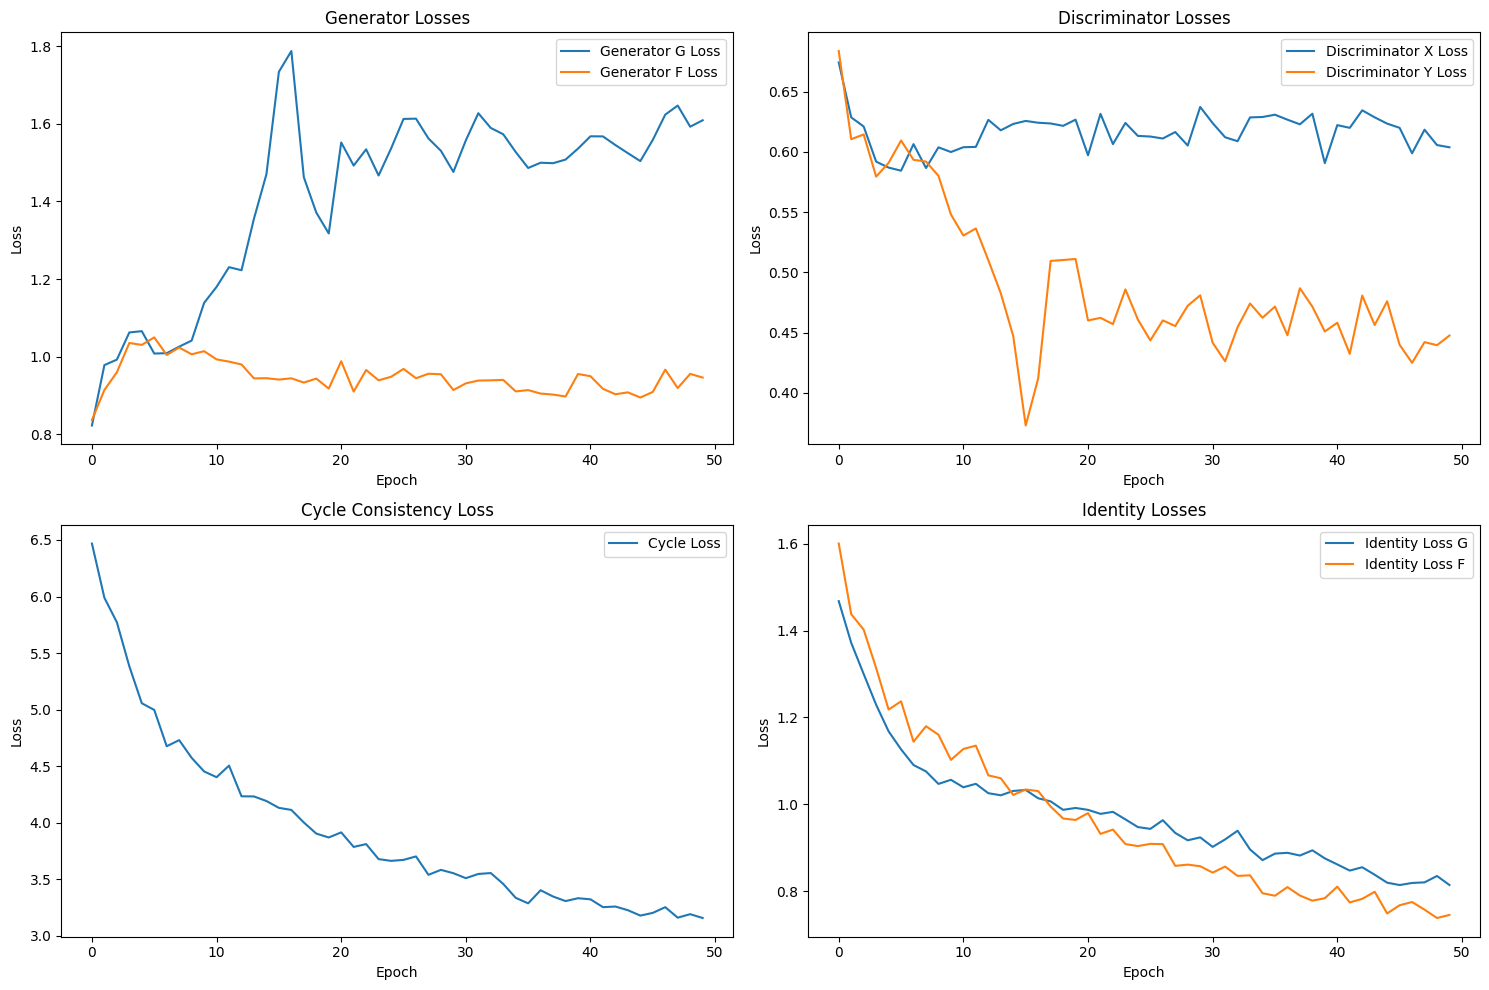

In [ ]:

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(history["gen_g_loss"], label="Generator G Loss")
plt.plot(history["gen_f_loss"], label="Generator F Loss")
plt.title("Generator Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(history["disc_x_loss"], label="Discriminator X Loss")
plt.plot(history["disc_y_loss"], label="Discriminator Y Loss")
plt.title("Discriminator Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(history["cycle_loss"], label="Cycle Loss")
plt.title("Cycle Consistency Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2,2,4)
plt.plot(history["id_loss_g"], label="Identity Loss G")
plt.plot(history["id_loss_f"], label="Identity Loss F")
plt.title("Identity Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


- Since the generator and discriminator are trained adversarially, their losses fluctuated unstably regardless of the number of epochs.
- This behavior suggests the inherent instability of GAN training.
- On the other hand, the cycle consistency loss and identity loss decreased with the number of epochs, as typically observed in standard deep neural networks. Judging from the overall trend in the graph, these losses are expected to decrease further with more training epochs.
- Although experiments were conducted with different numbers of epochs (not in this notebook), there appeared to be no strong correlation between the decrease in these losses and the evaluation metric MiFID.
- For future improvement, rather than simply increasing the number of epochs, it may be beneficial to incorporate additional loss components that correlate more closely with MiFID.


### Submit

In [ ]:
import zipfile
from tqdm import tqdm

OUTPUT_DIR = '../temp/images'

os.makedirs(OUTPUT_DIR, exist_ok=True)

def decode_image_with_name(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0  # [-1, 1]
    image_name = example['image_name']
    return image_name, image

photo_dataset_for_submit = (
    tf.data.TFRecordDataset(tf.io.gfile.glob(PHOTO_TFREC), num_parallel_reads=tf.data.AUTOTUNE)
    .map(decode_image_with_name, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(1)
    .prefetch(tf.data.AUTOTUNE)
)

# FIXME: debug
# debug_count = 0
for batch in tqdm(photo_dataset_for_submit, total=7028):
    filenames, imgs = batch
    generated_imgs = G_photo2monet(imgs, training=False)
    generated_imgs = generated_imgs.numpy()

    for name, gen_img in zip(filenames.numpy(), generated_imgs):
        filename = name.decode('utf-8')
        output_img = (gen_img + 1.0) * 127.5
        output_img = np.clip(output_img, 0, 255).astype(np.uint8)
        output_bgr = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)

        save_path = os.path.join(OUTPUT_DIR, filename) + ".jpg"
        print(save_path)
        cv2.imwrite(save_path, output_bgr)
    # FIXME: debug
    # if debug_count > 5:
    #     break
    # debug_count += 1

zip_path = './images.zip'
with zipfile.ZipFile(zip_path, "w") as zipf:
    for fname in sorted(os.listdir(OUTPUT_DIR)):
        zipf.write(os.path.join(OUTPUT_DIR, fname), arcname=fname)

print(f"Zip saved: {zip_path}")

  0%|          | 3/7028 [00:00<09:19, 12.55it/s]

../temp/images/ef833e60b4.jpg
../temp/images/e67601a231.jpg
../temp/images/2a14b928c4.jpg


  0%|          | 7/7028 [00:00<08:13, 14.23it/s]

../temp/images/4fe122209b.jpg
../temp/images/718b15a998.jpg
../temp/images/33392f6dea.jpg
../temp/images/f270b20be4.jpg


  0%|          | 9/7028 [00:00<08:03, 14.51it/s]

../temp/images/3820d34bd5.jpg
../temp/images/75942c4668.jpg
../temp/images/f2876e0b28.jpg
../temp/images/53c245a6f3.jpg


  0%|          | 13/7028 [00:00<07:57, 14.70it/s]

../temp/images/da3b4dd28e.jpg
../temp/images/eef39ac09b.jpg
../temp/images/5cf2ea15af.jpg


  0%|          | 17/7028 [00:01<07:54, 14.78it/s]

../temp/images/95d4cb8eca.jpg
../temp/images/345ee88105.jpg
../temp/images/f24acd17d0.jpg


  0%|          | 19/7028 [00:01<08:08, 14.35it/s]

../temp/images/402358e99c.jpg
../temp/images/a3ac3b8f7e.jpg
../temp/images/441ba0764f.jpg


  0%|          | 23/7028 [00:01<08:06, 14.39it/s]

../temp/images/0724805941.jpg
../temp/images/812c304d83.jpg
../temp/images/75aeffdcf8.jpg
../temp/images/f4eb47f0dd.jpg


  0%|          | 27/7028 [00:01<08:06, 14.38it/s]

../temp/images/e18c605daf.jpg
../temp/images/0ad13029a9.jpg
../temp/images/5b430536ec.jpg


  0%|          | 29/7028 [00:02<08:14, 14.14it/s]

../temp/images/ce7a05feca.jpg
../temp/images/db18f28537.jpg
../temp/images/59c73a71e2.jpg


  0%|          | 33/7028 [00:02<08:32, 13.65it/s]

../temp/images/32dde12686.jpg
../temp/images/26cd0ec0e4.jpg
../temp/images/b8e1eafdef.jpg


  0%|          | 35/7028 [00:02<08:28, 13.75it/s]

../temp/images/722cb1e56d.jpg
../temp/images/abc2244ad0.jpg
../temp/images/b027a80904.jpg


  1%|          | 39/7028 [00:02<08:20, 13.96it/s]

../temp/images/c5f84dbc49.jpg
../temp/images/300de48204.jpg
../temp/images/c9596992ba.jpg


  1%|          | 41/7028 [00:02<08:19, 14.00it/s]

../temp/images/af672cd7de.jpg
../temp/images/52087dc0d6.jpg
../temp/images/d744753df3.jpg


  1%|          | 45/7028 [00:03<08:18, 14.01it/s]

../temp/images/463be5a1a1.jpg
../temp/images/aa0485a59f.jpg
../temp/images/cd7c6b3be6.jpg


  1%|          | 47/7028 [00:03<08:13, 14.16it/s]

../temp/images/a301643a27.jpg
../temp/images/36d67864d9.jpg
../temp/images/be5a727d8a.jpg


  1%|          | 51/7028 [00:03<08:04, 14.41it/s]

../temp/images/b635c95844.jpg
../temp/images/ce15456147.jpg
../temp/images/bcde913d1d.jpg


  1%|          | 53/7028 [00:03<08:03, 14.44it/s]

../temp/images/e10f4e0249.jpg
../temp/images/b763d10895.jpg
../temp/images/d6b0733797.jpg


  1%|          | 57/7028 [00:04<07:58, 14.56it/s]

../temp/images/ebb0aa2f01.jpg
../temp/images/a12235c7d1.jpg
../temp/images/e278a31c95.jpg


  1%|          | 59/7028 [00:04<07:55, 14.64it/s]

../temp/images/c6e35b7a8e.jpg
../temp/images/73bc721c0c.jpg
../temp/images/04f59976b5.jpg


  1%|          | 63/7028 [00:04<07:55, 14.65it/s]

../temp/images/d750bc223e.jpg
../temp/images/129df5c60c.jpg
../temp/images/eea8eff240.jpg


  1%|          | 65/7028 [00:04<07:56, 14.62it/s]

../temp/images/774082dd9e.jpg
../temp/images/bdf3d3a8e5.jpg
../temp/images/22b213f1e5.jpg


  1%|          | 69/7028 [00:04<07:54, 14.65it/s]

../temp/images/91cf22742c.jpg
../temp/images/53998f50b2.jpg
../temp/images/fe283d4ae3.jpg


  1%|          | 71/7028 [00:04<07:54, 14.65it/s]

../temp/images/7fc9c15d6c.jpg
../temp/images/376f1b5edb.jpg
../temp/images/bb15fcc4ff.jpg


  1%|          | 75/7028 [00:05<07:50, 14.79it/s]

../temp/images/a8a4ee4f79.jpg
../temp/images/5e64b64de8.jpg
../temp/images/66dbf73abc.jpg


  1%|          | 77/7028 [00:05<07:50, 14.77it/s]

../temp/images/ef488233e3.jpg
../temp/images/08cbd0d6c4.jpg
../temp/images/4d1c0b488e.jpg


  1%|          | 81/7028 [00:05<07:48, 14.84it/s]

../temp/images/42b9334189.jpg
../temp/images/aa44603744.jpg
../temp/images/8a987f711b.jpg


  1%|          | 83/7028 [00:05<07:48, 14.83it/s]

../temp/images/122f944d40.jpg
../temp/images/03950208ff.jpg
../temp/images/f9080ec43b.jpg


  1%|          | 87/7028 [00:06<07:48, 14.81it/s]

../temp/images/d9a87c0d5d.jpg
../temp/images/a63a32e180.jpg
../temp/images/1a2cd9ea8c.jpg


  1%|▏         | 91/7028 [00:06<07:45, 14.90it/s]

../temp/images/50a5168133.jpg
../temp/images/899b7f7521.jpg
../temp/images/cf476a1333.jpg
../temp/images/a82a9c378a.jpg


  1%|▏         | 95/7028 [00:06<07:43, 14.96it/s]

../temp/images/e8e02ca944.jpg
../temp/images/38ebf8fc82.jpg
../temp/images/664b161ecc.jpg
../temp/images/7828416c2b.jpg


  1%|▏         | 97/7028 [00:06<07:43, 14.96it/s]

../temp/images/999e87f7a6.jpg
../temp/images/47f3b40cbc.jpg
../temp/images/a90b8ea6ed.jpg
../temp/images/6bf0976dae.jpg


  1%|▏         | 101/7028 [00:06<07:43, 14.94it/s]

../temp/images/0845e8dc24.jpg
../temp/images/f69731b55b.jpg
../temp/images/0d89393fe0.jpg
../temp/images/c2acbc2675.jpg


  1%|▏         | 105/7028 [00:07<07:43, 14.95it/s]

../temp/images/8b6dd12ee0.jpg
../temp/images/4c1165be97.jpg
../temp/images/32b537e6de.jpg


  2%|▏         | 109/7028 [00:07<07:48, 14.77it/s]

../temp/images/061f0095f0.jpg
../temp/images/a6e519d471.jpg
../temp/images/8d297a6fba.jpg


  2%|▏         | 111/7028 [00:07<07:49, 14.74it/s]

../temp/images/096da37ff7.jpg
../temp/images/c5921d07d4.jpg
../temp/images/592bf31bd5.jpg


  2%|▏         | 115/7028 [00:07<07:45, 14.85it/s]

../temp/images/38d5379f18.jpg
../temp/images/efa2ba7d02.jpg
../temp/images/c280ccdd9b.jpg
../temp/images/626caaa1ce.jpg


  2%|▏         | 119/7028 [00:08<07:44, 14.86it/s]

../temp/images/acaf4ef81e.jpg
../temp/images/c0757c90f9.jpg
../temp/images/a1a84d3eda.jpg


  2%|▏         | 121/7028 [00:08<07:46, 14.81it/s]

../temp/images/3916d76a57.jpg
../temp/images/4581a4faee.jpg
../temp/images/4ebb3df6e1.jpg


  2%|▏         | 125/7028 [00:08<07:44, 14.85it/s]

../temp/images/fa4326ff01.jpg
../temp/images/4c8a000abb.jpg
../temp/images/4ca6e5451a.jpg


  2%|▏         | 127/7028 [00:08<07:46, 14.80it/s]

../temp/images/7759594268.jpg
../temp/images/569ed795ec.jpg
../temp/images/816941fe05.jpg


  2%|▏         | 131/7028 [00:09<07:45, 14.80it/s]

../temp/images/f68e29bd81.jpg
../temp/images/60adaaa8fa.jpg
../temp/images/d9e227f734.jpg


  2%|▏         | 133/7028 [00:09<07:47, 14.76it/s]

../temp/images/b60f74cca9.jpg
../temp/images/86777200f8.jpg
../temp/images/6fd27b0261.jpg


  2%|▏         | 137/7028 [00:09<07:42, 14.92it/s]

../temp/images/fc075619e7.jpg
../temp/images/62ada6e480.jpg
../temp/images/4a06596662.jpg
../temp/images/1cc26c48b8.jpg


  2%|▏         | 141/7028 [00:09<07:42, 14.88it/s]

../temp/images/00f78547f0.jpg
../temp/images/eab57199fa.jpg
../temp/images/47df262cc5.jpg


  2%|▏         | 143/7028 [00:09<07:46, 14.76it/s]

../temp/images/7981b8e217.jpg
../temp/images/de37e2ad60.jpg
../temp/images/c9ff68f5a2.jpg


  2%|▏         | 147/7028 [00:10<07:50, 14.64it/s]

../temp/images/696f56514d.jpg
../temp/images/73eb34dde6.jpg
../temp/images/7237fc1604.jpg


  2%|▏         | 149/7028 [00:10<07:48, 14.70it/s]

../temp/images/38086cf21f.jpg
../temp/images/fe40ac1d8b.jpg
../temp/images/69ba3dbcbe.jpg


  2%|▏         | 153/7028 [00:10<07:45, 14.78it/s]

../temp/images/f8c19eaee6.jpg
../temp/images/3414d1e597.jpg
../temp/images/d4f9dfa248.jpg
../temp/images/37df208f9f.jpg


  2%|▏         | 157/7028 [00:10<07:39, 14.94it/s]

../temp/images/db00979196.jpg
../temp/images/b46106fd89.jpg
../temp/images/09e2982b82.jpg
../temp/images/0fb1ca7fe1.jpg


  2%|▏         | 161/7028 [00:11<07:39, 14.94it/s]

../temp/images/5bfc51adc2.jpg
../temp/images/449d31ec71.jpg
../temp/images/37fba790de.jpg


  2%|▏         | 163/7028 [00:11<07:39, 14.94it/s]

../temp/images/36eb013265.jpg
../temp/images/5d1671f99b.jpg
../temp/images/bec2bc2d65.jpg


  2%|▏         | 167/7028 [00:11<08:09, 14.02it/s]

../temp/images/093e24f728.jpg
../temp/images/38f185baa6.jpg
../temp/images/4f5d5e7da3.jpg


  2%|▏         | 169/7028 [00:11<08:02, 14.21it/s]

../temp/images/f0aa76ff07.jpg
../temp/images/e4db596478.jpg
../temp/images/d90bdfc690.jpg


  2%|▏         | 173/7028 [00:11<07:52, 14.50it/s]

../temp/images/d39869db76.jpg
../temp/images/2a114c7c94.jpg
../temp/images/3ad0aa389f.jpg


  2%|▏         | 175/7028 [00:12<07:50, 14.57it/s]

../temp/images/5587066bdc.jpg
../temp/images/170434d3dd.jpg
../temp/images/6a0c1b662f.jpg


  3%|▎         | 179/7028 [00:12<07:49, 14.60it/s]

../temp/images/10f3bc8893.jpg
../temp/images/228c986820.jpg
../temp/images/8f0aa160cb.jpg


  3%|▎         | 181/7028 [00:12<07:48, 14.62it/s]

../temp/images/2cbb870493.jpg
../temp/images/d188df6a22.jpg
../temp/images/51867bc005.jpg


  3%|▎         | 185/7028 [00:12<07:44, 14.74it/s]

../temp/images/838707bb83.jpg
../temp/images/dc5829408f.jpg
../temp/images/98ff290926.jpg


  3%|▎         | 187/7028 [00:12<07:44, 14.74it/s]

../temp/images/339d590103.jpg
../temp/images/a9de4c4d69.jpg
../temp/images/33ffdde2a0.jpg


  3%|▎         | 191/7028 [00:13<07:44, 14.71it/s]

../temp/images/5451321dd0.jpg
../temp/images/606edf9e69.jpg
../temp/images/097b3ce81a.jpg


  3%|▎         | 193/7028 [00:13<07:47, 14.62it/s]

../temp/images/a7594e87fd.jpg
../temp/images/ba4f07f939.jpg
../temp/images/6700b4b7bb.jpg


  3%|▎         | 197/7028 [00:13<07:39, 14.85it/s]

../temp/images/6f2bf952a9.jpg
../temp/images/a26b0f2735.jpg
../temp/images/c9cba4bd0e.jpg


  3%|▎         | 199/7028 [00:13<07:41, 14.79it/s]

../temp/images/19c8301d67.jpg
../temp/images/37c5732454.jpg
../temp/images/aa2b315b55.jpg


  3%|▎         | 203/7028 [00:13<07:42, 14.76it/s]

../temp/images/2da41f7e22.jpg
../temp/images/84ee633e7a.jpg
../temp/images/e218d1a1ea.jpg


  3%|▎         | 205/7028 [00:14<07:42, 14.76it/s]

../temp/images/7adce96691.jpg
../temp/images/ae2c1ea2d6.jpg
../temp/images/ca4a5b1d15.jpg
../temp/images/0b4dbff7c8.jpg


  3%|▎         | 211/7028 [00:14<07:34, 15.00it/s]

../temp/images/d5c7781f64.jpg
../temp/images/cec134e6c0.jpg
../temp/images/0c6b56bba9.jpg
../temp/images/494db50238.jpg


  3%|▎         | 215/7028 [00:14<07:31, 15.11it/s]

../temp/images/318d2dd948.jpg
../temp/images/b70ec20b75.jpg
../temp/images/17499b0283.jpg
../temp/images/b66c82cf2a.jpg


  3%|▎         | 219/7028 [00:14<07:29, 15.16it/s]

../temp/images/b61461c172.jpg
../temp/images/e87676e6e2.jpg
../temp/images/f2f56add24.jpg
../temp/images/2b3a026f51.jpg


  3%|▎         | 221/7028 [00:15<07:33, 15.00it/s]

../temp/images/adf316819b.jpg
../temp/images/5019a8ffcf.jpg
../temp/images/83f5a65548.jpg


  3%|▎         | 225/7028 [00:15<07:34, 14.95it/s]

../temp/images/8040facbe6.jpg
../temp/images/ef59ec0110.jpg
../temp/images/83b513a9f5.jpg
../temp/images/35e7c9ec58.jpg


  3%|▎         | 229/7028 [00:15<07:31, 15.06it/s]

../temp/images/6090cac2ca.jpg
../temp/images/05f22b97da.jpg
../temp/images/0d6c81cbc2.jpg
../temp/images/13328c1504.jpg


  3%|▎         | 233/7028 [00:15<07:34, 14.95it/s]

../temp/images/4cd07a4561.jpg
../temp/images/79dd5cd9b8.jpg
../temp/images/11c24d756f.jpg


  3%|▎         | 235/7028 [00:16<07:35, 14.90it/s]

../temp/images/5dcfd3a36f.jpg
../temp/images/ea6917e2db.jpg
../temp/images/fbc3754be3.jpg
../temp/images/d3650f6c75.jpg


  3%|▎         | 241/7028 [00:16<07:33, 14.96it/s]

../temp/images/92a4544fb1.jpg
../temp/images/f64019e49d.jpg
../temp/images/a0f0dee611.jpg
../temp/images/c1114abb60.jpg


  3%|▎         | 243/7028 [00:16<07:35, 14.88it/s]

../temp/images/fd457c68d9.jpg
../temp/images/bc57ed5fda.jpg
../temp/images/5e4de25a9c.jpg


  4%|▎         | 247/7028 [00:16<07:39, 14.76it/s]

../temp/images/3f91546f37.jpg
../temp/images/99d04bd95f.jpg
../temp/images/40e2fb2f62.jpg


  4%|▎         | 249/7028 [00:16<07:38, 14.80it/s]

../temp/images/80e9db68d7.jpg
../temp/images/305fc59b7e.jpg
../temp/images/afee15fa99.jpg


  4%|▎         | 253/7028 [00:17<07:37, 14.82it/s]

../temp/images/9c77707e49.jpg
../temp/images/43f3d41042.jpg
../temp/images/d842c67749.jpg


  4%|▎         | 255/7028 [00:17<07:36, 14.83it/s]

../temp/images/2f109a6785.jpg
../temp/images/d860d82c66.jpg
../temp/images/c6aea7cf4f.jpg


  4%|▎         | 259/7028 [00:17<07:37, 14.81it/s]

../temp/images/e7b73c75cb.jpg
../temp/images/7a384aae43.jpg
../temp/images/af24d79cda.jpg


  4%|▎         | 261/7028 [00:17<07:39, 14.74it/s]

../temp/images/baac2fc0d9.jpg
../temp/images/f51503f974.jpg
../temp/images/9da065344d.jpg


  4%|▍         | 265/7028 [00:18<07:39, 14.73it/s]

../temp/images/22c5bb63ac.jpg
../temp/images/12f09c6efe.jpg
../temp/images/dac8b251fd.jpg


  4%|▍         | 267/7028 [00:18<07:38, 14.76it/s]

../temp/images/ef15317c67.jpg
../temp/images/c48dd873be.jpg
../temp/images/2d44d8ede7.jpg
../temp/images/0711866dcd.jpg


  4%|▍         | 273/7028 [00:18<07:32, 14.93it/s]

../temp/images/bca6fd9039.jpg
../temp/images/2ce941f6ea.jpg
../temp/images/40454944a3.jpg
../temp/images/416fcde5d2.jpg


  4%|▍         | 275/7028 [00:18<07:31, 14.95it/s]

../temp/images/3b6c01176c.jpg
../temp/images/addf00ca3f.jpg
../temp/images/d33f9a1542.jpg


  4%|▍         | 279/7028 [00:19<07:34, 14.86it/s]

../temp/images/ae5ac0bf8a.jpg
../temp/images/3c8de7efcc.jpg
../temp/images/b12d6de1d9.jpg


  4%|▍         | 281/7028 [00:19<07:36, 14.78it/s]

../temp/images/f67f1708b6.jpg
../temp/images/5a384bf8d9.jpg
../temp/images/6fc20169b5.jpg


  4%|▍         | 285/7028 [00:19<07:34, 14.83it/s]

../temp/images/c6f400cade.jpg
../temp/images/58ae62fe43.jpg
../temp/images/54557ef4cf.jpg


  4%|▍         | 289/7028 [00:19<07:31, 14.92it/s]

../temp/images/40b341cce7.jpg
../temp/images/aa64f54007.jpg
../temp/images/f62bb41c9c.jpg
../temp/images/d6dcf25188.jpg


  4%|▍         | 291/7028 [00:19<07:34, 14.82it/s]

../temp/images/b69f383965.jpg
../temp/images/a0f2fad96f.jpg
../temp/images/2cf96e5d1d.jpg


  4%|▍         | 295/7028 [00:20<07:32, 14.86it/s]

../temp/images/7b2df8fad8.jpg
../temp/images/84637eb98b.jpg
../temp/images/0b1669c3ea.jpg


  4%|▍         | 297/7028 [00:20<07:32, 14.87it/s]

../temp/images/fa9a768c9b.jpg
../temp/images/403a9eb385.jpg
../temp/images/a8089a9f66.jpg
../temp/images/229221319f.jpg


  4%|▍         | 303/7028 [00:20<07:28, 15.00it/s]

../temp/images/1912f08cb1.jpg
../temp/images/8a6a17661a.jpg
../temp/images/0932ad9605.jpg
../temp/images/c8d6f98b20.jpg


  4%|▍         | 305/7028 [00:20<07:27, 15.03it/s]

../temp/images/172a0707b2.jpg
../temp/images/7b563f3da5.jpg
../temp/images/bb38cedde5.jpg


  4%|▍         | 309/7028 [00:21<07:30, 14.92it/s]

../temp/images/433f72e01b.jpg
../temp/images/776dbabcb1.jpg
../temp/images/90aa881d59.jpg


  4%|▍         | 311/7028 [00:21<07:29, 14.95it/s]

../temp/images/7d72c4ba28.jpg
../temp/images/54b6bbf683.jpg
../temp/images/d1340eb9e0.jpg


  4%|▍         | 315/7028 [00:21<07:51, 14.25it/s]

../temp/images/a97e50a8d4.jpg
../temp/images/76a03653aa.jpg
../temp/images/f8350e28db.jpg


  5%|▍         | 317/7028 [00:21<07:45, 14.42it/s]

../temp/images/e715464acb.jpg
../temp/images/696803e17c.jpg
../temp/images/e53aaac02c.jpg
../temp/images/3bcc67701d.jpg


  5%|▍         | 321/7028 [00:21<07:37, 14.66it/s]

../temp/images/099159901a.jpg
../temp/images/306ebd4b5c.jpg
../temp/images/64c68d0aa3.jpg
../temp/images/29864d1221.jpg


  5%|▍         | 325/7028 [00:22<07:33, 14.78it/s]

../temp/images/198cad00d4.jpg
../temp/images/91c0fb330a.jpg
../temp/images/3b57973eb2.jpg


  5%|▍         | 329/7028 [00:22<07:31, 14.82it/s]

../temp/images/94f6b65afa.jpg
../temp/images/cc47cfe509.jpg
../temp/images/2aa39bfaca.jpg


  5%|▍         | 331/7028 [00:22<07:32, 14.81it/s]

../temp/images/d1879069e7.jpg
../temp/images/223c77d56f.jpg
../temp/images/b03646ab9d.jpg


  5%|▍         | 335/7028 [00:22<07:34, 14.72it/s]

../temp/images/cbca2560a2.jpg
../temp/images/c1294c7cd9.jpg
../temp/images/cdb10fd47a.jpg


  5%|▍         | 337/7028 [00:22<07:34, 14.71it/s]

../temp/images/68e93f1dd4.jpg
../temp/images/991eb1e448.jpg
../temp/images/a598e5aef5.jpg


  5%|▍         | 341/7028 [00:23<07:34, 14.72it/s]

../temp/images/fcc59cb31d.jpg
../temp/images/b90dc41d5d.jpg
../temp/images/34f4d5c9d4.jpg


  5%|▍         | 343/7028 [00:23<07:36, 14.64it/s]

../temp/images/563012ee88.jpg
../temp/images/93404abb02.jpg
../temp/images/72e448ba0d.jpg


  5%|▍         | 347/7028 [00:23<07:33, 14.73it/s]

../temp/images/38993b35f9.jpg
../temp/images/ad08c8c439.jpg
../temp/images/ec5d51aaf0.jpg


  5%|▍         | 349/7028 [00:23<07:31, 14.78it/s]

../temp/images/05057d04f7.jpg
../temp/images/ecad06947b.jpg
../temp/images/ecb38a1051.jpg


  5%|▌         | 353/7028 [00:24<07:28, 14.89it/s]

../temp/images/5ef70f37ea.jpg
../temp/images/4e5b4fb2ab.jpg
../temp/images/9f15606758.jpg


  5%|▌         | 355/7028 [00:24<07:28, 14.86it/s]

../temp/images/ead622126f.jpg
../temp/images/c5df072a87.jpg
../temp/images/79419a7227.jpg


  5%|▌         | 359/7028 [00:24<07:30, 14.81it/s]

../temp/images/16de6b603c.jpg
../temp/images/c72720ffb0.jpg
../temp/images/1d971deb73.jpg


  5%|▌         | 363/7028 [00:24<07:28, 14.85it/s]

../temp/images/b9d2ba2502.jpg
../temp/images/12193672ba.jpg
../temp/images/7a4248c339.jpg
../temp/images/b469541ab9.jpg


  5%|▌         | 365/7028 [00:24<07:27, 14.88it/s]

../temp/images/c3ae8d9885.jpg
../temp/images/bf8f3d28ae.jpg
../temp/images/4862d17fa4.jpg


  5%|▌         | 369/7028 [00:25<07:29, 14.82it/s]

../temp/images/8f9cc89fc1.jpg
../temp/images/899e306a16.jpg
../temp/images/aaeb9e1228.jpg


  5%|▌         | 371/7028 [00:25<07:31, 14.76it/s]

../temp/images/53902a4799.jpg
../temp/images/482fd44fce.jpg
../temp/images/115f221c2a.jpg


  5%|▌         | 375/7028 [00:25<07:27, 14.88it/s]

../temp/images/932f681182.jpg
../temp/images/fd49936788.jpg
../temp/images/f357fe1f0d.jpg
../temp/images/e4b6e49888.jpg


  5%|▌         | 379/7028 [00:25<07:25, 14.92it/s]

../temp/images/90fc280b72.jpg
../temp/images/2c0394a36e.jpg
../temp/images/3a747d8723.jpg
../temp/images/e39562f090.jpg


  5%|▌         | 383/7028 [00:26<07:29, 14.77it/s]

../temp/images/d4c215c09e.jpg
../temp/images/b61e2b3b0d.jpg
../temp/images/53679e6985.jpg


  6%|▌         | 387/7028 [00:26<07:26, 14.87it/s]

../temp/images/9e8554fade.jpg
../temp/images/8c98a42872.jpg
../temp/images/a7976448c0.jpg
../temp/images/20043a8eaf.jpg


  6%|▌         | 389/7028 [00:26<07:28, 14.79it/s]

../temp/images/8868ba6b14.jpg
../temp/images/e365dae98b.jpg
../temp/images/48eb5fa7bd.jpg
../temp/images/91c4ec2938.jpg


  6%|▌         | 393/7028 [00:26<07:23, 14.95it/s]

../temp/images/3cc4339658.jpg
../temp/images/6360e41e69.jpg
../temp/images/87edc083e0.jpg
../temp/images/c52044fdd2.jpg


  6%|▌         | 397/7028 [00:26<07:25, 14.89it/s]

../temp/images/b7907e76c4.jpg
../temp/images/0e8eb4587e.jpg
../temp/images/7cb0522881.jpg
../temp/images/8562b1ef80.jpg


  6%|▌         | 403/7028 [00:27<07:21, 15.00it/s]

../temp/images/5a294c5685.jpg
../temp/images/944398f81d.jpg
../temp/images/85d1493cb9.jpg
../temp/images/b404fb513f.jpg


  6%|▌         | 405/7028 [00:27<07:24, 14.90it/s]

../temp/images/7a790425a3.jpg
../temp/images/e8338afa09.jpg
../temp/images/e428d47850.jpg


  6%|▌         | 409/7028 [00:27<07:28, 14.75it/s]

../temp/images/d62eeaccb0.jpg
../temp/images/1eb579374e.jpg
../temp/images/cc3d775c49.jpg


  6%|▌         | 411/7028 [00:27<07:32, 14.62it/s]

../temp/images/8eabde45df.jpg
../temp/images/fbc70f973a.jpg
../temp/images/cd5d08f5be.jpg
../temp/images/9921ef9e3c.jpg


  6%|▌         | 415/7028 [00:28<07:26, 14.79it/s]

../temp/images/d2e17623a7.jpg
../temp/images/1bd527d6a0.jpg
../temp/images/240a7c491a.jpg


  6%|▌         | 419/7028 [00:28<07:28, 14.73it/s]

../temp/images/164ebc7900.jpg
../temp/images/4b59dd4ebc.jpg
../temp/images/22c2ebefea.jpg


  6%|▌         | 421/7028 [00:28<07:33, 14.56it/s]

../temp/images/e0ffb419d8.jpg
../temp/images/3656053e31.jpg
../temp/images/38629959ac.jpg


  6%|▌         | 425/7028 [00:28<07:31, 14.61it/s]

../temp/images/d2db5c1d58.jpg
../temp/images/f8c63eea5a.jpg
../temp/images/d12a49b5f4.jpg


  6%|▌         | 427/7028 [00:29<07:30, 14.64it/s]

../temp/images/6b87a7b5dc.jpg
../temp/images/e6e6959173.jpg
../temp/images/fdc6c88003.jpg


  6%|▌         | 431/7028 [00:29<07:28, 14.72it/s]

../temp/images/f2d042180c.jpg
../temp/images/d09ad65e9a.jpg
../temp/images/f298108b32.jpg


  6%|▌         | 433/7028 [00:29<07:28, 14.69it/s]

../temp/images/2daf4ce562.jpg
../temp/images/debf11d04c.jpg
../temp/images/6383f39af4.jpg


  6%|▌         | 437/7028 [00:29<07:28, 14.69it/s]

../temp/images/2145ce0f78.jpg
../temp/images/abeca4498a.jpg
../temp/images/c50837aa54.jpg


  6%|▌         | 439/7028 [00:29<07:30, 14.62it/s]

../temp/images/1c3c1aca33.jpg
../temp/images/99c0ccba50.jpg
../temp/images/748e1a440c.jpg


  6%|▋         | 443/7028 [00:30<07:29, 14.65it/s]

../temp/images/cafe98985e.jpg
../temp/images/1a8633fbb9.jpg
../temp/images/a42d5a72ff.jpg


  6%|▋         | 445/7028 [00:30<07:27, 14.70it/s]

../temp/images/a5a55a6605.jpg
../temp/images/70d2dd3347.jpg
../temp/images/396b917aad.jpg


  6%|▋         | 449/7028 [00:30<07:24, 14.79it/s]

../temp/images/7a672fc939.jpg
../temp/images/a562192a23.jpg
../temp/images/1a8c9e6c4c.jpg


  6%|▋         | 451/7028 [00:30<07:23, 14.82it/s]

../temp/images/0cda2627bf.jpg
../temp/images/40773a3569.jpg
../temp/images/01622039ef.jpg
../temp/images/96c65e76e1.jpg


  7%|▋         | 457/7028 [00:31<07:22, 14.85it/s]

../temp/images/1d44f79c1c.jpg
../temp/images/2a503386a2.jpg
../temp/images/e6c25786d7.jpg
../temp/images/922e075696.jpg


  7%|▋         | 459/7028 [00:31<07:23, 14.81it/s]

../temp/images/e00bba74a2.jpg
../temp/images/bf28de635c.jpg
../temp/images/d896bafc3a.jpg


  7%|▋         | 463/7028 [00:31<07:36, 14.37it/s]

../temp/images/372dc58821.jpg
../temp/images/4b689e9b37.jpg
../temp/images/4d7de87ec6.jpg


  7%|▋         | 467/7028 [00:31<07:27, 14.65it/s]

../temp/images/7b9b6563a7.jpg
../temp/images/7c872ca222.jpg
../temp/images/d3f696828f.jpg
../temp/images/c1e5b119c4.jpg


  7%|▋         | 469/7028 [00:31<07:26, 14.70it/s]

../temp/images/f4a6936ec9.jpg
../temp/images/852771e943.jpg
../temp/images/3447169f2b.jpg


  7%|▋         | 473/7028 [00:32<07:25, 14.71it/s]

../temp/images/06f749912b.jpg
../temp/images/d76a286580.jpg
../temp/images/f6cb2948da.jpg


  7%|▋         | 475/7028 [00:32<07:23, 14.76it/s]

../temp/images/880f24ca7d.jpg
../temp/images/9050e1c0e6.jpg
../temp/images/a4314f85dd.jpg


  7%|▋         | 479/7028 [00:32<07:24, 14.73it/s]

../temp/images/8c59a24ec4.jpg
../temp/images/b05f08496f.jpg
../temp/images/40634ec806.jpg


  7%|▋         | 481/7028 [00:32<07:24, 14.74it/s]

../temp/images/ab001a0dce.jpg
../temp/images/62a4327b05.jpg
../temp/images/da53718103.jpg


  7%|▋         | 485/7028 [00:32<07:22, 14.78it/s]

../temp/images/84cd781c32.jpg
../temp/images/96baf57a50.jpg
../temp/images/5da725f8d7.jpg


  7%|▋         | 487/7028 [00:33<07:21, 14.80it/s]

../temp/images/f203101270.jpg
../temp/images/4a29db3c6b.jpg
../temp/images/44f0533b7d.jpg


  7%|▋         | 491/7028 [00:33<07:21, 14.82it/s]

../temp/images/1a45b8c270.jpg
../temp/images/1ce3cb350d.jpg
../temp/images/7801bb9581.jpg


  7%|▋         | 493/7028 [00:33<07:43, 14.10it/s]

../temp/images/607508ca60.jpg
../temp/images/49e4129024.jpg
../temp/images/0761281e3b.jpg


  7%|▋         | 497/7028 [00:33<07:45, 14.03it/s]

../temp/images/74f46669b2.jpg
../temp/images/aa9acfe3e7.jpg
../temp/images/7cc41853c4.jpg


  7%|▋         | 499/7028 [00:33<07:50, 13.87it/s]

../temp/images/c77ecc882a.jpg
../temp/images/e545b38111.jpg
../temp/images/e6ad3eec60.jpg


  7%|▋         | 503/7028 [00:34<07:46, 14.00it/s]

../temp/images/ca989796e8.jpg
../temp/images/25cb295b1f.jpg
../temp/images/9bf556f160.jpg


  7%|▋         | 505/7028 [00:34<07:42, 14.10it/s]

../temp/images/1240cc6f83.jpg
../temp/images/7571b0e8bb.jpg
../temp/images/803cdfa30d.jpg


  7%|▋         | 509/7028 [00:34<07:41, 14.13it/s]

../temp/images/a49bfc7f31.jpg
../temp/images/18e571a627.jpg
../temp/images/71d0f6d808.jpg


  7%|▋         | 511/7028 [00:34<07:38, 14.21it/s]

../temp/images/7c68ca1865.jpg
../temp/images/b6398ab782.jpg
../temp/images/d3f0e309e0.jpg


  7%|▋         | 515/7028 [00:35<07:32, 14.40it/s]

../temp/images/a179e79a0c.jpg
../temp/images/5901773791.jpg
../temp/images/adbb6706f4.jpg


  7%|▋         | 517/7028 [00:35<07:26, 14.58it/s]

../temp/images/a65bfd0e43.jpg
../temp/images/b30876c470.jpg
../temp/images/5116db8d92.jpg
../temp/images/3e806e2a4a.jpg


  7%|▋         | 521/7028 [00:35<07:22, 14.70it/s]

../temp/images/3f28319f81.jpg
../temp/images/c09421b98c.jpg
../temp/images/0ac4b6aaaa.jpg


  7%|▋         | 525/7028 [00:35<07:21, 14.72it/s]

../temp/images/b489bdec64.jpg
../temp/images/21747ccb08.jpg
../temp/images/87dbe31f97.jpg


  7%|▋         | 527/7028 [00:35<07:21, 14.74it/s]

../temp/images/f9b4d017a3.jpg
../temp/images/091b6b9b07.jpg
../temp/images/7d438b5b3e.jpg


  8%|▊         | 531/7028 [00:36<07:18, 14.81it/s]

../temp/images/53988b72f6.jpg
../temp/images/f46478e139.jpg
../temp/images/52a2a7132e.jpg


  8%|▊         | 533/7028 [00:36<07:17, 14.83it/s]

../temp/images/8b6f332ed2.jpg
../temp/images/c5c637557c.jpg
../temp/images/73ffa6505c.jpg
../temp/images/772787cb7c.jpg


  8%|▊         | 537/7028 [00:36<07:19, 14.78it/s]

../temp/images/873e430467.jpg
../temp/images/178d33e084.jpg
../temp/images/2b19a7b5d3.jpg


  8%|▊         | 541/7028 [00:36<07:19, 14.77it/s]

../temp/images/7805d03ce4.jpg
../temp/images/19b0fbeba0.jpg
../temp/images/405d277475.jpg


  8%|▊         | 543/7028 [00:36<07:19, 14.74it/s]

../temp/images/25462592ac.jpg
../temp/images/62b1939e2e.jpg
../temp/images/3023c7e91c.jpg


  8%|▊         | 547/7028 [00:37<07:19, 14.74it/s]

../temp/images/e0db07d90e.jpg
../temp/images/355c86cd3d.jpg
../temp/images/a88e5ab869.jpg


  8%|▊         | 549/7028 [00:37<07:21, 14.68it/s]

../temp/images/c2656884dd.jpg
../temp/images/f79d9de05d.jpg
../temp/images/8635c1c560.jpg


  8%|▊         | 553/7028 [00:37<07:19, 14.74it/s]

../temp/images/e5e1d837f1.jpg
../temp/images/e340c22dc4.jpg
../temp/images/723451df4f.jpg


  8%|▊         | 555/7028 [00:37<07:19, 14.73it/s]

../temp/images/745612e6f4.jpg
../temp/images/a7b11a83ba.jpg
../temp/images/7140fb929c.jpg


  8%|▊         | 559/7028 [00:38<07:18, 14.76it/s]

../temp/images/f99a7a3267.jpg
../temp/images/25b6be053f.jpg
../temp/images/9b7d65decf.jpg


  8%|▊         | 561/7028 [00:38<07:17, 14.79it/s]

../temp/images/99294cd9e3.jpg
../temp/images/2eaec67b91.jpg
../temp/images/077bf7e451.jpg
../temp/images/295b938a05.jpg


  8%|▊         | 565/7028 [00:38<07:18, 14.74it/s]

../temp/images/0ac84db7bc.jpg
../temp/images/4787b82d37.jpg
../temp/images/ccb1c281ea.jpg


  8%|▊         | 569/7028 [00:38<07:20, 14.65it/s]

../temp/images/2cf4cac9df.jpg
../temp/images/467657f396.jpg
../temp/images/ce83fda480.jpg


  8%|▊         | 571/7028 [00:38<07:23, 14.57it/s]

../temp/images/ec74224ef5.jpg
../temp/images/87673f1feb.jpg
../temp/images/eb5a006cd8.jpg


  8%|▊         | 575/7028 [00:39<07:23, 14.53it/s]

../temp/images/7cb82fa990.jpg
../temp/images/1106610965.jpg
../temp/images/9801846b65.jpg


  8%|▊         | 577/7028 [00:39<07:29, 14.36it/s]

../temp/images/1365922bc1.jpg
../temp/images/43519ebdda.jpg
../temp/images/22b305f62e.jpg


  8%|▊         | 581/7028 [00:39<07:29, 14.35it/s]

../temp/images/6884abf5fe.jpg
../temp/images/b23933adf6.jpg
../temp/images/000910d219.jpg


  8%|▊         | 583/7028 [00:39<07:27, 14.39it/s]

../temp/images/16a0c8ed23.jpg
../temp/images/86d8a1d9ba.jpg
../temp/images/3ebc8a4013.jpg


  8%|▊         | 587/7028 [00:39<07:25, 14.45it/s]

../temp/images/cc9c7d2ee1.jpg
../temp/images/840a22679d.jpg
../temp/images/f60910ed40.jpg


  8%|▊         | 589/7028 [00:40<07:24, 14.50it/s]

../temp/images/0d23431254.jpg
../temp/images/442e55394f.jpg
../temp/images/f4219a5e81.jpg


  8%|▊         | 593/7028 [00:40<07:19, 14.63it/s]

../temp/images/f15b7224fd.jpg
../temp/images/0378bcc7c9.jpg
../temp/images/69c3dba202.jpg


  8%|▊         | 595/7028 [00:40<07:16, 14.73it/s]

../temp/images/46f5ef1042.jpg
../temp/images/8b554cd034.jpg
../temp/images/115cd80f74.jpg
../temp/images/c531391a54.jpg


  9%|▊         | 599/7028 [00:40<07:13, 14.83it/s]

../temp/images/6bc8104d76.jpg
../temp/images/5b3c9ac58f.jpg
../temp/images/362511599b.jpg


  9%|▊         | 603/7028 [00:41<07:21, 14.54it/s]

../temp/images/631cc9e7d1.jpg
../temp/images/9c25e78088.jpg
../temp/images/a908f29569.jpg


  9%|▊         | 605/7028 [00:41<07:27, 14.35it/s]

../temp/images/94ed902431.jpg
../temp/images/882d8f1a40.jpg
../temp/images/5b54acd95e.jpg


  9%|▊         | 609/7028 [00:41<07:31, 14.21it/s]

../temp/images/94224752b4.jpg
../temp/images/7d95240653.jpg
../temp/images/eed8644829.jpg


  9%|▊         | 611/7028 [00:41<07:23, 14.47it/s]

../temp/images/64bd39e960.jpg
../temp/images/6113839c53.jpg
../temp/images/235a2feea2.jpg


  9%|▉         | 615/7028 [00:41<07:18, 14.63it/s]

../temp/images/2641b8175f.jpg
../temp/images/115cd21c1c.jpg
../temp/images/96486253fb.jpg


  9%|▉         | 617/7028 [00:42<07:17, 14.66it/s]

../temp/images/17924dd78d.jpg
../temp/images/de241d55fc.jpg
../temp/images/d1e18d7e5b.jpg


  9%|▉         | 621/7028 [00:42<07:13, 14.78it/s]

../temp/images/cc0a0dab48.jpg
../temp/images/2d25168671.jpg
../temp/images/c81299eae0.jpg


  9%|▉         | 623/7028 [00:42<07:14, 14.74it/s]

../temp/images/a760bc4309.jpg
../temp/images/c9677c2983.jpg
../temp/images/eb1f220d40.jpg


  9%|▉         | 627/7028 [00:42<07:12, 14.79it/s]

../temp/images/661d51efae.jpg
../temp/images/c470eb30ef.jpg
../temp/images/6efbef83a2.jpg
../temp/images/d336c14238.jpg


  9%|▉         | 631/7028 [00:42<07:10, 14.87it/s]

../temp/images/df4975e8bf.jpg
../temp/images/b55174c53d.jpg
../temp/images/dfedfba018.jpg


  9%|▉         | 633/7028 [00:43<07:11, 14.83it/s]

../temp/images/9fbbbf4aec.jpg
../temp/images/20cac2191a.jpg
../temp/images/392c032d0e.jpg


  9%|▉         | 637/7028 [00:43<07:07, 14.95it/s]

../temp/images/edc66bfb66.jpg
../temp/images/211ca2dfb4.jpg
../temp/images/2db034b46c.jpg
../temp/images/e5cb078996.jpg


  9%|▉         | 641/7028 [00:43<07:05, 15.00it/s]

../temp/images/2a87a4fbee.jpg
../temp/images/f56b12cf0b.jpg
../temp/images/38662909dd.jpg
../temp/images/b9cad6e8c0.jpg


  9%|▉         | 645/7028 [00:43<07:09, 14.85it/s]

../temp/images/4b2555ba9c.jpg
../temp/images/3a7a0992dd.jpg
../temp/images/a9460f4e16.jpg


  9%|▉         | 647/7028 [00:44<07:09, 14.86it/s]

../temp/images/6233033047.jpg
../temp/images/d96e82c6f6.jpg
../temp/images/d14363b745.jpg
../temp/images/e2816c6358.jpg


  9%|▉         | 651/7028 [00:44<07:09, 14.86it/s]

../temp/images/deafff753c.jpg
../temp/images/be87bba931.jpg
../temp/images/d828712765.jpg
../temp/images/f265b9c6d2.jpg


  9%|▉         | 655/7028 [00:44<07:06, 14.93it/s]

../temp/images/d615a2ad47.jpg
../temp/images/4c4574cfa8.jpg
../temp/images/f9cf6e7e27.jpg


  9%|▉         | 659/7028 [00:44<07:10, 14.78it/s]

../temp/images/d3703e6c9e.jpg
../temp/images/c39ac686c7.jpg
../temp/images/579cd00684.jpg


  9%|▉         | 661/7028 [00:44<07:09, 14.83it/s]

../temp/images/6ddc86d0e4.jpg
../temp/images/8d511d593a.jpg
../temp/images/d53c1a6896.jpg


  9%|▉         | 665/7028 [00:45<07:08, 14.84it/s]

../temp/images/7f299427bb.jpg
../temp/images/c78a6e867e.jpg
../temp/images/748d5a0ab8.jpg


  9%|▉         | 667/7028 [00:45<07:09, 14.80it/s]

../temp/images/f639ee968c.jpg
../temp/images/347a1a864e.jpg
../temp/images/ed3b265e09.jpg


 10%|▉         | 671/7028 [00:45<07:07, 14.86it/s]

../temp/images/102c9065a7.jpg
../temp/images/cbafaf9b74.jpg
../temp/images/68e40889bf.jpg


 10%|▉         | 673/7028 [00:45<07:07, 14.85it/s]

../temp/images/d9e879879a.jpg
../temp/images/982068245a.jpg
../temp/images/94f272fbc2.jpg
../temp/images/947ecf90b9.jpg


 10%|▉         | 677/7028 [00:46<07:08, 14.83it/s]

../temp/images/4c1b160563.jpg
../temp/images/dcca4f8bb6.jpg
../temp/images/8b41c19587.jpg
../temp/images/252bc3a3ab.jpg


 10%|▉         | 681/7028 [00:46<07:05, 14.90it/s]

../temp/images/1acb4d1d54.jpg
../temp/images/f75a997bb8.jpg
../temp/images/3edae2ef79.jpg


 10%|▉         | 685/7028 [00:46<07:08, 14.80it/s]

../temp/images/08cbd51033.jpg
../temp/images/0d80b97eb4.jpg
../temp/images/5e49c27b03.jpg


 10%|▉         | 687/7028 [00:46<07:09, 14.76it/s]

../temp/images/ffbdd43bfb.jpg
../temp/images/74a47c4bf0.jpg
../temp/images/fd0a02921a.jpg


 10%|▉         | 691/7028 [00:47<07:09, 14.75it/s]

../temp/images/2605924561.jpg
../temp/images/79c459542d.jpg
../temp/images/7a06011cda.jpg


 10%|▉         | 695/7028 [00:47<07:04, 14.93it/s]

../temp/images/cb15285d36.jpg
../temp/images/274cf83fa6.jpg
../temp/images/868b7d7c85.jpg
../temp/images/c50547f5fc.jpg


 10%|▉         | 699/7028 [00:47<07:03, 14.93it/s]

../temp/images/9b5d6d5b9b.jpg
../temp/images/4246be6f2b.jpg
../temp/images/b1512c76c7.jpg
../temp/images/13671d11f9.jpg


 10%|▉         | 701/7028 [00:47<07:02, 14.97it/s]

../temp/images/b89d1cc4f1.jpg
../temp/images/ae7f0cf2c7.jpg
../temp/images/d41cc915ff.jpg
../temp/images/aacc4a4e82.jpg


 10%|█         | 705/7028 [00:47<07:06, 14.82it/s]

../temp/images/0c696d12a2.jpg
../temp/images/82bef71a05.jpg
../temp/images/94b3dc2840.jpg


 10%|█         | 709/7028 [00:48<07:06, 14.81it/s]

../temp/images/f18d2c0a81.jpg
../temp/images/f11ee27f26.jpg
../temp/images/720358ea9a.jpg


 10%|█         | 711/7028 [00:48<07:05, 14.83it/s]

../temp/images/371f2829aa.jpg
../temp/images/42e6bc6527.jpg
../temp/images/a0e2fcf6d8.jpg


 10%|█         | 715/7028 [00:48<07:09, 14.70it/s]

../temp/images/9eacea8aca.jpg
../temp/images/454cf7a157.jpg
../temp/images/97a87bca91.jpg


 10%|█         | 717/7028 [00:48<07:12, 14.58it/s]

../temp/images/005f987f56.jpg
../temp/images/4e8b01ac67.jpg
../temp/images/4d42605a8b.jpg


 10%|█         | 721/7028 [00:49<07:13, 14.55it/s]

../temp/images/8ed9adc2f8.jpg
../temp/images/a99dbf6b17.jpg
../temp/images/53289e47ec.jpg


 10%|█         | 723/7028 [00:49<07:13, 14.55it/s]

../temp/images/dde4567678.jpg
../temp/images/adc8bca42b.jpg
../temp/images/c40157edb5.jpg


 10%|█         | 727/7028 [00:49<07:11, 14.60it/s]

../temp/images/7c955126e8.jpg
../temp/images/3f97bcc230.jpg
../temp/images/acab996be8.jpg


 10%|█         | 729/7028 [00:49<07:12, 14.58it/s]

../temp/images/9cac2116d7.jpg
../temp/images/30ea353d97.jpg
../temp/images/0922bbb3c1.jpg


 10%|█         | 733/7028 [00:49<07:16, 14.42it/s]

../temp/images/587a865f86.jpg
../temp/images/e941a6971b.jpg
../temp/images/b983599509.jpg


 10%|█         | 737/7028 [00:50<07:06, 14.74it/s]

../temp/images/228d0b850f.jpg
../temp/images/b5d90eb11d.jpg
../temp/images/444ea6a3df.jpg
../temp/images/92b4f542a8.jpg


 11%|█         | 741/7028 [00:50<07:03, 14.85it/s]

../temp/images/ee9b29e1b8.jpg
../temp/images/11bcbf0f67.jpg
../temp/images/8fc9fce9f2.jpg
../temp/images/684690671a.jpg


 11%|█         | 743/7028 [00:50<07:00, 14.95it/s]

../temp/images/615f1a41e2.jpg
../temp/images/93a901666e.jpg
../temp/images/13892d15e5.jpg


 11%|█         | 747/7028 [00:50<07:12, 14.52it/s]

../temp/images/371c59835b.jpg
../temp/images/86c26de778.jpg
../temp/images/07362b3f42.jpg


 11%|█         | 749/7028 [00:50<07:11, 14.55it/s]

../temp/images/6a1aea3e32.jpg
../temp/images/ace63e2d37.jpg
../temp/images/edef4ef18d.jpg


 11%|█         | 753/7028 [00:51<07:09, 14.60it/s]

../temp/images/5cb9dcf772.jpg
../temp/images/92cb1b612c.jpg
../temp/images/04b8bfdb1c.jpg


 11%|█         | 755/7028 [00:51<07:26, 14.06it/s]

../temp/images/627532c78c.jpg
../temp/images/70c5926990.jpg
../temp/images/ada64f6f98.jpg


 11%|█         | 759/7028 [00:51<07:16, 14.36it/s]

../temp/images/9d7c3c3eea.jpg
../temp/images/e29923569e.jpg
../temp/images/e9ef067120.jpg


 11%|█         | 761/7028 [00:51<07:11, 14.51it/s]

../temp/images/b164b7525c.jpg
../temp/images/e2be127e28.jpg
../temp/images/3b047fc766.jpg


 11%|█         | 765/7028 [00:52<07:07, 14.66it/s]

../temp/images/2d5abca3d6.jpg
../temp/images/fb2a6a49d7.jpg
../temp/images/23edb57cff.jpg


 11%|█         | 769/7028 [00:52<06:59, 14.91it/s]

../temp/images/3632f44a7c.jpg
../temp/images/d665568cdf.jpg
../temp/images/b0c99529c9.jpg
../temp/images/7e2e2533ee.jpg


 11%|█         | 773/7028 [00:52<06:55, 15.05it/s]

../temp/images/e6dc2ff40c.jpg
../temp/images/e8882a7f33.jpg
../temp/images/3b368db4be.jpg
../temp/images/05ca68299e.jpg


 11%|█         | 777/7028 [00:52<06:54, 15.08it/s]

../temp/images/70bfad4fb3.jpg
../temp/images/4fb6bcd5e8.jpg
../temp/images/88536f79ce.jpg
../temp/images/63372e9038.jpg


 11%|█         | 779/7028 [00:53<06:53, 15.11it/s]

../temp/images/7c1125ebeb.jpg
../temp/images/5e0082e751.jpg
../temp/images/955d88b9a7.jpg


 11%|█         | 783/7028 [00:53<06:55, 15.05it/s]

../temp/images/5f7a943ad3.jpg
../temp/images/67ae13d8fd.jpg
../temp/images/e764b3f35a.jpg


 11%|█         | 785/7028 [00:53<06:59, 14.87it/s]

../temp/images/5cc20cb7e7.jpg
../temp/images/c23e040ff8.jpg
../temp/images/159baa9c2b.jpg


 11%|█         | 789/7028 [00:53<07:01, 14.82it/s]

../temp/images/87016c0800.jpg
../temp/images/745d4137b7.jpg
../temp/images/709c87be1e.jpg


 11%|█▏        | 791/7028 [00:53<06:59, 14.88it/s]

../temp/images/df71b50ac1.jpg
../temp/images/00479e2a21.jpg
../temp/images/5a114c6f90.jpg


 11%|█▏        | 795/7028 [00:54<07:04, 14.67it/s]

../temp/images/7594f0f494.jpg
../temp/images/b5d3195dc8.jpg
../temp/images/e33bb81f2b.jpg


 11%|█▏        | 799/7028 [00:54<07:01, 14.78it/s]

../temp/images/bf6ed52f2c.jpg
../temp/images/8fdc8f747e.jpg
../temp/images/8e218bbeee.jpg
../temp/images/c91c752661.jpg


 11%|█▏        | 801/7028 [00:54<07:00, 14.80it/s]

../temp/images/92c7aa40d9.jpg
../temp/images/fd4debe229.jpg
../temp/images/2a13df2bc3.jpg
../temp/images/1ac35e7dc8.jpg


 11%|█▏        | 805/7028 [00:54<06:58, 14.87it/s]

../temp/images/9b87bd9191.jpg
../temp/images/0fef77210a.jpg
../temp/images/6e72f8ad6c.jpg


 12%|█▏        | 809/7028 [00:55<07:01, 14.76it/s]

../temp/images/fcaeb2fb17.jpg
../temp/images/17f92dd71b.jpg
../temp/images/64fcd56944.jpg


 12%|█▏        | 811/7028 [00:55<07:03, 14.68it/s]

../temp/images/36261d4302.jpg
../temp/images/7491908057.jpg
../temp/images/c7bf31ca58.jpg


 12%|█▏        | 815/7028 [00:55<07:02, 14.72it/s]

../temp/images/fbb8e36b1c.jpg
../temp/images/802eeb0575.jpg
../temp/images/5f6acdd885.jpg


 12%|█▏        | 817/7028 [00:55<07:00, 14.77it/s]

../temp/images/5a722db12a.jpg
../temp/images/169f8a8503.jpg
../temp/images/017018f377.jpg


 12%|█▏        | 821/7028 [00:55<06:58, 14.83it/s]

../temp/images/558e78d813.jpg
../temp/images/23b1669fc4.jpg
../temp/images/0cecce2e24.jpg


 12%|█▏        | 825/7028 [00:56<06:56, 14.88it/s]

../temp/images/dea009ab5b.jpg
../temp/images/8fd6e74ab9.jpg
../temp/images/1d939cb782.jpg
../temp/images/a467ebbd05.jpg


 12%|█▏        | 827/7028 [00:56<06:53, 14.98it/s]

../temp/images/068381ad63.jpg
../temp/images/7c68ccf32f.jpg
../temp/images/fe7af9c427.jpg
../temp/images/26494a01e1.jpg


 12%|█▏        | 831/7028 [00:56<06:54, 14.96it/s]

../temp/images/d5df90dea4.jpg
../temp/images/0d64ca5ecf.jpg
../temp/images/336e786f25.jpg
../temp/images/17b7569c29.jpg


 12%|█▏        | 835/7028 [00:56<06:53, 14.97it/s]

../temp/images/08fa8a6f26.jpg
../temp/images/26db4dcdea.jpg
../temp/images/9f52b55c2b.jpg


 12%|█▏        | 839/7028 [00:57<06:58, 14.80it/s]

../temp/images/a8e62405d3.jpg
../temp/images/4ae0414bb9.jpg
../temp/images/c6ad8bd40d.jpg


 12%|█▏        | 841/7028 [00:57<06:59, 14.76it/s]

../temp/images/319de8a4c3.jpg
../temp/images/ec361682b9.jpg
../temp/images/d3f2a0bb2c.jpg


 12%|█▏        | 845/7028 [00:57<06:58, 14.76it/s]

../temp/images/ea4dc1e88e.jpg
../temp/images/3c53ee8af8.jpg
../temp/images/99fb63fada.jpg


 12%|█▏        | 847/7028 [00:57<06:57, 14.79it/s]

../temp/images/d3f454681f.jpg
../temp/images/97d76023a7.jpg
../temp/images/5c9487be68.jpg
../temp/images/335adb946b.jpg


 12%|█▏        | 851/7028 [00:57<06:55, 14.87it/s]

../temp/images/09bebf108f.jpg
../temp/images/e89f26b785.jpg
../temp/images/f25716f164.jpg


 12%|█▏        | 855/7028 [00:58<06:56, 14.83it/s]

../temp/images/baa60c9bed.jpg
../temp/images/a61beb8d14.jpg
../temp/images/7b8e783020.jpg


 12%|█▏        | 857/7028 [00:58<06:55, 14.86it/s]

../temp/images/614e5368b3.jpg
../temp/images/117e2a807d.jpg
../temp/images/7aef765d7c.jpg


 12%|█▏        | 861/7028 [00:58<06:55, 14.83it/s]

../temp/images/1f540d0ecb.jpg
../temp/images/265f7accbd.jpg
../temp/images/b4ef669e4d.jpg


 12%|█▏        | 863/7028 [00:58<06:59, 14.70it/s]

../temp/images/c12e14b962.jpg
../temp/images/b0bc5786a5.jpg
../temp/images/7d4e10f395.jpg


 12%|█▏        | 867/7028 [00:58<06:57, 14.77it/s]

../temp/images/e6d2f68fcf.jpg
../temp/images/568d52aa05.jpg
../temp/images/212cf8498d.jpg


 12%|█▏        | 869/7028 [00:59<06:58, 14.72it/s]

../temp/images/71feaf01d5.jpg
../temp/images/e191e362cc.jpg
../temp/images/217b9b9aaf.jpg


 12%|█▏        | 873/7028 [00:59<06:58, 14.72it/s]

../temp/images/3316c8daed.jpg
../temp/images/7fa318179b.jpg
../temp/images/4113173d13.jpg


 12%|█▏        | 877/7028 [00:59<06:51, 14.93it/s]

../temp/images/536c125b6f.jpg
../temp/images/9d7b548d1f.jpg
../temp/images/0e4ec46846.jpg
../temp/images/a059321061.jpg


 13%|█▎        | 879/7028 [00:59<06:50, 14.97it/s]

../temp/images/c018d5dbf7.jpg
../temp/images/300bfa61ee.jpg
../temp/images/f888dde817.jpg


 13%|█▎        | 883/7028 [01:00<06:58, 14.70it/s]

../temp/images/1ed7c273ba.jpg
../temp/images/a74f4e06aa.jpg
../temp/images/325120c998.jpg


 13%|█▎        | 887/7028 [01:00<06:53, 14.83it/s]

../temp/images/488a6cef0c.jpg
../temp/images/e98d5c8d85.jpg
../temp/images/40a2829478.jpg
../temp/images/9ab17ed33a.jpg


 13%|█▎        | 891/7028 [01:00<06:50, 14.95it/s]

../temp/images/4e43b597e2.jpg
../temp/images/f37a93cd01.jpg
../temp/images/f9867ce748.jpg
../temp/images/f10f748b4d.jpg


 13%|█▎        | 893/7028 [01:00<06:49, 14.97it/s]

../temp/images/b544e584f6.jpg
../temp/images/33b5473fb6.jpg
../temp/images/f352a7a312.jpg
../temp/images/c9823e7ce1.jpg


 13%|█▎        | 897/7028 [01:00<06:54, 14.79it/s]

../temp/images/000ded5c41.jpg
../temp/images/d2e6f685fd.jpg
../temp/images/ffbbb24b43.jpg


 13%|█▎        | 901/7028 [01:01<06:59, 14.62it/s]

../temp/images/636d76c49a.jpg
../temp/images/7827929b12.jpg
../temp/images/b04b5604c4.jpg


 13%|█▎        | 903/7028 [01:01<07:13, 14.13it/s]

../temp/images/176bec46aa.jpg
../temp/images/b3544a41dd.jpg
../temp/images/bcae56fbed.jpg


 13%|█▎        | 907/7028 [01:01<07:06, 14.35it/s]

../temp/images/5c3849313d.jpg
../temp/images/df2c0d53a4.jpg
../temp/images/411cbac479.jpg


 13%|█▎        | 909/7028 [01:01<07:02, 14.48it/s]

../temp/images/2727db154e.jpg
../temp/images/4044bcfa56.jpg
../temp/images/73c083aefc.jpg


 13%|█▎        | 913/7028 [01:02<07:00, 14.54it/s]

../temp/images/304fd99da4.jpg
../temp/images/a37b1c52f2.jpg
../temp/images/9b5e41ac82.jpg


 13%|█▎        | 915/7028 [01:02<07:00, 14.53it/s]

../temp/images/c6881f63ec.jpg
../temp/images/f2d986db88.jpg
../temp/images/c419f70dc7.jpg


 13%|█▎        | 919/7028 [01:02<06:56, 14.66it/s]

../temp/images/3a91a66bdd.jpg
../temp/images/40ba4c1ee0.jpg
../temp/images/dd2a4f5af6.jpg


 13%|█▎        | 923/7028 [01:02<06:51, 14.83it/s]

../temp/images/834d25dc3a.jpg
../temp/images/e8234e1e2e.jpg
../temp/images/d9081260de.jpg
../temp/images/c137e13300.jpg


 13%|█▎        | 925/7028 [01:02<06:54, 14.74it/s]

../temp/images/48735c69aa.jpg
../temp/images/3657ef6b24.jpg
../temp/images/7d8abbfdbd.jpg


 13%|█▎        | 929/7028 [01:03<06:52, 14.77it/s]

../temp/images/8c81e05b8b.jpg
../temp/images/963134b323.jpg
../temp/images/1e90517e22.jpg


 13%|█▎        | 931/7028 [01:03<06:53, 14.76it/s]

../temp/images/cceb177f89.jpg
../temp/images/8593b23e01.jpg
../temp/images/5adb2c3de9.jpg


 13%|█▎        | 935/7028 [01:03<06:58, 14.55it/s]

../temp/images/0de920c5bf.jpg
../temp/images/5ee0ea499b.jpg
../temp/images/c4d8884b3c.jpg


 13%|█▎        | 939/7028 [01:03<06:52, 14.75it/s]

../temp/images/0c6c9d8ce7.jpg
../temp/images/00dff09ebe.jpg
../temp/images/7926b2a5bd.jpg
../temp/images/30c43e2fe9.jpg


 13%|█▎        | 941/7028 [01:03<06:53, 14.73it/s]

../temp/images/21e5c1891c.jpg
../temp/images/b2e2ffcd0a.jpg
../temp/images/1f67c932d8.jpg


 13%|█▎        | 945/7028 [01:04<06:57, 14.58it/s]

../temp/images/b9cd30a1eb.jpg
../temp/images/8fbd39a41f.jpg
../temp/images/101a1f34db.jpg


 13%|█▎        | 947/7028 [01:04<06:57, 14.56it/s]

../temp/images/afec9d2ce5.jpg
../temp/images/36daf4d43d.jpg
../temp/images/481713d59d.jpg


 14%|█▎        | 951/7028 [01:04<06:54, 14.65it/s]

../temp/images/f6626c86e1.jpg
../temp/images/1be0fa86b5.jpg
../temp/images/888af43803.jpg


 14%|█▎        | 953/7028 [01:04<06:55, 14.62it/s]

../temp/images/9c2fed3088.jpg
../temp/images/6736ee186d.jpg
../temp/images/d6ae4d6c30.jpg


 14%|█▎        | 957/7028 [01:05<07:12, 14.02it/s]

../temp/images/023eed0385.jpg
../temp/images/d32eb0c36c.jpg
../temp/images/d03eda30db.jpg


 14%|█▎        | 959/7028 [01:05<07:25, 13.61it/s]

../temp/images/e048cbd49e.jpg
../temp/images/5de7aa1645.jpg
../temp/images/62e2c15e98.jpg


 14%|█▎        | 963/7028 [01:05<07:21, 13.73it/s]

../temp/images/0a6279ef66.jpg
../temp/images/5b45458ccf.jpg
../temp/images/532d743269.jpg


 14%|█▎        | 965/7028 [01:05<07:14, 13.96it/s]

../temp/images/91caa42854.jpg
../temp/images/ed60c6410b.jpg
../temp/images/7a7c978501.jpg


 14%|█▍        | 969/7028 [01:05<07:03, 14.30it/s]

../temp/images/37f738e7bc.jpg
../temp/images/689273b092.jpg
../temp/images/6fadc7344f.jpg


 14%|█▍        | 971/7028 [01:06<07:02, 14.32it/s]

../temp/images/1dc3a7de89.jpg
../temp/images/fdf57fbe60.jpg
../temp/images/c16ed7863f.jpg


 14%|█▍        | 975/7028 [01:06<06:55, 14.56it/s]

../temp/images/38992f60c4.jpg
../temp/images/b0c59def26.jpg
../temp/images/250bd36c8c.jpg
../temp/images/3b3f9ecd9d.jpg


 14%|█▍        | 977/7028 [01:06<06:54, 14.59it/s]

../temp/images/b10839181d.jpg
../temp/images/db052e5241.jpg


 14%|█▍        | 981/7028 [01:06<06:47, 14.82it/s]

../temp/images/a0875579e8.jpg
../temp/images/6431f96d10.jpg
../temp/images/dd98d8bda5.jpg
../temp/images/13048dfacf.jpg


 14%|█▍        | 985/7028 [01:07<06:45, 14.92it/s]

../temp/images/dfa6cb635d.jpg
../temp/images/f1ff4a822a.jpg
../temp/images/57d109e9cf.jpg
../temp/images/6f923ef327.jpg


 14%|█▍        | 989/7028 [01:07<06:41, 15.04it/s]

../temp/images/03a17d96e1.jpg
../temp/images/663b9a1924.jpg
../temp/images/84df271806.jpg
../temp/images/123714f71c.jpg


 14%|█▍        | 993/7028 [01:07<06:43, 14.95it/s]

../temp/images/159b3f002f.jpg
../temp/images/9cbcbdcbb3.jpg
../temp/images/17167ea036.jpg
../temp/images/3cff22e3c9.jpg


 14%|█▍        | 997/7028 [01:07<06:39, 15.08it/s]

../temp/images/dd232bb32f.jpg
../temp/images/a181b6250e.jpg
../temp/images/1a6013cba4.jpg
../temp/images/8f3be0fbeb.jpg


 14%|█▍        | 1001/7028 [01:08<06:41, 14.99it/s]

../temp/images/f163b5185e.jpg
../temp/images/1fe1ac40ef.jpg
../temp/images/f1d7343af8.jpg


 14%|█▍        | 1005/7028 [01:08<06:41, 15.02it/s]

../temp/images/aea3c83ebe.jpg
../temp/images/3eaa214d3d.jpg
../temp/images/4bfa3043e7.jpg
../temp/images/0dd4041294.jpg


 14%|█▍        | 1009/7028 [01:08<06:40, 15.02it/s]

../temp/images/5f34ec2686.jpg
../temp/images/149e367310.jpg
../temp/images/ed7b96a9c5.jpg
../temp/images/a32b552866.jpg


 14%|█▍        | 1011/7028 [01:08<06:41, 14.98it/s]

../temp/images/5baec51613.jpg
../temp/images/90268e092b.jpg
../temp/images/36a93aa776.jpg


 14%|█▍        | 1015/7028 [01:09<06:46, 14.81it/s]

../temp/images/bac7bbda07.jpg
../temp/images/c595a52c39.jpg
../temp/images/eb74e149ff.jpg


 14%|█▍        | 1017/7028 [01:09<06:44, 14.86it/s]

../temp/images/a0522f278a.jpg
../temp/images/b6d84ce05d.jpg
../temp/images/d4844e2dad.jpg
../temp/images/21757a4c07.jpg


 15%|█▍        | 1021/7028 [01:09<06:44, 14.85it/s]

../temp/images/06c549794b.jpg
../temp/images/29c0dfdae4.jpg
../temp/images/ba7d2f82f3.jpg
../temp/images/9bd1b8c1be.jpg


 15%|█▍        | 1025/7028 [01:09<06:43, 14.87it/s]

../temp/images/87e1ce5b0e.jpg
../temp/images/bb8552f1b5.jpg
../temp/images/f176a55e27.jpg


 15%|█▍        | 1029/7028 [01:09<06:45, 14.80it/s]

../temp/images/898a35149a.jpg
../temp/images/ffa5d376be.jpg
../temp/images/71f38526e3.jpg


 15%|█▍        | 1031/7028 [01:10<06:43, 14.85it/s]

../temp/images/0d59054b30.jpg
../temp/images/36bafe2801.jpg
../temp/images/d780fc984e.jpg


 15%|█▍        | 1035/7028 [01:10<06:45, 14.77it/s]

../temp/images/6157aa63b5.jpg
../temp/images/5608b7a226.jpg
../temp/images/99fcebb45b.jpg


 15%|█▍        | 1037/7028 [01:10<06:45, 14.79it/s]

../temp/images/924309267b.jpg
../temp/images/1037993785.jpg
../temp/images/4e5451ed74.jpg


 15%|█▍        | 1041/7028 [01:10<06:42, 14.88it/s]

../temp/images/38070f5dbb.jpg
../temp/images/df65517316.jpg
../temp/images/f9989c2bd5.jpg


 15%|█▍        | 1043/7028 [01:10<06:46, 14.71it/s]

../temp/images/abaf585ce0.jpg
../temp/images/0a1d1b9f8e.jpg
../temp/images/4eb3c1b0a7.jpg


 15%|█▍        | 1047/7028 [01:11<06:49, 14.59it/s]

../temp/images/e0b6abfd6d.jpg
../temp/images/77e77fd4d9.jpg
../temp/images/4d91831344.jpg


 15%|█▍        | 1049/7028 [01:11<07:03, 14.13it/s]

../temp/images/1f1a19ad8b.jpg
../temp/images/6d76db2739.jpg
../temp/images/1ae03b00e7.jpg


 15%|█▍        | 1053/7028 [01:11<06:48, 14.62it/s]

../temp/images/940ebfcf33.jpg
../temp/images/d0f878cc17.jpg
../temp/images/e14520fb9c.jpg
../temp/images/98507e2f68.jpg


 15%|█▌        | 1057/7028 [01:11<06:39, 14.93it/s]

../temp/images/402da39edd.jpg
../temp/images/a0465f0aa6.jpg
../temp/images/d0c5001014.jpg
../temp/images/4f38f2b8f5.jpg


 15%|█▌        | 1061/7028 [01:12<06:39, 14.94it/s]

../temp/images/054f375c69.jpg
../temp/images/4707b03a08.jpg
../temp/images/26892fcc02.jpg
../temp/images/56e858f7c3.jpg


 15%|█▌        | 1065/7028 [01:12<06:40, 14.89it/s]

../temp/images/835bec911b.jpg
../temp/images/03242238ae.jpg
../temp/images/de05b6bb2f.jpg


 15%|█▌        | 1067/7028 [01:12<06:40, 14.90it/s]

../temp/images/98d335025e.jpg
../temp/images/eb143cd557.jpg
../temp/images/4d4f0faddf.jpg
../temp/images/7750286d66.jpg


 15%|█▌        | 1071/7028 [01:12<06:39, 14.90it/s]

../temp/images/8c39fccc0c.jpg
../temp/images/0811c84b0c.jpg
../temp/images/0c64451f58.jpg
../temp/images/1a25f82753.jpg


 15%|█▌        | 1075/7028 [01:13<06:40, 14.86it/s]

../temp/images/6a19d6ed16.jpg
../temp/images/4ee02ffd2c.jpg
../temp/images/9ff990e66c.jpg


 15%|█▌        | 1079/7028 [01:13<06:40, 14.85it/s]

../temp/images/140f195fbc.jpg
../temp/images/69c50db73f.jpg
../temp/images/be8015beea.jpg


 15%|█▌        | 1081/7028 [01:13<06:39, 14.87it/s]

../temp/images/4b29d9c42c.jpg
../temp/images/a4ba843961.jpg
../temp/images/2e6ec4908b.jpg


 15%|█▌        | 1085/7028 [01:13<06:40, 14.85it/s]

../temp/images/18162a62a3.jpg
../temp/images/20ddf9c49f.jpg
../temp/images/7b42fe0738.jpg


 15%|█▌        | 1087/7028 [01:13<06:38, 14.92it/s]

../temp/images/5ed2785909.jpg
../temp/images/4d0a274acb.jpg
../temp/images/24c4ed86a3.jpg
../temp/images/9f740de87d.jpg


 16%|█▌        | 1093/7028 [01:14<06:36, 14.97it/s]

../temp/images/1c863100b1.jpg
../temp/images/33baf9fee5.jpg
../temp/images/649df99535.jpg
../temp/images/5c096f6c6b.jpg


 16%|█▌        | 1097/7028 [01:14<06:34, 15.04it/s]

../temp/images/419385f134.jpg
../temp/images/d2c6728caf.jpg
../temp/images/ded8ffa3ca.jpg
../temp/images/285449b06a.jpg


 16%|█▌        | 1099/7028 [01:14<06:38, 14.88it/s]

../temp/images/70b1293521.jpg
../temp/images/9caa11517e.jpg
../temp/images/dae46a168b.jpg


 16%|█▌        | 1103/7028 [01:14<06:38, 14.87it/s]

../temp/images/55d0d2d4a1.jpg
../temp/images/2339fbceb2.jpg
../temp/images/0d6f893bc7.jpg


 16%|█▌        | 1105/7028 [01:15<06:39, 14.83it/s]

../temp/images/b85242ba7b.jpg
../temp/images/8afd46824b.jpg
../temp/images/634246cbc0.jpg


 16%|█▌        | 1109/7028 [01:15<06:41, 14.76it/s]

../temp/images/fd5ce86649.jpg
../temp/images/ebcc42e110.jpg
../temp/images/3fa89cdb0f.jpg


 16%|█▌        | 1113/7028 [01:15<06:37, 14.88it/s]

../temp/images/af4232e4ad.jpg
../temp/images/72669a9943.jpg
../temp/images/2b83d60844.jpg
../temp/images/1cea1bf43d.jpg


 16%|█▌        | 1115/7028 [01:15<06:37, 14.88it/s]

../temp/images/c8549dd38b.jpg
../temp/images/5f24335241.jpg
../temp/images/6639b516d5.jpg


 16%|█▌        | 1119/7028 [01:16<06:39, 14.78it/s]

../temp/images/71f375fd61.jpg
../temp/images/29e7039a4d.jpg
../temp/images/6731de7cdc.jpg


 16%|█▌        | 1121/7028 [01:16<06:40, 14.76it/s]

../temp/images/7232765c25.jpg
../temp/images/c9d20d84df.jpg
../temp/images/8da436b074.jpg
../temp/images/c3e6b45f00.jpg


 16%|█▌        | 1127/7028 [01:16<06:34, 14.94it/s]

../temp/images/bcade75bec.jpg
../temp/images/096f009762.jpg
../temp/images/34b514be69.jpg
../temp/images/f54dd83443.jpg


 16%|█▌        | 1131/7028 [01:16<06:33, 15.00it/s]

../temp/images/a638326b1d.jpg
../temp/images/0a74701f65.jpg
../temp/images/5418378939.jpg
../temp/images/eed4191e08.jpg


 16%|█▌        | 1135/7028 [01:17<06:32, 15.00it/s]

../temp/images/c3b262e6c5.jpg
../temp/images/af2075bcf5.jpg
../temp/images/18ca544c78.jpg
../temp/images/a13aca724a.jpg


 16%|█▌        | 1139/7028 [01:17<06:30, 15.07it/s]

../temp/images/3f6489dfa3.jpg
../temp/images/cde8917c39.jpg
../temp/images/2af9ea0c85.jpg
../temp/images/d35ae2cbae.jpg


 16%|█▋        | 1143/7028 [01:17<06:28, 15.14it/s]

../temp/images/c0b55c941e.jpg
../temp/images/710ff8d371.jpg
../temp/images/d225c560e6.jpg
../temp/images/4796d67f61.jpg


 16%|█▋        | 1145/7028 [01:17<06:28, 15.13it/s]

../temp/images/c398543807.jpg
../temp/images/400dd42483.jpg
../temp/images/d725fc1f6c.jpg


 16%|█▋        | 1149/7028 [01:18<06:33, 14.94it/s]

../temp/images/2688ed2270.jpg
../temp/images/bc00b49aa2.jpg
../temp/images/881359fdc7.jpg


 16%|█▋        | 1153/7028 [01:18<06:31, 15.01it/s]

../temp/images/dbd3bf1236.jpg
../temp/images/385d53e164.jpg
../temp/images/5604ea3384.jpg
../temp/images/92884da831.jpg


 16%|█▋        | 1157/7028 [01:18<06:28, 15.10it/s]

../temp/images/a38abc41c8.jpg
../temp/images/50eb328bb2.jpg
../temp/images/4d08cb65c3.jpg
../temp/images/6ba72ca483.jpg


 16%|█▋        | 1159/7028 [01:18<06:30, 15.01it/s]

../temp/images/359495f7a4.jpg
../temp/images/e2e85f68e0.jpg
../temp/images/da0471dd85.jpg


 17%|█▋        | 1163/7028 [01:19<06:33, 14.91it/s]

../temp/images/3f0a7330bd.jpg
../temp/images/30466cabde.jpg
../temp/images/8248de6066.jpg


 17%|█▋        | 1167/7028 [01:19<06:31, 14.96it/s]

../temp/images/09e1b696b4.jpg
../temp/images/0e750aaed9.jpg
../temp/images/b66913e00b.jpg
../temp/images/78969b7789.jpg


 17%|█▋        | 1171/7028 [01:19<06:32, 14.94it/s]

../temp/images/d1a6cb893d.jpg
../temp/images/43d6edb617.jpg
../temp/images/912f7c8917.jpg
../temp/images/0e0a660bb8.jpg


 17%|█▋        | 1173/7028 [01:19<06:33, 14.89it/s]

../temp/images/3cf977901c.jpg
../temp/images/ff9ca0e1bb.jpg
../temp/images/c015570ab7.jpg


 17%|█▋        | 1177/7028 [01:19<06:32, 14.91it/s]

../temp/images/beb8830662.jpg
../temp/images/d08cb8e751.jpg
../temp/images/b665863dfb.jpg


 17%|█▋        | 1181/7028 [01:20<06:29, 15.00it/s]

../temp/images/93132bc39a.jpg
../temp/images/d5a787ca7f.jpg
../temp/images/c9aea3d9d6.jpg
../temp/images/77d9910a45.jpg


 17%|█▋        | 1185/7028 [01:20<06:29, 15.00it/s]

../temp/images/90b3c6c885.jpg
../temp/images/b2ee6d8bc5.jpg
../temp/images/159e0baf13.jpg
../temp/images/1531eae642.jpg


 17%|█▋        | 1189/7028 [01:20<06:28, 15.01it/s]

../temp/images/417f9dbce5.jpg
../temp/images/12ae4ffbb5.jpg
../temp/images/d4471a4a4e.jpg
../temp/images/6e3e179ef8.jpg


 17%|█▋        | 1191/7028 [01:20<06:32, 14.86it/s]

../temp/images/508f9ce48d.jpg
../temp/images/5622447728.jpg
../temp/images/82c327e9d4.jpg


 17%|█▋        | 1195/7028 [01:21<06:36, 14.71it/s]

../temp/images/fea5afe679.jpg
../temp/images/1b118a066b.jpg
../temp/images/e05899ed06.jpg


 17%|█▋        | 1197/7028 [01:21<06:40, 14.55it/s]

../temp/images/1cb9d045d8.jpg
../temp/images/4550c707f6.jpg
../temp/images/f5b336d512.jpg


 17%|█▋        | 1201/7028 [01:21<06:50, 14.18it/s]

../temp/images/9f9c46fa6b.jpg
../temp/images/c840700a72.jpg
../temp/images/24c5780a0c.jpg


 17%|█▋        | 1203/7028 [01:21<06:44, 14.38it/s]

../temp/images/63e73c1dc9.jpg
../temp/images/341acd12b6.jpg
../temp/images/6444bc3ca4.jpg
../temp/images/cc5078a63b.jpg


 17%|█▋        | 1207/7028 [01:21<06:38, 14.62it/s]

../temp/images/14fa7a9b31.jpg
../temp/images/a8d3c5c2d3.jpg
../temp/images/cb09a699d1.jpg


 17%|█▋        | 1211/7028 [01:22<06:34, 14.74it/s]

../temp/images/2c885d1c89.jpg
../temp/images/2ffdb7bb25.jpg
../temp/images/d0de1d07ab.jpg
../temp/images/30821a129e.jpg


 17%|█▋        | 1215/7028 [01:22<06:30, 14.87it/s]

../temp/images/a9fe1f88ab.jpg
../temp/images/b288896b0a.jpg
../temp/images/d38aea73cd.jpg
../temp/images/824bed3f95.jpg


 17%|█▋        | 1219/7028 [01:22<06:29, 14.91it/s]

../temp/images/3886187ed1.jpg
../temp/images/a7e09af64a.jpg
../temp/images/519fc7c17a.jpg


 17%|█▋        | 1221/7028 [01:22<06:30, 14.87it/s]

../temp/images/a9d597ca20.jpg
../temp/images/57e301422d.jpg
../temp/images/9cc789cfef.jpg


 17%|█▋        | 1225/7028 [01:23<06:33, 14.74it/s]

../temp/images/73d0951809.jpg
../temp/images/2080efd0d6.jpg
../temp/images/7dfb072885.jpg


 17%|█▋        | 1227/7028 [01:23<06:33, 14.76it/s]

../temp/images/48502862cf.jpg
../temp/images/571325ea85.jpg
../temp/images/3833afaa5a.jpg


 18%|█▊        | 1231/7028 [01:23<06:31, 14.80it/s]

../temp/images/f8f98ae176.jpg
../temp/images/134f611db2.jpg
../temp/images/3c750a98db.jpg


 18%|█▊        | 1233/7028 [01:23<06:32, 14.77it/s]

../temp/images/159c19456b.jpg
../temp/images/f501fc4455.jpg
../temp/images/aab746580f.jpg


 18%|█▊        | 1237/7028 [01:24<06:30, 14.81it/s]

../temp/images/915b936cdd.jpg
../temp/images/b463392033.jpg
../temp/images/c329a43ef8.jpg


 18%|█▊        | 1239/7028 [01:24<06:31, 14.80it/s]

../temp/images/34380cf889.jpg
../temp/images/f982a98853.jpg
../temp/images/f743f3bf62.jpg


 18%|█▊        | 1243/7028 [01:24<06:29, 14.85it/s]

../temp/images/1e947e5fe9.jpg
../temp/images/803918db32.jpg
../temp/images/f3b5806412.jpg


 18%|█▊        | 1247/7028 [01:24<06:25, 14.99it/s]

../temp/images/5aac6a791e.jpg
../temp/images/5d10d088ee.jpg
../temp/images/aa238a7170.jpg
../temp/images/6ab55e39e3.jpg


 18%|█▊        | 1251/7028 [01:24<06:22, 15.09it/s]

../temp/images/fa0fde7844.jpg
../temp/images/c526e4cab7.jpg
../temp/images/e2ebe675f8.jpg
../temp/images/6fd674c2bc.jpg


 18%|█▊        | 1255/7028 [01:25<06:21, 15.14it/s]

../temp/images/38cb53af79.jpg
../temp/images/6bb4d6273a.jpg
../temp/images/d5d6b091be.jpg
../temp/images/0f5228f2a6.jpg


 18%|█▊        | 1259/7028 [01:25<06:22, 15.08it/s]

../temp/images/695755652f.jpg
../temp/images/ab04be8f33.jpg
../temp/images/f56ae75fdd.jpg
../temp/images/c8ed12953b.jpg


 18%|█▊        | 1263/7028 [01:25<06:22, 15.07it/s]

../temp/images/8ff2ab81b2.jpg
../temp/images/f43c6fb1de.jpg
../temp/images/cd002f704d.jpg
../temp/images/6c1f308e02.jpg


 18%|█▊        | 1265/7028 [01:25<06:21, 15.12it/s]

../temp/images/6da926571e.jpg
../temp/images/7db236abe0.jpg
../temp/images/c889794bf7.jpg


 18%|█▊        | 1269/7028 [01:26<06:23, 15.03it/s]

../temp/images/52ae3cd25d.jpg
../temp/images/447a64dc90.jpg
../temp/images/5d3ce96256.jpg
../temp/images/3012de7eed.jpg


 18%|█▊        | 1273/7028 [01:26<06:19, 15.15it/s]

../temp/images/5e9f0eec0c.jpg
../temp/images/1897b7b118.jpg
../temp/images/3116136a42.jpg
../temp/images/afb5fd0067.jpg


 18%|█▊        | 1277/7028 [01:26<06:17, 15.22it/s]

../temp/images/ca772b116e.jpg
../temp/images/417769579b.jpg
../temp/images/28a7737b48.jpg
../temp/images/ecaf3bdf12.jpg


 18%|█▊        | 1281/7028 [01:26<06:20, 15.10it/s]

../temp/images/30d24dd7c8.jpg
../temp/images/20f93c26b0.jpg
../temp/images/8107391f58.jpg


 18%|█▊        | 1283/7028 [01:27<06:23, 14.98it/s]

../temp/images/a53008cac1.jpg
../temp/images/599d5b2041.jpg
../temp/images/33bae37b7a.jpg
../temp/images/e3e87b3f1e.jpg


 18%|█▊        | 1289/7028 [01:27<06:20, 15.07it/s]

../temp/images/70f83908f4.jpg
../temp/images/e05c7f85ef.jpg
../temp/images/69a48c1703.jpg
../temp/images/5065b423b0.jpg


 18%|█▊        | 1293/7028 [01:27<06:18, 15.14it/s]

../temp/images/a7b5f480d3.jpg
../temp/images/716437e0a0.jpg
../temp/images/3165c39cd3.jpg
../temp/images/c4c39ac3f9.jpg


 18%|█▊        | 1295/7028 [01:27<06:22, 15.00it/s]

../temp/images/af8b38d918.jpg
../temp/images/efc51bdcdf.jpg
../temp/images/806723cc78.jpg


 18%|█▊        | 1299/7028 [01:28<06:27, 14.77it/s]

../temp/images/988ba0650a.jpg
../temp/images/1e39d0e97c.jpg
../temp/images/c3c8443027.jpg


 19%|█▊        | 1303/7028 [01:28<06:25, 14.83it/s]

../temp/images/bbfe762240.jpg
../temp/images/018be60883.jpg
../temp/images/1688783462.jpg
../temp/images/4170ddf51d.jpg


 19%|█▊        | 1305/7028 [01:28<06:25, 14.84it/s]

../temp/images/f105adbfb1.jpg
../temp/images/534703a792.jpg
../temp/images/1d5d4a0729.jpg


 19%|█▊        | 1309/7028 [01:28<06:27, 14.76it/s]

../temp/images/8676768de2.jpg
../temp/images/b326ea0088.jpg
../temp/images/7a9c9957a2.jpg


 19%|█▊        | 1311/7028 [01:28<06:25, 14.82it/s]

../temp/images/58a776400d.jpg
../temp/images/cd093d4318.jpg
../temp/images/17315bdc5b.jpg


 19%|█▊        | 1317/7028 [01:29<06:20, 15.01it/s]

../temp/images/4df98eeceb.jpg
../temp/images/e09576695b.jpg
../temp/images/34a9eba898.jpg
../temp/images/4166c63775.jpg
../temp/images/1437a4d5f9.jpg


 19%|█▉        | 1319/7028 [01:29<06:19, 15.05it/s]

../temp/images/b47b2f88c3.jpg
../temp/images/4f397d38d7.jpg
../temp/images/26ce42c083.jpg
../temp/images/25a9b86180.jpg


 19%|█▉        | 1323/7028 [01:29<06:22, 14.92it/s]

../temp/images/e344e433cc.jpg
../temp/images/0ce227ee32.jpg
../temp/images/e86d465a2d.jpg


 19%|█▉        | 1327/7028 [01:30<06:21, 14.95it/s]

../temp/images/f32a18c7c6.jpg
../temp/images/a51b62995b.jpg
../temp/images/4ca019a3d6.jpg
../temp/images/bf36a527ab.jpg


 19%|█▉        | 1331/7028 [01:30<06:16, 15.12it/s]

../temp/images/db59f96bfc.jpg
../temp/images/f6084689ed.jpg
../temp/images/098b35d919.jpg
../temp/images/f651e57596.jpg


 19%|█▉        | 1335/7028 [01:30<06:22, 14.88it/s]

../temp/images/7b7a60c254.jpg
../temp/images/451fa08066.jpg
../temp/images/e98cd4e13f.jpg


 19%|█▉        | 1337/7028 [01:30<06:22, 14.87it/s]

../temp/images/03cc206144.jpg
../temp/images/53bce35f0b.jpg
../temp/images/29e01f8909.jpg
../temp/images/bb64125bc2.jpg


 19%|█▉        | 1343/7028 [01:31<06:18, 15.01it/s]

../temp/images/bd5056d32e.jpg
../temp/images/1d7d8ff0ac.jpg
../temp/images/48ac1011db.jpg
../temp/images/206e57e6d1.jpg


 19%|█▉        | 1345/7028 [01:31<06:25, 14.74it/s]

../temp/images/81da4f11ed.jpg
../temp/images/55364f51f9.jpg
../temp/images/e5ae2eab59.jpg


 19%|█▉        | 1349/7028 [01:31<06:39, 14.21it/s]

../temp/images/884d210d61.jpg
../temp/images/7ae24e7c92.jpg
../temp/images/3facf2de42.jpg


 19%|█▉        | 1353/7028 [01:31<06:27, 14.66it/s]

../temp/images/2bb040da92.jpg
../temp/images/bde2a9e1fa.jpg
../temp/images/aa387dcb3e.jpg
../temp/images/ff9e94857b.jpg


 19%|█▉        | 1355/7028 [01:31<06:26, 14.69it/s]

../temp/images/b043e97f3c.jpg
../temp/images/675eb73e32.jpg
../temp/images/eb396944a9.jpg


 19%|█▉        | 1359/7028 [01:32<06:28, 14.61it/s]

../temp/images/33f2df4cbe.jpg
../temp/images/d9213433cf.jpg
../temp/images/0529dd48c8.jpg


 19%|█▉        | 1361/7028 [01:32<06:26, 14.66it/s]

../temp/images/bebbb8b76e.jpg
../temp/images/4fb5c1ac0a.jpg
../temp/images/776e857956.jpg


 19%|█▉        | 1365/7028 [01:32<06:25, 14.70it/s]

../temp/images/e67e86bdb9.jpg
../temp/images/f351ce3bc5.jpg
../temp/images/7e2519dcf1.jpg


 19%|█▉        | 1367/7028 [01:32<06:23, 14.76it/s]

../temp/images/61febf655e.jpg
../temp/images/a84f3fbf3f.jpg
../temp/images/69ae5108fc.jpg


 20%|█▉        | 1371/7028 [01:33<06:24, 14.73it/s]

../temp/images/573f3616e6.jpg
../temp/images/984c6baa94.jpg
../temp/images/8f8bdab0d3.jpg


 20%|█▉        | 1373/7028 [01:33<06:25, 14.68it/s]

../temp/images/8298b9a8d8.jpg
../temp/images/5484662dfb.jpg
../temp/images/adee0e7444.jpg


 20%|█▉        | 1377/7028 [01:33<06:22, 14.79it/s]

../temp/images/ec4fccd390.jpg
../temp/images/2698bac269.jpg
../temp/images/b9973b92ba.jpg


 20%|█▉        | 1379/7028 [01:33<06:21, 14.82it/s]

../temp/images/353a61be7f.jpg
../temp/images/2881c907bb.jpg
../temp/images/c3d7a24d73.jpg


 20%|█▉        | 1383/7028 [01:33<06:25, 14.66it/s]

../temp/images/43b6f98955.jpg
../temp/images/2103852756.jpg
../temp/images/4b7878976b.jpg


 20%|█▉        | 1385/7028 [01:33<06:26, 14.61it/s]

../temp/images/da02be50b3.jpg
../temp/images/b7cb7f4110.jpg
../temp/images/16ab6bc622.jpg


 20%|█▉        | 1389/7028 [01:34<06:22, 14.74it/s]

../temp/images/f8e6d9f481.jpg
../temp/images/6aa027975d.jpg
../temp/images/2da40e05e0.jpg
../temp/images/78d517ae49.jpg


 20%|█▉        | 1393/7028 [01:34<06:16, 14.97it/s]

../temp/images/0572f32305.jpg
../temp/images/70e1a9d5d0.jpg
../temp/images/cc5fa7dcc6.jpg
../temp/images/ebfb842dbb.jpg


 20%|█▉        | 1397/7028 [01:34<06:14, 15.04it/s]

../temp/images/817699d6f7.jpg
../temp/images/ee982ce7e3.jpg
../temp/images/80f94c28a2.jpg
../temp/images/7c0d9a98f6.jpg


 20%|█▉        | 1401/7028 [01:35<06:15, 14.99it/s]

../temp/images/dc26513fe8.jpg
../temp/images/67b2023cdc.jpg
../temp/images/bce46c265e.jpg


 20%|█▉        | 1403/7028 [01:35<06:20, 14.78it/s]

../temp/images/fdf013342c.jpg
../temp/images/e5ffaac462.jpg
../temp/images/376073b21e.jpg


 20%|██        | 1407/7028 [01:35<06:18, 14.86it/s]

../temp/images/401c79161f.jpg
../temp/images/97dddb7cbb.jpg
../temp/images/a4b3c66449.jpg
../temp/images/be30ee9635.jpg


 20%|██        | 1411/7028 [01:35<06:13, 15.04it/s]

../temp/images/28fbbb8f15.jpg
../temp/images/bae17c2143.jpg
../temp/images/525f580c06.jpg
../temp/images/a75469e52f.jpg


 20%|██        | 1415/7028 [01:35<06:13, 15.03it/s]

../temp/images/30718dc781.jpg
../temp/images/a0077f9248.jpg
../temp/images/7f60fd12e1.jpg


 20%|██        | 1419/7028 [01:36<06:15, 14.95it/s]

../temp/images/ab1141671d.jpg
../temp/images/5777167029.jpg
../temp/images/29d8295ed2.jpg
../temp/images/3891ee053e.jpg


 20%|██        | 1421/7028 [01:36<06:15, 14.95it/s]

../temp/images/7b78d025c5.jpg
../temp/images/d2d4d23be2.jpg
../temp/images/9549a2e85c.jpg


 20%|██        | 1425/7028 [01:36<06:36, 14.14it/s]

../temp/images/ce55094dff.jpg
../temp/images/2784e8f91d.jpg
../temp/images/3c7a019967.jpg


 20%|██        | 1427/7028 [01:36<06:42, 13.93it/s]

../temp/images/b3d83e557e.jpg
../temp/images/c1b1ad3d68.jpg
../temp/images/4a9d34fa51.jpg


 20%|██        | 1431/7028 [01:37<06:47, 13.75it/s]

../temp/images/1960283fd5.jpg
../temp/images/0450d4f8ae.jpg
../temp/images/2706749d66.jpg


 20%|██        | 1433/7028 [01:37<06:37, 14.06it/s]

../temp/images/cc5ba51fab.jpg
../temp/images/097d38ef3b.jpg
../temp/images/eeee68b7d8.jpg


 20%|██        | 1437/7028 [01:37<06:30, 14.31it/s]

../temp/images/3caa03fcca.jpg
../temp/images/64356423f2.jpg
../temp/images/c86587b1e8.jpg


 20%|██        | 1439/7028 [01:37<06:26, 14.45it/s]

../temp/images/87dec6234c.jpg
../temp/images/29eba6fe01.jpg
../temp/images/16963c4f89.jpg


 21%|██        | 1443/7028 [01:37<06:26, 14.46it/s]

../temp/images/72c7727920.jpg
../temp/images/fd7d170a69.jpg
../temp/images/390f3f16d6.jpg


 21%|██        | 1445/7028 [01:38<06:31, 14.26it/s]

../temp/images/e38186a614.jpg
../temp/images/eb267343a7.jpg
../temp/images/fa9a74e9a4.jpg


 21%|██        | 1449/7028 [01:38<06:26, 14.45it/s]

../temp/images/49b3383147.jpg
../temp/images/9048e6e0d1.jpg
../temp/images/051c1b5ee3.jpg


 21%|██        | 1451/7028 [01:38<06:25, 14.47it/s]

../temp/images/0d2f9d322d.jpg
../temp/images/f7d0f59566.jpg
../temp/images/869e7e9177.jpg


 21%|██        | 1455/7028 [01:38<06:23, 14.53it/s]

../temp/images/c7043864d2.jpg
../temp/images/6d4cd97a65.jpg
../temp/images/1379cdd516.jpg


 21%|██        | 1457/7028 [01:38<06:21, 14.62it/s]

../temp/images/ae15831d3a.jpg
../temp/images/34e314407f.jpg
../temp/images/ad31237f7b.jpg


 21%|██        | 1461/7028 [01:39<06:20, 14.64it/s]

../temp/images/94882d1992.jpg
../temp/images/e710d6eaa6.jpg
../temp/images/cae6f0d5e8.jpg


 21%|██        | 1463/7028 [01:39<06:18, 14.70it/s]

../temp/images/6c77b100ea.jpg
../temp/images/a49df48149.jpg
../temp/images/f53328c040.jpg


 21%|██        | 1467/7028 [01:39<06:16, 14.78it/s]

../temp/images/bf94cca435.jpg
../temp/images/af6af0e073.jpg
../temp/images/d99ae9a1ca.jpg


 21%|██        | 1469/7028 [01:39<06:15, 14.81it/s]

../temp/images/0425fc7ce5.jpg
../temp/images/d1f62310c3.jpg
../temp/images/ee28cc4d68.jpg


 21%|██        | 1473/7028 [01:39<06:15, 14.80it/s]

../temp/images/a9542998ad.jpg
../temp/images/f44a3275c9.jpg
../temp/images/383bfdbd98.jpg


 21%|██        | 1477/7028 [01:40<06:13, 14.85it/s]

../temp/images/822947ecb1.jpg
../temp/images/b21c4fc9bd.jpg
../temp/images/293dadb732.jpg
../temp/images/bd4ff109f0.jpg


 21%|██        | 1479/7028 [01:40<06:14, 14.82it/s]

../temp/images/bbaff218f3.jpg
../temp/images/cff53a63a5.jpg
../temp/images/e569d449aa.jpg
../temp/images/73433b9176.jpg


 21%|██        | 1483/7028 [01:40<06:12, 14.87it/s]

../temp/images/447ceb7434.jpg
../temp/images/de2f9d1599.jpg
../temp/images/a5af8b893b.jpg


 21%|██        | 1487/7028 [01:40<06:18, 14.65it/s]

../temp/images/e53184b315.jpg
../temp/images/52bee900da.jpg
../temp/images/25c827dc83.jpg


 21%|██        | 1489/7028 [01:41<06:21, 14.51it/s]

../temp/images/f36fc36903.jpg
../temp/images/0709ff32ee.jpg
../temp/images/b2abb2ae39.jpg


 21%|██        | 1493/7028 [01:41<06:56, 13.28it/s]

../temp/images/6635a31ee1.jpg
../temp/images/7c156b004d.jpg
../temp/images/196a6875a7.jpg


 21%|██▏       | 1495/7028 [01:41<06:45, 13.66it/s]

../temp/images/3f3e610d58.jpg
../temp/images/f5b3c7c78c.jpg
../temp/images/657337796d.jpg


 21%|██▏       | 1499/7028 [01:41<06:27, 14.28it/s]

../temp/images/c891a570bb.jpg
../temp/images/ac932a461b.jpg
../temp/images/c76acdaaa5.jpg
../temp/images/8f59672761.jpg


 21%|██▏       | 1503/7028 [01:42<06:23, 14.40it/s]

../temp/images/7234b91e34.jpg
../temp/images/b443916aa7.jpg
../temp/images/37d3e79b71.jpg


 21%|██▏       | 1505/7028 [01:42<06:23, 14.40it/s]

../temp/images/d7a7a0f511.jpg
../temp/images/0c6fcdf1f5.jpg
../temp/images/2dac7d65e9.jpg


 21%|██▏       | 1509/7028 [01:42<06:17, 14.63it/s]

../temp/images/40abbf6272.jpg
../temp/images/7bc83c1b56.jpg
../temp/images/d4689bd3d9.jpg


 21%|██▏       | 1511/7028 [01:42<06:15, 14.70it/s]

../temp/images/915666f75a.jpg
../temp/images/418d1c582c.jpg
../temp/images/3c327deaca.jpg
../temp/images/78b260b084.jpg


 22%|██▏       | 1515/7028 [01:42<06:12, 14.81it/s]

../temp/images/4a195405a0.jpg
../temp/images/16e764f509.jpg
../temp/images/e154b39c0c.jpg
../temp/images/6ae1292f67.jpg


 22%|██▏       | 1521/7028 [01:43<06:07, 14.99it/s]

../temp/images/6f947d7eac.jpg
../temp/images/1dbbe43952.jpg
../temp/images/a95a086609.jpg
../temp/images/419c88186c.jpg


 22%|██▏       | 1525/7028 [01:43<06:04, 15.11it/s]

../temp/images/95e33c18db.jpg
../temp/images/95deeeec90.jpg
../temp/images/5979ddaf40.jpg
../temp/images/c0f19d6031.jpg


 22%|██▏       | 1527/7028 [01:43<06:03, 15.13it/s]

../temp/images/9a2b9dec3a.jpg
../temp/images/e4ec14322d.jpg
../temp/images/8c03f9790e.jpg


 22%|██▏       | 1531/7028 [01:43<06:08, 14.92it/s]

../temp/images/2861f74357.jpg
../temp/images/117281b37b.jpg
../temp/images/66cb408c30.jpg


 22%|██▏       | 1533/7028 [01:44<06:10, 14.83it/s]

../temp/images/7d33e5e3ac.jpg
../temp/images/d63d194a4d.jpg
../temp/images/193b4cdb27.jpg


 22%|██▏       | 1537/7028 [01:44<06:09, 14.85it/s]

../temp/images/20b7eab911.jpg
../temp/images/0a0d3e6ea7.jpg
../temp/images/cbc4a88c49.jpg


 22%|██▏       | 1539/7028 [01:44<06:09, 14.85it/s]

../temp/images/3ccbf381cc.jpg
../temp/images/3f7dc6a469.jpg
../temp/images/7347d4c64e.jpg


 22%|██▏       | 1543/7028 [01:44<06:10, 14.79it/s]

../temp/images/362204f307.jpg
../temp/images/80c662984e.jpg
../temp/images/e347492218.jpg


 22%|██▏       | 1545/7028 [01:44<06:12, 14.73it/s]

../temp/images/bb77850a04.jpg
../temp/images/b54ecfe1d1.jpg
../temp/images/e5c7397b2d.jpg


 22%|██▏       | 1549/7028 [01:45<06:10, 14.80it/s]

../temp/images/81389aa2a9.jpg
../temp/images/34fb6596e1.jpg
../temp/images/0f8e316a87.jpg
../temp/images/bdcfea4c8d.jpg


 22%|██▏       | 1553/7028 [01:45<06:05, 14.98it/s]

../temp/images/2ba2325c69.jpg
../temp/images/53d62fccce.jpg
../temp/images/2a0382cf4c.jpg
../temp/images/73a7bab2d5.jpg


 22%|██▏       | 1557/7028 [01:45<06:02, 15.10it/s]

../temp/images/d5d5790444.jpg
../temp/images/aa102a3ea1.jpg
../temp/images/92b15f83a3.jpg
../temp/images/6457f79ca3.jpg


 22%|██▏       | 1561/7028 [01:45<06:01, 15.13it/s]

../temp/images/3bd8747102.jpg
../temp/images/547ae945cb.jpg
../temp/images/13173bc6b5.jpg
../temp/images/643916e05b.jpg


 22%|██▏       | 1565/7028 [01:46<06:05, 14.93it/s]

../temp/images/57e0bbe931.jpg
../temp/images/2421fde7b1.jpg
../temp/images/2c0a22b1bd.jpg


 22%|██▏       | 1567/7028 [01:46<06:06, 14.91it/s]

../temp/images/953b1317cb.jpg
../temp/images/4e6e7f30da.jpg
../temp/images/b0b01c67cb.jpg
../temp/images/08fd7ac09b.jpg


 22%|██▏       | 1571/7028 [01:46<06:07, 14.87it/s]

../temp/images/a18e92742a.jpg
../temp/images/16d9624078.jpg
../temp/images/2629524a69.jpg


 22%|██▏       | 1575/7028 [01:46<06:07, 14.83it/s]

../temp/images/a6323ca7f3.jpg
../temp/images/4cf9aac018.jpg
../temp/images/fbf3ab42e9.jpg


 22%|██▏       | 1577/7028 [01:47<06:07, 14.82it/s]

../temp/images/a01ee31b6c.jpg
../temp/images/83871aecf1.jpg
../temp/images/c456016d2d.jpg


 22%|██▏       | 1581/7028 [01:47<06:04, 14.93it/s]

../temp/images/b2883a87cb.jpg
../temp/images/1d3446f22b.jpg
../temp/images/77cc149318.jpg
../temp/images/5b67d44eea.jpg


 23%|██▎       | 1585/7028 [01:47<06:03, 14.98it/s]

../temp/images/4e868f2a58.jpg
../temp/images/b263b335f4.jpg
../temp/images/24d819c261.jpg
../temp/images/e97f72f75e.jpg


 23%|██▎       | 1589/7028 [01:47<06:02, 14.99it/s]

../temp/images/946e0d3cf2.jpg
../temp/images/b9ea51b317.jpg
../temp/images/78f6992d04.jpg
../temp/images/8584d4b75f.jpg


 23%|██▎       | 1593/7028 [01:48<06:05, 14.87it/s]

../temp/images/56c6444a6d.jpg
../temp/images/23ee3c5507.jpg
../temp/images/8609912dd5.jpg


 23%|██▎       | 1595/7028 [01:48<06:04, 14.89it/s]

../temp/images/2286c7067e.jpg
../temp/images/e388432c26.jpg
../temp/images/9b95a6cc9b.jpg
../temp/images/f70871846a.jpg


 23%|██▎       | 1599/7028 [01:48<06:05, 14.87it/s]

../temp/images/6e17babca8.jpg
../temp/images/04fa2a606d.jpg
../temp/images/3fc01a1f5a.jpg


 23%|██▎       | 1603/7028 [01:48<06:07, 14.76it/s]

../temp/images/37a5918d6f.jpg
../temp/images/504db35d13.jpg
../temp/images/78ba4238cb.jpg


 23%|██▎       | 1605/7028 [01:48<06:07, 14.75it/s]

../temp/images/d573bdf312.jpg
../temp/images/129823154f.jpg
../temp/images/26d73ccce4.jpg


 23%|██▎       | 1609/7028 [01:49<06:06, 14.77it/s]

../temp/images/da28b99645.jpg
../temp/images/f8b73f1a33.jpg
../temp/images/81c57f7151.jpg


 23%|██▎       | 1611/7028 [01:49<06:07, 14.74it/s]

../temp/images/4569404b70.jpg
../temp/images/54b6416b3a.jpg
../temp/images/d4a71919e4.jpg


 23%|██▎       | 1615/7028 [01:49<06:08, 14.69it/s]

../temp/images/3608d6b3ac.jpg
../temp/images/0d11463712.jpg
../temp/images/d829b461da.jpg


 23%|██▎       | 1617/7028 [01:49<06:08, 14.69it/s]

../temp/images/8defb17876.jpg
../temp/images/cc700e2ff5.jpg
../temp/images/05a3801bed.jpg


 23%|██▎       | 1621/7028 [01:50<06:09, 14.64it/s]

../temp/images/dbbed3a8c7.jpg
../temp/images/0f58899ce1.jpg
../temp/images/8474d317e3.jpg


 23%|██▎       | 1625/7028 [01:50<06:04, 14.82it/s]

../temp/images/478e07feaa.jpg
../temp/images/86cb9f2483.jpg
../temp/images/674bf68b95.jpg
../temp/images/cac112db80.jpg


 23%|██▎       | 1627/7028 [01:50<06:03, 14.84it/s]

../temp/images/ee8bdcd99f.jpg
../temp/images/33e4c897aa.jpg
../temp/images/d8b5422831.jpg


 23%|██▎       | 1631/7028 [01:50<06:02, 14.90it/s]

../temp/images/a8d61b91a4.jpg
../temp/images/579d0d4e7d.jpg
../temp/images/101d00677e.jpg


 23%|██▎       | 1635/7028 [01:50<06:02, 14.87it/s]

../temp/images/20c152f056.jpg
../temp/images/ab45414f0a.jpg
../temp/images/3dcb9f50ff.jpg
../temp/images/230ce6af39.jpg


 23%|██▎       | 1637/7028 [01:51<06:04, 14.78it/s]

../temp/images/23060d93b3.jpg
../temp/images/0f3ed210c0.jpg
../temp/images/a18cb10e08.jpg


 23%|██▎       | 1641/7028 [01:51<06:26, 13.94it/s]

../temp/images/8fc153c94e.jpg
../temp/images/08e3354189.jpg
../temp/images/4494dace12.jpg


 23%|██▎       | 1645/7028 [01:51<06:12, 14.45it/s]

../temp/images/592dd67bf2.jpg
../temp/images/6c9c20101d.jpg
../temp/images/1d53ac5a9f.jpg
../temp/images/93bd999d11.jpg


 23%|██▎       | 1647/7028 [01:51<06:09, 14.56it/s]

../temp/images/a25b63eadf.jpg
../temp/images/d4dbddb77b.jpg
../temp/images/9562727728.jpg


 23%|██▎       | 1651/7028 [01:52<06:07, 14.63it/s]

../temp/images/de86feb03d.jpg
../temp/images/e4c2f8062a.jpg
../temp/images/1d584ad062.jpg


 24%|██▎       | 1653/7028 [01:52<06:08, 14.57it/s]

../temp/images/1582ec589d.jpg
../temp/images/5c03d3796d.jpg
../temp/images/a598e08f68.jpg


 24%|██▎       | 1657/7028 [01:52<06:11, 14.45it/s]

../temp/images/2a4988e4a7.jpg
../temp/images/f819274637.jpg
../temp/images/f90edb8380.jpg


 24%|██▎       | 1659/7028 [01:52<06:08, 14.57it/s]

../temp/images/3ec2bb5a0c.jpg
../temp/images/35ed01ca2e.jpg
../temp/images/df04d84ca9.jpg


 24%|██▎       | 1663/7028 [01:52<06:08, 14.57it/s]

../temp/images/0cac1bcf2b.jpg
../temp/images/5b47729366.jpg
../temp/images/3cd0ce8fcd.jpg


 24%|██▎       | 1665/7028 [01:53<06:06, 14.62it/s]

../temp/images/0a2e5f728d.jpg
../temp/images/8914946e64.jpg
../temp/images/a7a21f3ccd.jpg


 24%|██▎       | 1669/7028 [01:53<06:04, 14.72it/s]

../temp/images/c5c1ce91be.jpg
../temp/images/277c068c4e.jpg
../temp/images/e59a45567d.jpg


 24%|██▍       | 1671/7028 [01:53<06:02, 14.76it/s]

../temp/images/5c6144e5be.jpg
../temp/images/18880e913d.jpg
../temp/images/f40d9b8368.jpg
../temp/images/023f3cbb75.jpg


 24%|██▍       | 1675/7028 [01:53<06:00, 14.85it/s]

../temp/images/720b65616c.jpg
../temp/images/c8f1b865ca.jpg
../temp/images/1bc105b0b9.jpg


 24%|██▍       | 1679/7028 [01:53<06:08, 14.53it/s]

../temp/images/eef4bdae39.jpg
../temp/images/bc89a879fd.jpg
../temp/images/fbb8e5f081.jpg


 24%|██▍       | 1681/7028 [01:54<06:11, 14.38it/s]

../temp/images/f96a50841d.jpg
../temp/images/8e95ef6636.jpg
../temp/images/04cf8e6d5f.jpg


 24%|██▍       | 1685/7028 [01:54<06:09, 14.45it/s]

../temp/images/0aaf6960c4.jpg
../temp/images/d0a1eed9dd.jpg
../temp/images/4d4b6bcac4.jpg


 24%|██▍       | 1687/7028 [01:54<06:10, 14.43it/s]

../temp/images/46e47f7efe.jpg
../temp/images/f3e54bc081.jpg
../temp/images/bbca95e065.jpg


 24%|██▍       | 1691/7028 [01:54<06:05, 14.61it/s]

../temp/images/d735b2e3ba.jpg
../temp/images/c788baf225.jpg
../temp/images/f4eb1866c7.jpg


 24%|██▍       | 1693/7028 [01:54<06:08, 14.49it/s]

../temp/images/0e983a3ef5.jpg
../temp/images/4e2dba148d.jpg
../temp/images/723d373aa3.jpg


 24%|██▍       | 1697/7028 [01:55<06:09, 14.43it/s]

../temp/images/6c5fb319c2.jpg
../temp/images/26c4de1515.jpg
../temp/images/9e456ef2a7.jpg


 24%|██▍       | 1699/7028 [01:55<06:07, 14.49it/s]

../temp/images/0c781e1538.jpg
../temp/images/3bcafe027c.jpg
../temp/images/1ae342cd57.jpg


 24%|██▍       | 1703/7028 [01:55<06:03, 14.66it/s]

../temp/images/7c63c281ef.jpg
../temp/images/44b7b27bdb.jpg
../temp/images/204615862b.jpg


 24%|██▍       | 1705/7028 [01:55<06:02, 14.70it/s]

../temp/images/5abbc037e1.jpg
../temp/images/714de5bcda.jpg
../temp/images/e96e9bdf9f.jpg


 24%|██▍       | 1709/7028 [01:56<06:05, 14.57it/s]

../temp/images/cd6ebe93ba.jpg
../temp/images/dc258c8a0b.jpg
../temp/images/9f27c688cf.jpg


 24%|██▍       | 1711/7028 [01:56<06:06, 14.50it/s]

../temp/images/e3997e52e9.jpg
../temp/images/c59d7d374c.jpg
../temp/images/6589904ec0.jpg


 24%|██▍       | 1715/7028 [01:56<06:04, 14.57it/s]

../temp/images/06a9cf2d11.jpg
../temp/images/43ef5533dd.jpg
../temp/images/633edb47c9.jpg
../temp/images/27ebfe0db6.jpg


 24%|██▍       | 1719/7028 [01:56<05:57, 14.85it/s]

../temp/images/d604fa140f.jpg
../temp/images/1701c26348.jpg
../temp/images/1b12cf626f.jpg
../temp/images/d418ba98f8.jpg


 25%|██▍       | 1723/7028 [01:56<05:57, 14.85it/s]

../temp/images/94af688583.jpg
../temp/images/a31e04cec3.jpg
../temp/images/3a2f29ea97.jpg


 25%|██▍       | 1727/7028 [01:57<05:55, 14.91it/s]

../temp/images/8c3f71bb3d.jpg
../temp/images/c1a8c428f6.jpg
../temp/images/ba861fc7fc.jpg
../temp/images/c4d9fbfb1f.jpg


 25%|██▍       | 1731/7028 [01:57<05:52, 15.01it/s]

../temp/images/571a8540a2.jpg
../temp/images/256f038a42.jpg
../temp/images/21ac721374.jpg
../temp/images/55a74b7296.jpg


 25%|██▍       | 1735/7028 [01:57<05:50, 15.09it/s]

../temp/images/a366accb3c.jpg
../temp/images/379b25d4d3.jpg
../temp/images/2bb4efac43.jpg
../temp/images/ed31f8c196.jpg


 25%|██▍       | 1739/7028 [01:58<05:49, 15.13it/s]

../temp/images/9be2b6c083.jpg
../temp/images/fb1779d922.jpg
../temp/images/7a92dc3b48.jpg
../temp/images/0597c38d69.jpg


 25%|██▍       | 1743/7028 [01:58<05:47, 15.19it/s]

../temp/images/6c650608d2.jpg
../temp/images/4dd30f189a.jpg
../temp/images/fee0c39907.jpg
../temp/images/9991f94f1d.jpg


 25%|██▍       | 1745/7028 [01:58<05:50, 15.05it/s]

../temp/images/670dbb29d1.jpg
../temp/images/1ece79b77f.jpg
../temp/images/4b7902dfa6.jpg


 25%|██▍       | 1749/7028 [01:58<05:50, 15.04it/s]

../temp/images/f42f6f0197.jpg
../temp/images/30ff35c5af.jpg
../temp/images/24ad0a8279.jpg
../temp/images/08a203b59d.jpg


 25%|██▍       | 1753/7028 [01:58<05:54, 14.86it/s]

../temp/images/46950ae4ea.jpg
../temp/images/5c0287b212.jpg
../temp/images/8ec934ab7a.jpg


 25%|██▌       | 1757/7028 [01:59<05:51, 15.00it/s]

../temp/images/76916c1438.jpg
../temp/images/029854a790.jpg
../temp/images/d3c463dd3b.jpg
../temp/images/41316be2ab.jpg


 25%|██▌       | 1761/7028 [01:59<05:48, 15.09it/s]

../temp/images/0696f8142e.jpg
../temp/images/71e2160bc2.jpg
../temp/images/c602fe2139.jpg
../temp/images/02ec33e094.jpg


 25%|██▌       | 1763/7028 [01:59<05:50, 15.00it/s]

../temp/images/db58221d78.jpg
../temp/images/82367ab4d2.jpg
../temp/images/dd26e604b1.jpg
../temp/images/5a5b14d79d.jpg


 25%|██▌       | 1767/7028 [01:59<05:52, 14.92it/s]

../temp/images/30ca82141f.jpg
../temp/images/d80d4c93de.jpg
../temp/images/4ae0b6efb2.jpg


 25%|██▌       | 1771/7028 [02:00<05:50, 15.02it/s]

../temp/images/15a9b54b5f.jpg
../temp/images/fbc1c4e45b.jpg
../temp/images/7980d5b29a.jpg
../temp/images/4bd43d88d4.jpg


 25%|██▌       | 1775/7028 [02:00<05:48, 15.09it/s]

../temp/images/90a6484491.jpg
../temp/images/736aca548d.jpg
../temp/images/3278d87456.jpg
../temp/images/a1e45dc986.jpg


 25%|██▌       | 1779/7028 [02:00<05:44, 15.22it/s]

../temp/images/6276c2f781.jpg
../temp/images/7aec020dba.jpg
../temp/images/4b14030c98.jpg
../temp/images/9afdeb8ed2.jpg


 25%|██▌       | 1783/7028 [02:00<05:47, 15.09it/s]

../temp/images/e24d11659e.jpg
../temp/images/46e71a4094.jpg
../temp/images/b8513f2cc6.jpg


 25%|██▌       | 1785/7028 [02:01<05:50, 14.95it/s]

../temp/images/08fa88c02c.jpg
../temp/images/e7d445c059.jpg
../temp/images/e8789baa19.jpg


 25%|██▌       | 1789/7028 [02:01<06:14, 14.00it/s]

../temp/images/693415a29b.jpg
../temp/images/b955e39acf.jpg
../temp/images/f5ffe2e92d.jpg


 25%|██▌       | 1791/7028 [02:01<06:09, 14.17it/s]

../temp/images/0039ebb598.jpg
../temp/images/35945cd71c.jpg
../temp/images/cb767cd641.jpg


 26%|██▌       | 1795/7028 [02:01<06:02, 14.44it/s]

../temp/images/81212b5fb3.jpg
../temp/images/9b9cdde1ce.jpg
../temp/images/c62219be8a.jpg


 26%|██▌       | 1797/7028 [02:01<05:58, 14.58it/s]

../temp/images/87139410be.jpg
../temp/images/9b85a6c570.jpg
../temp/images/56cb23c291.jpg


 26%|██▌       | 1801/7028 [02:02<05:55, 14.72it/s]

../temp/images/eab48ed00d.jpg
../temp/images/ff03c98f0e.jpg
../temp/images/dbbe9bbb8e.jpg
../temp/images/36b37b892a.jpg


 26%|██▌       | 1805/7028 [02:02<05:52, 14.83it/s]

../temp/images/f3356114c7.jpg
../temp/images/2fbd381154.jpg
../temp/images/65344ad883.jpg


 26%|██▌       | 1809/7028 [02:02<05:48, 14.98it/s]

../temp/images/96b2ac1a1b.jpg
../temp/images/b003895ce9.jpg
../temp/images/3e780ed289.jpg
../temp/images/41ec0c9e94.jpg


 26%|██▌       | 1811/7028 [02:02<05:48, 14.96it/s]

../temp/images/016f524878.jpg
../temp/images/ec3cedbafe.jpg
../temp/images/afa167a1a5.jpg
../temp/images/e53aaa0782.jpg


 26%|██▌       | 1815/7028 [02:03<05:51, 14.83it/s]

../temp/images/3224e61375.jpg
../temp/images/805d252a48.jpg
../temp/images/b9a991202d.jpg


 26%|██▌       | 1819/7028 [02:03<05:54, 14.70it/s]

../temp/images/781764cd26.jpg
../temp/images/996de8f5ec.jpg
../temp/images/15769de345.jpg


 26%|██▌       | 1821/7028 [02:03<05:53, 14.75it/s]

../temp/images/4367fc0915.jpg
../temp/images/00fcff630e.jpg
../temp/images/2ae4a137a6.jpg


 26%|██▌       | 1825/7028 [02:03<05:51, 14.81it/s]

../temp/images/1b129b65db.jpg
../temp/images/09816286d3.jpg
../temp/images/463ad92568.jpg
../temp/images/ada576bcf5.jpg


 26%|██▌       | 1829/7028 [02:04<05:52, 14.73it/s]

../temp/images/61efe98c2b.jpg
../temp/images/e26f08910a.jpg
../temp/images/c82080c8de.jpg


 26%|██▌       | 1833/7028 [02:04<05:50, 14.84it/s]

../temp/images/182690bc45.jpg
../temp/images/878f3c49e1.jpg
../temp/images/807412a8c6.jpg
../temp/images/c3b45ccdf0.jpg


 26%|██▌       | 1837/7028 [02:04<05:47, 14.94it/s]

../temp/images/8e19cd143b.jpg
../temp/images/c60ce9a7c7.jpg
../temp/images/b85d1ea25e.jpg
../temp/images/7058938d2d.jpg


 26%|██▌       | 1839/7028 [02:04<05:48, 14.90it/s]

../temp/images/16de17a9aa.jpg
../temp/images/5d03870821.jpg
../temp/images/6ab607ca91.jpg


 26%|██▌       | 1843/7028 [02:05<05:51, 14.73it/s]

../temp/images/ad8fca5a81.jpg
../temp/images/ee97a20e7c.jpg
../temp/images/7d696fbb2f.jpg


 26%|██▋       | 1845/7028 [02:05<05:50, 14.80it/s]

../temp/images/a05e1485c1.jpg
../temp/images/aed2032c56.jpg
../temp/images/f6efddda9c.jpg


 26%|██▋       | 1849/7028 [02:05<05:49, 14.82it/s]

../temp/images/692d2be632.jpg
../temp/images/37c6dc5971.jpg
../temp/images/816cf329c2.jpg
../temp/images/101c59feab.jpg


 26%|██▋       | 1853/7028 [02:05<05:45, 14.97it/s]

../temp/images/368ee43922.jpg
../temp/images/cf32b9f4e9.jpg
../temp/images/8a38d33eb9.jpg
../temp/images/2476944f5c.jpg


 26%|██▋       | 1857/7028 [02:06<05:46, 14.93it/s]

../temp/images/7ec20e8b9a.jpg
../temp/images/90d2b880b2.jpg
../temp/images/394a38353e.jpg


 26%|██▋       | 1861/7028 [02:06<05:45, 14.95it/s]

../temp/images/4134a75abc.jpg
../temp/images/d35bc5d14a.jpg
../temp/images/53ea60da05.jpg
../temp/images/f0220aa3f5.jpg


 27%|██▋       | 1863/7028 [02:06<05:45, 14.96it/s]

../temp/images/d00da2c9a6.jpg
../temp/images/84dad4b872.jpg
../temp/images/d6c5343b4f.jpg
../temp/images/cb07b1bb83.jpg


 27%|██▋       | 1869/7028 [02:06<05:43, 15.01it/s]

../temp/images/6d75effae7.jpg
../temp/images/cddb43b9e7.jpg
../temp/images/685174f022.jpg
../temp/images/2b516f78d1.jpg


 27%|██▋       | 1873/7028 [02:07<05:44, 14.98it/s]

../temp/images/ee24903251.jpg
../temp/images/f41d5c2163.jpg
../temp/images/3482a0b159.jpg
../temp/images/5a90fcd546.jpg


 27%|██▋       | 1875/7028 [02:07<05:45, 14.91it/s]

../temp/images/41ed759f87.jpg
../temp/images/181f424335.jpg
../temp/images/28aacb7e4e.jpg


 27%|██▋       | 1879/7028 [02:07<05:45, 14.91it/s]

../temp/images/2775af1bba.jpg
../temp/images/ddc5ea8270.jpg
../temp/images/ff5c15ab50.jpg
../temp/images/60a6fdd5c0.jpg


 27%|██▋       | 1883/7028 [02:07<05:44, 14.94it/s]

../temp/images/051159e33a.jpg
../temp/images/05e88ecd0a.jpg
../temp/images/f3c61a9a05.jpg


 27%|██▋       | 1885/7028 [02:07<05:44, 14.92it/s]

../temp/images/e0d48fc860.jpg
../temp/images/e85bba618a.jpg
../temp/images/65881ff201.jpg


 27%|██▋       | 1889/7028 [02:08<06:13, 13.76it/s]

../temp/images/a7c972a651.jpg
../temp/images/0c6e6b52be.jpg
../temp/images/994a54185f.jpg


 27%|██▋       | 1891/7028 [02:08<06:13, 13.77it/s]

../temp/images/292945e24e.jpg
../temp/images/1774482049.jpg
../temp/images/e039712ade.jpg


 27%|██▋       | 1895/7028 [02:08<06:09, 13.91it/s]

../temp/images/632020c3e8.jpg
../temp/images/a15ecd5efe.jpg
../temp/images/8511eb45e8.jpg


 27%|██▋       | 1897/7028 [02:08<06:05, 14.05it/s]

../temp/images/893f5b62a6.jpg
../temp/images/1dfe2f3b46.jpg
../temp/images/416e06ae04.jpg


 27%|██▋       | 1901/7028 [02:09<06:01, 14.20it/s]

../temp/images/fb562cd56b.jpg
../temp/images/e3ceb5d67a.jpg
../temp/images/ab36e4f5d7.jpg


 27%|██▋       | 1903/7028 [02:09<05:57, 14.32it/s]

../temp/images/07939b1fde.jpg
../temp/images/dabaf0f8aa.jpg
../temp/images/8783576bd7.jpg


 27%|██▋       | 1907/7028 [02:09<05:49, 14.64it/s]

../temp/images/de059c7bbf.jpg
../temp/images/81fb53e37a.jpg
../temp/images/25c2b346fe.jpg
../temp/images/09c874df81.jpg


 27%|██▋       | 1911/7028 [02:09<05:45, 14.81it/s]

../temp/images/7ff8dfa2ee.jpg
../temp/images/7cbf0363dd.jpg
../temp/images/afaf808be0.jpg


 27%|██▋       | 1913/7028 [02:09<05:48, 14.69it/s]

../temp/images/7d7556d1dd.jpg
../temp/images/2dec9e5cf3.jpg
../temp/images/6533b9656e.jpg


 27%|██▋       | 1917/7028 [02:10<05:46, 14.74it/s]

../temp/images/49095bdeb5.jpg
../temp/images/1cb96210e6.jpg
../temp/images/597dc8102b.jpg


 27%|██▋       | 1919/7028 [02:10<05:45, 14.80it/s]

../temp/images/1235e32fb2.jpg
../temp/images/0945008455.jpg
../temp/images/cbb6e14382.jpg
../temp/images/2ee3c2e52e.jpg


 27%|██▋       | 1925/7028 [02:10<05:40, 14.96it/s]

../temp/images/0a271892d0.jpg
../temp/images/2a6805c1a9.jpg
../temp/images/f43113c91b.jpg
../temp/images/c8ea1e9ef3.jpg


 27%|██▋       | 1927/7028 [02:10<05:42, 14.90it/s]

../temp/images/e43625382b.jpg
../temp/images/b8846a57ce.jpg
../temp/images/a71f15712f.jpg


 27%|██▋       | 1931/7028 [02:11<05:42, 14.88it/s]

../temp/images/5f824e47e4.jpg
../temp/images/cd91b78ba2.jpg
../temp/images/81ce13c3df.jpg


 28%|██▊       | 1933/7028 [02:11<05:46, 14.70it/s]

../temp/images/44e072e7f6.jpg
../temp/images/a54454c5ea.jpg
../temp/images/e9da44faa6.jpg


 28%|██▊       | 1937/7028 [02:11<05:56, 14.29it/s]

../temp/images/dabaad16e8.jpg
../temp/images/ee2bf8c5fd.jpg
../temp/images/9606c7644b.jpg


 28%|██▊       | 1939/7028 [02:11<05:50, 14.52it/s]

../temp/images/2dd1d30221.jpg
../temp/images/74342f9fbe.jpg
../temp/images/1baa6a3895.jpg


 28%|██▊       | 1943/7028 [02:11<05:53, 14.37it/s]

../temp/images/cddc890db6.jpg
../temp/images/be74caa0c9.jpg
../temp/images/9dd9044174.jpg


 28%|██▊       | 1947/7028 [02:12<05:45, 14.70it/s]

../temp/images/527ddb23d4.jpg
../temp/images/108f57c580.jpg
../temp/images/1c707e6132.jpg
../temp/images/fe00c3d087.jpg


 28%|██▊       | 1951/7028 [02:12<05:40, 14.90it/s]

../temp/images/cb324a9122.jpg
../temp/images/14a7686f98.jpg
../temp/images/3ea96d7fbd.jpg
../temp/images/1d0f76765b.jpg


 28%|██▊       | 1955/7028 [02:12<05:36, 15.08it/s]

../temp/images/2a606d05d8.jpg
../temp/images/89deacf521.jpg
../temp/images/a13915ca96.jpg
../temp/images/352c83ab74.jpg


 28%|██▊       | 1957/7028 [02:12<05:38, 14.97it/s]

../temp/images/3b465f08bf.jpg
../temp/images/6e5cd72d3c.jpg
../temp/images/4fc90f8de5.jpg


 28%|██▊       | 1961/7028 [02:13<05:40, 14.86it/s]

../temp/images/3d14523c1f.jpg
../temp/images/7885b18fe7.jpg
../temp/images/58a9467f2f.jpg


 28%|██▊       | 1965/7028 [02:13<05:39, 14.93it/s]

../temp/images/2096a57bfc.jpg
../temp/images/b877c006b7.jpg
../temp/images/b5bdb76769.jpg
../temp/images/4adc8b7be7.jpg


 28%|██▊       | 1969/7028 [02:13<05:35, 15.06it/s]

../temp/images/4ad0ccff25.jpg
../temp/images/43a3471132.jpg
../temp/images/02cd89f56d.jpg
../temp/images/08c1754f70.jpg


 28%|██▊       | 1973/7028 [02:13<05:34, 15.10it/s]

../temp/images/f3c8ec10ae.jpg
../temp/images/03ae080a47.jpg
../temp/images/dc9943d9eb.jpg
../temp/images/fd6c9bcbfa.jpg


 28%|██▊       | 1975/7028 [02:14<05:35, 15.05it/s]

../temp/images/1bf60182b2.jpg
../temp/images/5338bd03be.jpg
../temp/images/27c273f5ac.jpg


 28%|██▊       | 1979/7028 [02:14<05:39, 14.85it/s]

../temp/images/6d59401909.jpg
../temp/images/ce4521380b.jpg
../temp/images/b20d1d38d7.jpg


 28%|██▊       | 1981/7028 [02:14<05:40, 14.83it/s]

../temp/images/b88710452e.jpg
../temp/images/73ae5bd0e4.jpg
../temp/images/3d2c394405.jpg
../temp/images/d053572af4.jpg


 28%|██▊       | 1987/7028 [02:14<05:37, 14.93it/s]

../temp/images/e686121a13.jpg
../temp/images/bd7e521e90.jpg
../temp/images/a1076aac63.jpg
../temp/images/4f1fc68a47.jpg


 28%|██▊       | 1991/7028 [02:15<05:36, 14.96it/s]

../temp/images/589b4cbb6e.jpg
../temp/images/5ba1f82d11.jpg
../temp/images/d6ec137527.jpg
../temp/images/2061671c2b.jpg


 28%|██▊       | 1993/7028 [02:15<05:36, 14.97it/s]

../temp/images/6d21dd8e8a.jpg
../temp/images/8ccb1f6067.jpg
../temp/images/90bc360c57.jpg


 28%|██▊       | 1997/7028 [02:15<05:37, 14.93it/s]

../temp/images/293b00c315.jpg
../temp/images/0344a47135.jpg
../temp/images/9b1c51d91c.jpg
../temp/images/a4cd276f26.jpg


 28%|██▊       | 2001/7028 [02:15<05:38, 14.87it/s]

../temp/images/9af5a24f65.jpg
../temp/images/eec21ae61c.jpg
../temp/images/f1670c265f.jpg


 29%|██▊       | 2003/7028 [02:15<05:38, 14.84it/s]

../temp/images/0c18bf8536.jpg
../temp/images/1581f3755e.jpg
../temp/images/37928f6999.jpg


 29%|██▊       | 2007/7028 [02:16<05:38, 14.83it/s]

../temp/images/c0287a48f4.jpg
../temp/images/b10dabf94e.jpg
../temp/images/66361eea70.jpg


 29%|██▊       | 2011/7028 [02:16<05:36, 14.91it/s]

../temp/images/7727666e8d.jpg
../temp/images/c936589fe5.jpg
../temp/images/a777303bee.jpg
../temp/images/e4c47323cb.jpg


 29%|██▊       | 2013/7028 [02:16<05:37, 14.86it/s]

../temp/images/069e6e5b82.jpg
../temp/images/fa63566e6e.jpg
../temp/images/003aab6fdd.jpg
../temp/images/3dcdf82bcd.jpg


 29%|██▊       | 2017/7028 [02:16<05:39, 14.76it/s]

../temp/images/161b3c519e.jpg
../temp/images/344cac7fe0.jpg
../temp/images/3c52316f14.jpg


 29%|██▉       | 2021/7028 [02:17<05:39, 14.77it/s]

../temp/images/614dcbd1b6.jpg
../temp/images/312c2be90b.jpg
../temp/images/461cc8da33.jpg


 29%|██▉       | 2023/7028 [02:17<05:41, 14.67it/s]

../temp/images/522a6dcbec.jpg
../temp/images/ac91124a63.jpg
../temp/images/fcd35ead6e.jpg


 29%|██▉       | 2027/7028 [02:17<05:37, 14.81it/s]

../temp/images/029524fd91.jpg
../temp/images/64813f537a.jpg
../temp/images/a0cfc9ae82.jpg
../temp/images/8e3b41a3a0.jpg


 29%|██▉       | 2031/7028 [02:17<05:36, 14.86it/s]

../temp/images/92a77e056a.jpg
../temp/images/4b5b64dc18.jpg
../temp/images/a9faa93d67.jpg


 29%|██▉       | 2035/7028 [02:18<05:34, 14.92it/s]

../temp/images/07ea3a38d2.jpg
../temp/images/368b9526b7.jpg
../temp/images/eadb799684.jpg
../temp/images/1771b7c478.jpg


 29%|██▉       | 2039/7028 [02:18<05:34, 14.92it/s]

../temp/images/8705ef9d26.jpg
../temp/images/806806cb9a.jpg
../temp/images/d8a5d84b9c.jpg
../temp/images/288d596137.jpg


 29%|██▉       | 2043/7028 [02:18<05:33, 14.93it/s]

../temp/images/a8e351db00.jpg
../temp/images/5e187eb93f.jpg
../temp/images/8c97b5d5f3.jpg
../temp/images/0435dc46a4.jpg


 29%|██▉       | 2045/7028 [02:18<05:34, 14.90it/s]

../temp/images/3fd5f45733.jpg
../temp/images/c10183721e.jpg
../temp/images/350d2a84d5.jpg


 29%|██▉       | 2049/7028 [02:19<05:36, 14.81it/s]

../temp/images/7310d880f1.jpg
../temp/images/776b0e0213.jpg
../temp/images/1efdfce7c3.jpg


 29%|██▉       | 2051/7028 [02:19<05:36, 14.80it/s]

../temp/images/2be5e776d7.jpg
../temp/images/5bb0b7b0fd.jpg
../temp/images/da3bac3250.jpg
../temp/images/7d71d359f0.jpg


 29%|██▉       | 2057/7028 [02:19<05:32, 14.96it/s]

../temp/images/1998700449.jpg
../temp/images/124244310e.jpg
../temp/images/dc9d581332.jpg
../temp/images/585efde177.jpg


 29%|██▉       | 2061/7028 [02:19<05:31, 14.97it/s]

../temp/images/22e1784ae5.jpg
../temp/images/6dce9829bb.jpg
../temp/images/5e0b43957f.jpg
../temp/images/6bc2744034.jpg


 29%|██▉       | 2065/7028 [02:20<05:30, 15.03it/s]

../temp/images/0a49020ae5.jpg
../temp/images/50b8e79da2.jpg
../temp/images/c9377ac739.jpg
../temp/images/f07cb0b75e.jpg


 29%|██▉       | 2069/7028 [02:20<05:30, 14.99it/s]

../temp/images/7ade5f17b6.jpg
../temp/images/fa423fe5a3.jpg
../temp/images/3c5e76d1e3.jpg
../temp/images/034627340c.jpg


 29%|██▉       | 2073/7028 [02:20<05:29, 15.03it/s]

../temp/images/a89631a70e.jpg
../temp/images/5c50599656.jpg
../temp/images/7567cc9f18.jpg
../temp/images/f148707bb0.jpg


 30%|██▉       | 2075/7028 [02:20<05:30, 15.01it/s]

../temp/images/fd1f9293ca.jpg
../temp/images/3fa61d1b59.jpg
../temp/images/6feaf858bb.jpg


 30%|██▉       | 2079/7028 [02:21<05:32, 14.90it/s]

../temp/images/28cf136409.jpg
../temp/images/27a36df1f6.jpg
../temp/images/0aec1f9701.jpg


 30%|██▉       | 2081/7028 [02:21<05:33, 14.82it/s]

../temp/images/e452266e47.jpg
../temp/images/3dc69fb234.jpg
../temp/images/bf61f9adb1.jpg


 30%|██▉       | 2085/7028 [02:21<05:54, 13.95it/s]

../temp/images/a32f6b942f.jpg
../temp/images/1ebd894c28.jpg
../temp/images/26863f0716.jpg


 30%|██▉       | 2089/7028 [02:21<05:40, 14.51it/s]

../temp/images/f5c3514cca.jpg
../temp/images/41aab05613.jpg
../temp/images/a485cebc5d.jpg
../temp/images/0a8839fac9.jpg


 30%|██▉       | 2091/7028 [02:21<05:39, 14.55it/s]

../temp/images/9d09a34740.jpg
../temp/images/29ff35dc7b.jpg
../temp/images/9d82fd9e98.jpg


 30%|██▉       | 2095/7028 [02:22<05:35, 14.70it/s]

../temp/images/6b66f3c48a.jpg
../temp/images/a40511031a.jpg
../temp/images/fce074b92c.jpg
../temp/images/8410764670.jpg


 30%|██▉       | 2099/7028 [02:22<05:31, 14.88it/s]

../temp/images/fc458d4ee1.jpg
../temp/images/8400927e5f.jpg
../temp/images/52cda09a5f.jpg
../temp/images/c373467807.jpg


 30%|██▉       | 2103/7028 [02:22<05:27, 15.02it/s]

../temp/images/0cec4d02a7.jpg
../temp/images/bcf3af118c.jpg
../temp/images/e41de69603.jpg
../temp/images/74a537f1c6.jpg


 30%|██▉       | 2107/7028 [02:22<05:26, 15.07it/s]

../temp/images/8af0546eb3.jpg
../temp/images/7c6ab18691.jpg
../temp/images/08b790bca7.jpg
../temp/images/ff769c35c9.jpg


 30%|███       | 2111/7028 [02:23<05:33, 14.76it/s]

../temp/images/13888541b7.jpg
../temp/images/fc04ed2d42.jpg
../temp/images/bda7612626.jpg


 30%|███       | 2113/7028 [02:23<05:34, 14.69it/s]

../temp/images/8c69c81d62.jpg
../temp/images/f975a1e01e.jpg
../temp/images/c2d01b1977.jpg


 30%|███       | 2117/7028 [02:23<05:33, 14.72it/s]

../temp/images/ce09815c9c.jpg
../temp/images/e5c842ca6e.jpg
../temp/images/244182635e.jpg


 30%|███       | 2119/7028 [02:23<05:33, 14.74it/s]

../temp/images/cb4aa83692.jpg
../temp/images/f8363ba521.jpg
../temp/images/5948efa988.jpg


 30%|███       | 2123/7028 [02:24<05:31, 14.78it/s]

../temp/images/d971072ac0.jpg
../temp/images/ab3576b164.jpg
../temp/images/cafbfecee1.jpg


 30%|███       | 2125/7028 [02:24<05:33, 14.72it/s]

../temp/images/eb34f329c1.jpg
../temp/images/18e384cfff.jpg
../temp/images/86b0a365e5.jpg


 30%|███       | 2129/7028 [02:24<05:30, 14.85it/s]

../temp/images/b39ad63238.jpg
../temp/images/469836dad8.jpg
../temp/images/e517b6f313.jpg
../temp/images/70a6584991.jpg


 30%|███       | 2133/7028 [02:24<05:26, 14.98it/s]

../temp/images/e7cd8551d8.jpg
../temp/images/73eed9e6c8.jpg
../temp/images/0eddbbb35c.jpg
../temp/images/4a1bb1d46c.jpg


 30%|███       | 2137/7028 [02:24<05:26, 15.00it/s]

../temp/images/87a97f497a.jpg
../temp/images/e276cfea71.jpg
../temp/images/f40b429650.jpg
../temp/images/2ca8ab24ef.jpg


 30%|███       | 2141/7028 [02:25<05:25, 15.00it/s]

../temp/images/4b0f73833c.jpg
../temp/images/f6e8f07d9d.jpg
../temp/images/62b043985f.jpg
../temp/images/9368bfbb0d.jpg


 31%|███       | 2145/7028 [02:25<05:23, 15.08it/s]

../temp/images/c52cb8c926.jpg
../temp/images/54f65afd1c.jpg
../temp/images/b4f9b0e86b.jpg
../temp/images/63a0582761.jpg


 31%|███       | 2149/7028 [02:25<05:22, 15.15it/s]

../temp/images/ccf03e66bc.jpg
../temp/images/4c72792844.jpg
../temp/images/8afd5933d9.jpg
../temp/images/6dcf799703.jpg


 31%|███       | 2153/7028 [02:26<05:23, 15.09it/s]

../temp/images/bee0d00197.jpg
../temp/images/229eca589c.jpg
../temp/images/348e12ab8b.jpg


 31%|███       | 2155/7028 [02:26<05:25, 14.95it/s]

../temp/images/a03dd34359.jpg
../temp/images/0cfe85f73d.jpg
../temp/images/5b960d2105.jpg


 31%|███       | 2159/7028 [02:26<05:26, 14.89it/s]

../temp/images/03ae26ed88.jpg
../temp/images/377329db11.jpg
../temp/images/5b1ac7d453.jpg


 31%|███       | 2161/7028 [02:26<05:26, 14.92it/s]

../temp/images/5280e2e8de.jpg
../temp/images/681949c029.jpg
../temp/images/adf3ad1301.jpg


 31%|███       | 2165/7028 [02:26<05:29, 14.77it/s]

../temp/images/aeff6a1ad9.jpg
../temp/images/f18989ff8d.jpg
../temp/images/09fcd10b7e.jpg


 31%|███       | 2167/7028 [02:26<05:27, 14.84it/s]

../temp/images/099395535c.jpg
../temp/images/ad122b9a0c.jpg
../temp/images/74c1b398ad.jpg


 31%|███       | 2171/7028 [02:27<05:27, 14.81it/s]

../temp/images/4cdd74b1c7.jpg
../temp/images/5342ec67da.jpg
../temp/images/34a5e6c55b.jpg
../temp/images/a694999074.jpg


 31%|███       | 2175/7028 [02:27<05:26, 14.86it/s]

../temp/images/37b12b7bc9.jpg
../temp/images/0fa5629898.jpg
../temp/images/79f08e8403.jpg


 31%|███       | 2179/7028 [02:27<05:22, 15.03it/s]

../temp/images/96e42a29c9.jpg
../temp/images/d993fbb271.jpg
../temp/images/29aacba212.jpg
../temp/images/a146cdb74b.jpg


 31%|███       | 2181/7028 [02:27<05:25, 14.91it/s]

../temp/images/1bbaea3e6b.jpg
../temp/images/8d8535b155.jpg
../temp/images/d696cf4eaf.jpg


 31%|███       | 2185/7028 [02:28<05:30, 14.64it/s]

../temp/images/62b6c6c11d.jpg
../temp/images/8edfe6d708.jpg
../temp/images/97123776ca.jpg


 31%|███       | 2187/7028 [02:28<05:32, 14.56it/s]

../temp/images/7c1d7c9aa3.jpg
../temp/images/c8bd9caef0.jpg
../temp/images/d7931ef243.jpg


 31%|███       | 2191/7028 [02:28<05:34, 14.45it/s]

../temp/images/1d5c4b80c6.jpg
../temp/images/b16bafe652.jpg
../temp/images/c5edeee0c7.jpg


 31%|███       | 2193/7028 [02:28<05:36, 14.35it/s]

../temp/images/fe1c9d9e5a.jpg
../temp/images/de59f8afb3.jpg
../temp/images/da392927b1.jpg


 31%|███▏      | 2197/7028 [02:29<05:34, 14.44it/s]

../temp/images/4a55695a4d.jpg
../temp/images/db86c73152.jpg
../temp/images/467873c9df.jpg


 31%|███▏      | 2199/7028 [02:29<05:31, 14.55it/s]

../temp/images/6c8aec68c1.jpg
../temp/images/1467b3a6ac.jpg
../temp/images/7bb60f2e2d.jpg


 31%|███▏      | 2203/7028 [02:29<05:27, 14.72it/s]

../temp/images/fb8fb9b7c8.jpg
../temp/images/7354bcca29.jpg
../temp/images/593fa1789b.jpg


 31%|███▏      | 2207/7028 [02:29<05:23, 14.90it/s]

../temp/images/87cc143c4d.jpg
../temp/images/d5f3633c07.jpg
../temp/images/6cb7a4d1c0.jpg
../temp/images/29d58214f1.jpg


 31%|███▏      | 2209/7028 [02:29<05:24, 14.86it/s]

../temp/images/c458ed7411.jpg
../temp/images/0a6091114d.jpg
../temp/images/e810cbaf55.jpg
../temp/images/7ffc13fa6c.jpg


 31%|███▏      | 2213/7028 [02:30<05:23, 14.88it/s]

../temp/images/c6a58d81ef.jpg
../temp/images/4bedb30dce.jpg
../temp/images/2acc30abbe.jpg
../temp/images/76b398536a.jpg


 32%|███▏      | 2219/7028 [02:30<05:21, 14.96it/s]

../temp/images/0d8c66b24e.jpg
../temp/images/3528e213a3.jpg
../temp/images/5d53f82763.jpg
../temp/images/31e3562ead.jpg


 32%|███▏      | 2223/7028 [02:30<05:19, 15.06it/s]

../temp/images/d509c85ae9.jpg
../temp/images/b3c422ffa6.jpg
../temp/images/8101ece7f2.jpg
../temp/images/75aafd3f82.jpg


 32%|███▏      | 2227/7028 [02:31<05:18, 15.08it/s]

../temp/images/5d8939501e.jpg
../temp/images/eee8098608.jpg
../temp/images/7056c4d0c9.jpg
../temp/images/7be0db443f.jpg


 32%|███▏      | 2229/7028 [02:31<05:19, 15.04it/s]

../temp/images/efd9e949f5.jpg
../temp/images/5ff7a6bd52.jpg
../temp/images/f6e17b1a2a.jpg


 32%|███▏      | 2233/7028 [02:31<05:35, 14.31it/s]

../temp/images/56894c4948.jpg
../temp/images/25d70dd7b1.jpg
../temp/images/b804d8ffff.jpg


 32%|███▏      | 2237/7028 [02:31<05:24, 14.76it/s]

../temp/images/f1ac127445.jpg
../temp/images/306fdd232d.jpg
../temp/images/e068928755.jpg
../temp/images/1e56d7de95.jpg


 32%|███▏      | 2239/7028 [02:31<05:22, 14.85it/s]

../temp/images/18a4ee0991.jpg
../temp/images/8728db54dc.jpg
../temp/images/d03cc29634.jpg
../temp/images/2292200c80.jpg


 32%|███▏      | 2243/7028 [02:32<05:21, 14.90it/s]

../temp/images/de010cbbc2.jpg
../temp/images/7881e712fb.jpg
../temp/images/d7e64f3b75.jpg


 32%|███▏      | 2247/7028 [02:32<05:21, 14.86it/s]

../temp/images/7e889d8813.jpg
../temp/images/29fe34f752.jpg
../temp/images/28430b5602.jpg


 32%|███▏      | 2249/7028 [02:32<05:22, 14.81it/s]

../temp/images/8833519aba.jpg
../temp/images/f13184bb48.jpg
../temp/images/c3f82846fa.jpg


 32%|███▏      | 2253/7028 [02:32<05:21, 14.84it/s]

../temp/images/9e1842231b.jpg
../temp/images/e79618c3c9.jpg
../temp/images/e89b1f65b6.jpg


 32%|███▏      | 2255/7028 [02:32<05:21, 14.83it/s]

../temp/images/4327a26f90.jpg
../temp/images/a62ea8db0f.jpg
../temp/images/95900a984f.jpg


 32%|███▏      | 2259/7028 [02:33<05:21, 14.81it/s]

../temp/images/436544ba60.jpg
../temp/images/69b2d90a15.jpg
../temp/images/d6ffd07557.jpg


 32%|███▏      | 2261/7028 [02:33<05:22, 14.80it/s]

../temp/images/e219f69873.jpg
../temp/images/48f120810d.jpg
../temp/images/83b5cb7823.jpg


 32%|███▏      | 2265/7028 [02:33<05:19, 14.91it/s]

../temp/images/cd697d2806.jpg
../temp/images/82e41780fb.jpg
../temp/images/b6f00064cc.jpg
../temp/images/bc59db0454.jpg


 32%|███▏      | 2269/7028 [02:33<05:16, 15.04it/s]

../temp/images/84553b740b.jpg
../temp/images/afb21c0a01.jpg
../temp/images/ca7b9ae1dd.jpg
../temp/images/199d0b8782.jpg


 32%|███▏      | 2273/7028 [02:34<05:15, 15.08it/s]

../temp/images/41f062b74b.jpg
../temp/images/19525a17e2.jpg
../temp/images/d4dee83e40.jpg
../temp/images/8309cebb11.jpg


 32%|███▏      | 2277/7028 [02:34<05:16, 15.03it/s]

../temp/images/5c574cd9b7.jpg
../temp/images/1fbc82db49.jpg
../temp/images/91633d4951.jpg
../temp/images/ba8511d50b.jpg


 32%|███▏      | 2281/7028 [02:34<05:13, 15.16it/s]

../temp/images/24b21b5261.jpg
../temp/images/4069034d1b.jpg
../temp/images/d7db542422.jpg
../temp/images/142cda27d9.jpg


 33%|███▎      | 2285/7028 [02:34<05:15, 15.06it/s]

../temp/images/0c272fcde8.jpg
../temp/images/31fbb87d97.jpg
../temp/images/96cb35f032.jpg


 33%|███▎      | 2287/7028 [02:35<05:16, 14.98it/s]

../temp/images/14ac55e78e.jpg
../temp/images/6b61c7852e.jpg
../temp/images/a3b40d246d.jpg


 33%|███▎      | 2291/7028 [02:35<05:17, 14.91it/s]

../temp/images/04d7e14fbe.jpg
../temp/images/9cf972ea28.jpg
../temp/images/f8c8e456d7.jpg
../temp/images/b660902f57.jpg


 33%|███▎      | 2295/7028 [02:35<05:19, 14.80it/s]

../temp/images/f1b8dee326.jpg
../temp/images/3da4c699b8.jpg
../temp/images/3178a6117e.jpg


 33%|███▎      | 2297/7028 [02:35<05:22, 14.67it/s]

../temp/images/1694e5637b.jpg
../temp/images/c6b10318be.jpg
../temp/images/32fae726b3.jpg


 33%|███▎      | 2301/7028 [02:36<05:23, 14.63it/s]

../temp/images/f82e8c30ac.jpg
../temp/images/d7aba83758.jpg
../temp/images/76a510b033.jpg


 33%|███▎      | 2305/7028 [02:36<05:17, 14.88it/s]

../temp/images/6a0a168174.jpg
../temp/images/bcf39bcec2.jpg
../temp/images/3c21346fb9.jpg
../temp/images/38d9042083.jpg


 33%|███▎      | 2309/7028 [02:36<05:14, 15.01it/s]

../temp/images/52bb31919e.jpg
../temp/images/bf2216d133.jpg
../temp/images/9f98b589a1.jpg
../temp/images/56e28bc581.jpg


 33%|███▎      | 2313/7028 [02:36<05:12, 15.07it/s]

../temp/images/ead2fdbadc.jpg
../temp/images/1c0ea0fe1b.jpg
../temp/images/65e0307c38.jpg
../temp/images/a7ba1fdb8d.jpg


 33%|███▎      | 2315/7028 [02:36<05:15, 14.95it/s]

../temp/images/e98e9b1620.jpg
../temp/images/685923a424.jpg
../temp/images/32edfa9c9d.jpg


 33%|███▎      | 2319/7028 [02:37<05:17, 14.83it/s]

../temp/images/e43cfeffd7.jpg
../temp/images/4ae5e1fb1d.jpg
../temp/images/8f0403e2cf.jpg


 33%|███▎      | 2321/7028 [02:37<05:18, 14.80it/s]

../temp/images/428516308c.jpg
../temp/images/047da870f6.jpg
../temp/images/4b3835e8ba.jpg
../temp/images/f9f6bc6871.jpg


 33%|███▎      | 2325/7028 [02:37<05:16, 14.85it/s]

../temp/images/96e1bb4403.jpg
../temp/images/182846af47.jpg
../temp/images/aa4c6e40e5.jpg


 33%|███▎      | 2329/7028 [02:37<05:17, 14.80it/s]

../temp/images/552aad92e5.jpg
../temp/images/095bc5a33d.jpg
../temp/images/1b770229f3.jpg


 33%|███▎      | 2331/7028 [02:38<05:19, 14.70it/s]

../temp/images/6b70c93481.jpg
../temp/images/e103e37ef6.jpg
../temp/images/38c88ad59d.jpg


 33%|███▎      | 2335/7028 [02:38<05:24, 14.48it/s]

../temp/images/43db8e440e.jpg
../temp/images/657bf0b295.jpg
../temp/images/9693678067.jpg


 33%|███▎      | 2337/7028 [02:38<05:23, 14.52it/s]

../temp/images/dafda5c17a.jpg
../temp/images/7b95afc20a.jpg
../temp/images/009d534136.jpg


 33%|███▎      | 2341/7028 [02:38<05:20, 14.60it/s]

../temp/images/46e84039a1.jpg
../temp/images/18aca60c06.jpg
../temp/images/452c5d0bb4.jpg


 33%|███▎      | 2343/7028 [02:38<05:19, 14.66it/s]

../temp/images/d9625e6971.jpg
../temp/images/196e2c07aa.jpg
../temp/images/428066cbb6.jpg


 33%|███▎      | 2347/7028 [02:39<05:20, 14.61it/s]

../temp/images/7c9a4f10b2.jpg
../temp/images/98de268fe8.jpg
../temp/images/d1e043b730.jpg


 33%|███▎      | 2349/7028 [02:39<05:23, 14.46it/s]

../temp/images/e7c3ac222b.jpg
../temp/images/ffcc20463a.jpg
../temp/images/bcf3ab621b.jpg


 33%|███▎      | 2353/7028 [02:39<05:34, 13.97it/s]

../temp/images/6c28209b0b.jpg
../temp/images/843b6f2a18.jpg
../temp/images/78216eacbb.jpg


 34%|███▎      | 2355/7028 [02:39<05:34, 13.98it/s]

../temp/images/aa8e5f3af4.jpg
../temp/images/0bdf3110dc.jpg
../temp/images/6c1d743ded.jpg


 34%|███▎      | 2359/7028 [02:39<05:40, 13.70it/s]

../temp/images/8be8d9c7fe.jpg
../temp/images/2cc7029c30.jpg
../temp/images/37b740d8f8.jpg


 34%|███▎      | 2361/7028 [02:40<05:35, 13.91it/s]

../temp/images/2fb56b3050.jpg
../temp/images/6d8ff7415d.jpg
../temp/images/fea4d4f76c.jpg


 34%|███▎      | 2365/7028 [02:40<05:29, 14.16it/s]

../temp/images/b8b21378ef.jpg
../temp/images/962d0ff537.jpg
../temp/images/e0f7f0bb22.jpg


 34%|███▎      | 2367/7028 [02:40<05:26, 14.30it/s]

../temp/images/83cf828aa6.jpg
../temp/images/3c5cdd7090.jpg
../temp/images/45e07afb6c.jpg


 34%|███▎      | 2371/7028 [02:40<05:21, 14.48it/s]

../temp/images/3691380fa5.jpg
../temp/images/637a28f9cf.jpg
../temp/images/a76093c3dd.jpg


 34%|███▍      | 2375/7028 [02:41<05:16, 14.70it/s]

../temp/images/4d62a64806.jpg
../temp/images/18a275b358.jpg
../temp/images/26582fc5a8.jpg
../temp/images/098c0ce670.jpg


 34%|███▍      | 2377/7028 [02:41<05:32, 14.00it/s]

../temp/images/469d7ad9cc.jpg
../temp/images/355475c717.jpg
../temp/images/abd58494e7.jpg


 34%|███▍      | 2381/7028 [02:41<05:38, 13.73it/s]

../temp/images/ddb8baf94a.jpg
../temp/images/02620a36f7.jpg
../temp/images/71b9dfc246.jpg


 34%|███▍      | 2385/7028 [02:41<05:23, 14.34it/s]

../temp/images/9ba4ae09af.jpg
../temp/images/1dd0ec3618.jpg
../temp/images/34840c34c1.jpg
../temp/images/d6a2175011.jpg


 34%|███▍      | 2389/7028 [02:42<05:15, 14.68it/s]

../temp/images/1a27cb4cba.jpg
../temp/images/2581451ca9.jpg
../temp/images/b8d30c2ede.jpg
../temp/images/b6e02f524c.jpg


 34%|███▍      | 2391/7028 [02:42<05:16, 14.65it/s]

../temp/images/57bd2abf4c.jpg
../temp/images/cc701e6899.jpg
../temp/images/b81b0d4833.jpg


 34%|███▍      | 2395/7028 [02:42<05:15, 14.69it/s]

../temp/images/c965459a49.jpg
../temp/images/90b9257df4.jpg
../temp/images/619868817c.jpg


 34%|███▍      | 2399/7028 [02:42<05:10, 14.90it/s]

../temp/images/cf02f9afe4.jpg
../temp/images/d86bcf2cb1.jpg
../temp/images/066b81e0f9.jpg
../temp/images/186035e2a8.jpg


 34%|███▍      | 2403/7028 [02:43<05:09, 14.97it/s]

../temp/images/22d49f3bb9.jpg
../temp/images/0eb810429d.jpg
../temp/images/dea330a02f.jpg
../temp/images/61c0bf55f3.jpg


 34%|███▍      | 2405/7028 [02:43<05:11, 14.83it/s]

../temp/images/1097dcc82e.jpg
../temp/images/9d92ef2ffc.jpg
../temp/images/ca6254d8af.jpg


 34%|███▍      | 2409/7028 [02:43<05:10, 14.87it/s]

../temp/images/85b3353572.jpg
../temp/images/6a5b3e97df.jpg
../temp/images/6099732dd8.jpg


 34%|███▍      | 2411/7028 [02:43<05:11, 14.84it/s]

../temp/images/d0ff4dbd71.jpg
../temp/images/c525dc1668.jpg
../temp/images/1193c043d7.jpg
../temp/images/2bd4e078d7.jpg


 34%|███▍      | 2417/7028 [02:43<05:08, 14.96it/s]

../temp/images/f09c772bcc.jpg
../temp/images/ea942e0882.jpg
../temp/images/11cc678dbf.jpg
../temp/images/5b39ba9b27.jpg


 34%|███▍      | 2421/7028 [02:44<05:07, 14.96it/s]

../temp/images/56ac3dda09.jpg
../temp/images/f494688de8.jpg
../temp/images/f8e488ce75.jpg
../temp/images/88b06853f1.jpg


 34%|███▍      | 2423/7028 [02:44<05:06, 15.02it/s]

../temp/images/432c4949ea.jpg
../temp/images/352e273208.jpg
../temp/images/49205c171d.jpg
../temp/images/26aaf299c0.jpg


 35%|███▍      | 2429/7028 [02:44<05:03, 15.14it/s]

../temp/images/0df9a45c26.jpg
../temp/images/6127261426.jpg
../temp/images/8f250ece01.jpg
../temp/images/d94541fa5b.jpg


 35%|███▍      | 2431/7028 [02:44<05:04, 15.12it/s]

../temp/images/f40b719930.jpg
../temp/images/16b3ea1e00.jpg
../temp/images/57965b2143.jpg


 35%|███▍      | 2435/7028 [02:45<05:07, 14.93it/s]

../temp/images/59d87604af.jpg
../temp/images/1aa0d1c558.jpg
../temp/images/1764393c0e.jpg


 35%|███▍      | 2439/7028 [02:45<05:04, 15.05it/s]

../temp/images/b7d05fd7dc.jpg
../temp/images/69ff61709e.jpg
../temp/images/57cf047094.jpg
../temp/images/381d086c95.jpg


 35%|███▍      | 2441/7028 [02:45<05:13, 14.65it/s]

../temp/images/ffcf64f150.jpg
../temp/images/c6a4a9aeb2.jpg
../temp/images/de6510a7ab.jpg


 35%|███▍      | 2445/7028 [02:45<05:26, 14.02it/s]

../temp/images/fd06d4e7e3.jpg
../temp/images/d3269848d4.jpg
../temp/images/d1015b409e.jpg


 35%|███▍      | 2447/7028 [02:46<05:24, 14.12it/s]

../temp/images/efbfcfe793.jpg
../temp/images/711e41a40a.jpg
../temp/images/35395df60a.jpg
../temp/images/1ac5876376.jpg


 35%|███▍      | 2453/7028 [02:46<05:11, 14.67it/s]

../temp/images/db7fd38aa5.jpg
../temp/images/a4e346e887.jpg
../temp/images/568885cc54.jpg
../temp/images/50e9fc6fdd.jpg


 35%|███▍      | 2457/7028 [02:46<05:07, 14.85it/s]

../temp/images/29b165f427.jpg
../temp/images/a542e05538.jpg
../temp/images/047acab66b.jpg
../temp/images/6165bb7d20.jpg


 35%|███▌      | 2461/7028 [02:46<05:06, 14.90it/s]

../temp/images/61e0412438.jpg
../temp/images/1079a7abe1.jpg
../temp/images/d4de7602c5.jpg
../temp/images/e0e0bd66eb.jpg


 35%|███▌      | 2465/7028 [02:47<05:05, 14.95it/s]

../temp/images/98d4348692.jpg
../temp/images/36f6aeb966.jpg
../temp/images/eeb1e5f575.jpg
../temp/images/76edc30013.jpg


 35%|███▌      | 2467/7028 [02:47<05:06, 14.89it/s]

../temp/images/fdce0c0d6d.jpg
../temp/images/41f4b96cdd.jpg
../temp/images/daf0f4bdc1.jpg


 35%|███▌      | 2471/7028 [02:47<05:07, 14.84it/s]

../temp/images/a5b1cfbcfd.jpg
../temp/images/ec2819dd4a.jpg
../temp/images/6ebfe9870b.jpg


 35%|███▌      | 2475/7028 [02:47<05:04, 14.94it/s]

../temp/images/32d3f34515.jpg
../temp/images/4035bcf4c5.jpg
../temp/images/6bc014d8ea.jpg
../temp/images/b34c11aa77.jpg


 35%|███▌      | 2477/7028 [02:48<05:07, 14.79it/s]

../temp/images/657a1ebe3d.jpg
../temp/images/d0e5067af3.jpg
../temp/images/b07115bda9.jpg


 35%|███▌      | 2481/7028 [02:48<05:05, 14.86it/s]

../temp/images/e69eb967c0.jpg
../temp/images/ec22ac410a.jpg
../temp/images/d97bbd8692.jpg


 35%|███▌      | 2483/7028 [02:48<05:04, 14.92it/s]

../temp/images/97c8c523df.jpg
../temp/images/3c8591595d.jpg
../temp/images/da86565952.jpg
../temp/images/064b9119de.jpg


 35%|███▌      | 2487/7028 [02:48<05:05, 14.88it/s]

../temp/images/28f9f1a13f.jpg
../temp/images/65ba65db68.jpg
../temp/images/a2c884fda1.jpg


 35%|███▌      | 2491/7028 [02:48<05:05, 14.83it/s]

../temp/images/b6c8f98eaf.jpg
../temp/images/56849b394d.jpg
../temp/images/7bb4e1593a.jpg


 35%|███▌      | 2493/7028 [02:49<05:05, 14.86it/s]

../temp/images/3d0e0ead31.jpg
../temp/images/a412f13a5b.jpg
../temp/images/875b07f673.jpg


 36%|███▌      | 2497/7028 [02:49<05:04, 14.90it/s]

../temp/images/d5d2fad470.jpg
../temp/images/5c3afc56ce.jpg
../temp/images/4b5a46b50f.jpg
../temp/images/e8dc20c86e.jpg


 36%|███▌      | 2501/7028 [02:49<05:05, 14.81it/s]

../temp/images/23f7a22314.jpg
../temp/images/1986fa52f5.jpg
../temp/images/e13f5e00b9.jpg


 36%|███▌      | 2503/7028 [02:49<05:08, 14.68it/s]

../temp/images/552b38a9bc.jpg
../temp/images/c2307e363e.jpg
../temp/images/10e79c0f04.jpg


 36%|███▌      | 2507/7028 [02:50<05:11, 14.53it/s]

../temp/images/5c9b9f20eb.jpg
../temp/images/8b85d214a5.jpg
../temp/images/408a7ed2d4.jpg


 36%|███▌      | 2509/7028 [02:50<05:12, 14.46it/s]

../temp/images/c5acb37086.jpg
../temp/images/8f6daedb85.jpg
../temp/images/c12c1c978e.jpg


 36%|███▌      | 2513/7028 [02:50<05:08, 14.62it/s]

../temp/images/243ef6c04e.jpg
../temp/images/6c37caaa86.jpg
../temp/images/1fe223e960.jpg
../temp/images/2e09380c2a.jpg


 36%|███▌      | 2517/7028 [02:50<05:02, 14.90it/s]

../temp/images/6bc7d64fb6.jpg
../temp/images/7a16ecde25.jpg
../temp/images/bc1fa09301.jpg
../temp/images/797e703d91.jpg


 36%|███▌      | 2521/7028 [02:50<05:07, 14.65it/s]

../temp/images/74d0ac959c.jpg
../temp/images/4abaac9654.jpg
../temp/images/d53b1a61cc.jpg


 36%|███▌      | 2523/7028 [02:51<05:05, 14.76it/s]

../temp/images/17674de2d5.jpg
../temp/images/f27ac3fc28.jpg
../temp/images/dbba4e41d0.jpg


 36%|███▌      | 2527/7028 [02:51<05:18, 14.13it/s]

../temp/images/3d6b2aa9d4.jpg
../temp/images/52b870f300.jpg
../temp/images/01ae8be57e.jpg


 36%|███▌      | 2531/7028 [02:51<05:08, 14.59it/s]

../temp/images/8c6fe9b698.jpg
../temp/images/4ac7c7bf44.jpg
../temp/images/8de4267ea0.jpg
../temp/images/e991139f4b.jpg


 36%|███▌      | 2533/7028 [02:51<05:05, 14.70it/s]

../temp/images/ea965a1eba.jpg
../temp/images/13c3b0e711.jpg
../temp/images/7fb0f42377.jpg


 36%|███▌      | 2537/7028 [02:52<05:05, 14.71it/s]

../temp/images/4ac8581018.jpg
../temp/images/a8095aa2f5.jpg
../temp/images/bc9defc927.jpg


 36%|███▌      | 2539/7028 [02:52<05:04, 14.74it/s]

../temp/images/7c0461f641.jpg
../temp/images/33032dc5ad.jpg
../temp/images/7e304fd432.jpg


 36%|███▌      | 2543/7028 [02:52<05:03, 14.77it/s]

../temp/images/d415017bc2.jpg
../temp/images/9f19e8f425.jpg
../temp/images/5140b80748.jpg


 36%|███▌      | 2545/7028 [02:52<05:03, 14.76it/s]

../temp/images/42d95f5656.jpg
../temp/images/3250368377.jpg
../temp/images/bd6261963a.jpg


 36%|███▋      | 2549/7028 [02:52<05:03, 14.78it/s]

../temp/images/90c9cd3fe8.jpg
../temp/images/3fc29d7b01.jpg
../temp/images/ae1ee21b01.jpg


 36%|███▋      | 2551/7028 [02:53<05:04, 14.69it/s]

../temp/images/37eb07f626.jpg
../temp/images/e33556dc35.jpg
../temp/images/185f8da469.jpg


 36%|███▋      | 2555/7028 [02:53<05:02, 14.77it/s]

../temp/images/7b2c14d64c.jpg
../temp/images/ff7d83bc1d.jpg
../temp/images/4706619607.jpg


 36%|███▋      | 2557/7028 [02:53<05:03, 14.75it/s]

../temp/images/38deab6c01.jpg
../temp/images/8e3fd7ff09.jpg
../temp/images/96b9ee7ec4.jpg


 36%|███▋      | 2561/7028 [02:53<05:02, 14.76it/s]

../temp/images/77c63d6765.jpg
../temp/images/4033c4fd83.jpg
../temp/images/7e91553d4c.jpg


 36%|███▋      | 2563/7028 [02:53<05:02, 14.76it/s]

../temp/images/788e9005c2.jpg
../temp/images/ff58af0f3b.jpg
../temp/images/2e7742679f.jpg


 37%|███▋      | 2567/7028 [02:54<05:00, 14.85it/s]

../temp/images/cd002af052.jpg
../temp/images/17d896fd14.jpg
../temp/images/414a144db4.jpg
../temp/images/cf6530e446.jpg


 37%|███▋      | 2571/7028 [02:54<04:55, 15.07it/s]

../temp/images/55a9c23538.jpg
../temp/images/3d70ef0d7c.jpg
../temp/images/01971e48e5.jpg
../temp/images/ae667757b8.jpg


 37%|███▋      | 2575/7028 [02:54<04:54, 15.10it/s]

../temp/images/3a5c7e707a.jpg
../temp/images/2410f7ebd1.jpg
../temp/images/d7e12eb311.jpg
../temp/images/84356275c7.jpg


 37%|███▋      | 2579/7028 [02:54<04:55, 15.04it/s]

../temp/images/aa26ff7c15.jpg
../temp/images/0d423f52fd.jpg
../temp/images/bf0e0a58a4.jpg
../temp/images/de457df144.jpg


 37%|███▋      | 2583/7028 [02:55<04:58, 14.89it/s]

../temp/images/9cef1e6708.jpg
../temp/images/32076ecaf2.jpg
../temp/images/c4808eb22d.jpg


 37%|███▋      | 2587/7028 [02:55<04:56, 14.96it/s]

../temp/images/cc46b14bbf.jpg
../temp/images/85d4c7d44e.jpg
../temp/images/d5f266c340.jpg
../temp/images/84cae20e39.jpg


 37%|███▋      | 2591/7028 [02:55<04:54, 15.07it/s]

../temp/images/050da171c0.jpg
../temp/images/1f98e7d475.jpg
../temp/images/e7c99420a8.jpg
../temp/images/561ec9ffaf.jpg


 37%|███▋      | 2593/7028 [02:55<04:53, 15.09it/s]

../temp/images/3bd9ddc108.jpg
../temp/images/6376c3ffa5.jpg
../temp/images/681747f03e.jpg


 37%|███▋      | 2597/7028 [02:56<04:54, 15.02it/s]

../temp/images/829903c6c6.jpg
../temp/images/36ad6eb2d8.jpg
../temp/images/358670e605.jpg
../temp/images/fd85d15361.jpg


 37%|███▋      | 2601/7028 [02:56<04:58, 14.86it/s]

../temp/images/4682dbbee5.jpg
../temp/images/2f9d43719d.jpg
../temp/images/2b0beb1f37.jpg


 37%|███▋      | 2603/7028 [02:56<04:59, 14.79it/s]

../temp/images/b5a144143b.jpg
../temp/images/8417b9ba5d.jpg
../temp/images/2d0075fb17.jpg
../temp/images/635907bad9.jpg


 37%|███▋      | 2609/7028 [02:56<04:55, 14.96it/s]

../temp/images/3e1cd24e83.jpg
../temp/images/50e85855f5.jpg
../temp/images/4d1d5efd4f.jpg
../temp/images/14860c3bed.jpg


 37%|███▋      | 2611/7028 [02:57<04:55, 14.94it/s]

../temp/images/4473598289.jpg
../temp/images/0e0bdef20a.jpg
../temp/images/97bf9704b5.jpg
../temp/images/ffe1af8ca0.jpg


 37%|███▋      | 2615/7028 [02:57<04:56, 14.91it/s]

../temp/images/d498591082.jpg
../temp/images/c6af326883.jpg
../temp/images/67b03b9ae6.jpg


 37%|███▋      | 2619/7028 [02:57<04:56, 14.88it/s]

../temp/images/9c92f8345f.jpg
../temp/images/9895a5216b.jpg
../temp/images/96da1fc826.jpg


 37%|███▋      | 2621/7028 [02:57<04:58, 14.77it/s]

../temp/images/376ddd69e6.jpg
../temp/images/67bf2caa0d.jpg
../temp/images/13fec527bb.jpg


 37%|███▋      | 2625/7028 [02:58<04:57, 14.82it/s]

../temp/images/739659d0c4.jpg
../temp/images/ff6ed45562.jpg
../temp/images/0312af1e14.jpg


 37%|███▋      | 2629/7028 [02:58<04:55, 14.91it/s]

../temp/images/ebd677e4df.jpg
../temp/images/679f2b8c09.jpg
../temp/images/47bb59d449.jpg
../temp/images/2d220cb18e.jpg


 37%|███▋      | 2631/7028 [02:58<04:53, 15.00it/s]

../temp/images/a8a27b4e1a.jpg
../temp/images/0080f94ebc.jpg
../temp/images/a632e5523e.jpg


 37%|███▋      | 2635/7028 [02:58<04:55, 14.89it/s]

../temp/images/81a3f846ba.jpg
../temp/images/be9710f956.jpg
../temp/images/e3557bd3e7.jpg


 38%|███▊      | 2637/7028 [02:58<04:53, 14.95it/s]

../temp/images/2351d0e36d.jpg
../temp/images/51563bc8ab.jpg
../temp/images/1977b66f96.jpg


 38%|███▊      | 2641/7028 [02:59<04:55, 14.87it/s]

../temp/images/4f79b373f4.jpg
../temp/images/52d8dbe113.jpg
../temp/images/84acf0ee3f.jpg
../temp/images/dbbfe0e846.jpg


 38%|███▊      | 2645/7028 [02:59<04:52, 15.00it/s]

../temp/images/44838c4894.jpg
../temp/images/516670d194.jpg
../temp/images/ec99be1db6.jpg
../temp/images/16d8cafb5b.jpg


 38%|███▊      | 2649/7028 [02:59<04:50, 15.05it/s]

../temp/images/6e2c4451e5.jpg
../temp/images/3e60c7241a.jpg
../temp/images/a362f89cd1.jpg
../temp/images/b8b5848caa.jpg


 38%|███▊      | 2653/7028 [02:59<04:53, 14.93it/s]

../temp/images/c315adb658.jpg
../temp/images/174f0355a6.jpg
../temp/images/a552d6a455.jpg


 38%|███▊      | 2655/7028 [03:00<05:01, 14.49it/s]

../temp/images/6ee582ddd3.jpg
../temp/images/efeb94db8b.jpg
../temp/images/ddd674f433.jpg


 38%|███▊      | 2659/7028 [03:00<04:56, 14.75it/s]

../temp/images/57dccccee3.jpg
../temp/images/ef8a6e2a7a.jpg
../temp/images/1c64f657f4.jpg
../temp/images/b87678f817.jpg


 38%|███▊      | 2663/7028 [03:00<04:51, 14.96it/s]

../temp/images/ea437a682c.jpg
../temp/images/56c690f4ce.jpg
../temp/images/e0fce775af.jpg
../temp/images/fbb5f72776.jpg


 38%|███▊      | 2667/7028 [03:00<04:48, 15.10it/s]

../temp/images/d565375662.jpg
../temp/images/1569489edb.jpg
../temp/images/73222f682f.jpg
../temp/images/f82fc48ba4.jpg


 38%|███▊      | 2671/7028 [03:01<04:48, 15.08it/s]

../temp/images/d37045ad87.jpg
../temp/images/e8605bf89a.jpg
../temp/images/26296bb84f.jpg
../temp/images/0723d52098.jpg


 38%|███▊      | 2675/7028 [03:01<05:07, 14.13it/s]

../temp/images/730f4d3c17.jpg
../temp/images/dfee298b96.jpg
../temp/images/a79f8d5a7d.jpg


 38%|███▊      | 2679/7028 [03:01<04:59, 14.50it/s]

../temp/images/bf07ab5c4a.jpg
../temp/images/9dc4a40f1a.jpg
../temp/images/c08ee1f5aa.jpg
../temp/images/2879b6b734.jpg


 38%|███▊      | 2681/7028 [03:01<04:57, 14.60it/s]

../temp/images/093be92a48.jpg
../temp/images/8e27c58e8b.jpg
../temp/images/5e9b6ee1a4.jpg


 38%|███▊      | 2685/7028 [03:02<04:56, 14.67it/s]

../temp/images/822552115b.jpg
../temp/images/711bdf7e70.jpg
../temp/images/19b98e5663.jpg


 38%|███▊      | 2689/7028 [03:02<04:53, 14.81it/s]

../temp/images/5019d1eac7.jpg
../temp/images/2779835a1b.jpg
../temp/images/b2cb0fe346.jpg
../temp/images/f2a3dc33fe.jpg


 38%|███▊      | 2693/7028 [03:02<04:48, 15.00it/s]

../temp/images/3c7383e41b.jpg
../temp/images/34cf1b263e.jpg
../temp/images/3ab31603e2.jpg
../temp/images/1bba0654b7.jpg


 38%|███▊      | 2695/7028 [03:02<04:48, 15.03it/s]

../temp/images/c190aa34f8.jpg
../temp/images/2dd4f95b88.jpg
../temp/images/4a9e982b39.jpg


 38%|███▊      | 2699/7028 [03:02<04:50, 14.89it/s]

../temp/images/449ffd7d0e.jpg
../temp/images/86146960bc.jpg
../temp/images/a263521820.jpg


 38%|███▊      | 2701/7028 [03:03<04:51, 14.84it/s]

../temp/images/20454954b2.jpg
../temp/images/015f79b672.jpg
../temp/images/a682ce11f5.jpg
../temp/images/de4f73e2e6.jpg


 38%|███▊      | 2705/7028 [03:03<04:50, 14.86it/s]

../temp/images/459a0e8a7b.jpg
../temp/images/43e7f05c27.jpg
../temp/images/b04af1a7a5.jpg


 39%|███▊      | 2709/7028 [03:03<04:48, 14.95it/s]

../temp/images/87a4e88d93.jpg
../temp/images/9bf931ead4.jpg
../temp/images/682e0844c2.jpg
../temp/images/a0235aa7f0.jpg


 39%|███▊      | 2713/7028 [03:03<04:48, 14.94it/s]

../temp/images/5048bb66c8.jpg
../temp/images/abee44db3e.jpg
../temp/images/ecee77ae5a.jpg


 39%|███▊      | 2715/7028 [03:04<04:48, 14.97it/s]

../temp/images/40d46c10bd.jpg
../temp/images/45f63c2653.jpg
../temp/images/11f482a716.jpg
../temp/images/77dcb3f91c.jpg


 39%|███▊      | 2721/7028 [03:04<04:46, 15.03it/s]

../temp/images/b99824d883.jpg
../temp/images/a32e116556.jpg
../temp/images/c78308fb1e.jpg
../temp/images/0362dd81bb.jpg


 39%|███▊      | 2723/7028 [03:04<04:46, 15.00it/s]

../temp/images/586d359437.jpg
../temp/images/1a4491cef2.jpg
../temp/images/a3f8364c10.jpg


 39%|███▉      | 2727/7028 [03:04<04:48, 14.93it/s]

../temp/images/3f1942ac5e.jpg
../temp/images/5a9f9c1a61.jpg
../temp/images/4255eb0cb0.jpg


 39%|███▉      | 2731/7028 [03:05<04:45, 15.04it/s]

../temp/images/0c8a94c597.jpg
../temp/images/ef9e5bc080.jpg
../temp/images/e2cc5d0740.jpg
../temp/images/43a246cd29.jpg


 39%|███▉      | 2733/7028 [03:05<04:45, 15.03it/s]

../temp/images/b4ba4bd4b0.jpg
../temp/images/b6429002b9.jpg
../temp/images/bd81e32444.jpg


 39%|███▉      | 2737/7028 [03:05<04:46, 14.96it/s]

../temp/images/de34c78357.jpg
../temp/images/d31a8ff3a5.jpg
../temp/images/5894a8daaa.jpg
../temp/images/b29d413ab1.jpg


 39%|███▉      | 2741/7028 [03:05<04:46, 14.99it/s]

../temp/images/6cc9ba090d.jpg
../temp/images/01af5f8623.jpg
../temp/images/e40ba425ad.jpg
../temp/images/f354013389.jpg


 39%|███▉      | 2745/7028 [03:06<04:46, 14.93it/s]

../temp/images/2fde227d1f.jpg
../temp/images/a3d574e6e3.jpg
../temp/images/cd805dd2c1.jpg


 39%|███▉      | 2747/7028 [03:06<04:48, 14.82it/s]

../temp/images/01c4f86e3e.jpg
../temp/images/b01acadfd9.jpg
../temp/images/0b2454f0e3.jpg


 39%|███▉      | 2751/7028 [03:06<04:48, 14.81it/s]

../temp/images/ba7c346ee6.jpg
../temp/images/a588de330c.jpg
../temp/images/c303744625.jpg


 39%|███▉      | 2755/7028 [03:06<04:45, 14.96it/s]

../temp/images/4950bcf8c1.jpg
../temp/images/e1e42d1e1d.jpg
../temp/images/4e21145eb2.jpg
../temp/images/dfbd52ecf5.jpg


 39%|███▉      | 2759/7028 [03:07<04:45, 14.95it/s]

../temp/images/6e57dbfe6f.jpg
../temp/images/d7fa7571fb.jpg
../temp/images/4d83b23265.jpg
../temp/images/4ab9478ef9.jpg


 39%|███▉      | 2763/7028 [03:07<04:43, 15.04it/s]

../temp/images/b9bc2a225e.jpg
../temp/images/9394218ff6.jpg
../temp/images/ebcce1a075.jpg
../temp/images/6297c1fc75.jpg


 39%|███▉      | 2767/7028 [03:07<04:43, 15.02it/s]

../temp/images/a0d15eb976.jpg
../temp/images/f17e985728.jpg
../temp/images/afe09342a4.jpg
../temp/images/4f9aa92ca3.jpg


 39%|███▉      | 2771/7028 [03:07<04:41, 15.10it/s]

../temp/images/56e473c0df.jpg
../temp/images/f54f45c2ea.jpg
../temp/images/06e156d8ba.jpg
../temp/images/44be21f482.jpg


 39%|███▉      | 2773/7028 [03:07<04:41, 15.11it/s]

../temp/images/93228e23b7.jpg
../temp/images/19e7940d94.jpg
../temp/images/24e8e3b180.jpg


 40%|███▉      | 2777/7028 [03:08<04:42, 15.06it/s]

../temp/images/6a4fe6590b.jpg
../temp/images/421cf4d925.jpg
../temp/images/53b27f0c81.jpg
../temp/images/01bce47d3f.jpg


 40%|███▉      | 2781/7028 [03:08<04:41, 15.09it/s]

../temp/images/296b8c38bf.jpg
../temp/images/2960920920.jpg
../temp/images/3bed43f9f6.jpg
../temp/images/4ccc4a21e3.jpg


 40%|███▉      | 2785/7028 [03:08<04:41, 15.10it/s]

../temp/images/8576320b13.jpg
../temp/images/849b958fa3.jpg
../temp/images/1ea86dc4d5.jpg
../temp/images/3842636752.jpg


 40%|███▉      | 2789/7028 [03:09<04:40, 15.13it/s]

../temp/images/e8a6213a64.jpg
../temp/images/39545bce2e.jpg
../temp/images/4325d69fe4.jpg
../temp/images/9d4711f6ef.jpg


 40%|███▉      | 2793/7028 [03:09<04:40, 15.12it/s]

../temp/images/7f640e04dc.jpg
../temp/images/56bfd45d42.jpg
../temp/images/ac22f8134b.jpg
../temp/images/82fcbee767.jpg


 40%|███▉      | 2797/7028 [03:09<04:38, 15.17it/s]

../temp/images/38d0de69d8.jpg
../temp/images/a4e3e280d9.jpg
../temp/images/8277fe2e16.jpg
../temp/images/9c4050f532.jpg


 40%|███▉      | 2801/7028 [03:09<04:45, 14.80it/s]

../temp/images/001158d595.jpg
../temp/images/16b74bd37f.jpg
../temp/images/76461faf34.jpg


 40%|███▉      | 2805/7028 [03:10<04:42, 14.92it/s]

../temp/images/176d0e5c75.jpg
../temp/images/3ea3ae5954.jpg
../temp/images/a577c91fc1.jpg
../temp/images/95a6bdb3bf.jpg


 40%|███▉      | 2807/7028 [03:10<04:43, 14.91it/s]

../temp/images/27d994ba96.jpg
../temp/images/99676e0f39.jpg
../temp/images/29a0754ddd.jpg


 40%|███▉      | 2811/7028 [03:10<04:43, 14.89it/s]

../temp/images/c736950d4e.jpg
../temp/images/dc2abc2e66.jpg
../temp/images/7128cb2ee3.jpg


 40%|████      | 2815/7028 [03:10<04:41, 14.98it/s]

../temp/images/97c6fda363.jpg
../temp/images/e9652384d0.jpg
../temp/images/3e3b342a95.jpg
../temp/images/89b5450ec4.jpg


 40%|████      | 2819/7028 [03:11<04:40, 15.03it/s]

../temp/images/f11454665a.jpg
../temp/images/7d11bc4bb1.jpg
../temp/images/df34b6c0e8.jpg
../temp/images/75c92b7fca.jpg


 40%|████      | 2821/7028 [03:11<04:56, 14.20it/s]

../temp/images/3865b242b9.jpg
../temp/images/25df1df7d9.jpg
../temp/images/a9d902fc38.jpg


 40%|████      | 2825/7028 [03:11<05:19, 13.14it/s]

../temp/images/0d859e1630.jpg
../temp/images/82decad964.jpg
../temp/images/c37e6749d1.jpg


 40%|████      | 2827/7028 [03:11<05:14, 13.35it/s]

../temp/images/f2d2d4efbc.jpg
../temp/images/fc9d809645.jpg
../temp/images/6f28a81391.jpg


 40%|████      | 2831/7028 [03:11<05:00, 13.96it/s]

../temp/images/113444c0c2.jpg
../temp/images/83b450115e.jpg
../temp/images/b939486166.jpg


 40%|████      | 2833/7028 [03:12<04:57, 14.12it/s]

../temp/images/a359bc69a6.jpg
../temp/images/4d90220636.jpg
../temp/images/8c56566f1b.jpg


 40%|████      | 2837/7028 [03:12<04:49, 14.47it/s]

../temp/images/8be3f02dae.jpg
../temp/images/a917afed2a.jpg
../temp/images/dc8a5d64eb.jpg


 40%|████      | 2839/7028 [03:12<04:47, 14.55it/s]

../temp/images/830d6a9af8.jpg
../temp/images/cc397c87b0.jpg
../temp/images/3a9483311f.jpg
../temp/images/163669cbd0.jpg


 40%|████      | 2843/7028 [03:12<04:44, 14.72it/s]

../temp/images/f376a8789c.jpg
../temp/images/cfe8899a0a.jpg
../temp/images/c6d9ef38ee.jpg


 41%|████      | 2847/7028 [03:12<04:44, 14.71it/s]

../temp/images/ca350be337.jpg
../temp/images/b8f7816f6b.jpg
../temp/images/f8b6a915a9.jpg


 41%|████      | 2849/7028 [03:13<04:44, 14.71it/s]

../temp/images/43be7d5231.jpg
../temp/images/5c9979287f.jpg
../temp/images/47d391d94b.jpg


 41%|████      | 2853/7028 [03:13<04:40, 14.89it/s]

../temp/images/600adb121f.jpg
../temp/images/42d9791966.jpg
../temp/images/ff2f57429f.jpg
../temp/images/75c89b8f5e.jpg


 41%|████      | 2857/7028 [03:13<04:36, 15.10it/s]

../temp/images/4bad1549a1.jpg
../temp/images/cd06750eef.jpg
../temp/images/160d920b63.jpg
../temp/images/09fc404e31.jpg


 41%|████      | 2861/7028 [03:13<04:35, 15.13it/s]

../temp/images/bcef4b66e6.jpg
../temp/images/ac9afdb0a8.jpg
../temp/images/e40a02297a.jpg
../temp/images/4690fd5a96.jpg


 41%|████      | 2865/7028 [03:14<04:34, 15.14it/s]

../temp/images/3e0479c7a4.jpg
../temp/images/f9cd461b5e.jpg
../temp/images/ad67e71b94.jpg
../temp/images/2f5081e946.jpg


 41%|████      | 2869/7028 [03:14<04:35, 15.10it/s]

../temp/images/f177cf7991.jpg
../temp/images/76354e710e.jpg
../temp/images/fddcadfd3a.jpg
../temp/images/346579c393.jpg


 41%|████      | 2873/7028 [03:14<04:34, 15.13it/s]

../temp/images/f54cf76011.jpg
../temp/images/2257860322.jpg
../temp/images/6fd58bb7ed.jpg
../temp/images/5c04deef4e.jpg


 41%|████      | 2877/7028 [03:14<04:36, 15.00it/s]

../temp/images/2602597bb0.jpg
../temp/images/4d4f6174f1.jpg
../temp/images/c2fe4fa436.jpg
../temp/images/11c1de8b75.jpg


 41%|████      | 2881/7028 [03:15<04:37, 14.93it/s]

../temp/images/ce2918591f.jpg
../temp/images/208f4b819b.jpg
../temp/images/3cc973e9c6.jpg


 41%|████      | 2885/7028 [03:15<04:36, 14.97it/s]

../temp/images/62bff6d96f.jpg
../temp/images/43be6f2003.jpg
../temp/images/b54c9ff9f0.jpg
../temp/images/42db3f6bfb.jpg


 41%|████      | 2887/7028 [03:15<04:35, 15.03it/s]

../temp/images/ffa1ee4875.jpg
../temp/images/7c1f2ef952.jpg
../temp/images/4abd5654a3.jpg


 41%|████      | 2891/7028 [03:15<04:39, 14.82it/s]

../temp/images/de7ed78f5a.jpg
../temp/images/7556df8481.jpg
../temp/images/aab0eaf7cd.jpg


 41%|████      | 2895/7028 [03:16<04:37, 14.91it/s]

../temp/images/aaca9f8d52.jpg
../temp/images/2be00d7888.jpg
../temp/images/c793220e43.jpg
../temp/images/90e5ba5fe4.jpg


 41%|████      | 2899/7028 [03:16<04:36, 14.93it/s]

../temp/images/d59e1972e6.jpg
../temp/images/b58bdc0c7f.jpg
../temp/images/9470dd8aac.jpg
../temp/images/458b9bddeb.jpg


 41%|████▏     | 2903/7028 [03:16<04:35, 14.99it/s]

../temp/images/fa307775e7.jpg
../temp/images/075e8d4617.jpg
../temp/images/ccdae48f44.jpg
../temp/images/8af291a241.jpg


 41%|████▏     | 2907/7028 [03:16<04:34, 15.04it/s]

../temp/images/7542d63fe4.jpg
../temp/images/c8a8274cb3.jpg
../temp/images/a448539aa0.jpg
../temp/images/f5ddf6d767.jpg


 41%|████▏     | 2909/7028 [03:17<04:34, 14.99it/s]

../temp/images/96324aa924.jpg
../temp/images/c943d77639.jpg
../temp/images/24b535812d.jpg
../temp/images/5bce397cd6.jpg


 41%|████▏     | 2913/7028 [03:17<04:37, 14.85it/s]

../temp/images/1451c82e2f.jpg
../temp/images/543ea28da6.jpg
../temp/images/157ee68b71.jpg


 42%|████▏     | 2917/7028 [03:17<04:36, 14.86it/s]

../temp/images/2f220b23a4.jpg
../temp/images/cdb621d29d.jpg
../temp/images/c5ec21dc91.jpg


 42%|████▏     | 2921/7028 [03:17<04:34, 14.95it/s]

../temp/images/c4db21f52d.jpg
../temp/images/a98179e505.jpg
../temp/images/05f0db4d14.jpg
../temp/images/06c2d19658.jpg


 42%|████▏     | 2925/7028 [03:18<04:31, 15.14it/s]

../temp/images/f1fe522e6d.jpg
../temp/images/4bab53c613.jpg
../temp/images/524af04df1.jpg
../temp/images/9806c55f8e.jpg


 42%|████▏     | 2929/7028 [03:18<04:30, 15.16it/s]

../temp/images/4b9eb29c59.jpg
../temp/images/d7f98bd210.jpg
../temp/images/99f621bbdb.jpg
../temp/images/2e1c6fc11b.jpg


 42%|████▏     | 2933/7028 [03:18<04:28, 15.24it/s]

../temp/images/d74102274f.jpg
../temp/images/258083f3e8.jpg
../temp/images/e6779d7ed5.jpg
../temp/images/c91473f497.jpg


 42%|████▏     | 2935/7028 [03:18<04:30, 15.13it/s]

../temp/images/c125e1a1f6.jpg
../temp/images/d910783d61.jpg
../temp/images/fe0a4f0e5a.jpg


 42%|████▏     | 2939/7028 [03:19<04:32, 15.00it/s]

../temp/images/f843be17f5.jpg
../temp/images/00aeb60e25.jpg
../temp/images/8db1c9c782.jpg
../temp/images/3cdbcd6c29.jpg


 42%|████▏     | 2943/7028 [03:19<04:33, 14.93it/s]

../temp/images/dfb9e202de.jpg
../temp/images/af87640174.jpg
../temp/images/c19312ad74.jpg


 42%|████▏     | 2947/7028 [03:19<04:31, 15.02it/s]

../temp/images/9404bff3b5.jpg
../temp/images/77e82445c9.jpg
../temp/images/b56f780872.jpg
../temp/images/fde289be21.jpg


 42%|████▏     | 2949/7028 [03:19<04:31, 15.01it/s]

../temp/images/604eee6de2.jpg
../temp/images/d925ef5aff.jpg
../temp/images/e23dd4b66b.jpg


 42%|████▏     | 2953/7028 [03:20<04:33, 14.90it/s]

../temp/images/b069343f1c.jpg
../temp/images/d8352d8b46.jpg
../temp/images/d3c57387ec.jpg


 42%|████▏     | 2955/7028 [03:20<04:32, 14.93it/s]

../temp/images/ea29af7178.jpg
../temp/images/c15a72a99a.jpg
../temp/images/3c8d055dde.jpg


 42%|████▏     | 2959/7028 [03:20<04:32, 14.92it/s]

../temp/images/94b20d92c2.jpg
../temp/images/a786ecfabb.jpg
../temp/images/83e9d62ff0.jpg
../temp/images/bee867c967.jpg


 42%|████▏     | 2963/7028 [03:20<04:31, 14.98it/s]

../temp/images/99fc1c27b2.jpg
../temp/images/982ca3c520.jpg
../temp/images/b09cf0dffc.jpg


 42%|████▏     | 2965/7028 [03:20<04:33, 14.85it/s]

../temp/images/b07a462689.jpg
../temp/images/b885222b39.jpg
../temp/images/880e0f6c15.jpg


 42%|████▏     | 2969/7028 [03:21<04:34, 14.79it/s]

../temp/images/81167cf39f.jpg
../temp/images/536c7edb2a.jpg
../temp/images/67cb59fe1b.jpg


 42%|████▏     | 2971/7028 [03:21<04:39, 14.54it/s]

../temp/images/b6dd6a5484.jpg
../temp/images/3b855caae4.jpg
../temp/images/b91926eb90.jpg


 42%|████▏     | 2975/7028 [03:21<04:44, 14.24it/s]

../temp/images/66e71841a4.jpg
../temp/images/58cb8ad323.jpg
../temp/images/7ef4f1446b.jpg


 42%|████▏     | 2977/7028 [03:21<04:41, 14.41it/s]

../temp/images/3a00c416f6.jpg
../temp/images/41df7d5e43.jpg
../temp/images/99baee78f2.jpg


 42%|████▏     | 2981/7028 [03:21<04:35, 14.67it/s]

../temp/images/6ff650cc01.jpg
../temp/images/082786cc1f.jpg
../temp/images/87cdccc1ec.jpg


 42%|████▏     | 2985/7028 [03:22<04:32, 14.83it/s]

../temp/images/5694abf7fa.jpg
../temp/images/466585f6df.jpg
../temp/images/a7c3243254.jpg
../temp/images/aca32eb466.jpg


 43%|████▎     | 2989/7028 [03:22<04:30, 14.94it/s]

../temp/images/e7a2c2dfd5.jpg
../temp/images/4e53db7c72.jpg
../temp/images/2dfec6a775.jpg
../temp/images/81ff0aefc6.jpg


 43%|████▎     | 2991/7028 [03:22<04:29, 14.97it/s]

../temp/images/7a4936b4d3.jpg
../temp/images/da10c654ce.jpg
../temp/images/3eab0e9d77.jpg


 43%|████▎     | 2995/7028 [03:22<04:33, 14.77it/s]

../temp/images/43d7a934de.jpg
../temp/images/6d4ed509c4.jpg
../temp/images/4c507b65b0.jpg


 43%|████▎     | 2997/7028 [03:23<04:33, 14.71it/s]

../temp/images/1363fc8268.jpg
../temp/images/c4bdcb6dd9.jpg
../temp/images/524fdda784.jpg
../temp/images/604c154a10.jpg


 43%|████▎     | 3001/7028 [03:23<04:32, 14.80it/s]

../temp/images/b3e5c31249.jpg
../temp/images/19bd14d30e.jpg
../temp/images/2fcca3b171.jpg


 43%|████▎     | 3005/7028 [03:23<04:32, 14.75it/s]

../temp/images/e7ddcd88d3.jpg
../temp/images/a7fb6b9ffa.jpg
../temp/images/45a4fc418c.jpg


 43%|████▎     | 3007/7028 [03:23<04:31, 14.81it/s]

../temp/images/11feb29e6a.jpg
../temp/images/2d9bfdb911.jpg
../temp/images/279eb2037c.jpg


 43%|████▎     | 3011/7028 [03:23<04:31, 14.78it/s]

../temp/images/749222e6d6.jpg
../temp/images/ea626ba3a9.jpg
../temp/images/9d766ffc5c.jpg


 43%|████▎     | 3013/7028 [03:24<04:31, 14.78it/s]

../temp/images/21c2589053.jpg
../temp/images/5407972e58.jpg
../temp/images/de86577a5b.jpg


 43%|████▎     | 3017/7028 [03:24<04:34, 14.63it/s]

../temp/images/85011baf6a.jpg
../temp/images/a92eed65ce.jpg
../temp/images/6ecc2d49cf.jpg


 43%|████▎     | 3021/7028 [03:24<04:28, 14.90it/s]

../temp/images/634e2ff9c5.jpg
../temp/images/f5f34241cc.jpg
../temp/images/36a77b49fe.jpg
../temp/images/417c141022.jpg


 43%|████▎     | 3023/7028 [03:24<04:29, 14.87it/s]

../temp/images/ede0add355.jpg
../temp/images/3dc62c7550.jpg
../temp/images/d6711262bf.jpg


 43%|████▎     | 3027/7028 [03:25<04:29, 14.87it/s]

../temp/images/819ced9dae.jpg
../temp/images/114692dc5b.jpg
../temp/images/63f6cea734.jpg


 43%|████▎     | 3029/7028 [03:25<04:30, 14.79it/s]

../temp/images/7588e6d09e.jpg
../temp/images/5ae67d7741.jpg
../temp/images/916ae3f734.jpg


 43%|████▎     | 3033/7028 [03:25<04:32, 14.68it/s]

../temp/images/22ce24836f.jpg
../temp/images/50779f1ae6.jpg
../temp/images/0e5afbada4.jpg


 43%|████▎     | 3035/7028 [03:25<04:31, 14.69it/s]

../temp/images/4f83d232c2.jpg
../temp/images/489c841af4.jpg
../temp/images/d8fbe8e68c.jpg


 43%|████▎     | 3039/7028 [03:25<04:30, 14.75it/s]

../temp/images/fc6d47c7b0.jpg
../temp/images/5389fb4007.jpg
../temp/images/dff763c552.jpg


 43%|████▎     | 3041/7028 [03:26<04:29, 14.77it/s]

../temp/images/6960ca7470.jpg
../temp/images/c65d66d192.jpg
../temp/images/ea0086b300.jpg


 43%|████▎     | 3045/7028 [03:26<04:30, 14.70it/s]

../temp/images/6280ca0cf1.jpg
../temp/images/327bbda45b.jpg
../temp/images/66af3aa4b1.jpg


 43%|████▎     | 3049/7028 [03:26<04:27, 14.86it/s]

../temp/images/2b057c1cb8.jpg
../temp/images/d4ce5e251f.jpg
../temp/images/86c699eff0.jpg
../temp/images/7ff003370d.jpg


 43%|████▎     | 3053/7028 [03:26<04:25, 14.95it/s]

../temp/images/d161e72471.jpg
../temp/images/5a7cd923cb.jpg
../temp/images/8574055650.jpg
../temp/images/3c3c78be02.jpg


 43%|████▎     | 3057/7028 [03:27<04:24, 14.99it/s]

../temp/images/94cc7a8697.jpg
../temp/images/5c3d598219.jpg
../temp/images/b2cbeec8f9.jpg
../temp/images/bb5faf30e9.jpg


 44%|████▎     | 3059/7028 [03:27<04:24, 14.99it/s]

../temp/images/7524651de3.jpg
../temp/images/4be248f682.jpg
../temp/images/03dde7a28f.jpg


 44%|████▎     | 3063/7028 [03:27<04:26, 14.89it/s]

../temp/images/19801ae9ab.jpg
../temp/images/0dd016afa5.jpg
../temp/images/e8718dba1c.jpg
../temp/images/3b312d0ac5.jpg


 44%|████▎     | 3067/7028 [03:27<04:24, 14.98it/s]

../temp/images/40dbef5e74.jpg
../temp/images/1789a61138.jpg
../temp/images/49b8c4ea37.jpg


 44%|████▎     | 3069/7028 [03:27<04:26, 14.87it/s]

../temp/images/58c1e36fda.jpg
../temp/images/54d2feb575.jpg
../temp/images/a7e86fbe21.jpg


 44%|████▎     | 3073/7028 [03:28<04:26, 14.81it/s]

../temp/images/bd9dbd110c.jpg
../temp/images/d48b8bf03a.jpg
../temp/images/a99f495968.jpg


 44%|████▍     | 3075/7028 [03:28<04:26, 14.82it/s]

../temp/images/7fa2d1f946.jpg
../temp/images/20b3d168a6.jpg
../temp/images/633128bbae.jpg


 44%|████▍     | 3079/7028 [03:28<04:29, 14.67it/s]

../temp/images/18c6b5b73b.jpg
../temp/images/01480da48f.jpg
../temp/images/d44857998f.jpg


 44%|████▍     | 3081/7028 [03:28<04:29, 14.64it/s]

../temp/images/e1b8768630.jpg
../temp/images/f09d0b81ba.jpg
../temp/images/cfdaa19397.jpg


 44%|████▍     | 3085/7028 [03:28<04:27, 14.77it/s]

../temp/images/ce9998c68f.jpg
../temp/images/6ee4e3cfa0.jpg
../temp/images/184a433ce3.jpg
../temp/images/900c842af7.jpg


 44%|████▍     | 3089/7028 [03:29<04:26, 14.76it/s]

../temp/images/bbc6c20473.jpg
../temp/images/115f43bae3.jpg
../temp/images/e8f2542a00.jpg


 44%|████▍     | 3093/7028 [03:29<04:24, 14.88it/s]

../temp/images/44b948a11b.jpg
../temp/images/1dba9a48ae.jpg
../temp/images/c5a2b9c91c.jpg
../temp/images/811d974e6d.jpg


 44%|████▍     | 3097/7028 [03:29<04:22, 14.98it/s]

../temp/images/d94766bf33.jpg
../temp/images/0fccbd8558.jpg
../temp/images/190633c073.jpg
../temp/images/743d265ef2.jpg


 44%|████▍     | 3099/7028 [03:29<04:25, 14.78it/s]

../temp/images/6c0f6804c5.jpg
../temp/images/64c6b6a511.jpg
../temp/images/a4490bd462.jpg


 44%|████▍     | 3103/7028 [03:30<04:25, 14.80it/s]

../temp/images/ceca1f8fa9.jpg
../temp/images/3c4406fa5a.jpg
../temp/images/ebb973284b.jpg


 44%|████▍     | 3107/7028 [03:30<04:22, 14.96it/s]

../temp/images/4831466e23.jpg
../temp/images/6440dd45f8.jpg
../temp/images/445c9de4ae.jpg
../temp/images/2fd530981b.jpg


 44%|████▍     | 3111/7028 [03:30<04:19, 15.07it/s]

../temp/images/688fd65571.jpg
../temp/images/dba404b1bd.jpg
../temp/images/71a1688eec.jpg
../temp/images/f901dfad23.jpg


 44%|████▍     | 3113/7028 [03:30<04:21, 14.96it/s]

../temp/images/7241d2c3d9.jpg
../temp/images/ad8f6db4da.jpg
../temp/images/a9ef8c2bcd.jpg


 44%|████▍     | 3117/7028 [03:31<04:20, 14.99it/s]

../temp/images/39c1270676.jpg
../temp/images/9b5be07782.jpg
../temp/images/0c21bed0d8.jpg


 44%|████▍     | 3119/7028 [03:31<04:22, 14.89it/s]

../temp/images/7ae14d0df4.jpg
../temp/images/4bef7510cb.jpg
../temp/images/1894c178ea.jpg


 44%|████▍     | 3123/7028 [03:31<04:29, 14.46it/s]

../temp/images/32df0e0408.jpg
../temp/images/c5496898d9.jpg
../temp/images/8a935bef79.jpg
../temp/images/c1c634b4eb.jpg


 44%|████▍     | 3127/7028 [03:31<04:22, 14.86it/s]

../temp/images/ff2152ac2a.jpg
../temp/images/7c3ee3e388.jpg
../temp/images/51068cd053.jpg
../temp/images/c428c52f81.jpg


 45%|████▍     | 3131/7028 [03:32<04:22, 14.82it/s]

../temp/images/f721bb7f6d.jpg
../temp/images/904a21697e.jpg
../temp/images/8b3fb4a823.jpg


 45%|████▍     | 3135/7028 [03:32<04:21, 14.90it/s]

../temp/images/33244a8ba9.jpg
../temp/images/8bb6428221.jpg
../temp/images/537f558973.jpg
../temp/images/b2cbf1cf7a.jpg


 45%|████▍     | 3137/7028 [03:32<04:20, 14.92it/s]

../temp/images/b612a7c29e.jpg
../temp/images/2959168184.jpg
../temp/images/3cca867846.jpg


 45%|████▍     | 3141/7028 [03:32<04:20, 14.94it/s]

../temp/images/f60b4c4d98.jpg
../temp/images/95aaf0fbbd.jpg
../temp/images/12d0476b93.jpg


 45%|████▍     | 3143/7028 [03:32<04:30, 14.37it/s]

../temp/images/02c6c1f6a9.jpg
../temp/images/9dbc604a03.jpg
../temp/images/72d466fe84.jpg


 45%|████▍     | 3147/7028 [03:33<04:25, 14.62it/s]

../temp/images/2b19987d57.jpg
../temp/images/69c5eb1184.jpg
../temp/images/882fc1371a.jpg


 45%|████▍     | 3149/7028 [03:33<04:24, 14.64it/s]

../temp/images/192caaa1bf.jpg
../temp/images/9cb836306d.jpg
../temp/images/0938dc0298.jpg


 45%|████▍     | 3153/7028 [03:33<04:22, 14.75it/s]

../temp/images/78f2b2e678.jpg
../temp/images/4943c84af0.jpg
../temp/images/b5ae36d4c7.jpg


 45%|████▍     | 3155/7028 [03:33<04:21, 14.80it/s]

../temp/images/a3e4a4c73b.jpg
../temp/images/7d6dc43485.jpg
../temp/images/1c5cc22c2c.jpg


 45%|████▍     | 3159/7028 [03:33<04:20, 14.88it/s]

../temp/images/2c5deec20d.jpg
../temp/images/2621968d1b.jpg
../temp/images/4fc9c537a7.jpg
../temp/images/c9bdf7e5df.jpg


 45%|████▌     | 3163/7028 [03:34<04:15, 15.12it/s]

../temp/images/6c7b92564c.jpg
../temp/images/95a66b0d9b.jpg
../temp/images/268b959d88.jpg
../temp/images/4f1249d8dc.jpg


 45%|████▌     | 3167/7028 [03:34<04:13, 15.22it/s]

../temp/images/9c4dd0a48f.jpg
../temp/images/d1893ab238.jpg
../temp/images/1866c56f7a.jpg
../temp/images/409f830e91.jpg


 45%|████▌     | 3171/7028 [03:34<04:14, 15.15it/s]

../temp/images/b7139c915b.jpg
../temp/images/561c1f7cde.jpg
../temp/images/db70823e2b.jpg


 45%|████▌     | 3173/7028 [03:34<04:16, 15.00it/s]

../temp/images/82634a2ae8.jpg
../temp/images/a5da7f96c4.jpg
../temp/images/8a01bb88d9.jpg


 45%|████▌     | 3177/7028 [03:35<04:17, 14.95it/s]

../temp/images/0dd5085fdf.jpg
../temp/images/a177641de7.jpg
../temp/images/17c8c9072a.jpg
../temp/images/7b6c956002.jpg


 45%|████▌     | 3181/7028 [03:35<04:16, 14.99it/s]

../temp/images/93b7f31cb9.jpg
../temp/images/6e09fe8d32.jpg
../temp/images/3b3fd02a40.jpg
../temp/images/d3394edae8.jpg


 45%|████▌     | 3185/7028 [03:35<04:15, 15.03it/s]

../temp/images/13bbd45d01.jpg
../temp/images/d492ae08d5.jpg
../temp/images/bbc5447377.jpg
../temp/images/ebc6398a40.jpg


 45%|████▌     | 3189/7028 [03:35<04:16, 14.97it/s]

../temp/images/eb927ffcce.jpg
../temp/images/2b22c8b439.jpg
../temp/images/6edee61a9e.jpg


 45%|████▌     | 3193/7028 [03:36<04:13, 15.13it/s]

../temp/images/7504776c00.jpg
../temp/images/b56100a754.jpg
../temp/images/356caca006.jpg
../temp/images/7b38a10760.jpg


 45%|████▌     | 3197/7028 [03:36<04:12, 15.15it/s]

../temp/images/00e1798585.jpg
../temp/images/c7cc509a06.jpg
../temp/images/288c92df0c.jpg
../temp/images/c74ae24a89.jpg


 46%|████▌     | 3201/7028 [03:36<04:12, 15.18it/s]

../temp/images/1bc9fc642d.jpg
../temp/images/304c2f4d34.jpg
../temp/images/68a0fd8800.jpg
../temp/images/ce2a521382.jpg


 46%|████▌     | 3203/7028 [03:36<04:13, 15.06it/s]

../temp/images/1c1f697d7e.jpg
../temp/images/a91402ed9b.jpg
../temp/images/1216dc1ffe.jpg


 46%|████▌     | 3207/7028 [03:37<04:14, 14.99it/s]

../temp/images/073e8b3056.jpg
../temp/images/0f1e6530bc.jpg
../temp/images/f2b162e74b.jpg


 46%|████▌     | 3209/7028 [03:37<04:17, 14.85it/s]

../temp/images/b4c8e36705.jpg
../temp/images/ea2128c1b2.jpg
../temp/images/338fec22de.jpg


 46%|████▌     | 3213/7028 [03:37<04:17, 14.80it/s]

../temp/images/0cf4dc75d0.jpg
../temp/images/e158554d68.jpg
../temp/images/f08926d339.jpg


 46%|████▌     | 3215/7028 [03:37<04:17, 14.80it/s]

../temp/images/f3e9866cb8.jpg
../temp/images/1b5e8cedda.jpg
../temp/images/75720815fb.jpg


 46%|████▌     | 3219/7028 [03:37<04:18, 14.74it/s]

../temp/images/1c95a45486.jpg
../temp/images/fffc0836d7.jpg
../temp/images/6ff926036b.jpg


 46%|████▌     | 3221/7028 [03:38<04:18, 14.75it/s]

../temp/images/fc51c26e2d.jpg
../temp/images/17592a1017.jpg
../temp/images/fa3aba5483.jpg
../temp/images/891913c343.jpg


 46%|████▌     | 3227/7028 [03:38<04:14, 14.92it/s]

../temp/images/c45ddef2b3.jpg
../temp/images/356a62efca.jpg
../temp/images/0d2ed7fb8e.jpg
../temp/images/be76e135d1.jpg


 46%|████▌     | 3229/7028 [03:38<04:16, 14.81it/s]

../temp/images/8ef3c11446.jpg
../temp/images/fdb01f9aba.jpg
../temp/images/717bc1fc72.jpg


 46%|████▌     | 3233/7028 [03:38<04:18, 14.66it/s]

../temp/images/94e066f2b3.jpg
../temp/images/65ff1c4226.jpg
../temp/images/2d1fc447a1.jpg


 46%|████▌     | 3237/7028 [03:39<04:15, 14.85it/s]

../temp/images/45f3a9c5e3.jpg
../temp/images/52bd17daa7.jpg
../temp/images/00104fd531.jpg
../temp/images/3f844f5b59.jpg


 46%|████▌     | 3241/7028 [03:39<04:12, 14.99it/s]

../temp/images/7be0f69dcb.jpg
../temp/images/e262ebdb71.jpg
../temp/images/d1e060bfb6.jpg
../temp/images/c47e602b0b.jpg


 46%|████▌     | 3243/7028 [03:39<04:13, 14.94it/s]

../temp/images/a8d022d99c.jpg
../temp/images/6a9634ff0e.jpg
../temp/images/0e2610ef33.jpg


 46%|████▌     | 3247/7028 [03:39<04:15, 14.80it/s]

../temp/images/319031271d.jpg
../temp/images/5541538198.jpg
../temp/images/e8f8ff2e11.jpg


 46%|████▌     | 3249/7028 [03:40<04:17, 14.68it/s]

../temp/images/2f8ca8f7dd.jpg
../temp/images/1d67aef6c9.jpg
../temp/images/c7380a0fa2.jpg


 46%|████▋     | 3253/7028 [03:40<04:15, 14.80it/s]

../temp/images/69b411b727.jpg
../temp/images/b8c6874f96.jpg
../temp/images/8e042bb3e6.jpg


 46%|████▋     | 3255/7028 [03:40<04:15, 14.75it/s]

../temp/images/38d00950b6.jpg
../temp/images/24af541789.jpg
../temp/images/9f29c11732.jpg
../temp/images/2f16239804.jpg


 46%|████▋     | 3259/7028 [03:40<04:14, 14.81it/s]

../temp/images/b21a369bbd.jpg
../temp/images/0159685c51.jpg
../temp/images/bab560daee.jpg


 46%|████▋     | 3263/7028 [03:40<04:14, 14.77it/s]

../temp/images/a8911b1283.jpg
../temp/images/b048d6b4a6.jpg
../temp/images/3433e1373b.jpg


 46%|████▋     | 3265/7028 [03:41<04:14, 14.76it/s]

../temp/images/843f66f77e.jpg
../temp/images/6163883314.jpg
../temp/images/7be0dc51f4.jpg


 47%|████▋     | 3269/7028 [03:41<04:42, 13.30it/s]

../temp/images/4a669c897c.jpg
../temp/images/e98c174738.jpg
../temp/images/fff5c33050.jpg


 47%|████▋     | 3271/7028 [03:41<04:40, 13.39it/s]

../temp/images/018db0f253.jpg
../temp/images/739b765f02.jpg
../temp/images/1bd8b4f799.jpg


 47%|████▋     | 3275/7028 [03:41<04:26, 14.11it/s]

../temp/images/99c9687c14.jpg
../temp/images/2b977b06b6.jpg
../temp/images/3a0046ee0d.jpg


 47%|████▋     | 3277/7028 [03:41<04:21, 14.32it/s]

../temp/images/14804e18f9.jpg
../temp/images/f807c72b5d.jpg
../temp/images/973372e3d0.jpg
../temp/images/c0be01b9c9.jpg


 47%|████▋     | 3281/7028 [03:42<04:16, 14.63it/s]

../temp/images/be17aa711c.jpg
../temp/images/58bd31f329.jpg
../temp/images/0b97d70d93.jpg


 47%|████▋     | 3285/7028 [03:42<04:13, 14.75it/s]

../temp/images/5b2c1cbcc1.jpg
../temp/images/6887ee7059.jpg
../temp/images/572d08dd47.jpg


 47%|████▋     | 3287/7028 [03:42<04:25, 14.10it/s]

../temp/images/674c25f70e.jpg
../temp/images/e67341c640.jpg
../temp/images/46196f19d1.jpg


 47%|████▋     | 3291/7028 [03:42<04:30, 13.84it/s]

../temp/images/2dacb0a259.jpg
../temp/images/bdb80159b3.jpg
../temp/images/7885f87ccd.jpg


 47%|████▋     | 3293/7028 [03:43<04:32, 13.71it/s]

../temp/images/44d4bbf9c5.jpg
../temp/images/1838bcc8fa.jpg
../temp/images/04e32c4dc1.jpg


 47%|████▋     | 3297/7028 [03:43<04:30, 13.80it/s]

../temp/images/8cc1fedf0f.jpg
../temp/images/916ba9d722.jpg
../temp/images/b4166bd020.jpg


 47%|████▋     | 3299/7028 [03:43<04:26, 13.99it/s]

../temp/images/c2f49209fa.jpg
../temp/images/42e33a0f4e.jpg
../temp/images/b242ae6db1.jpg


 47%|████▋     | 3303/7028 [03:43<04:20, 14.29it/s]

../temp/images/f7531c3b99.jpg
../temp/images/e46722db3b.jpg
../temp/images/94263d971f.jpg


 47%|████▋     | 3305/7028 [03:43<04:20, 14.30it/s]

../temp/images/b9f955e5da.jpg
../temp/images/a945149eb0.jpg
../temp/images/efcabd7b97.jpg


 47%|████▋     | 3309/7028 [03:44<04:15, 14.57it/s]

../temp/images/e58e1d7d58.jpg
../temp/images/877501f570.jpg
../temp/images/612eb28781.jpg
../temp/images/64397cbb62.jpg


 47%|████▋     | 3313/7028 [03:44<04:14, 14.62it/s]

../temp/images/1f63ea8e1d.jpg
../temp/images/7669df8ee6.jpg
../temp/images/0e003670f7.jpg


 47%|████▋     | 3317/7028 [03:44<04:09, 14.85it/s]

../temp/images/3d69e148e8.jpg
../temp/images/4a5ab8f970.jpg
../temp/images/cbd686ea00.jpg
../temp/images/d3b6567912.jpg


 47%|████▋     | 3319/7028 [03:44<04:09, 14.87it/s]

../temp/images/b79198e3b3.jpg
../temp/images/1f979d49c6.jpg
../temp/images/3db43d9a04.jpg


 47%|████▋     | 3323/7028 [03:45<04:11, 14.71it/s]

../temp/images/fe3c9d0016.jpg
../temp/images/d169a63b7f.jpg
../temp/images/1d0aecbd16.jpg


 47%|████▋     | 3325/7028 [03:45<04:13, 14.62it/s]

../temp/images/ed848812da.jpg
../temp/images/fc622b5577.jpg
../temp/images/193f3266fb.jpg


 47%|████▋     | 3329/7028 [03:45<04:11, 14.72it/s]

../temp/images/3f0738d8dc.jpg
../temp/images/baa1ec6741.jpg
../temp/images/f27e7b74de.jpg


 47%|████▋     | 3331/7028 [03:45<04:10, 14.75it/s]

../temp/images/f405d9a44e.jpg
../temp/images/9ea60e0936.jpg
../temp/images/c013680118.jpg


 47%|████▋     | 3335/7028 [03:45<04:09, 14.81it/s]

../temp/images/d7ba967556.jpg
../temp/images/23be955aa3.jpg
../temp/images/12c65cd54c.jpg
../temp/images/680e403ee6.jpg


 48%|████▊     | 3339/7028 [03:46<04:07, 14.93it/s]

../temp/images/a9efa619e0.jpg
../temp/images/c38cd66489.jpg
../temp/images/860986c993.jpg


 48%|████▊     | 3343/7028 [03:46<04:05, 14.99it/s]

../temp/images/bc34a98e62.jpg
../temp/images/5ddb1eae61.jpg
../temp/images/5d90dbd1ca.jpg
../temp/images/2fb1aee127.jpg


 48%|████▊     | 3347/7028 [03:46<04:03, 15.11it/s]

../temp/images/5913ac7eed.jpg
../temp/images/eb7323bae7.jpg
../temp/images/1a3b1a3da9.jpg
../temp/images/2403efbfd3.jpg


 48%|████▊     | 3351/7028 [03:47<04:04, 15.06it/s]

../temp/images/96e860fd62.jpg
../temp/images/2b28a6f69a.jpg
../temp/images/dc631c9b2a.jpg
../temp/images/8a6a134b6e.jpg


 48%|████▊     | 3353/7028 [03:47<04:04, 15.01it/s]

../temp/images/946dd1bb4b.jpg
../temp/images/653774f59a.jpg
../temp/images/20d336b6c2.jpg
../temp/images/b5d87c828d.jpg


 48%|████▊     | 3357/7028 [03:47<04:09, 14.73it/s]

../temp/images/bc05774cb8.jpg
../temp/images/ed04dbb114.jpg
../temp/images/5ca98fc2af.jpg


 48%|████▊     | 3361/7028 [03:47<04:06, 14.88it/s]

../temp/images/8e51d5867f.jpg
../temp/images/b571fc78d5.jpg
../temp/images/4bdd197102.jpg
../temp/images/0254fc91bd.jpg


 48%|████▊     | 3365/7028 [03:47<04:06, 14.88it/s]

../temp/images/78fcba3055.jpg
../temp/images/59bf7066cc.jpg
../temp/images/1d205c56c5.jpg


 48%|████▊     | 3367/7028 [03:48<04:05, 14.90it/s]

../temp/images/35961ab226.jpg
../temp/images/ae32973f1b.jpg
../temp/images/95c438e906.jpg
../temp/images/4115b492be.jpg


 48%|████▊     | 3373/7028 [03:48<04:04, 14.94it/s]

../temp/images/b2fd16828f.jpg
../temp/images/524d00561a.jpg
../temp/images/a23e7dfef5.jpg
../temp/images/8f7bb4da8c.jpg


 48%|████▊     | 3375/7028 [03:48<04:05, 14.86it/s]

../temp/images/d0765946b2.jpg
../temp/images/9bd28a56c1.jpg
../temp/images/d003814d0e.jpg


 48%|████▊     | 3379/7028 [03:48<04:07, 14.77it/s]

../temp/images/7659aebdef.jpg
../temp/images/60268cfb2f.jpg
../temp/images/ce4c59ff3a.jpg


 48%|████▊     | 3383/7028 [03:49<04:05, 14.86it/s]

../temp/images/5f0d21c2b1.jpg
../temp/images/2b2ae4cd5f.jpg
../temp/images/50e2f57e76.jpg
../temp/images/3adf6a85e3.jpg


 48%|████▊     | 3385/7028 [03:49<04:05, 14.82it/s]

../temp/images/08645ef69b.jpg
../temp/images/4e880786c4.jpg
../temp/images/c4d8c03cf8.jpg


 48%|████▊     | 3389/7028 [03:49<04:04, 14.91it/s]

../temp/images/bf72b298bc.jpg
../temp/images/ca4170de40.jpg
../temp/images/d8203958e4.jpg
../temp/images/3d89a7a1c4.jpg


 48%|████▊     | 3393/7028 [03:49<04:01, 15.05it/s]

../temp/images/32a1470651.jpg
../temp/images/9e2f4c39d2.jpg
../temp/images/bc4cc5e31c.jpg
../temp/images/359b6a2430.jpg


 48%|████▊     | 3397/7028 [03:50<04:03, 14.94it/s]

../temp/images/0341fa51d0.jpg
../temp/images/13c0555eab.jpg
../temp/images/abb7c92cd2.jpg


 48%|████▊     | 3399/7028 [03:50<04:03, 14.93it/s]

../temp/images/00882b7e1d.jpg
../temp/images/1bccaf17e5.jpg
../temp/images/8ae8564344.jpg


 48%|████▊     | 3403/7028 [03:50<04:03, 14.91it/s]

../temp/images/26b9449f10.jpg
../temp/images/faa4f82b52.jpg
../temp/images/f4831ea6fb.jpg
../temp/images/8a6f40ebc6.jpg


 48%|████▊     | 3407/7028 [03:50<04:01, 15.01it/s]

../temp/images/09d34f7412.jpg
../temp/images/c73d060b7f.jpg
../temp/images/16a666edff.jpg
../temp/images/b1e3ea9ca5.jpg


 49%|████▊     | 3411/7028 [03:51<04:02, 14.93it/s]

../temp/images/fe6152a619.jpg
../temp/images/389cbe6e1a.jpg
../temp/images/9ebcfa05af.jpg


 49%|████▊     | 3413/7028 [03:51<04:03, 14.82it/s]

../temp/images/14a95bb688.jpg
../temp/images/2c7f80aab7.jpg
../temp/images/7b8226f09f.jpg


 49%|████▊     | 3417/7028 [03:51<04:15, 14.16it/s]

../temp/images/9a780093c6.jpg
../temp/images/5a234f081a.jpg
../temp/images/0cb4144fbb.jpg


 49%|████▊     | 3419/7028 [03:51<04:11, 14.33it/s]

../temp/images/baa5eaf58a.jpg
../temp/images/e01fe394d8.jpg
../temp/images/270f62c6e8.jpg
../temp/images/2c1f8326a4.jpg


 49%|████▊     | 3423/7028 [03:51<04:06, 14.64it/s]

../temp/images/1c75256206.jpg
../temp/images/e22fbe22ff.jpg
../temp/images/79b9d8bfb5.jpg
../temp/images/6493077860.jpg


 49%|████▉     | 3429/7028 [03:52<04:01, 14.89it/s]

../temp/images/464d4dd705.jpg
../temp/images/209873c58f.jpg
../temp/images/dcf4c2cbb1.jpg
../temp/images/e0839b3c2e.jpg


 49%|████▉     | 3431/7028 [03:52<04:02, 14.84it/s]

../temp/images/9dcebd8348.jpg
../temp/images/c8a9cfa14c.jpg
../temp/images/84fd2747e7.jpg


 49%|████▉     | 3435/7028 [03:52<04:01, 14.88it/s]

../temp/images/f3230db890.jpg
../temp/images/957ae02f79.jpg
../temp/images/4eaa045ce6.jpg


 49%|████▉     | 3437/7028 [03:52<04:00, 14.91it/s]

../temp/images/f706c0860d.jpg
../temp/images/eabe91cae5.jpg
../temp/images/ad5385ebb1.jpg


 49%|████▉     | 3441/7028 [03:53<04:01, 14.87it/s]

../temp/images/960b5fa7e8.jpg
../temp/images/a6959d7c87.jpg
../temp/images/88a1e7af18.jpg


 49%|████▉     | 3445/7028 [03:53<04:00, 14.89it/s]

../temp/images/3a82bd4f2a.jpg
../temp/images/ae1951459d.jpg
../temp/images/a604002e2a.jpg
../temp/images/8340918985.jpg


 49%|████▉     | 3449/7028 [03:53<03:59, 14.97it/s]

../temp/images/951804d699.jpg
../temp/images/09591edd0a.jpg
../temp/images/aea6b06ea6.jpg
../temp/images/1b6d7b4e65.jpg


 49%|████▉     | 3451/7028 [03:53<03:59, 14.94it/s]

../temp/images/ab4450580b.jpg
../temp/images/f3141801d8.jpg
../temp/images/c8cb8e85e7.jpg


 49%|████▉     | 3455/7028 [03:54<04:02, 14.72it/s]

../temp/images/59f40fedcd.jpg
../temp/images/88c8c49c36.jpg
../temp/images/3789eceb0c.jpg


 49%|████▉     | 3457/7028 [03:54<04:01, 14.77it/s]

../temp/images/c0c0e3575b.jpg
../temp/images/21630a4fa1.jpg
../temp/images/3acafb52ae.jpg
../temp/images/7cda318854.jpg


 49%|████▉     | 3463/7028 [03:54<03:58, 14.95it/s]

../temp/images/4cb25fbf3d.jpg
../temp/images/738cc4553d.jpg
../temp/images/f08c39d24f.jpg
../temp/images/8e30baf5ae.jpg


 49%|████▉     | 3467/7028 [03:54<03:57, 15.02it/s]

../temp/images/1dc335fcac.jpg
../temp/images/3fe71e2f91.jpg
../temp/images/6334aea3e0.jpg
../temp/images/5f477a5c46.jpg


 49%|████▉     | 3469/7028 [03:54<03:58, 14.93it/s]

../temp/images/a0d4bc2b72.jpg
../temp/images/0debce885b.jpg
../temp/images/dfdf679899.jpg
../temp/images/6b47c83dad.jpg


 49%|████▉     | 3475/7028 [03:55<03:56, 15.00it/s]

../temp/images/3d8fd794f8.jpg
../temp/images/777f896f3b.jpg
../temp/images/428cfa30a0.jpg
../temp/images/2b7402e62d.jpg


 50%|████▉     | 3479/7028 [03:55<03:55, 15.08it/s]

../temp/images/8795783436.jpg
../temp/images/49ee914a63.jpg
../temp/images/07e9bc5956.jpg
../temp/images/dca4c17096.jpg


 50%|████▉     | 3481/7028 [03:55<03:55, 15.06it/s]

../temp/images/2a4edec63e.jpg
../temp/images/a4a867e38f.jpg
../temp/images/86149e3c8a.jpg
../temp/images/a1885fbac2.jpg


 50%|████▉     | 3487/7028 [03:56<03:54, 15.10it/s]

../temp/images/28a626558d.jpg
../temp/images/b245d8b8ff.jpg
../temp/images/2e1753ba9b.jpg
../temp/images/b275f883d7.jpg


 50%|████▉     | 3491/7028 [03:56<03:55, 15.03it/s]

../temp/images/c8d05086f2.jpg
../temp/images/833684a09f.jpg
../temp/images/34961a9ee6.jpg
../temp/images/c950a3f6af.jpg


 50%|████▉     | 3495/7028 [03:56<03:53, 15.14it/s]

../temp/images/7cd2ad5db4.jpg
../temp/images/31dd6a20fc.jpg
../temp/images/c2869dc39f.jpg
../temp/images/b6ebb5febd.jpg


 50%|████▉     | 3499/7028 [03:56<03:53, 15.13it/s]

../temp/images/63b6bc086c.jpg
../temp/images/f5c1d6af2a.jpg
../temp/images/d7b0822c4d.jpg
../temp/images/d961320e9a.jpg


 50%|████▉     | 3501/7028 [03:57<03:54, 15.01it/s]

../temp/images/45d284a829.jpg
../temp/images/68d785f0cb.jpg
../temp/images/34e95595ce.jpg


 50%|████▉     | 3505/7028 [03:57<03:56, 14.88it/s]

../temp/images/fd8c99d93b.jpg
../temp/images/be5e1ffaf7.jpg
../temp/images/34a0d6d394.jpg


 50%|████▉     | 3507/7028 [03:57<03:57, 14.85it/s]

../temp/images/f020a207a8.jpg
../temp/images/19e8b9b328.jpg
../temp/images/17028b1e92.jpg
../temp/images/60f455c446.jpg


 50%|████▉     | 3513/7028 [03:57<03:53, 15.03it/s]

../temp/images/63fef59198.jpg
../temp/images/235f2c8d2d.jpg
../temp/images/fde46f2be4.jpg
../temp/images/5c55bd3c02.jpg


 50%|█████     | 3515/7028 [03:58<03:54, 15.01it/s]

../temp/images/c009f9904a.jpg
../temp/images/ca62c55ebe.jpg
../temp/images/d782a9909e.jpg
../temp/images/5a29db5e43.jpg


 50%|█████     | 3521/7028 [03:58<03:54, 14.97it/s]

../temp/images/25f8328a2f.jpg
../temp/images/5519a2e240.jpg
../temp/images/a16537d464.jpg
../temp/images/49d2c9fc14.jpg


 50%|█████     | 3525/7028 [03:58<03:52, 15.04it/s]

../temp/images/0fdcf56678.jpg
../temp/images/fd9767f897.jpg
../temp/images/3e4e2f5b6e.jpg
../temp/images/01135e4771.jpg


 50%|█████     | 3529/7028 [03:58<03:52, 15.06it/s]

../temp/images/618573a4c0.jpg
../temp/images/03bac83f64.jpg
../temp/images/e5b0f574bf.jpg
../temp/images/e91a6a79ca.jpg


 50%|█████     | 3531/7028 [03:59<03:53, 14.99it/s]

../temp/images/05a84fad61.jpg
../temp/images/caa6d72fa5.jpg
../temp/images/ea867fecaa.jpg


 50%|█████     | 3535/7028 [03:59<03:54, 14.90it/s]

../temp/images/def0cd31b2.jpg
../temp/images/d0e02b3cca.jpg
../temp/images/1c6eed59f5.jpg


 50%|█████     | 3537/7028 [03:59<03:54, 14.88it/s]

../temp/images/4bfed75eb2.jpg
../temp/images/d9c9f0392c.jpg
../temp/images/732a9c8c6b.jpg


 50%|█████     | 3541/7028 [03:59<03:54, 14.89it/s]

../temp/images/d5fa8c4e07.jpg
../temp/images/60ee84f0e3.jpg
../temp/images/b16dcdc688.jpg


 50%|█████     | 3543/7028 [03:59<03:53, 14.91it/s]

../temp/images/a63d70c4a3.jpg
../temp/images/cd0952c111.jpg
../temp/images/b23ae1573f.jpg
../temp/images/b036b0bd6e.jpg


 50%|█████     | 3547/7028 [04:00<03:54, 14.86it/s]

../temp/images/2843919992.jpg
../temp/images/270687abc3.jpg
../temp/images/3b71b87d37.jpg


 51%|█████     | 3551/7028 [04:00<03:58, 14.59it/s]

../temp/images/ec7228a986.jpg
../temp/images/dd80a0ae1c.jpg
../temp/images/842796e8dd.jpg


 51%|█████     | 3555/7028 [04:00<03:54, 14.82it/s]

../temp/images/ee861e6fae.jpg
../temp/images/1b987c577e.jpg
../temp/images/a92d0cde38.jpg
../temp/images/a55a1a091c.jpg


 51%|█████     | 3557/7028 [04:00<03:54, 14.78it/s]

../temp/images/1476b02998.jpg
../temp/images/8d1d0c152a.jpg
../temp/images/1884a2a37d.jpg


 51%|█████     | 3561/7028 [04:01<03:52, 14.89it/s]

../temp/images/abe813f1cb.jpg
../temp/images/06e117b31e.jpg
../temp/images/33e21e0ee8.jpg


 51%|█████     | 3563/7028 [04:01<03:55, 14.69it/s]

../temp/images/1da538235f.jpg
../temp/images/2ddd51611c.jpg
../temp/images/525952c058.jpg


 51%|█████     | 3567/7028 [04:01<04:03, 14.22it/s]

../temp/images/cfbcd9372b.jpg
../temp/images/ad4208f91f.jpg
../temp/images/b1eb87490e.jpg


 51%|█████     | 3569/7028 [04:01<04:00, 14.37it/s]

../temp/images/d42372229a.jpg
../temp/images/8cc036746a.jpg
../temp/images/f85694dfe6.jpg


 51%|█████     | 3573/7028 [04:01<03:57, 14.56it/s]

../temp/images/9c10716ffd.jpg
../temp/images/d6d5bf2fc2.jpg
../temp/images/b76253bc63.jpg


 51%|█████     | 3577/7028 [04:02<03:53, 14.76it/s]

../temp/images/caa1dcc886.jpg
../temp/images/6932043ee0.jpg
../temp/images/610ff29105.jpg
../temp/images/4569953612.jpg


 51%|█████     | 3581/7028 [04:02<03:51, 14.91it/s]

../temp/images/e58ef68e3f.jpg
../temp/images/c46fcd1a80.jpg
../temp/images/496757508b.jpg
../temp/images/cbdd08a030.jpg


 51%|█████     | 3585/7028 [04:02<03:50, 14.96it/s]

../temp/images/71c9f21e69.jpg
../temp/images/486cafaa7f.jpg
../temp/images/81ac7dcf8c.jpg
../temp/images/f1c198d735.jpg


 51%|█████     | 3587/7028 [04:02<03:50, 14.94it/s]

../temp/images/49c538fce7.jpg
../temp/images/4c2d3216aa.jpg
../temp/images/8ea33353d8.jpg


 51%|█████     | 3591/7028 [04:03<03:52, 14.77it/s]

../temp/images/18ea7c98b1.jpg
../temp/images/8be1dad77a.jpg
../temp/images/bdb71b5252.jpg


 51%|█████     | 3593/7028 [04:03<03:52, 14.75it/s]

../temp/images/79109e8c61.jpg
../temp/images/37a90c2b86.jpg
../temp/images/3ff9d14627.jpg


 51%|█████     | 3597/7028 [04:03<03:51, 14.80it/s]

../temp/images/f21ca704e5.jpg
../temp/images/b028f604ed.jpg
../temp/images/0b461ab035.jpg


 51%|█████     | 3601/7028 [04:03<03:50, 14.87it/s]

../temp/images/2fb9a62d4f.jpg
../temp/images/94e1a09e64.jpg
../temp/images/7679305237.jpg
../temp/images/8d398d8077.jpg


 51%|█████▏    | 3603/7028 [04:04<03:50, 14.83it/s]

../temp/images/07573a95f6.jpg
../temp/images/64d0a7acf2.jpg
../temp/images/7ebcd7c679.jpg


 51%|█████▏    | 3607/7028 [04:04<03:49, 14.90it/s]

../temp/images/7f02d9fa8f.jpg
../temp/images/cd813194f8.jpg
../temp/images/50c3f4beec.jpg


 51%|█████▏    | 3609/7028 [04:04<03:50, 14.80it/s]

../temp/images/f8ca80aebb.jpg
../temp/images/3eb7c094c0.jpg
../temp/images/1b66416060.jpg


 51%|█████▏    | 3613/7028 [04:04<03:48, 14.92it/s]

../temp/images/1c4de511e1.jpg
../temp/images/3fa1aa1d56.jpg
../temp/images/dfd3b1a8bf.jpg
../temp/images/5d875c63ab.jpg


 51%|█████▏    | 3617/7028 [04:04<03:48, 14.91it/s]

../temp/images/17a8bd8ba4.jpg
../temp/images/54b556920a.jpg
../temp/images/1779a8225f.jpg


 52%|█████▏    | 3621/7028 [04:05<03:48, 14.90it/s]

../temp/images/0f819ab838.jpg
../temp/images/8565668373.jpg
../temp/images/1d19c4bc7e.jpg
../temp/images/b74cab8840.jpg


 52%|█████▏    | 3623/7028 [04:05<03:49, 14.87it/s]

../temp/images/6c7bd28db6.jpg
../temp/images/e2f37052c1.jpg
../temp/images/a456fc158f.jpg


 52%|█████▏    | 3627/7028 [04:05<03:49, 14.80it/s]

../temp/images/57c47a8905.jpg
../temp/images/34eac9ab64.jpg
../temp/images/9e13541480.jpg


 52%|█████▏    | 3629/7028 [04:05<03:50, 14.73it/s]

../temp/images/cc85351248.jpg
../temp/images/112f088373.jpg
../temp/images/afa1a71c3d.jpg


 52%|█████▏    | 3633/7028 [04:06<03:49, 14.80it/s]

../temp/images/6438b04e89.jpg
../temp/images/73e426eb88.jpg
../temp/images/76c2eea825.jpg


 52%|█████▏    | 3635/7028 [04:06<03:49, 14.81it/s]

../temp/images/50d9c1aa47.jpg
../temp/images/6b240d89b8.jpg
../temp/images/b5bd2caebc.jpg


 52%|█████▏    | 3639/7028 [04:06<03:51, 14.64it/s]

../temp/images/e3f34cdbfc.jpg
../temp/images/d5bdd46e8e.jpg
../temp/images/6e8ec08b46.jpg


 52%|█████▏    | 3641/7028 [04:06<03:51, 14.61it/s]

../temp/images/cb0fc9a127.jpg
../temp/images/d0cb3e02c5.jpg
../temp/images/1da6888f64.jpg


 52%|█████▏    | 3645/7028 [04:06<03:50, 14.65it/s]

../temp/images/d17d89d337.jpg
../temp/images/c57ecc2387.jpg
../temp/images/e707bf37b1.jpg


 52%|█████▏    | 3647/7028 [04:06<03:50, 14.69it/s]

../temp/images/d2b5bc2fec.jpg
../temp/images/350b5ebef7.jpg
../temp/images/6ebd91c7e5.jpg


 52%|█████▏    | 3651/7028 [04:07<03:48, 14.78it/s]

../temp/images/6417787af0.jpg
../temp/images/3c840700fc.jpg
../temp/images/c14426ebfc.jpg


 52%|█████▏    | 3653/7028 [04:07<03:48, 14.74it/s]

../temp/images/565702bc95.jpg
../temp/images/b9de8e1e60.jpg
../temp/images/4d7517df48.jpg


 52%|█████▏    | 3657/7028 [04:07<03:46, 14.88it/s]

../temp/images/c893f6e167.jpg
../temp/images/481bd32b6c.jpg
../temp/images/8d373e4f08.jpg
../temp/images/fad67f0f19.jpg


 52%|█████▏    | 3661/7028 [04:07<03:45, 14.92it/s]

../temp/images/cd5e26b488.jpg
../temp/images/f188425ea5.jpg
../temp/images/389acc824c.jpg
../temp/images/faaab4fb19.jpg


 52%|█████▏    | 3665/7028 [04:08<03:44, 14.97it/s]

../temp/images/623226574f.jpg
../temp/images/1de54dbad6.jpg
../temp/images/503c9badbb.jpg
../temp/images/c8694cefc7.jpg


 52%|█████▏    | 3669/7028 [04:08<03:45, 14.91it/s]

../temp/images/a5181cd01f.jpg
../temp/images/8802d98b14.jpg
../temp/images/8bb91472c8.jpg


 52%|█████▏    | 3671/7028 [04:08<03:45, 14.91it/s]

../temp/images/8195d86c30.jpg
../temp/images/bed5847c27.jpg
../temp/images/2d7aba6183.jpg


 52%|█████▏    | 3675/7028 [04:08<03:44, 14.91it/s]

../temp/images/57509041fb.jpg
../temp/images/b492a7d919.jpg
../temp/images/ae3bb4751d.jpg


 52%|█████▏    | 3677/7028 [04:09<03:46, 14.83it/s]

../temp/images/89578c6353.jpg
../temp/images/1b062b66a7.jpg
../temp/images/899f4a9c68.jpg


 52%|█████▏    | 3681/7028 [04:09<03:45, 14.81it/s]

../temp/images/9e85d95d05.jpg
../temp/images/9ca436a170.jpg
../temp/images/e0c949a987.jpg


 52%|█████▏    | 3683/7028 [04:09<03:46, 14.79it/s]

../temp/images/ea656cf2b6.jpg
../temp/images/83f6286883.jpg
../temp/images/7dca327fe8.jpg


 52%|█████▏    | 3687/7028 [04:09<03:44, 14.86it/s]

../temp/images/49dc3fd195.jpg
../temp/images/6d6717a60d.jpg
../temp/images/20fa90d43e.jpg


 52%|█████▏    | 3689/7028 [04:09<03:46, 14.76it/s]

../temp/images/ae48a41403.jpg
../temp/images/a86f13ae99.jpg
../temp/images/80f9a9d388.jpg


 53%|█████▎    | 3693/7028 [04:10<03:45, 14.82it/s]

../temp/images/9698946dfb.jpg
../temp/images/4252a6b79d.jpg
../temp/images/979103c46c.jpg


 53%|█████▎    | 3697/7028 [04:10<03:44, 14.86it/s]

../temp/images/f917b1c32a.jpg
../temp/images/05f4b38e6e.jpg
../temp/images/eae1d7b4a7.jpg
../temp/images/485517e0c7.jpg


 53%|█████▎    | 3701/7028 [04:10<03:42, 14.92it/s]

../temp/images/c851e6f6e0.jpg
../temp/images/0abbf2fd4b.jpg
../temp/images/36000244a2.jpg
../temp/images/11d4cd762d.jpg


 53%|█████▎    | 3705/7028 [04:10<03:41, 14.98it/s]

../temp/images/079da3af1e.jpg
../temp/images/776a168a2e.jpg
../temp/images/096165f6f0.jpg
../temp/images/f98627c542.jpg


 53%|█████▎    | 3709/7028 [04:11<03:41, 15.00it/s]

../temp/images/e4a7646e26.jpg
../temp/images/0e95c87f76.jpg
../temp/images/b76838eaa3.jpg
../temp/images/d796721fb5.jpg


 53%|█████▎    | 3711/7028 [04:11<03:43, 14.85it/s]

../temp/images/b181897b98.jpg
../temp/images/2d6265411d.jpg
../temp/images/c9e242367f.jpg


 53%|█████▎    | 3715/7028 [04:11<03:51, 14.33it/s]

../temp/images/63959943dd.jpg
../temp/images/74e1d0f495.jpg
../temp/images/daee416ffe.jpg


 53%|█████▎    | 3719/7028 [04:11<03:45, 14.65it/s]

../temp/images/8d395f773d.jpg
../temp/images/95a9fadd8f.jpg
../temp/images/9c0e343a29.jpg
../temp/images/5c097be130.jpg


 53%|█████▎    | 3721/7028 [04:11<03:45, 14.69it/s]

../temp/images/8ea3121111.jpg
../temp/images/b3ad362dc3.jpg
../temp/images/410c1279f0.jpg


 53%|█████▎    | 3725/7028 [04:12<03:43, 14.79it/s]

../temp/images/cf6742d301.jpg
../temp/images/c03cf43784.jpg
../temp/images/48c641285b.jpg


 53%|█████▎    | 3727/7028 [04:12<03:43, 14.78it/s]

../temp/images/e5cbe055f9.jpg
../temp/images/8c5385298d.jpg
../temp/images/ed9f0b8b5d.jpg
../temp/images/2cd4ca4ff7.jpg


 53%|█████▎    | 3733/7028 [04:12<03:40, 14.97it/s]

../temp/images/4b0c0d7145.jpg
../temp/images/b2a9652a6f.jpg
../temp/images/73b60d1a3f.jpg
../temp/images/3d0982bebb.jpg


 53%|█████▎    | 3735/7028 [04:12<03:40, 14.91it/s]

../temp/images/4b0db938a7.jpg
../temp/images/d5672156cb.jpg
../temp/images/c84627330d.jpg
../temp/images/6dee6d02d8.jpg


 53%|█████▎    | 3741/7028 [04:13<03:38, 15.07it/s]

../temp/images/86a8147985.jpg
../temp/images/5e0062d8c4.jpg
../temp/images/eb33d8e41b.jpg
../temp/images/96ae66347a.jpg


 53%|█████▎    | 3745/7028 [04:13<03:37, 15.06it/s]

../temp/images/c8185b191d.jpg
../temp/images/64e21dfda0.jpg
../temp/images/3778fecb0c.jpg
../temp/images/f647ce5fd1.jpg


 53%|█████▎    | 3749/7028 [04:13<03:36, 15.12it/s]

../temp/images/70688893ff.jpg
../temp/images/06a5930183.jpg
../temp/images/e2dd4bdeef.jpg
../temp/images/eeb4ccb21f.jpg


 53%|█████▎    | 3751/7028 [04:13<03:38, 15.00it/s]

../temp/images/d83783faee.jpg
../temp/images/a63a202a57.jpg
../temp/images/8802f617cf.jpg


 53%|█████▎    | 3755/7028 [04:14<03:54, 13.98it/s]

../temp/images/df571c611d.jpg
../temp/images/6852f4cb2d.jpg
../temp/images/6cf14b58ac.jpg


 53%|█████▎    | 3757/7028 [04:14<03:59, 13.64it/s]

../temp/images/5f4018d615.jpg
../temp/images/3a36ff8b4b.jpg
../temp/images/fc49fb17f3.jpg


 54%|█████▎    | 3761/7028 [04:14<03:57, 13.74it/s]

../temp/images/335bf2f75a.jpg
../temp/images/385f8eb28d.jpg
../temp/images/2ecf4e49d6.jpg


 54%|█████▎    | 3763/7028 [04:14<03:53, 13.96it/s]

../temp/images/ea90ff6da4.jpg
../temp/images/5834c44d37.jpg
../temp/images/4cc42ebe97.jpg


 54%|█████▎    | 3767/7028 [04:15<03:47, 14.35it/s]

../temp/images/0a0c3a6d07.jpg
../temp/images/219baac7b2.jpg
../temp/images/91d1476220.jpg


 54%|█████▎    | 3769/7028 [04:15<03:46, 14.39it/s]

../temp/images/acc8b354fc.jpg
../temp/images/86e66ceaf1.jpg
../temp/images/dbc0d26415.jpg


 54%|█████▎    | 3773/7028 [04:15<03:44, 14.50it/s]

../temp/images/90fa0a2900.jpg
../temp/images/081955febb.jpg
../temp/images/973f82a644.jpg
../temp/images/6376737353.jpg


 54%|█████▎    | 3777/7028 [04:15<03:40, 14.75it/s]

../temp/images/0506726dbd.jpg
../temp/images/03c9f3d584.jpg
../temp/images/581d539ad6.jpg


 54%|█████▍    | 3781/7028 [04:16<03:38, 14.86it/s]

../temp/images/f8f04744fd.jpg
../temp/images/06b2c2dfca.jpg
../temp/images/949d934747.jpg
../temp/images/a546e53fbe.jpg


 54%|█████▍    | 3785/7028 [04:16<03:36, 14.98it/s]

../temp/images/7cd7629560.jpg
../temp/images/169c381352.jpg
../temp/images/b67c9613c8.jpg
../temp/images/a80594f85b.jpg


 54%|█████▍    | 3789/7028 [04:16<03:35, 15.02it/s]

../temp/images/f01207f706.jpg
../temp/images/5b8f94e9ed.jpg
../temp/images/2ca2d1287f.jpg
../temp/images/72984fac2b.jpg


 54%|█████▍    | 3793/7028 [04:16<03:34, 15.11it/s]

../temp/images/71f84e59d9.jpg
../temp/images/3ade5505ba.jpg
../temp/images/1d640e96a3.jpg
../temp/images/331f082a0b.jpg


 54%|█████▍    | 3795/7028 [04:17<03:36, 14.97it/s]

../temp/images/eaa17f1091.jpg
../temp/images/8656e512bc.jpg
../temp/images/3915c24d8d.jpg


 54%|█████▍    | 3799/7028 [04:17<03:35, 15.00it/s]

../temp/images/d5fd16b1ae.jpg
../temp/images/fdf84c4887.jpg
../temp/images/064babb7f0.jpg


 54%|█████▍    | 3801/7028 [04:17<03:37, 14.83it/s]

../temp/images/d188b93438.jpg
../temp/images/0466d4cdf9.jpg
../temp/images/1bb75f970a.jpg
../temp/images/3493315b15.jpg


 54%|█████▍    | 3807/7028 [04:17<03:34, 15.05it/s]

../temp/images/e3cea056cc.jpg
../temp/images/a6838bdf94.jpg
../temp/images/db1f18b059.jpg
../temp/images/990e8ef2f2.jpg


 54%|█████▍    | 3809/7028 [04:17<03:34, 14.99it/s]

../temp/images/ff2cb6658c.jpg
../temp/images/42f67a0c9b.jpg
../temp/images/99045d3f04.jpg
../temp/images/effaa53ad8.jpg


 54%|█████▍    | 3815/7028 [04:18<03:34, 15.00it/s]

../temp/images/d549b4831b.jpg
../temp/images/5ea13d56aa.jpg
../temp/images/e6ba8f2334.jpg
../temp/images/8f651ee326.jpg


 54%|█████▍    | 3819/7028 [04:18<03:33, 15.00it/s]

../temp/images/f83b161ca3.jpg
../temp/images/21fe71a93b.jpg
../temp/images/7888781c57.jpg
../temp/images/45db826465.jpg


 54%|█████▍    | 3823/7028 [04:18<03:33, 15.02it/s]

../temp/images/ca048034a1.jpg
../temp/images/3d961be033.jpg
../temp/images/e08fc2d70e.jpg
../temp/images/bc3f932980.jpg


 54%|█████▍    | 3827/7028 [04:19<03:32, 15.06it/s]

../temp/images/a6d026b823.jpg
../temp/images/67ad9f90eb.jpg
../temp/images/d6e30ab5d6.jpg
../temp/images/e80855ec86.jpg


 54%|█████▍    | 3829/7028 [04:19<03:32, 15.06it/s]

../temp/images/92c3fd59e9.jpg
../temp/images/81598667e6.jpg
../temp/images/38bb0ec345.jpg
../temp/images/62556af40e.jpg


 55%|█████▍    | 3833/7028 [04:19<03:32, 15.02it/s]

../temp/images/e4f21cb9f8.jpg
../temp/images/3d6ef1f43d.jpg
../temp/images/2c28975fee.jpg
../temp/images/2db14aa0ac.jpg


 55%|█████▍    | 3837/7028 [04:19<03:33, 14.92it/s]

../temp/images/26722e2880.jpg
../temp/images/a6df272807.jpg
../temp/images/a1c88d3e35.jpg


 55%|█████▍    | 3841/7028 [04:20<03:33, 14.91it/s]

../temp/images/1a61870a06.jpg
../temp/images/41d6d46378.jpg
../temp/images/e9ebdfe8ec.jpg


 55%|█████▍    | 3843/7028 [04:20<03:33, 14.91it/s]

../temp/images/5eb792b2be.jpg
../temp/images/25315f09a6.jpg
../temp/images/d782a6d8c3.jpg
../temp/images/016d408833.jpg


 55%|█████▍    | 3847/7028 [04:20<03:37, 14.63it/s]

../temp/images/3bff224652.jpg
../temp/images/02ea18a456.jpg
../temp/images/527dd222d6.jpg


 55%|█████▍    | 3851/7028 [04:20<03:34, 14.84it/s]

../temp/images/3621a894db.jpg
../temp/images/2cdbb209dd.jpg
../temp/images/7ede634def.jpg
../temp/images/86ecbea286.jpg


 55%|█████▍    | 3855/7028 [04:21<03:32, 14.92it/s]

../temp/images/248e98e6e5.jpg
../temp/images/32cb5db524.jpg
../temp/images/28b57f757f.jpg
../temp/images/e0d7f40a24.jpg


 55%|█████▍    | 3859/7028 [04:21<03:36, 14.60it/s]

../temp/images/10e101cae7.jpg
../temp/images/28be9a8202.jpg
../temp/images/468048412c.jpg


 55%|█████▍    | 3861/7028 [04:21<03:46, 13.98it/s]

../temp/images/43bcfa7f99.jpg
../temp/images/24997d2394.jpg
../temp/images/cc79011331.jpg


 55%|█████▍    | 3865/7028 [04:21<03:38, 14.44it/s]

../temp/images/9e7fcf4aaf.jpg
../temp/images/08341635fa.jpg
../temp/images/57c906c4cf.jpg
../temp/images/d93e5f8eb7.jpg


 55%|█████▌    | 3869/7028 [04:22<03:34, 14.74it/s]

../temp/images/27645084b6.jpg
../temp/images/a53383dc25.jpg
../temp/images/4d7fefe879.jpg
../temp/images/da6d4d9ea2.jpg


 55%|█████▌    | 3873/7028 [04:22<03:33, 14.76it/s]

../temp/images/d4f60f4701.jpg
../temp/images/5794fc49e9.jpg
../temp/images/5f674f802b.jpg


 55%|█████▌    | 3875/7028 [04:22<03:33, 14.74it/s]

../temp/images/5452e17b68.jpg
../temp/images/09986b5a14.jpg
../temp/images/0d6ba5d215.jpg


 55%|█████▌    | 3879/7028 [04:22<03:31, 14.89it/s]

../temp/images/b3bfca1f8b.jpg
../temp/images/da920bf4bc.jpg
../temp/images/e6ea2d4d47.jpg
../temp/images/f904d3484c.jpg


 55%|█████▌    | 3883/7028 [04:22<03:30, 14.96it/s]

../temp/images/a57c43fffc.jpg
../temp/images/0033c5f971.jpg
../temp/images/21b6fd99a5.jpg


 55%|█████▌    | 3885/7028 [04:23<03:32, 14.77it/s]

../temp/images/b3efa6f13f.jpg
../temp/images/7c0124f967.jpg
../temp/images/104204fa3f.jpg


 55%|█████▌    | 3889/7028 [04:23<03:32, 14.80it/s]

../temp/images/d05f7b46c4.jpg
../temp/images/90cbc5b0a2.jpg
../temp/images/46cadbe0a9.jpg


 55%|█████▌    | 3893/7028 [04:23<03:29, 14.95it/s]

../temp/images/c67451f208.jpg
../temp/images/56e14fc1c7.jpg
../temp/images/1a23085db7.jpg
../temp/images/2b2efc29c6.jpg


 55%|█████▌    | 3897/7028 [04:23<03:28, 14.98it/s]

../temp/images/cd396d99a3.jpg
../temp/images/6f8e3c9a8b.jpg
../temp/images/6d2db478f1.jpg
../temp/images/6b6e1046b8.jpg


 56%|█████▌    | 3901/7028 [04:24<03:28, 14.98it/s]

../temp/images/297f3a075f.jpg
../temp/images/91916e6337.jpg
../temp/images/d73677d70a.jpg
../temp/images/5847f64d5d.jpg


 56%|█████▌    | 3905/7028 [04:24<03:27, 15.01it/s]

../temp/images/a4418037c4.jpg
../temp/images/3ce8fe7b80.jpg
../temp/images/addb9e11be.jpg
../temp/images/ded7482c2c.jpg


 56%|█████▌    | 3909/7028 [04:24<03:27, 15.03it/s]

../temp/images/edb7d50936.jpg
../temp/images/ffd71fce61.jpg
../temp/images/b43d7dcae4.jpg
../temp/images/4a916ceb98.jpg


 56%|█████▌    | 3911/7028 [04:24<03:27, 14.99it/s]

../temp/images/303b61552d.jpg
../temp/images/478eb12a82.jpg
../temp/images/13219b2462.jpg
../temp/images/4308c43102.jpg


 56%|█████▌    | 3917/7028 [04:25<03:27, 15.00it/s]

../temp/images/c686b36f96.jpg
../temp/images/6f40f67816.jpg
../temp/images/b9d6b906b5.jpg
../temp/images/dc938fd3f7.jpg


 56%|█████▌    | 3919/7028 [04:25<03:27, 14.98it/s]

../temp/images/abaa2d0caf.jpg
../temp/images/81ea0e81ce.jpg
../temp/images/d711d39160.jpg


 56%|█████▌    | 3923/7028 [04:25<03:27, 15.00it/s]

../temp/images/8e876bd586.jpg
../temp/images/b4d64206dd.jpg
../temp/images/b938642e78.jpg
../temp/images/b398a41374.jpg


 56%|█████▌    | 3927/7028 [04:25<03:27, 14.98it/s]

../temp/images/675e6b6065.jpg
../temp/images/6045dd5804.jpg
../temp/images/bf7b0e4b1f.jpg


 56%|█████▌    | 3929/7028 [04:26<03:27, 14.96it/s]

../temp/images/e3f1be931a.jpg
../temp/images/b3daba3e38.jpg
../temp/images/0bcecb1330.jpg
../temp/images/7a89081006.jpg


 56%|█████▌    | 3935/7028 [04:26<03:26, 14.99it/s]

../temp/images/0c64b00832.jpg
../temp/images/d0eda9c6a2.jpg
../temp/images/b2fe82b23e.jpg
../temp/images/fc5feebdc8.jpg


 56%|█████▌    | 3937/7028 [04:26<03:26, 14.96it/s]

../temp/images/1d38a9bee0.jpg
../temp/images/1cd5acea15.jpg
../temp/images/f942443b5d.jpg
../temp/images/2a791629c4.jpg


 56%|█████▌    | 3943/7028 [04:26<03:25, 14.99it/s]

../temp/images/fcc0dc41b3.jpg
../temp/images/789c663ce2.jpg
../temp/images/f74cdcd632.jpg
../temp/images/65a6d3e7e2.jpg


 56%|█████▌    | 3947/7028 [04:27<03:25, 15.00it/s]

../temp/images/176050474a.jpg
../temp/images/cd3feb1181.jpg
../temp/images/2d5082427e.jpg
../temp/images/2469dbd507.jpg


 56%|█████▌    | 3949/7028 [04:27<03:25, 14.96it/s]

../temp/images/cba38c093b.jpg
../temp/images/50b6593431.jpg
../temp/images/54510d8755.jpg
../temp/images/ac5181086c.jpg


 56%|█████▋    | 3955/7028 [04:27<03:24, 15.04it/s]

../temp/images/d6086a2b97.jpg
../temp/images/179af606cb.jpg
../temp/images/e9425b919e.jpg
../temp/images/5d1d521c3f.jpg


 56%|█████▋    | 3959/7028 [04:28<03:23, 15.06it/s]

../temp/images/4f99708506.jpg
../temp/images/3f53c08114.jpg
../temp/images/b99379d9e0.jpg
../temp/images/2854ebb127.jpg


 56%|█████▋    | 3963/7028 [04:28<03:23, 15.08it/s]

../temp/images/051a7c9ae6.jpg
../temp/images/5155be81bf.jpg
../temp/images/b664354223.jpg
../temp/images/2f1cadb0b7.jpg


 56%|█████▋    | 3965/7028 [04:28<03:23, 15.07it/s]

../temp/images/0fe76a9ec9.jpg
../temp/images/0e1230a330.jpg
../temp/images/5c068c34b2.jpg


 56%|█████▋    | 3969/7028 [04:28<03:25, 14.86it/s]

../temp/images/5d5d5c6cec.jpg
../temp/images/c0a72ce31e.jpg
../temp/images/9f8ae5b166.jpg


 57%|█████▋    | 3971/7028 [04:28<03:25, 14.88it/s]

../temp/images/e40ea38065.jpg
../temp/images/cf1d695996.jpg
../temp/images/057d83cdee.jpg


 57%|█████▋    | 3975/7028 [04:29<03:25, 14.82it/s]

../temp/images/7ebc0b2351.jpg
../temp/images/fa751def39.jpg
../temp/images/437d311cfe.jpg


 57%|█████▋    | 3977/7028 [04:29<03:26, 14.78it/s]

../temp/images/1c88080a3f.jpg
../temp/images/5b25e416af.jpg
../temp/images/59a4aa8ae0.jpg


 57%|█████▋    | 3981/7028 [04:29<03:24, 14.88it/s]

../temp/images/1151c9b98d.jpg
../temp/images/1064e8c2fc.jpg
../temp/images/42b7ed6caf.jpg
../temp/images/436738950d.jpg


 57%|█████▋    | 3985/7028 [04:29<03:22, 15.03it/s]

../temp/images/ad1819b0e6.jpg
../temp/images/ccac22a865.jpg
../temp/images/e3477e1ec7.jpg
../temp/images/d52dea5485.jpg


 57%|█████▋    | 3989/7028 [04:30<03:22, 14.97it/s]

../temp/images/437bce391c.jpg
../temp/images/4b497dc591.jpg
../temp/images/34daf62663.jpg


 57%|█████▋    | 3991/7028 [04:30<03:23, 14.95it/s]

../temp/images/2e7bf7b6d7.jpg
../temp/images/d0be1cb49b.jpg
../temp/images/7336afe63d.jpg


 57%|█████▋    | 3995/7028 [04:30<03:23, 14.93it/s]

../temp/images/4ec313a8cd.jpg
../temp/images/77b1ed8168.jpg
../temp/images/6970d5e39a.jpg


 57%|█████▋    | 3997/7028 [04:30<03:28, 14.54it/s]

../temp/images/ab0917a3f9.jpg
../temp/images/9406f2a468.jpg
../temp/images/a6cc5973c2.jpg


 57%|█████▋    | 4001/7028 [04:30<03:31, 14.35it/s]

../temp/images/15cb21df1a.jpg
../temp/images/6ac584cbb4.jpg
../temp/images/6690a30a29.jpg


 57%|█████▋    | 4005/7028 [04:31<03:26, 14.66it/s]

../temp/images/9a0bfe6c86.jpg
../temp/images/91cef72c5d.jpg
../temp/images/bd6550715b.jpg
../temp/images/978424d552.jpg


 57%|█████▋    | 4007/7028 [04:31<03:28, 14.52it/s]

../temp/images/5050bd632b.jpg
../temp/images/b7126e52cb.jpg
../temp/images/0ae5e9bfe2.jpg


 57%|█████▋    | 4011/7028 [04:31<03:33, 14.15it/s]

../temp/images/1432b7355d.jpg
../temp/images/5b644de405.jpg
../temp/images/f222ee8acc.jpg
../temp/images/941fe1adf7.jpg


 57%|█████▋    | 4015/7028 [04:31<03:26, 14.60it/s]

../temp/images/7444113e88.jpg
../temp/images/d4cbd9c9b0.jpg
../temp/images/b2442c013f.jpg


 57%|█████▋    | 4017/7028 [04:31<03:26, 14.56it/s]

../temp/images/b88fa19b4b.jpg
../temp/images/914d6701fb.jpg
../temp/images/04cb1f4705.jpg


 57%|█████▋    | 4021/7028 [04:32<03:26, 14.55it/s]

../temp/images/ff757d7db3.jpg
../temp/images/3ecedf69d8.jpg
../temp/images/e180ce65fe.jpg


 57%|█████▋    | 4023/7028 [04:32<03:24, 14.67it/s]

../temp/images/5e62cdccf1.jpg
../temp/images/77a6d1f419.jpg
../temp/images/2791df1515.jpg


 57%|█████▋    | 4027/7028 [04:32<03:22, 14.84it/s]

../temp/images/d9553c2962.jpg
../temp/images/c2c2cd230b.jpg
../temp/images/153e1ec171.jpg
../temp/images/dc74902b39.jpg


 57%|█████▋    | 4031/7028 [04:32<03:20, 14.92it/s]

../temp/images/4dc37726d9.jpg
../temp/images/e693f37abc.jpg
../temp/images/7552fc948e.jpg


 57%|█████▋    | 4033/7028 [04:33<03:22, 14.80it/s]

../temp/images/77d27a89f3.jpg
../temp/images/cc8ea5c3ef.jpg
../temp/images/e9ba0bafc4.jpg


 57%|█████▋    | 4037/7028 [04:33<03:22, 14.80it/s]

../temp/images/c9c6d6eb3a.jpg
../temp/images/4263de0622.jpg
../temp/images/5d77349c0e.jpg


 57%|█████▋    | 4039/7028 [04:33<03:22, 14.74it/s]

../temp/images/37cfa76bf2.jpg
../temp/images/1d76ab1c0c.jpg
../temp/images/5435fdfdc4.jpg


 58%|█████▊    | 4043/7028 [04:33<03:21, 14.78it/s]

../temp/images/70c4ba13c5.jpg
../temp/images/94979ec8c0.jpg
../temp/images/f91c3d1f53.jpg


 58%|█████▊    | 4045/7028 [04:33<03:21, 14.84it/s]

../temp/images/9ebccc0a7d.jpg
../temp/images/f954a8be77.jpg
../temp/images/64247b3eb5.jpg


 58%|█████▊    | 4049/7028 [04:34<03:19, 14.92it/s]

../temp/images/eae8ac05b6.jpg
../temp/images/4fdaff583d.jpg
../temp/images/ac50e0ca26.jpg
../temp/images/5b36970405.jpg


 58%|█████▊    | 4053/7028 [04:34<03:17, 15.03it/s]

../temp/images/5447d2bd8d.jpg
../temp/images/ff48e8580b.jpg
../temp/images/53516d9b04.jpg
../temp/images/36a9509d21.jpg


 58%|█████▊    | 4057/7028 [04:34<03:17, 15.07it/s]

../temp/images/a6a316bffd.jpg
../temp/images/44f9fc3d08.jpg
../temp/images/012df5ce29.jpg
../temp/images/acda36155d.jpg


 58%|█████▊    | 4061/7028 [04:34<03:16, 15.10it/s]

../temp/images/22cd40eed2.jpg
../temp/images/d2fc2edddc.jpg
../temp/images/fd15f29d57.jpg
../temp/images/cb9d6af792.jpg


 58%|█████▊    | 4065/7028 [04:35<03:18, 14.96it/s]

../temp/images/78b3c9e843.jpg
../temp/images/47100a9939.jpg
../temp/images/4e093e9511.jpg


 58%|█████▊    | 4067/7028 [04:35<03:18, 14.93it/s]

../temp/images/6df48d411c.jpg
../temp/images/9c204faa1f.jpg
../temp/images/443cfcaf19.jpg
../temp/images/6b3e7692a0.jpg


 58%|█████▊    | 4071/7028 [04:35<03:18, 14.91it/s]

../temp/images/8304fdf299.jpg
../temp/images/eb4c747b35.jpg
../temp/images/d3957c616c.jpg


 58%|█████▊    | 4075/7028 [04:35<03:18, 14.89it/s]

../temp/images/33c737f426.jpg
../temp/images/7965d8c651.jpg
../temp/images/f01164b232.jpg
../temp/images/a7ffac0edb.jpg


 58%|█████▊    | 4079/7028 [04:36<03:17, 14.91it/s]

../temp/images/6cada09ad0.jpg
../temp/images/52f30bd94c.jpg
../temp/images/1cdb990c46.jpg
../temp/images/9f56a6400d.jpg


 58%|█████▊    | 4083/7028 [04:36<03:17, 14.88it/s]

../temp/images/3d71b5934b.jpg
../temp/images/636280c73d.jpg
../temp/images/259e4070d5.jpg


 58%|█████▊    | 4087/7028 [04:36<03:18, 14.84it/s]

../temp/images/681df42505.jpg
../temp/images/1883fcfb3e.jpg
../temp/images/abc26dd865.jpg
../temp/images/a48886307d.jpg


 58%|█████▊    | 4089/7028 [04:36<03:18, 14.79it/s]

../temp/images/138a069c6c.jpg
../temp/images/944bee3f77.jpg
../temp/images/a2ccf1f748.jpg


 58%|█████▊    | 4093/7028 [04:37<03:18, 14.81it/s]

../temp/images/d6d97e039e.jpg
../temp/images/1a7af9964c.jpg
../temp/images/bf3ece26c1.jpg


 58%|█████▊    | 4097/7028 [04:37<03:15, 14.96it/s]

../temp/images/ec509fe942.jpg
../temp/images/3016a28e9d.jpg
../temp/images/22b5b48553.jpg
../temp/images/7293694fa1.jpg


 58%|█████▊    | 4101/7028 [04:37<03:15, 15.00it/s]

../temp/images/6ee301dfa6.jpg
../temp/images/c123f051ca.jpg
../temp/images/67811f844f.jpg
../temp/images/a51c7b2303.jpg


 58%|█████▊    | 4105/7028 [04:37<03:13, 15.10it/s]

../temp/images/be7c00594f.jpg
../temp/images/13e3480e01.jpg
../temp/images/31819e2fb6.jpg
../temp/images/e5247c9272.jpg


 58%|█████▊    | 4109/7028 [04:38<03:14, 15.03it/s]

../temp/images/73849ee3fd.jpg
../temp/images/2ec41d4134.jpg
../temp/images/f4cdc8fdbc.jpg
../temp/images/cd909a57e7.jpg


 59%|█████▊    | 4113/7028 [04:38<03:14, 15.02it/s]

../temp/images/12b302b5f1.jpg
../temp/images/6751643b4b.jpg
../temp/images/eedab28822.jpg
../temp/images/5fd438d742.jpg


 59%|█████▊    | 4117/7028 [04:38<03:14, 14.98it/s]

../temp/images/02a1366c74.jpg
../temp/images/25e705548a.jpg
../temp/images/7ea12ecf5b.jpg
../temp/images/04f71da37b.jpg


 59%|█████▊    | 4121/7028 [04:38<03:12, 15.09it/s]

../temp/images/86f8a2e90f.jpg
../temp/images/b3d3d9921d.jpg
../temp/images/52f7801904.jpg
../temp/images/f10d2923bd.jpg


 59%|█████▊    | 4123/7028 [04:39<03:13, 15.05it/s]

../temp/images/7b4f952cda.jpg
../temp/images/3a582c9914.jpg
../temp/images/571c0614e4.jpg


 59%|█████▊    | 4127/7028 [04:39<03:13, 14.97it/s]

../temp/images/1ac1673452.jpg
../temp/images/23fb2c15d2.jpg
../temp/images/5dcdf86cfb.jpg
../temp/images/ee6c260d4f.jpg


 59%|█████▉    | 4131/7028 [04:39<03:13, 14.96it/s]

../temp/images/486a62a430.jpg
../temp/images/0cdfbb28e6.jpg
../temp/images/526dc07146.jpg
../temp/images/f771e1e1b0.jpg


 59%|█████▉    | 4135/7028 [04:39<03:13, 14.97it/s]

../temp/images/bd76d694d4.jpg
../temp/images/3070a4c8b0.jpg
../temp/images/16dff1b77f.jpg
../temp/images/8e79534b0c.jpg


 59%|█████▉    | 4139/7028 [04:40<03:15, 14.77it/s]

../temp/images/f7dbdb551f.jpg
../temp/images/27b87e7785.jpg
../temp/images/f6e5895253.jpg


 59%|█████▉    | 4141/7028 [04:40<03:15, 14.75it/s]

../temp/images/078cd3ce07.jpg
../temp/images/d587e73d3c.jpg
../temp/images/815a938f69.jpg


 59%|█████▉    | 4145/7028 [04:40<03:16, 14.70it/s]

../temp/images/b13aecdf79.jpg
../temp/images/d3a25f9804.jpg
../temp/images/4c9669b6b8.jpg


 59%|█████▉    | 4147/7028 [04:40<03:16, 14.68it/s]

../temp/images/def8bd92f4.jpg
../temp/images/25c46710fc.jpg
../temp/images/0f3757e6cd.jpg


 59%|█████▉    | 4151/7028 [04:40<03:13, 14.83it/s]

../temp/images/4758e5dd4c.jpg
../temp/images/2c982c58a5.jpg
../temp/images/2552f6c0e4.jpg
../temp/images/5734dda15c.jpg


 59%|█████▉    | 4155/7028 [04:41<03:18, 14.46it/s]

../temp/images/dd8cf7b53e.jpg
../temp/images/43425f75c3.jpg
../temp/images/fcdd5b1e31.jpg


 59%|█████▉    | 4157/7028 [04:41<03:28, 13.78it/s]

../temp/images/05557b0148.jpg
../temp/images/84cb45938b.jpg
../temp/images/bee8605fcd.jpg


 59%|█████▉    | 4161/7028 [04:41<03:28, 13.78it/s]

../temp/images/f5d1922ba9.jpg
../temp/images/e9ec0b07bd.jpg
../temp/images/17ce3a201d.jpg


 59%|█████▉    | 4163/7028 [04:41<03:23, 14.09it/s]

../temp/images/340c575487.jpg
../temp/images/c5b7abcf1a.jpg
../temp/images/c0e7dfa5ed.jpg
../temp/images/be66a96894.jpg


 59%|█████▉    | 4169/7028 [04:42<03:15, 14.64it/s]

../temp/images/37911bdb2c.jpg
../temp/images/d84246da4d.jpg
../temp/images/d7c80f2f1c.jpg
../temp/images/26d474464f.jpg


 59%|█████▉    | 4171/7028 [04:42<03:14, 14.69it/s]

../temp/images/2ba042499d.jpg
../temp/images/721fb86cc5.jpg
../temp/images/8b3830949d.jpg


 59%|█████▉    | 4175/7028 [04:42<03:13, 14.74it/s]

../temp/images/36f18cca17.jpg
../temp/images/ae33f34419.jpg
../temp/images/a40db75ec2.jpg


 59%|█████▉    | 4177/7028 [04:42<03:13, 14.76it/s]

../temp/images/e6e3f15b73.jpg
../temp/images/f0962b6de5.jpg
../temp/images/40cd40f4ce.jpg


 59%|█████▉    | 4181/7028 [04:43<03:12, 14.80it/s]

../temp/images/eb1ae4752c.jpg
../temp/images/2b68e09fa5.jpg
../temp/images/d62a9671f5.jpg


 60%|█████▉    | 4183/7028 [04:43<03:12, 14.81it/s]

../temp/images/af51aca135.jpg
../temp/images/bbf7c36959.jpg
../temp/images/cf46e070e9.jpg


 60%|█████▉    | 4187/7028 [04:43<03:11, 14.81it/s]

../temp/images/43b2557047.jpg
../temp/images/67e82318a8.jpg
../temp/images/398849f59d.jpg


 60%|█████▉    | 4191/7028 [04:43<03:10, 14.89it/s]

../temp/images/1076bdc405.jpg
../temp/images/53989c56ff.jpg
../temp/images/d1e6fbffd7.jpg
../temp/images/ee0e1d6569.jpg


 60%|█████▉    | 4193/7028 [04:43<03:10, 14.88it/s]

../temp/images/ed915c89a2.jpg
../temp/images/089406822c.jpg
../temp/images/b5f2c61061.jpg


 60%|█████▉    | 4197/7028 [04:44<03:11, 14.77it/s]

../temp/images/dae9ee7a11.jpg
../temp/images/75ce72e60d.jpg
../temp/images/9edf01ed43.jpg


 60%|█████▉    | 4199/7028 [04:44<03:11, 14.79it/s]

../temp/images/05c885c810.jpg
../temp/images/83ed90d1d7.jpg
../temp/images/6d6bc1579a.jpg
../temp/images/1e983237de.jpg


 60%|█████▉    | 4203/7028 [04:44<03:10, 14.82it/s]

../temp/images/1be016515b.jpg
../temp/images/3ee4497b2e.jpg
../temp/images/1c5ce714cc.jpg


 60%|█████▉    | 4207/7028 [04:44<03:10, 14.84it/s]

../temp/images/cb845e6db5.jpg
../temp/images/23a2a896cb.jpg
../temp/images/8d7cc55987.jpg


 60%|█████▉    | 4209/7028 [04:44<03:10, 14.81it/s]

../temp/images/9cc35ff83e.jpg
../temp/images/f3ec3e874d.jpg
../temp/images/9c70f10a5a.jpg


 60%|█████▉    | 4213/7028 [04:45<03:09, 14.86it/s]

../temp/images/f9ba7b025e.jpg
../temp/images/055c3026f8.jpg
../temp/images/670d9aa07f.jpg


 60%|█████▉    | 4215/7028 [04:45<03:09, 14.85it/s]

../temp/images/d9da605ace.jpg
../temp/images/dfcd9af740.jpg
../temp/images/277d120bb4.jpg
../temp/images/16b3067a86.jpg


 60%|██████    | 4219/7028 [04:45<03:09, 14.83it/s]

../temp/images/59245494b6.jpg
../temp/images/b4cc9f5870.jpg
../temp/images/a7ae4aab24.jpg


 60%|██████    | 4223/7028 [04:45<03:23, 13.80it/s]

../temp/images/d7d2dcd8cb.jpg
../temp/images/53e766ae2b.jpg
../temp/images/0547a52b93.jpg


 60%|██████    | 4225/7028 [04:46<03:27, 13.51it/s]

../temp/images/e1421bcb6d.jpg
../temp/images/fea227771f.jpg
../temp/images/194bb9f6ed.jpg


 60%|██████    | 4229/7028 [04:46<03:23, 13.78it/s]

../temp/images/02a4445906.jpg
../temp/images/bda011a946.jpg
../temp/images/86f9aceace.jpg


 60%|██████    | 4231/7028 [04:46<03:19, 14.01it/s]

../temp/images/76ef022161.jpg
../temp/images/42a90ee8fd.jpg
../temp/images/b76eca8315.jpg


 60%|██████    | 4235/7028 [04:46<03:14, 14.36it/s]

../temp/images/2b1102f3b4.jpg
../temp/images/5a3c04abea.jpg
../temp/images/e80a7530ea.jpg


 60%|██████    | 4237/7028 [04:46<03:12, 14.46it/s]

../temp/images/77c637c87c.jpg
../temp/images/3047c6263a.jpg
../temp/images/b482bd55c5.jpg


 60%|██████    | 4241/7028 [04:47<03:11, 14.59it/s]

../temp/images/f8e10ef432.jpg
../temp/images/9c564000e7.jpg
../temp/images/504cec61a2.jpg


 60%|██████    | 4243/7028 [04:47<03:10, 14.66it/s]

../temp/images/2c2e9d9c74.jpg
../temp/images/f0367de132.jpg
../temp/images/8c2dcd04ce.jpg


 60%|██████    | 4247/7028 [04:47<03:09, 14.70it/s]

../temp/images/c5656a3bc2.jpg
../temp/images/c63612e996.jpg
../temp/images/2ce4fe7434.jpg


 60%|██████    | 4251/7028 [04:47<03:05, 14.98it/s]

../temp/images/0fd7cd6092.jpg
../temp/images/2606c25ce3.jpg
../temp/images/c2d909e551.jpg
../temp/images/9dad30bdf5.jpg


 61%|██████    | 4253/7028 [04:47<03:05, 14.96it/s]

../temp/images/7a41220ce3.jpg
../temp/images/54b8be5c1e.jpg
../temp/images/cfc6d4340f.jpg


 61%|██████    | 4257/7028 [04:48<03:05, 14.98it/s]

../temp/images/a7c5642b9b.jpg
../temp/images/c54c5368af.jpg
../temp/images/a8b7358e0e.jpg
../temp/images/ddc08a0803.jpg


 61%|██████    | 4261/7028 [04:48<03:04, 15.03it/s]

../temp/images/1be6584349.jpg
../temp/images/777e0d9afc.jpg
../temp/images/99cbbc5052.jpg


 61%|██████    | 4263/7028 [04:48<03:05, 14.94it/s]

../temp/images/00c6a0ad1e.jpg
../temp/images/34e66708aa.jpg
../temp/images/2d95ae6eb2.jpg


 61%|██████    | 4267/7028 [04:48<03:06, 14.80it/s]

../temp/images/a68efb6c07.jpg
../temp/images/eb48b08b2c.jpg
../temp/images/827d49d009.jpg


 61%|██████    | 4269/7028 [04:49<03:06, 14.80it/s]

../temp/images/c017fac753.jpg
../temp/images/c89c107b5b.jpg
../temp/images/5bb7d3f1e2.jpg
../temp/images/3bae3d1712.jpg


 61%|██████    | 4275/7028 [04:49<03:04, 14.94it/s]

../temp/images/452cb57460.jpg
../temp/images/4f5245105c.jpg
../temp/images/0e23057337.jpg
../temp/images/6ea4aef23e.jpg


 61%|██████    | 4277/7028 [04:49<03:04, 14.91it/s]

../temp/images/66db0fe6b4.jpg
../temp/images/bf964262b6.jpg
../temp/images/1f7b63917b.jpg


 61%|██████    | 4281/7028 [04:49<03:05, 14.82it/s]

../temp/images/b3e9f5d03a.jpg
../temp/images/4cb7c5e33d.jpg
../temp/images/e7e77d48b0.jpg


 61%|██████    | 4283/7028 [04:50<03:05, 14.81it/s]

../temp/images/cec03efc5b.jpg
../temp/images/5da88da947.jpg
../temp/images/b81a0b8027.jpg


 61%|██████    | 4287/7028 [04:50<03:04, 14.86it/s]

../temp/images/009ddaed1f.jpg
../temp/images/c7f524e16e.jpg
../temp/images/d7e1b8775d.jpg
../temp/images/1c434baf43.jpg


 61%|██████    | 4291/7028 [04:50<03:04, 14.86it/s]

../temp/images/6b87dc38dc.jpg
../temp/images/361f298a02.jpg
../temp/images/a0d3357912.jpg


 61%|██████    | 4293/7028 [04:50<03:03, 14.88it/s]

../temp/images/02c43186c8.jpg
../temp/images/1645d08cab.jpg
../temp/images/c74314fb5c.jpg


 61%|██████    | 4297/7028 [04:50<03:04, 14.78it/s]

../temp/images/413aa936b2.jpg
../temp/images/16c119b3c7.jpg
../temp/images/cbddae001d.jpg
../temp/images/12e9b80b70.jpg


 61%|██████    | 4301/7028 [04:51<03:05, 14.68it/s]

../temp/images/19182d3849.jpg
../temp/images/7b7def398f.jpg
../temp/images/999985c001.jpg


 61%|██████    | 4303/7028 [04:51<03:12, 14.17it/s]

../temp/images/8a70493b60.jpg
../temp/images/bb3377f200.jpg
../temp/images/839167629f.jpg


 61%|██████▏   | 4307/7028 [04:51<03:07, 14.53it/s]

../temp/images/537b155f3d.jpg
../temp/images/c898f3300d.jpg
../temp/images/9138142611.jpg
../temp/images/79dc9b3fc8.jpg


 61%|██████▏   | 4311/7028 [04:51<03:04, 14.76it/s]

../temp/images/9f34fc3c60.jpg
../temp/images/6203a47be6.jpg
../temp/images/f969505f84.jpg


 61%|██████▏   | 4313/7028 [04:52<03:04, 14.74it/s]

../temp/images/610b2e40b1.jpg
../temp/images/e9cbdee9bd.jpg
../temp/images/c27ca11d75.jpg


 61%|██████▏   | 4317/7028 [04:52<03:02, 14.88it/s]

../temp/images/62428234ef.jpg
../temp/images/edba7f0a70.jpg
../temp/images/df7ada692b.jpg
../temp/images/0e0577ec3a.jpg


 61%|██████▏   | 4321/7028 [04:52<03:01, 14.89it/s]

../temp/images/7c384a7ede.jpg
../temp/images/42a2c9c2a9.jpg
../temp/images/2867b3bef0.jpg


 62%|██████▏   | 4325/7028 [04:52<03:00, 14.94it/s]

../temp/images/3f615bc675.jpg
../temp/images/c6f871bb47.jpg
../temp/images/9e72cedb73.jpg
../temp/images/62601c808e.jpg


 62%|██████▏   | 4327/7028 [04:52<03:00, 14.94it/s]

../temp/images/759dcb713c.jpg
../temp/images/3b4b485df5.jpg
../temp/images/71990c1992.jpg


 62%|██████▏   | 4331/7028 [04:53<03:03, 14.72it/s]

../temp/images/57a2330579.jpg
../temp/images/9baca6d979.jpg
../temp/images/2398192c56.jpg


 62%|██████▏   | 4333/7028 [04:53<03:04, 14.63it/s]

../temp/images/09748274a3.jpg
../temp/images/1dfa5b2910.jpg
../temp/images/7a50f1f877.jpg


 62%|██████▏   | 4337/7028 [04:53<03:02, 14.75it/s]

../temp/images/e614135f7d.jpg
../temp/images/1f006ed5eb.jpg
../temp/images/7729898908.jpg


 62%|██████▏   | 4339/7028 [04:53<03:02, 14.71it/s]

../temp/images/32d98e72dd.jpg
../temp/images/614aebf996.jpg
../temp/images/baca7c1baf.jpg


 62%|██████▏   | 4343/7028 [04:54<03:11, 14.05it/s]

../temp/images/2806a9db15.jpg
../temp/images/4f697daf2d.jpg
../temp/images/e4e7fd51dd.jpg


 62%|██████▏   | 4347/7028 [04:54<03:05, 14.45it/s]

../temp/images/fe381a7c17.jpg
../temp/images/411424ff38.jpg
../temp/images/788782c439.jpg
../temp/images/3bd85aead5.jpg


 62%|██████▏   | 4349/7028 [04:54<03:03, 14.57it/s]

../temp/images/0d2583e3ea.jpg
../temp/images/b7771cc3a7.jpg
../temp/images/b2a7070656.jpg


 62%|██████▏   | 4353/7028 [04:54<03:01, 14.72it/s]

../temp/images/1dc3833078.jpg
../temp/images/b244d049e3.jpg
../temp/images/77740b1ba2.jpg


 62%|██████▏   | 4357/7028 [04:55<02:59, 14.87it/s]

../temp/images/5319435b3f.jpg
../temp/images/8f62691292.jpg
../temp/images/2fffa9b80b.jpg
../temp/images/27e341bcc2.jpg


 62%|██████▏   | 4361/7028 [04:55<02:57, 14.99it/s]

../temp/images/cbf582621e.jpg
../temp/images/5c8a36d364.jpg
../temp/images/750111ec4f.jpg
../temp/images/15abe5af92.jpg


 62%|██████▏   | 4363/7028 [04:55<02:59, 14.83it/s]

../temp/images/6b6b85cd53.jpg
../temp/images/7c25e34189.jpg
../temp/images/9ce382c263.jpg


 62%|██████▏   | 4367/7028 [04:55<02:59, 14.83it/s]

../temp/images/c524c49931.jpg
../temp/images/be0140dde6.jpg
../temp/images/08da1e5774.jpg
../temp/images/281356f565.jpg


 62%|██████▏   | 4371/7028 [04:55<03:00, 14.74it/s]

../temp/images/4ae09366f5.jpg
../temp/images/d104600dfb.jpg
../temp/images/9dfd1f8a09.jpg


 62%|██████▏   | 4373/7028 [04:56<03:00, 14.69it/s]

../temp/images/1676f96061.jpg
../temp/images/5f477576c5.jpg
../temp/images/6e84325bee.jpg


 62%|██████▏   | 4377/7028 [04:56<03:00, 14.72it/s]

../temp/images/5707c424dd.jpg
../temp/images/58111663f1.jpg
../temp/images/411728406b.jpg


 62%|██████▏   | 4381/7028 [04:56<02:58, 14.87it/s]

../temp/images/1b961a3a39.jpg
../temp/images/57874888f9.jpg
../temp/images/710dddaa53.jpg
../temp/images/e0b1a4f104.jpg


 62%|██████▏   | 4383/7028 [04:56<02:56, 14.96it/s]

../temp/images/8d868ee80d.jpg
../temp/images/1491d9367b.jpg
../temp/images/b743015621.jpg
../temp/images/b4f2211991.jpg


 62%|██████▏   | 4389/7028 [04:57<02:54, 15.12it/s]

../temp/images/53e5b6b1b3.jpg
../temp/images/70adc33191.jpg
../temp/images/7689871557.jpg
../temp/images/291146558e.jpg


 63%|██████▎   | 4393/7028 [04:57<02:53, 15.16it/s]

../temp/images/9894d1438d.jpg
../temp/images/2f1aabf863.jpg
../temp/images/9f335bade6.jpg
../temp/images/b3db7e6aae.jpg


 63%|██████▎   | 4397/7028 [04:57<02:53, 15.19it/s]

../temp/images/0844c2cddf.jpg
../temp/images/4262ee33cf.jpg
../temp/images/fa728d214f.jpg
../temp/images/593d5650ea.jpg


 63%|██████▎   | 4401/7028 [04:57<02:53, 15.14it/s]

../temp/images/48eac3916f.jpg
../temp/images/2a89dc7912.jpg
../temp/images/499bc1a152.jpg
../temp/images/768c95d325.jpg


 63%|██████▎   | 4405/7028 [04:58<02:54, 15.06it/s]

../temp/images/cc03a70f14.jpg
../temp/images/065b649ac7.jpg
../temp/images/76665f40b9.jpg
../temp/images/349eab5771.jpg


 63%|██████▎   | 4409/7028 [04:58<02:53, 15.06it/s]

../temp/images/9e5dabe2b2.jpg
../temp/images/cd34097029.jpg
../temp/images/6a3a6192c0.jpg
../temp/images/12f9c1a7b5.jpg


 63%|██████▎   | 4413/7028 [04:58<02:53, 15.11it/s]

../temp/images/92d2f773ea.jpg
../temp/images/d4d578acf5.jpg
../temp/images/8b641a3afe.jpg
../temp/images/54538aea8b.jpg


 63%|██████▎   | 4415/7028 [04:58<02:53, 15.06it/s]

../temp/images/4fe72a654e.jpg
../temp/images/7ae27065e4.jpg
../temp/images/d97f10bdd5.jpg


 63%|██████▎   | 4419/7028 [04:59<02:54, 14.96it/s]

../temp/images/a739ea92ae.jpg
../temp/images/2489d5208e.jpg
../temp/images/7517680fdc.jpg


 63%|██████▎   | 4423/7028 [04:59<02:54, 14.96it/s]

../temp/images/72e16d5fbd.jpg
../temp/images/4edd4fe6fa.jpg
../temp/images/45ae43ca11.jpg
../temp/images/5f14f7641d.jpg


 63%|██████▎   | 4427/7028 [04:59<02:53, 14.96it/s]

../temp/images/532f9d0621.jpg
../temp/images/c4e6130960.jpg
../temp/images/e474730931.jpg
../temp/images/9e3b34bb13.jpg


 63%|██████▎   | 4429/7028 [04:59<02:54, 14.91it/s]

../temp/images/353dedb268.jpg
../temp/images/42f2c8badb.jpg
../temp/images/31af3a1906.jpg


 63%|██████▎   | 4433/7028 [05:00<02:55, 14.80it/s]

../temp/images/f63a1042f4.jpg
../temp/images/1dcbd84c73.jpg
../temp/images/3c048f020d.jpg


 63%|██████▎   | 4435/7028 [05:00<02:54, 14.83it/s]

../temp/images/af2acf5f58.jpg
../temp/images/35e792eb1a.jpg
../temp/images/9e664ae2ef.jpg


 63%|██████▎   | 4439/7028 [05:00<02:55, 14.77it/s]

../temp/images/ece948ce97.jpg
../temp/images/9079fe9d9c.jpg
../temp/images/e3cb3ad674.jpg


 63%|██████▎   | 4441/7028 [05:00<02:54, 14.78it/s]

../temp/images/5f2b8fa71a.jpg
../temp/images/e67cc523e0.jpg
../temp/images/606ea8c853.jpg


 63%|██████▎   | 4445/7028 [05:00<02:55, 14.71it/s]

../temp/images/91e43a72c3.jpg
../temp/images/04838b8b1e.jpg
../temp/images/03fd7067c1.jpg


 63%|██████▎   | 4447/7028 [05:01<02:56, 14.63it/s]

../temp/images/15a51e4dbe.jpg
../temp/images/5e05579bfb.jpg
../temp/images/8d8cf10470.jpg


 63%|██████▎   | 4451/7028 [05:01<03:02, 14.10it/s]

../temp/images/d01ee012a8.jpg
../temp/images/c236d99e18.jpg
../temp/images/5f4612d92b.jpg


 63%|██████▎   | 4453/7028 [05:01<03:02, 14.08it/s]

../temp/images/19bad1225f.jpg
../temp/images/60fa0dced3.jpg
../temp/images/eafc9d8929.jpg


 63%|██████▎   | 4457/7028 [05:01<02:57, 14.47it/s]

../temp/images/adc015d394.jpg
../temp/images/e0edc2d1ff.jpg
../temp/images/8c38df7eda.jpg
../temp/images/83d2597f51.jpg


 63%|██████▎   | 4461/7028 [05:02<02:54, 14.75it/s]

../temp/images/a6c9c35a31.jpg
../temp/images/2c060d43db.jpg
../temp/images/153f59d4cb.jpg


 64%|██████▎   | 4465/7028 [05:02<02:52, 14.87it/s]

../temp/images/4b0025406f.jpg
../temp/images/12f74378d4.jpg
../temp/images/ccf1814c56.jpg
../temp/images/b0e936e41b.jpg


 64%|██████▎   | 4467/7028 [05:02<02:52, 14.82it/s]

../temp/images/76ceecc865.jpg
../temp/images/15cca6975b.jpg
../temp/images/f1d4e7cd69.jpg


 64%|██████▎   | 4471/7028 [05:02<02:52, 14.86it/s]

../temp/images/00e64e1b2c.jpg
../temp/images/290dd4249d.jpg
../temp/images/2c8672a913.jpg


 64%|██████▎   | 4473/7028 [05:02<02:51, 14.89it/s]

../temp/images/28aab35051.jpg
../temp/images/e80f526332.jpg
../temp/images/69b590e268.jpg


 64%|██████▎   | 4477/7028 [05:03<02:51, 14.86it/s]

../temp/images/6ef0e038c4.jpg
../temp/images/71697466d8.jpg
../temp/images/1db0b33747.jpg


 64%|██████▎   | 4479/7028 [05:03<02:51, 14.84it/s]

../temp/images/a2635ee772.jpg
../temp/images/fdad36c1e0.jpg
../temp/images/055e5dca6e.jpg


 64%|██████▍   | 4483/7028 [05:03<02:52, 14.72it/s]

../temp/images/abfbbbd0ca.jpg
../temp/images/cf019642a5.jpg
../temp/images/407ded2317.jpg


 64%|██████▍   | 4485/7028 [05:03<02:53, 14.70it/s]

../temp/images/fe5dc7ef05.jpg
../temp/images/ce6578f48a.jpg
../temp/images/6f77237bfc.jpg
../temp/images/f04f12da30.jpg


 64%|██████▍   | 4489/7028 [05:03<02:51, 14.79it/s]

../temp/images/40d6a5963b.jpg
../temp/images/5c399c47f2.jpg
../temp/images/eadea8cf4c.jpg


 64%|██████▍   | 4493/7028 [05:04<02:50, 14.88it/s]

../temp/images/4c712561ab.jpg
../temp/images/8371a80fc5.jpg
../temp/images/3335cea81d.jpg
../temp/images/dff450dda1.jpg


 64%|██████▍   | 4497/7028 [05:04<02:48, 14.98it/s]

../temp/images/457b19a007.jpg
../temp/images/3f0362f12d.jpg
../temp/images/8b8987492f.jpg
../temp/images/7d940c442d.jpg


 64%|██████▍   | 4501/7028 [05:04<02:48, 14.98it/s]

../temp/images/2b0c82824b.jpg
../temp/images/bd856bd7d2.jpg
../temp/images/df017c0778.jpg
../temp/images/8e1472c0ac.jpg


 64%|██████▍   | 4505/7028 [05:05<02:48, 14.99it/s]

../temp/images/23568b7cf6.jpg
../temp/images/be19b2eac9.jpg
../temp/images/37aabb8541.jpg
../temp/images/710afec54e.jpg


 64%|██████▍   | 4509/7028 [05:05<02:48, 14.93it/s]

../temp/images/20b2d4f4bf.jpg
../temp/images/bdd6cb73e5.jpg
../temp/images/fe702a794e.jpg


 64%|██████▍   | 4511/7028 [05:05<02:49, 14.86it/s]

../temp/images/7c6cf5181a.jpg
../temp/images/a708982f02.jpg
../temp/images/6960d1ca6a.jpg


 64%|██████▍   | 4515/7028 [05:05<02:49, 14.81it/s]

../temp/images/34cbab9a5d.jpg
../temp/images/831831cd60.jpg
../temp/images/e091476985.jpg


 64%|██████▍   | 4517/7028 [05:05<02:50, 14.70it/s]

../temp/images/7ce956f84e.jpg
../temp/images/d3ff9bca9e.jpg
../temp/images/20ea204105.jpg


 64%|██████▍   | 4521/7028 [05:06<02:49, 14.79it/s]

../temp/images/a3fba584f9.jpg
../temp/images/e3e6ca612f.jpg
../temp/images/1444ac5586.jpg


 64%|██████▍   | 4525/7028 [05:06<02:47, 14.91it/s]

../temp/images/471f4755b9.jpg
../temp/images/cf8e66be82.jpg
../temp/images/a3d3b5d93a.jpg
../temp/images/f91eb42b36.jpg


 64%|██████▍   | 4527/7028 [05:06<02:48, 14.88it/s]

../temp/images/c6c4b33994.jpg
../temp/images/7e8e158ba5.jpg
../temp/images/ef6190ff9b.jpg


 64%|██████▍   | 4531/7028 [05:06<02:47, 14.93it/s]

../temp/images/71fbc6fd17.jpg
../temp/images/28611884d0.jpg
../temp/images/34b51c7261.jpg
../temp/images/28e1c7681e.jpg


 65%|██████▍   | 4535/7028 [05:07<02:46, 14.97it/s]

../temp/images/a2307719e1.jpg
../temp/images/14c38e1c2e.jpg
../temp/images/181a53c38a.jpg
../temp/images/2c84e8d012.jpg


 65%|██████▍   | 4539/7028 [05:07<02:46, 14.99it/s]

../temp/images/7cdd5a8c97.jpg
../temp/images/7fa151a456.jpg
../temp/images/79733e8783.jpg


 65%|██████▍   | 4541/7028 [05:07<02:46, 14.94it/s]

../temp/images/3c92f9da89.jpg
../temp/images/3c6fe5de40.jpg
../temp/images/b697267bfb.jpg


 65%|██████▍   | 4545/7028 [05:07<02:45, 14.96it/s]

../temp/images/6dfff386db.jpg
../temp/images/77102d5829.jpg
../temp/images/92dacc55c5.jpg
../temp/images/bbbfda6b8f.jpg


 65%|██████▍   | 4549/7028 [05:07<02:46, 14.91it/s]

../temp/images/47b94957ff.jpg
../temp/images/fbdaf94ace.jpg
../temp/images/ed59cdccf1.jpg


 65%|██████▍   | 4551/7028 [05:08<02:46, 14.90it/s]

../temp/images/a0db0509a4.jpg
../temp/images/0fbcbeddd5.jpg
../temp/images/2022ef77f2.jpg
../temp/images/6f7564d1a0.jpg


 65%|██████▍   | 4557/7028 [05:08<02:45, 14.97it/s]

../temp/images/64f06b5ceb.jpg
../temp/images/d1ad00d90c.jpg
../temp/images/f0b8c1d365.jpg
../temp/images/abc76b33c5.jpg


 65%|██████▍   | 4559/7028 [05:08<02:45, 14.93it/s]

../temp/images/cfb3b9881d.jpg
../temp/images/526b153062.jpg
../temp/images/2063a6693c.jpg


 65%|██████▍   | 4563/7028 [05:08<02:45, 14.85it/s]

../temp/images/69ea18eac3.jpg
../temp/images/9b048364b8.jpg
../temp/images/4151207d56.jpg


 65%|██████▍   | 4565/7028 [05:09<02:45, 14.91it/s]

../temp/images/11e25d3dc4.jpg
../temp/images/fc16c59788.jpg
../temp/images/49b093a9f3.jpg
../temp/images/a157f8c6e2.jpg


 65%|██████▌   | 4571/7028 [05:09<02:43, 15.04it/s]

../temp/images/23fb1a1690.jpg
../temp/images/c5440d3858.jpg
../temp/images/3de3c8151d.jpg
../temp/images/f97072faf8.jpg


 65%|██████▌   | 4575/7028 [05:09<02:42, 15.07it/s]

../temp/images/db14eba4e1.jpg
../temp/images/381280b99b.jpg
../temp/images/7fb1cad955.jpg
../temp/images/a97237c4b1.jpg


 65%|██████▌   | 4579/7028 [05:09<02:42, 15.12it/s]

../temp/images/94502f184f.jpg
../temp/images/56884e5824.jpg
../temp/images/c031d1622c.jpg
../temp/images/fb97febc5f.jpg


 65%|██████▌   | 4583/7028 [05:10<02:42, 15.01it/s]

../temp/images/89c7dcd73a.jpg
../temp/images/3b20ee7aa5.jpg
../temp/images/29c34c1abd.jpg
../temp/images/25346ff439.jpg


 65%|██████▌   | 4585/7028 [05:10<02:42, 15.01it/s]

../temp/images/1ede9dadc3.jpg
../temp/images/206adc3515.jpg
../temp/images/5420c594aa.jpg
../temp/images/22fc4c2e5b.jpg


 65%|██████▌   | 4591/7028 [05:10<02:43, 14.95it/s]

../temp/images/2fa3a1847b.jpg
../temp/images/269b1b5690.jpg
../temp/images/c90b0c1ad5.jpg
../temp/images/69cf4ee0c1.jpg


 65%|██████▌   | 4593/7028 [05:10<02:44, 14.79it/s]

../temp/images/73bdd8ab24.jpg
../temp/images/a2cfeba0e4.jpg
../temp/images/4f16e0bc95.jpg


 65%|██████▌   | 4597/7028 [05:11<02:42, 14.95it/s]

../temp/images/7095de0c05.jpg
../temp/images/af4456d9ce.jpg
../temp/images/6a95e80280.jpg
../temp/images/4f882d4400.jpg


 65%|██████▌   | 4601/7028 [05:11<02:50, 14.24it/s]

../temp/images/e2050f818f.jpg
../temp/images/bda920ef3a.jpg
../temp/images/0962094f25.jpg


 66%|██████▌   | 4605/7028 [05:11<02:45, 14.63it/s]

../temp/images/ce5b830de2.jpg
../temp/images/2e517b8314.jpg
../temp/images/6728f4bba7.jpg
../temp/images/e9e303af60.jpg


 66%|██████▌   | 4607/7028 [05:11<02:44, 14.74it/s]

../temp/images/70d01a9f18.jpg
../temp/images/8ab1eaa5f0.jpg
../temp/images/feb132e4c1.jpg
../temp/images/48793755cd.jpg


 66%|██████▌   | 4613/7028 [05:12<02:42, 14.87it/s]

../temp/images/ff3867d938.jpg
../temp/images/27bc5c6810.jpg
../temp/images/eac7bd7368.jpg
../temp/images/606bc88bf5.jpg


 66%|██████▌   | 4615/7028 [05:12<02:42, 14.87it/s]

../temp/images/03c9f2e3c2.jpg
../temp/images/aadee76463.jpg
../temp/images/1c7b3cdedc.jpg


 66%|██████▌   | 4619/7028 [05:12<02:42, 14.81it/s]

../temp/images/36bcc9afa9.jpg
../temp/images/e12532498c.jpg
../temp/images/ef9ca94c15.jpg


 66%|██████▌   | 4621/7028 [05:12<02:42, 14.84it/s]

../temp/images/28e7b09f15.jpg
../temp/images/3695170ba2.jpg
../temp/images/b60488d40f.jpg
../temp/images/45f784213e.jpg


 66%|██████▌   | 4625/7028 [05:13<02:41, 14.86it/s]

../temp/images/343e090a43.jpg
../temp/images/b5237c39a7.jpg
../temp/images/fd48eb1f90.jpg


 66%|██████▌   | 4629/7028 [05:13<02:41, 14.89it/s]

../temp/images/768650ced7.jpg
../temp/images/07b7fdff1b.jpg
../temp/images/ced29e1b27.jpg
../temp/images/2d4e5384ab.jpg


 66%|██████▌   | 4633/7028 [05:13<02:40, 14.91it/s]

../temp/images/02001e59af.jpg
../temp/images/216a8d4e5c.jpg
../temp/images/b12bf44d38.jpg


 66%|██████▌   | 4635/7028 [05:13<02:40, 14.90it/s]

../temp/images/a6561cf2e0.jpg
../temp/images/7448a942f2.jpg
../temp/images/a17e7e49b0.jpg


 66%|██████▌   | 4639/7028 [05:14<02:41, 14.76it/s]

../temp/images/a20a19b515.jpg
../temp/images/0770ea1a07.jpg
../temp/images/5a0e4d57e3.jpg


 66%|██████▌   | 4643/7028 [05:14<02:38, 15.04it/s]

../temp/images/9593d730f2.jpg
../temp/images/c6500baba8.jpg
../temp/images/7e947e8473.jpg
../temp/images/0ad956708f.jpg


 66%|██████▌   | 4645/7028 [05:14<02:39, 14.90it/s]

../temp/images/b612ea84b8.jpg
../temp/images/085c73097f.jpg
../temp/images/1e4ccca31e.jpg


 66%|██████▌   | 4649/7028 [05:14<02:39, 14.93it/s]

../temp/images/dc98f07caf.jpg
../temp/images/d997322544.jpg
../temp/images/5e9d609ee7.jpg


 66%|██████▌   | 4653/7028 [05:14<02:38, 14.94it/s]

../temp/images/4fd1d8afbf.jpg
../temp/images/ad8139d30e.jpg
../temp/images/b2633e0b11.jpg
../temp/images/4c7692cb0c.jpg


 66%|██████▋   | 4657/7028 [05:15<02:37, 15.06it/s]

../temp/images/0cf495d82e.jpg
../temp/images/8936c9c89c.jpg
../temp/images/83a22608d9.jpg
../temp/images/9c102e25d3.jpg


 66%|██████▋   | 4661/7028 [05:15<02:35, 15.19it/s]

../temp/images/c2dfec8e9a.jpg
../temp/images/b678b74dae.jpg
../temp/images/6cad5acca6.jpg
../temp/images/ea60c54c69.jpg


 66%|██████▋   | 4665/7028 [05:15<02:35, 15.22it/s]

../temp/images/0409e76de0.jpg
../temp/images/6d366256a0.jpg
../temp/images/0b68939003.jpg
../temp/images/9b3abf3a98.jpg


 66%|██████▋   | 4667/7028 [05:15<02:35, 15.13it/s]

../temp/images/15f7238855.jpg
../temp/images/0fa29829f2.jpg
../temp/images/22bfe6445a.jpg


 66%|██████▋   | 4671/7028 [05:16<02:37, 14.96it/s]

../temp/images/b0f66caebb.jpg
../temp/images/c7880ba0c2.jpg
../temp/images/88eced0e8e.jpg


 66%|██████▋   | 4673/7028 [05:16<02:37, 14.91it/s]

../temp/images/2308cd7f79.jpg
../temp/images/28fd6bf605.jpg
../temp/images/f7d17e77d6.jpg
../temp/images/48598ead29.jpg


 67%|██████▋   | 4677/7028 [05:16<02:38, 14.85it/s]

../temp/images/cd1cb040fe.jpg
../temp/images/65e1c3f768.jpg
../temp/images/4bfc3fbd84.jpg


 67%|██████▋   | 4681/7028 [05:16<02:38, 14.82it/s]

../temp/images/b892e182db.jpg
../temp/images/e068415db1.jpg
../temp/images/108d3336bd.jpg


 67%|██████▋   | 4683/7028 [05:16<02:38, 14.81it/s]

../temp/images/98e7d7b48a.jpg
../temp/images/de10876989.jpg
../temp/images/9028fc10c7.jpg
../temp/images/3f220a6caa.jpg


 67%|██████▋   | 4687/7028 [05:17<02:42, 14.42it/s]

../temp/images/358b265ed6.jpg
../temp/images/b3c28798bd.jpg
../temp/images/cb706347dd.jpg


 67%|██████▋   | 4691/7028 [05:17<02:44, 14.18it/s]

../temp/images/db9cfcd293.jpg
../temp/images/7d1867e979.jpg
../temp/images/90e1c5d57a.jpg


 67%|██████▋   | 4693/7028 [05:17<02:47, 13.97it/s]

../temp/images/7c049eff70.jpg
../temp/images/5b1ce21999.jpg
../temp/images/0a284dbed0.jpg


 67%|██████▋   | 4697/7028 [05:17<02:47, 13.89it/s]

../temp/images/a4963511f4.jpg
../temp/images/12cc0ffc15.jpg
../temp/images/076c62582d.jpg


 67%|██████▋   | 4699/7028 [05:18<02:46, 13.99it/s]

../temp/images/d53c658d5d.jpg
../temp/images/4d3a7e5326.jpg
../temp/images/3ee7eb408c.jpg


 67%|██████▋   | 4703/7028 [05:18<02:43, 14.19it/s]

../temp/images/15d8655b4f.jpg
../temp/images/f230845d9a.jpg
../temp/images/f27f6894a1.jpg


 67%|██████▋   | 4707/7028 [05:18<02:40, 14.50it/s]

../temp/images/97b5d7b81c.jpg
../temp/images/d32205861f.jpg
../temp/images/6c8c8234e4.jpg
../temp/images/01952c7673.jpg


 67%|██████▋   | 4711/7028 [05:18<02:36, 14.82it/s]

../temp/images/410f1753ab.jpg
../temp/images/12cb4d2917.jpg
../temp/images/cf5d68fd72.jpg
../temp/images/41a0c9b77b.jpg


 67%|██████▋   | 4713/7028 [05:19<02:35, 14.85it/s]

../temp/images/071c375c2c.jpg
../temp/images/95d494f4ae.jpg
../temp/images/252f6d69ce.jpg
../temp/images/921e0c98a4.jpg


 67%|██████▋   | 4717/7028 [05:19<02:35, 14.88it/s]

../temp/images/197dc21bdb.jpg
../temp/images/50a42e1240.jpg
../temp/images/35ed52c72f.jpg


 67%|██████▋   | 4721/7028 [05:19<02:35, 14.88it/s]

../temp/images/6f68219972.jpg
../temp/images/74875545e6.jpg
../temp/images/054f264b2e.jpg


 67%|██████▋   | 4725/7028 [05:19<02:33, 14.97it/s]

../temp/images/0541ce0c1a.jpg
../temp/images/180e1881bc.jpg
../temp/images/e0216cf2a8.jpg
../temp/images/9d438a0bb2.jpg


 67%|██████▋   | 4729/7028 [05:20<02:33, 14.98it/s]

../temp/images/1dc32da064.jpg
../temp/images/8220d80950.jpg
../temp/images/d88df3e4db.jpg
../temp/images/499b445583.jpg


 67%|██████▋   | 4731/7028 [05:20<02:33, 15.00it/s]

../temp/images/2bb16be25b.jpg
../temp/images/199a3e859f.jpg
../temp/images/3b5d843f5a.jpg


 67%|██████▋   | 4735/7028 [05:20<02:34, 14.81it/s]

../temp/images/5286eb8945.jpg
../temp/images/8a09c3fbff.jpg
../temp/images/1615de2bd0.jpg


 67%|██████▋   | 4739/7028 [05:20<02:33, 14.89it/s]

../temp/images/043b541b77.jpg
../temp/images/e74a97ae14.jpg
../temp/images/271ec1348b.jpg
../temp/images/b2f7fa511e.jpg


 67%|██████▋   | 4741/7028 [05:20<02:33, 14.92it/s]

../temp/images/94cf38462b.jpg
../temp/images/b74ada0d43.jpg
../temp/images/cf137a4d6f.jpg


 68%|██████▊   | 4745/7028 [05:21<02:35, 14.65it/s]

../temp/images/2db8fdcdb6.jpg
../temp/images/a01c871721.jpg
../temp/images/5bddd2139f.jpg


 68%|██████▊   | 4747/7028 [05:21<02:38, 14.42it/s]

../temp/images/3f5bc8d85c.jpg
../temp/images/f6574b10b7.jpg
../temp/images/0a325fc655.jpg


 68%|██████▊   | 4751/7028 [05:21<02:36, 14.52it/s]

../temp/images/8a68577ae9.jpg
../temp/images/32bcb20dae.jpg
../temp/images/c598a0b020.jpg
../temp/images/141ade2afb.jpg


 68%|██████▊   | 4755/7028 [05:21<02:33, 14.78it/s]

../temp/images/571da2a2b6.jpg
../temp/images/b4217286ca.jpg
../temp/images/32ae69a50f.jpg


 68%|██████▊   | 4757/7028 [05:22<02:33, 14.82it/s]

../temp/images/c0fe7fd0a7.jpg
../temp/images/b44289846b.jpg
../temp/images/c9d61587a2.jpg
../temp/images/d84eb83137.jpg


 68%|██████▊   | 4763/7028 [05:22<02:31, 14.92it/s]

../temp/images/bba5052be8.jpg
../temp/images/b220f59b09.jpg
../temp/images/5194f65634.jpg
../temp/images/9f37f0dae8.jpg


 68%|██████▊   | 4767/7028 [05:22<02:30, 15.03it/s]

../temp/images/da342ea116.jpg
../temp/images/2c5cd7dde6.jpg
../temp/images/f3e4ae010d.jpg
../temp/images/117d70bd19.jpg


 68%|██████▊   | 4771/7028 [05:22<02:29, 15.08it/s]

../temp/images/bb40b8dd7f.jpg
../temp/images/1c84f1179c.jpg
../temp/images/a658eef56c.jpg
../temp/images/343fa4c0eb.jpg


 68%|██████▊   | 4775/7028 [05:23<02:29, 15.03it/s]

../temp/images/d91c1034e5.jpg
../temp/images/e5cb608eae.jpg
../temp/images/b8eb81d31d.jpg
../temp/images/8369977ac5.jpg


 68%|██████▊   | 4777/7028 [05:23<02:29, 15.02it/s]

../temp/images/b89aa727f4.jpg
../temp/images/ca6833900f.jpg
../temp/images/c974562e36.jpg


 68%|██████▊   | 4781/7028 [05:23<02:29, 14.99it/s]

../temp/images/5a086eb4d4.jpg
../temp/images/7207f4dfb5.jpg
../temp/images/189ae3f5a7.jpg
../temp/images/97e948fb9d.jpg


 68%|██████▊   | 4785/7028 [05:23<02:28, 15.11it/s]

../temp/images/93fa7e2d2e.jpg
../temp/images/06058e6cb0.jpg
../temp/images/47bb43fe3e.jpg
../temp/images/4d1c4d142e.jpg


 68%|██████▊   | 4789/7028 [05:24<02:27, 15.17it/s]

../temp/images/e629d7f736.jpg
../temp/images/f180c8d8b9.jpg
../temp/images/911af8c237.jpg
../temp/images/151cb3c6ff.jpg


 68%|██████▊   | 4793/7028 [05:24<02:27, 15.19it/s]

../temp/images/954cbfbad6.jpg
../temp/images/f6ab953224.jpg
../temp/images/8dac996304.jpg
../temp/images/df7438a2d8.jpg


 68%|██████▊   | 4797/7028 [05:24<02:27, 15.15it/s]

../temp/images/44b1c947c8.jpg
../temp/images/1cfe6aba33.jpg
../temp/images/017aacad6e.jpg
../temp/images/33084e742e.jpg


 68%|██████▊   | 4801/7028 [05:24<02:27, 15.08it/s]

../temp/images/07bf7d7df1.jpg
../temp/images/99a6c4d326.jpg
../temp/images/26d4ecb9fd.jpg
../temp/images/e790229789.jpg


 68%|██████▊   | 4805/7028 [05:25<02:27, 15.08it/s]

../temp/images/811f8878b8.jpg
../temp/images/049576d31c.jpg
../temp/images/9203f9070e.jpg
../temp/images/5305c4063a.jpg


 68%|██████▊   | 4809/7028 [05:25<02:28, 14.99it/s]

../temp/images/c0a3fb3571.jpg
../temp/images/36e4004846.jpg
../temp/images/03a2b7ce83.jpg


 68%|██████▊   | 4811/7028 [05:25<02:28, 14.94it/s]

../temp/images/2004919ebe.jpg
../temp/images/9cfb0b75ab.jpg
../temp/images/b18beb6d72.jpg


 69%|██████▊   | 4815/7028 [05:25<02:28, 14.91it/s]

../temp/images/8ef84910a6.jpg
../temp/images/fe9cc12ae1.jpg
../temp/images/319b17bbb4.jpg


 69%|██████▊   | 4817/7028 [05:26<02:29, 14.80it/s]

../temp/images/efa79c9c41.jpg
../temp/images/1f2d34b65b.jpg
../temp/images/5f02c26178.jpg
../temp/images/50f7a05ee7.jpg


 69%|██████▊   | 4821/7028 [05:26<02:28, 14.91it/s]

../temp/images/84c4d10f39.jpg
../temp/images/7fb171451a.jpg
../temp/images/b78443d274.jpg


 69%|██████▊   | 4825/7028 [05:26<02:27, 14.89it/s]

../temp/images/54381f3114.jpg
../temp/images/909ae89f4d.jpg
../temp/images/b88fd25d37.jpg
../temp/images/16f0c49f22.jpg


 69%|██████▊   | 4829/7028 [05:26<02:26, 15.02it/s]

../temp/images/27f4d80142.jpg
../temp/images/50f598c729.jpg
../temp/images/9827d36539.jpg
../temp/images/f28231f3f9.jpg


 69%|██████▉   | 4833/7028 [05:27<02:25, 15.09it/s]

../temp/images/42d09ebeef.jpg
../temp/images/7e2ad883dd.jpg
../temp/images/9999c76d32.jpg
../temp/images/2bba709f10.jpg


 69%|██████▉   | 4837/7028 [05:27<02:25, 15.10it/s]

../temp/images/9128a67589.jpg
../temp/images/43b5bdf41c.jpg
../temp/images/f63a2b4fb9.jpg
../temp/images/39ff1e8568.jpg


 69%|██████▉   | 4841/7028 [05:27<02:26, 14.91it/s]

../temp/images/dbef8e6c0a.jpg
../temp/images/1d46709e18.jpg
../temp/images/7261ec35d2.jpg


 69%|██████▉   | 4845/7028 [05:27<02:25, 14.99it/s]

../temp/images/0939723138.jpg
../temp/images/bbc433fec1.jpg
../temp/images/4f297a711e.jpg
../temp/images/f417a4cc39.jpg


 69%|██████▉   | 4847/7028 [05:28<02:26, 14.92it/s]

../temp/images/37cc9acfc2.jpg
../temp/images/7fa6e56ff7.jpg
../temp/images/dc5f1c23a0.jpg


 69%|██████▉   | 4851/7028 [05:28<02:27, 14.81it/s]

../temp/images/1499400929.jpg
../temp/images/ed27eb5c68.jpg
../temp/images/8fbfe7bc3e.jpg


 69%|██████▉   | 4853/7028 [05:28<02:26, 14.80it/s]

../temp/images/af9f206c68.jpg
../temp/images/f08e936c6b.jpg
../temp/images/3036b97556.jpg


 69%|██████▉   | 4857/7028 [05:28<02:27, 14.76it/s]

../temp/images/0bede4ba4e.jpg
../temp/images/2815c0ad33.jpg
../temp/images/f68dae168d.jpg


 69%|██████▉   | 4861/7028 [05:28<02:25, 14.90it/s]

../temp/images/a9ff892ea7.jpg
../temp/images/4b7fc92bdc.jpg
../temp/images/ec6c041436.jpg
../temp/images/d926f81b43.jpg


 69%|██████▉   | 4863/7028 [05:29<02:26, 14.80it/s]

../temp/images/26fe13cbea.jpg
../temp/images/205f999ab3.jpg
../temp/images/f7c4d8033d.jpg


 69%|██████▉   | 4867/7028 [05:29<02:26, 14.75it/s]

../temp/images/f895871068.jpg
../temp/images/ac9c8211cb.jpg
../temp/images/6836334767.jpg
../temp/images/28aec8dbd4.jpg


 69%|██████▉   | 4871/7028 [05:29<02:24, 14.94it/s]

../temp/images/5654801d96.jpg
../temp/images/25082e762f.jpg
../temp/images/4abda75494.jpg
../temp/images/107769ed33.jpg


 69%|██████▉   | 4875/7028 [05:29<02:23, 15.01it/s]

../temp/images/04d91d7bda.jpg
../temp/images/f23e5d0e29.jpg
../temp/images/f3d86d0bdc.jpg
../temp/images/a4f4d25e61.jpg


 69%|██████▉   | 4879/7028 [05:30<02:22, 15.08it/s]

../temp/images/cd9d87bc3d.jpg
../temp/images/977b1bd3a2.jpg
../temp/images/4a12f1780a.jpg
../temp/images/08247a7020.jpg


 69%|██████▉   | 4883/7028 [05:30<02:22, 15.09it/s]

../temp/images/f9c9afcd78.jpg
../temp/images/ffc5b52a77.jpg
../temp/images/5edefd0d0f.jpg
../temp/images/b27811638c.jpg


 70%|██████▉   | 4887/7028 [05:30<02:22, 15.06it/s]

../temp/images/a5d272747e.jpg
../temp/images/1e74d0da3b.jpg
../temp/images/7d7d58cea7.jpg
../temp/images/ed94946d16.jpg


 70%|██████▉   | 4891/7028 [05:30<02:22, 14.98it/s]

../temp/images/e15ebb6b26.jpg
../temp/images/4051c9b480.jpg
../temp/images/bb017d43a9.jpg


 70%|██████▉   | 4893/7028 [05:31<02:23, 14.83it/s]

../temp/images/661aadc417.jpg
../temp/images/f58ec475cf.jpg
../temp/images/6f8d0b8187.jpg


 70%|██████▉   | 4897/7028 [05:31<02:32, 14.01it/s]

../temp/images/bd6902ee43.jpg
../temp/images/096495c50c.jpg
../temp/images/9bfcbc6fe3.jpg


 70%|██████▉   | 4899/7028 [05:31<02:31, 14.10it/s]

../temp/images/594257c315.jpg
../temp/images/7c0c7a783b.jpg
../temp/images/fffaaaae65.jpg


 70%|██████▉   | 4903/7028 [05:31<02:28, 14.31it/s]

../temp/images/b9768c7e52.jpg
../temp/images/c5e6a04538.jpg
../temp/images/4f86f80479.jpg


 70%|██████▉   | 4905/7028 [05:31<02:26, 14.49it/s]

../temp/images/cac056399a.jpg
../temp/images/7b8bc9e046.jpg
../temp/images/2a18193d91.jpg


 70%|██████▉   | 4909/7028 [05:32<02:24, 14.64it/s]

../temp/images/68f7232a89.jpg
../temp/images/ae2923b68c.jpg
../temp/images/360a1c7c80.jpg


 70%|██████▉   | 4911/7028 [05:32<02:24, 14.67it/s]

../temp/images/baef9a3993.jpg
../temp/images/f89bc86075.jpg
../temp/images/9194cac2c2.jpg


 70%|██████▉   | 4915/7028 [05:32<02:23, 14.76it/s]

../temp/images/98fcc9f6fc.jpg
../temp/images/80f21f8d80.jpg
../temp/images/edf15f0940.jpg


 70%|██████▉   | 4917/7028 [05:32<02:22, 14.77it/s]

../temp/images/e52816eec3.jpg
../temp/images/3cc6896a14.jpg
../temp/images/b79649047f.jpg
../temp/images/84c2400c39.jpg


 70%|███████   | 4921/7028 [05:33<02:21, 14.87it/s]

../temp/images/d6da10b7f5.jpg
../temp/images/aca45f78be.jpg
../temp/images/ac36bd24bb.jpg


 70%|███████   | 4925/7028 [05:33<02:21, 14.82it/s]

../temp/images/654dce0bc5.jpg
../temp/images/975538e5c1.jpg
../temp/images/26d40b7147.jpg


 70%|███████   | 4929/7028 [05:33<02:20, 14.90it/s]

../temp/images/0eaa8d71f6.jpg
../temp/images/cf36c56c38.jpg
../temp/images/5e80458f0d.jpg
../temp/images/0b91f359c5.jpg


 70%|███████   | 4933/7028 [05:33<02:20, 14.94it/s]

../temp/images/9b1b974368.jpg
../temp/images/c748dcc2c7.jpg
../temp/images/b17c40b1ea.jpg
../temp/images/dec3ab2321.jpg


 70%|███████   | 4935/7028 [05:33<02:19, 14.95it/s]

../temp/images/0b6b4bfc29.jpg
../temp/images/c006c643f8.jpg
../temp/images/687cd30117.jpg


 70%|███████   | 4939/7028 [05:34<02:20, 14.91it/s]

../temp/images/8c7de9cb64.jpg
../temp/images/ac5d1dd7a1.jpg
../temp/images/550956b456.jpg


 70%|███████   | 4943/7028 [05:34<02:19, 14.96it/s]

../temp/images/91847ec212.jpg
../temp/images/e071db584c.jpg
../temp/images/8973eff964.jpg
../temp/images/0a44c8287d.jpg


 70%|███████   | 4945/7028 [05:34<02:19, 14.95it/s]

../temp/images/1138db3be9.jpg
../temp/images/3d038050b2.jpg
../temp/images/b76490cea4.jpg


 70%|███████   | 4949/7028 [05:34<02:18, 14.96it/s]

../temp/images/b9d441588e.jpg
../temp/images/e69c2d5a6d.jpg
../temp/images/931e9f62be.jpg
../temp/images/c1b2b47959.jpg


 70%|███████   | 4953/7028 [05:35<02:18, 14.94it/s]

../temp/images/acae006873.jpg
../temp/images/b70c20c5bb.jpg
../temp/images/1eaa4a27c8.jpg


 71%|███████   | 4955/7028 [05:35<02:19, 14.88it/s]

../temp/images/27f3a34b1d.jpg
../temp/images/fc30e458d6.jpg
../temp/images/cc27c5fa12.jpg


 71%|███████   | 4959/7028 [05:35<02:18, 14.90it/s]

../temp/images/32639bab15.jpg
../temp/images/01771d99c3.jpg
../temp/images/e0316f1950.jpg


 71%|███████   | 4961/7028 [05:35<02:19, 14.85it/s]

../temp/images/829836a509.jpg
../temp/images/be6d9981a3.jpg
../temp/images/1b4e94ffbd.jpg
../temp/images/0b0bf6fe85.jpg


 71%|███████   | 4965/7028 [05:35<02:18, 14.87it/s]

../temp/images/a828255ebc.jpg
../temp/images/56270960dc.jpg
../temp/images/a965ac5835.jpg


 71%|███████   | 4969/7028 [05:36<02:18, 14.86it/s]

../temp/images/8a7c211597.jpg
../temp/images/99b3b1736b.jpg
../temp/images/f3ee6c1af3.jpg


 71%|███████   | 4971/7028 [05:36<02:18, 14.87it/s]

../temp/images/8a9d3ff7fa.jpg
../temp/images/d5a509f069.jpg
../temp/images/f7ae6e1d31.jpg


 71%|███████   | 4975/7028 [05:36<02:18, 14.86it/s]

../temp/images/1665a48def.jpg
../temp/images/697a7cac68.jpg
../temp/images/0cb6683555.jpg
../temp/images/d2e84b4d1e.jpg


 71%|███████   | 4979/7028 [05:36<02:16, 14.96it/s]

../temp/images/ceed1c7fc6.jpg
../temp/images/5966f03832.jpg
../temp/images/b15cbb80b4.jpg
../temp/images/1f96108197.jpg


 71%|███████   | 4983/7028 [05:37<02:15, 15.10it/s]

../temp/images/96e7b2c267.jpg
../temp/images/0e13d9c6f4.jpg
../temp/images/97cef7f737.jpg
../temp/images/728ea2432b.jpg


 71%|███████   | 4987/7028 [05:37<02:14, 15.20it/s]

../temp/images/4f6353e80e.jpg
../temp/images/7e6b458841.jpg
../temp/images/56df48f901.jpg
../temp/images/1b3e398db7.jpg


 71%|███████   | 4991/7028 [05:37<02:15, 15.04it/s]

../temp/images/333b2e7121.jpg
../temp/images/4ca57d26c0.jpg
../temp/images/5ae669f97f.jpg


 71%|███████   | 4993/7028 [05:37<02:15, 14.96it/s]

../temp/images/aedf554224.jpg
../temp/images/5338413448.jpg
../temp/images/2c64a2295e.jpg


 71%|███████   | 4997/7028 [05:38<02:15, 14.99it/s]

../temp/images/55e5a039c3.jpg
../temp/images/1dda02098b.jpg
../temp/images/50115558cd.jpg
../temp/images/16ded6f738.jpg


 71%|███████   | 5001/7028 [05:38<02:13, 15.16it/s]

../temp/images/63b4aeae20.jpg
../temp/images/84f5b38537.jpg
../temp/images/dd59da4b8e.jpg
../temp/images/52e91ba9cf.jpg


 71%|███████   | 5005/7028 [05:38<02:14, 15.08it/s]

../temp/images/8b8fc600dc.jpg
../temp/images/3c72375e57.jpg
../temp/images/499c1bd3b8.jpg
../temp/images/bd7e852fb1.jpg


 71%|███████▏  | 5009/7028 [05:38<02:14, 15.05it/s]

../temp/images/f088a906d0.jpg
../temp/images/7f4e8f04c5.jpg
../temp/images/9d59515745.jpg


 71%|███████▏  | 5011/7028 [05:39<02:14, 14.97it/s]

../temp/images/f2b7c12b9c.jpg
../temp/images/f46cfb67bd.jpg
../temp/images/2d21050a7e.jpg


 71%|███████▏  | 5015/7028 [05:39<02:14, 14.97it/s]

../temp/images/2379cb1f27.jpg
../temp/images/6fc6fa664f.jpg
../temp/images/a1fc123777.jpg
../temp/images/ac91ac81c3.jpg


 71%|███████▏  | 5019/7028 [05:39<02:13, 15.00it/s]

../temp/images/481456b5a6.jpg
../temp/images/7e838e4c19.jpg
../temp/images/754324f8f4.jpg


 71%|███████▏  | 5023/7028 [05:39<02:13, 15.03it/s]

../temp/images/e23da13385.jpg
../temp/images/957b22a3a7.jpg
../temp/images/ea58d700d2.jpg
../temp/images/4a2c4db283.jpg


 72%|███████▏  | 5027/7028 [05:40<02:12, 15.09it/s]

../temp/images/55004786ef.jpg
../temp/images/90bdbd6631.jpg
../temp/images/e37e071314.jpg
../temp/images/f3fa90a191.jpg


 72%|███████▏  | 5031/7028 [05:40<02:12, 15.11it/s]

../temp/images/e2921fb3bc.jpg
../temp/images/f7f1d58022.jpg
../temp/images/3b64a40750.jpg
../temp/images/bb9d316b1a.jpg


 72%|███████▏  | 5035/7028 [05:40<02:12, 15.10it/s]

../temp/images/1d3fb25bad.jpg
../temp/images/29f28ef872.jpg
../temp/images/8fc1a3d804.jpg
../temp/images/8c8961cabb.jpg


 72%|███████▏  | 5039/7028 [05:40<02:12, 15.05it/s]

../temp/images/4a8a49028d.jpg
../temp/images/69552238b4.jpg
../temp/images/f482274abc.jpg
../temp/images/2b222ce74d.jpg


 72%|███████▏  | 5041/7028 [05:41<02:12, 14.95it/s]

../temp/images/2d903e93c5.jpg
../temp/images/cf510d8083.jpg
../temp/images/5a7fe873f4.jpg


 72%|███████▏  | 5045/7028 [05:41<02:17, 14.41it/s]

../temp/images/7f9ac1520f.jpg
../temp/images/3860dba6e7.jpg
../temp/images/3d3b9f4ba1.jpg


 72%|███████▏  | 5047/7028 [05:41<02:19, 14.16it/s]

../temp/images/b734350f7a.jpg
../temp/images/ce18e0a0f5.jpg
../temp/images/676d2377ea.jpg


 72%|███████▏  | 5051/7028 [05:41<02:18, 14.27it/s]

../temp/images/99dacbf106.jpg
../temp/images/505850ed9f.jpg
../temp/images/c4d73047e1.jpg


 72%|███████▏  | 5053/7028 [05:41<02:16, 14.50it/s]

../temp/images/d3284f750d.jpg
../temp/images/5e8afd118f.jpg
../temp/images/1f252ba827.jpg


 72%|███████▏  | 5057/7028 [05:42<02:13, 14.73it/s]

../temp/images/cfc2bf0c47.jpg
../temp/images/fefcd07a5e.jpg
../temp/images/f87deecaa2.jpg


 72%|███████▏  | 5061/7028 [05:42<02:12, 14.87it/s]

../temp/images/b08e49c7b8.jpg
../temp/images/88ca143dc7.jpg
../temp/images/2b6cd9bbf2.jpg
../temp/images/83ca4e5d68.jpg


 72%|███████▏  | 5065/7028 [05:42<02:11, 14.95it/s]

../temp/images/deb67f6b0e.jpg
../temp/images/f9843ad01b.jpg
../temp/images/b87f267ffd.jpg
../temp/images/b9eb4c4e23.jpg


 72%|███████▏  | 5067/7028 [05:42<02:11, 14.97it/s]

../temp/images/edf42b9d0d.jpg
../temp/images/d146966f14.jpg
../temp/images/ddb386ce3e.jpg


 72%|███████▏  | 5071/7028 [05:43<02:12, 14.79it/s]

../temp/images/3e4c86049d.jpg
../temp/images/91bd17ebc1.jpg
../temp/images/51ede123f3.jpg


 72%|███████▏  | 5075/7028 [05:43<02:10, 14.96it/s]

../temp/images/868fdaaa01.jpg
../temp/images/938fb66016.jpg
../temp/images/88985ea668.jpg
../temp/images/fb3676a875.jpg


 72%|███████▏  | 5079/7028 [05:43<02:09, 15.05it/s]

../temp/images/328321b466.jpg
../temp/images/3db8bf2299.jpg
../temp/images/e0a9fecd26.jpg
../temp/images/51736e3772.jpg


 72%|███████▏  | 5083/7028 [05:43<02:08, 15.17it/s]

../temp/images/30f4a36c95.jpg
../temp/images/276ee4b14f.jpg
../temp/images/96183e38ec.jpg
../temp/images/7c15235fb8.jpg


 72%|███████▏  | 5087/7028 [05:44<02:07, 15.21it/s]

../temp/images/bedb0b8e17.jpg
../temp/images/fc64e9fe13.jpg
../temp/images/20d2fd7d1b.jpg
../temp/images/5602c749d0.jpg


 72%|███████▏  | 5091/7028 [05:44<02:07, 15.24it/s]

../temp/images/41da9742ed.jpg
../temp/images/63d194e1df.jpg
../temp/images/54e9e67501.jpg
../temp/images/f0a1187473.jpg


 72%|███████▏  | 5095/7028 [05:44<02:06, 15.28it/s]

../temp/images/a3a4e42632.jpg
../temp/images/cdd0aedc77.jpg
../temp/images/b61b89590d.jpg
../temp/images/721f26a1d5.jpg


 73%|███████▎  | 5099/7028 [05:44<02:06, 15.26it/s]

../temp/images/ebb7fcea92.jpg
../temp/images/32fdfa3c24.jpg
../temp/images/07f730ef9a.jpg
../temp/images/df26cc01aa.jpg


 73%|███████▎  | 5103/7028 [05:45<02:07, 15.13it/s]

../temp/images/907d9cf180.jpg
../temp/images/0df35db4a2.jpg
../temp/images/0cae98323f.jpg
../temp/images/062313a97c.jpg


 73%|███████▎  | 5105/7028 [05:45<02:07, 15.06it/s]

../temp/images/c983c41dd9.jpg
../temp/images/becea1ec0d.jpg
../temp/images/4695ac2040.jpg


 73%|███████▎  | 5109/7028 [05:45<02:08, 14.95it/s]

../temp/images/2b086b077f.jpg
../temp/images/8bfc8d6970.jpg
../temp/images/fb546829cb.jpg


 73%|███████▎  | 5113/7028 [05:45<02:07, 15.01it/s]

../temp/images/91cdf3c9ec.jpg
../temp/images/585f9cb26d.jpg
../temp/images/5a30d613e5.jpg
../temp/images/3abca1ec15.jpg


 73%|███████▎  | 5115/7028 [05:46<02:08, 14.93it/s]

../temp/images/e89accad47.jpg
../temp/images/12b2a8d1fc.jpg
../temp/images/a798e840cc.jpg
../temp/images/098fde2b22.jpg


 73%|███████▎  | 5119/7028 [05:46<02:07, 14.98it/s]

../temp/images/0b21ce3df6.jpg
../temp/images/192682abdf.jpg
../temp/images/087e779e73.jpg


 73%|███████▎  | 5123/7028 [05:46<02:06, 15.01it/s]

../temp/images/11068aa40b.jpg
../temp/images/2ce0a774cc.jpg
../temp/images/ce4868171a.jpg
../temp/images/4b2d102def.jpg


 73%|███████▎  | 5127/7028 [05:46<02:06, 15.01it/s]

../temp/images/051bde8166.jpg
../temp/images/d6a72784ba.jpg
../temp/images/a32d4ea5ac.jpg


 73%|███████▎  | 5129/7028 [05:46<02:06, 14.96it/s]

../temp/images/86913ad2d6.jpg
../temp/images/479698b371.jpg
../temp/images/6ed8cb6c73.jpg
../temp/images/c7d0dc1d10.jpg


 73%|███████▎  | 5135/7028 [05:47<02:06, 15.02it/s]

../temp/images/f6798eb074.jpg
../temp/images/630d324a16.jpg
../temp/images/f6e422b697.jpg
../temp/images/847da6b705.jpg


 73%|███████▎  | 5137/7028 [05:47<02:06, 14.96it/s]

../temp/images/981f9ee7ce.jpg
../temp/images/0b53fd3e90.jpg
../temp/images/1421d11393.jpg


 73%|███████▎  | 5141/7028 [05:47<02:06, 14.95it/s]

../temp/images/206d18e819.jpg
../temp/images/443367c605.jpg
../temp/images/4cac88b518.jpg


 73%|███████▎  | 5145/7028 [05:48<02:05, 14.99it/s]

../temp/images/f6e822d131.jpg
../temp/images/d246393b8c.jpg
../temp/images/f06b8cfef0.jpg
../temp/images/afa576e383.jpg


 73%|███████▎  | 5147/7028 [05:48<02:06, 14.93it/s]

../temp/images/c3e565166e.jpg
../temp/images/cacfe238bb.jpg
../temp/images/c570a774e2.jpg


 73%|███████▎  | 5151/7028 [05:48<02:05, 14.91it/s]

../temp/images/a3df896182.jpg
../temp/images/a82c3afbbd.jpg
../temp/images/f7ee2469f6.jpg


 73%|███████▎  | 5153/7028 [05:48<02:05, 14.92it/s]

../temp/images/f68dcc7a8a.jpg
../temp/images/30647276ab.jpg
../temp/images/d7a5cd28b6.jpg


 73%|███████▎  | 5157/7028 [05:48<02:15, 13.84it/s]

../temp/images/b475f64439.jpg
../temp/images/f84d77a2a6.jpg
../temp/images/9e4b9f428b.jpg


 73%|███████▎  | 5159/7028 [05:48<02:14, 13.86it/s]

../temp/images/090d5b3cca.jpg
../temp/images/97e4b5f75c.jpg
../temp/images/36d957036d.jpg


 73%|███████▎  | 5163/7028 [05:49<02:13, 13.94it/s]

../temp/images/0240a597f5.jpg
../temp/images/28b05820b1.jpg
../temp/images/e25a309e7f.jpg


 73%|███████▎  | 5165/7028 [05:49<02:12, 14.09it/s]

../temp/images/ce9872420a.jpg
../temp/images/52592fe2c6.jpg
../temp/images/d9c5c047d2.jpg


 74%|███████▎  | 5169/7028 [05:49<02:08, 14.43it/s]

../temp/images/2046adf2b6.jpg
../temp/images/2ffff1f4b7.jpg
../temp/images/dccb6e42ee.jpg


 74%|███████▎  | 5171/7028 [05:49<02:07, 14.51it/s]

../temp/images/d3f0f026a8.jpg
../temp/images/f930392388.jpg
../temp/images/e643c9bdbe.jpg


 74%|███████▎  | 5175/7028 [05:50<02:06, 14.66it/s]

../temp/images/fd20b4c41a.jpg
../temp/images/5395902bc7.jpg
../temp/images/7f7f9dcc20.jpg


 74%|███████▎  | 5179/7028 [05:50<02:04, 14.84it/s]

../temp/images/cbf635d566.jpg
../temp/images/32f3055dff.jpg
../temp/images/657d970481.jpg
../temp/images/3b76682887.jpg


 74%|███████▎  | 5181/7028 [05:50<02:04, 14.88it/s]

../temp/images/5eaccc99bf.jpg
../temp/images/7664753e1a.jpg
../temp/images/c9e589eb2d.jpg
../temp/images/2318dd451a.jpg


 74%|███████▍  | 5187/7028 [05:50<02:02, 14.97it/s]

../temp/images/49c2b1cdef.jpg
../temp/images/50f52bf9a4.jpg
../temp/images/755af1c3a4.jpg
../temp/images/3c65d848ee.jpg


 74%|███████▍  | 5189/7028 [05:51<02:02, 14.99it/s]

../temp/images/eb1ce8f38f.jpg
../temp/images/105ac2e395.jpg
../temp/images/ed458bffb6.jpg
../temp/images/5e8a5f5d3b.jpg


 74%|███████▍  | 5193/7028 [05:51<02:03, 14.88it/s]

../temp/images/6e13b2f9b4.jpg
../temp/images/4069c14970.jpg
../temp/images/b79a2b6c99.jpg


 74%|███████▍  | 5197/7028 [05:51<02:06, 14.43it/s]

../temp/images/228a291710.jpg
../temp/images/ab8999b3d4.jpg
../temp/images/305e8c1906.jpg


 74%|███████▍  | 5199/7028 [05:51<02:05, 14.54it/s]

../temp/images/41ca266a6d.jpg
../temp/images/0d593e3752.jpg
../temp/images/11d713b4ee.jpg


 74%|███████▍  | 5203/7028 [05:51<02:04, 14.63it/s]

../temp/images/cce7dc8ab2.jpg
../temp/images/f21dd18a49.jpg
../temp/images/95186389f6.jpg


 74%|███████▍  | 5207/7028 [05:52<02:02, 14.82it/s]

../temp/images/c1f932fee3.jpg
../temp/images/ef893e33a9.jpg
../temp/images/c673cb8573.jpg
../temp/images/ecc3cd6e1b.jpg


 74%|███████▍  | 5209/7028 [05:52<02:02, 14.81it/s]

../temp/images/23e490fde6.jpg
../temp/images/04387e4338.jpg
../temp/images/a0227b5ace.jpg


 74%|███████▍  | 5213/7028 [05:52<02:02, 14.85it/s]

../temp/images/c081f34667.jpg
../temp/images/a53affbb0b.jpg
../temp/images/bcc29192c1.jpg


 74%|███████▍  | 5217/7028 [05:52<02:01, 14.91it/s]

../temp/images/f604e3e7e5.jpg
../temp/images/6ec425bb69.jpg
../temp/images/fa47656f02.jpg
../temp/images/506fdcb3c1.jpg


 74%|███████▍  | 5221/7028 [05:53<02:00, 14.98it/s]

../temp/images/6058fe8ba4.jpg
../temp/images/8c1f68d7c0.jpg
../temp/images/6c66f26b82.jpg
../temp/images/523cbdab7d.jpg


 74%|███████▍  | 5225/7028 [05:53<01:59, 15.10it/s]

../temp/images/fc02616c06.jpg
../temp/images/b5d995b5d8.jpg
../temp/images/5074e8a51e.jpg
../temp/images/e9ca026ba3.jpg


 74%|███████▍  | 5229/7028 [05:53<01:58, 15.15it/s]

../temp/images/a0ecda5d45.jpg
../temp/images/4197e5cf91.jpg
../temp/images/dc121d7f9b.jpg
../temp/images/10ab9fcfcb.jpg


 74%|███████▍  | 5233/7028 [05:53<01:58, 15.14it/s]

../temp/images/b893e3aa24.jpg
../temp/images/351e2041bb.jpg
../temp/images/f088b513bf.jpg
../temp/images/4aaf628a71.jpg


 74%|███████▍  | 5235/7028 [05:54<02:00, 14.84it/s]

../temp/images/9e176db9cd.jpg
../temp/images/1936e1dcb4.jpg
../temp/images/529fa39eb2.jpg


 75%|███████▍  | 5239/7028 [05:54<02:08, 13.97it/s]

../temp/images/8a0d049fdb.jpg
../temp/images/fa60f9a0c9.jpg
../temp/images/e63a00fc4f.jpg


 75%|███████▍  | 5241/7028 [05:54<02:08, 13.90it/s]

../temp/images/5565d2e475.jpg
../temp/images/fb85264917.jpg
../temp/images/ddb17e566c.jpg


 75%|███████▍  | 5245/7028 [05:54<02:11, 13.57it/s]

../temp/images/a9a61131fc.jpg
../temp/images/6717eca3cc.jpg
../temp/images/5619b15af5.jpg


 75%|███████▍  | 5247/7028 [05:55<02:07, 13.93it/s]

../temp/images/032389e868.jpg
../temp/images/f024838b95.jpg
../temp/images/77a2df3751.jpg
../temp/images/11f13ca69e.jpg


 75%|███████▍  | 5253/7028 [05:55<02:01, 14.66it/s]

../temp/images/7807bdaae8.jpg
../temp/images/44ca9b838b.jpg
../temp/images/0162322d2d.jpg
../temp/images/8173072883.jpg


 75%|███████▍  | 5257/7028 [05:55<01:59, 14.86it/s]

../temp/images/91dbb69203.jpg
../temp/images/75ae690a9b.jpg
../temp/images/d9543c27a3.jpg
../temp/images/e7cdd8fd59.jpg


 75%|███████▍  | 5259/7028 [05:55<01:59, 14.84it/s]

../temp/images/d871a0f7d6.jpg
../temp/images/21c2c68337.jpg
../temp/images/0436aaaf16.jpg


 75%|███████▍  | 5263/7028 [05:56<01:59, 14.75it/s]

../temp/images/e73db0029b.jpg
../temp/images/9743bd2705.jpg
../temp/images/be307d9b2d.jpg


 75%|███████▍  | 5265/7028 [05:56<01:59, 14.73it/s]

../temp/images/82b669c385.jpg
../temp/images/3ed12a78ce.jpg
../temp/images/106091e966.jpg


 75%|███████▍  | 5269/7028 [05:56<01:58, 14.79it/s]

../temp/images/d7f0767146.jpg
../temp/images/96c686ddf6.jpg
../temp/images/5a921a3ab6.jpg


 75%|███████▌  | 5273/7028 [05:56<01:57, 14.90it/s]

../temp/images/b1654bdb7e.jpg
../temp/images/0aa4202c77.jpg
../temp/images/453f5d81cf.jpg
../temp/images/916caf5698.jpg


 75%|███████▌  | 5275/7028 [05:56<01:58, 14.83it/s]

../temp/images/67b303bc1f.jpg
../temp/images/fa24240abc.jpg
../temp/images/68161f940a.jpg


 75%|███████▌  | 5279/7028 [05:57<01:57, 14.83it/s]

../temp/images/8fe1fb621d.jpg
../temp/images/f9f59d905c.jpg
../temp/images/849d054ce5.jpg


 75%|███████▌  | 5283/7028 [05:57<01:57, 14.90it/s]

../temp/images/82eed08641.jpg
../temp/images/17f8f4d5d9.jpg
../temp/images/60ac278e96.jpg
../temp/images/8296beac40.jpg


 75%|███████▌  | 5285/7028 [05:57<01:57, 14.86it/s]

../temp/images/65eb33194f.jpg
../temp/images/0de8320918.jpg
../temp/images/408c4b86d7.jpg
../temp/images/facc9d2df2.jpg


 75%|███████▌  | 5291/7028 [05:57<01:56, 14.96it/s]

../temp/images/7550e074f1.jpg
../temp/images/96d223307c.jpg
../temp/images/95dff55b08.jpg
../temp/images/cb9dbaeffd.jpg


 75%|███████▌  | 5293/7028 [05:58<01:56, 14.91it/s]

../temp/images/2fa51ca1fa.jpg
../temp/images/c02e89c4d3.jpg
../temp/images/5c2de90d27.jpg
../temp/images/f8ffd3ed06.jpg


 75%|███████▌  | 5299/7028 [05:58<01:55, 14.95it/s]

../temp/images/6db9d90f11.jpg
../temp/images/db4fd99e56.jpg
../temp/images/30704449eb.jpg
../temp/images/95f5d9ab48.jpg


 75%|███████▌  | 5301/7028 [05:58<01:55, 14.93it/s]

../temp/images/d8071daab5.jpg
../temp/images/4a16981927.jpg
../temp/images/6c7e5b0199.jpg


 75%|███████▌  | 5305/7028 [05:58<01:55, 14.90it/s]

../temp/images/63e885e644.jpg
../temp/images/e55aa6a075.jpg
../temp/images/29d335a6a9.jpg
../temp/images/c4fd20f2ce.jpg


 76%|███████▌  | 5309/7028 [05:59<01:55, 14.94it/s]

../temp/images/7c79a1e83e.jpg
../temp/images/9ba9376b9d.jpg
../temp/images/bcc1a87147.jpg
../temp/images/dbf9e7be99.jpg


 76%|███████▌  | 5313/7028 [05:59<01:54, 15.00it/s]

../temp/images/8399fa40c0.jpg
../temp/images/f6ca69a495.jpg
../temp/images/c29a81a99d.jpg
../temp/images/c61c78d0ca.jpg


 76%|███████▌  | 5317/7028 [05:59<01:54, 14.91it/s]

../temp/images/adb5589a4a.jpg
../temp/images/ef1f3e84f9.jpg
../temp/images/e1e7add957.jpg


 76%|███████▌  | 5319/7028 [05:59<01:56, 14.68it/s]

../temp/images/29eefa93e2.jpg
../temp/images/15b9563151.jpg
../temp/images/416e954665.jpg


 76%|███████▌  | 5323/7028 [06:00<01:56, 14.67it/s]

../temp/images/99a109ea2b.jpg
../temp/images/f60b67ae6e.jpg
../temp/images/53b835550d.jpg


 76%|███████▌  | 5325/7028 [06:00<01:55, 14.79it/s]

../temp/images/9e0a0d54b5.jpg
../temp/images/fe4c4e4b6b.jpg
../temp/images/3dfd77c751.jpg
../temp/images/d3154830df.jpg


 76%|███████▌  | 5331/7028 [06:00<01:53, 14.90it/s]

../temp/images/d37e5269d1.jpg
../temp/images/fd6b68436e.jpg
../temp/images/8102f2aa02.jpg
../temp/images/e5cd922fa9.jpg


 76%|███████▌  | 5333/7028 [06:00<01:53, 14.95it/s]

../temp/images/c88254adbe.jpg
../temp/images/053024baa2.jpg
../temp/images/2dd9275de3.jpg
../temp/images/c4f7170246.jpg


 76%|███████▌  | 5337/7028 [06:01<01:52, 14.97it/s]

../temp/images/98426ffd66.jpg
../temp/images/dc307002d2.jpg
../temp/images/42d7e15840.jpg


 76%|███████▌  | 5341/7028 [06:01<01:55, 14.62it/s]

../temp/images/3f70cec894.jpg
../temp/images/13f4f7168a.jpg
../temp/images/a9a881577b.jpg


 76%|███████▌  | 5343/7028 [06:01<02:00, 14.03it/s]

../temp/images/f7a821c3c8.jpg
../temp/images/b597d0c58b.jpg
../temp/images/bd58f14f67.jpg
../temp/images/096bae8cd9.jpg


 76%|███████▌  | 5347/7028 [06:01<01:56, 14.40it/s]

../temp/images/27159e6719.jpg
../temp/images/2a199d45e5.jpg
../temp/images/907cd5e630.jpg


 76%|███████▌  | 5351/7028 [06:02<01:54, 14.60it/s]

../temp/images/beebd3d7ff.jpg
../temp/images/db0ecb48c4.jpg
../temp/images/71eb79bec9.jpg


 76%|███████▌  | 5353/7028 [06:02<01:55, 14.54it/s]

../temp/images/7a67d01ecb.jpg
../temp/images/6915fdb4e2.jpg
../temp/images/1b98321823.jpg
../temp/images/1bc290729f.jpg


 76%|███████▋  | 5359/7028 [06:02<01:52, 14.83it/s]

../temp/images/ebb3a60020.jpg
../temp/images/c0b977acfb.jpg
../temp/images/7fe10b4018.jpg
../temp/images/5ee96ba98d.jpg


 76%|███████▋  | 5361/7028 [06:02<01:52, 14.76it/s]

../temp/images/aabffc2182.jpg
../temp/images/5b5eae4414.jpg
../temp/images/f384c39cd3.jpg


 76%|███████▋  | 5365/7028 [06:02<01:53, 14.69it/s]

../temp/images/42a17f2513.jpg
../temp/images/2066a2e091.jpg
../temp/images/9652937cf0.jpg


 76%|███████▋  | 5369/7028 [06:03<01:52, 14.79it/s]

../temp/images/58d3d98397.jpg
../temp/images/c9bca1b8ea.jpg
../temp/images/0473a25050.jpg
../temp/images/59c0b11f7a.jpg


 76%|███████▋  | 5373/7028 [06:03<01:49, 15.06it/s]

../temp/images/337a9d7475.jpg
../temp/images/98af1d51cf.jpg
../temp/images/660a638976.jpg
../temp/images/c9c007ddc3.jpg


 76%|███████▋  | 5375/7028 [06:03<01:49, 15.06it/s]

../temp/images/3f6e1ac2ae.jpg
../temp/images/2a4a9d54a7.jpg
../temp/images/67ffae436a.jpg


 77%|███████▋  | 5379/7028 [06:03<01:50, 14.90it/s]

../temp/images/35dd92bfb3.jpg
../temp/images/74aea007fa.jpg
../temp/images/db0d9fdaec.jpg


 77%|███████▋  | 5381/7028 [06:04<01:50, 14.88it/s]

../temp/images/8b10c7ce5b.jpg
../temp/images/064f91250d.jpg
../temp/images/1a6b4e9e13.jpg


 77%|███████▋  | 5385/7028 [06:04<01:50, 14.81it/s]

../temp/images/c0876f3b2b.jpg
../temp/images/bc47393bbe.jpg
../temp/images/ada37edd54.jpg


 77%|███████▋  | 5389/7028 [06:04<01:49, 14.91it/s]

../temp/images/8f67825151.jpg
../temp/images/c4d6a7c8a9.jpg
../temp/images/ba3fc5aaf6.jpg
../temp/images/ba900f7b05.jpg


 77%|███████▋  | 5391/7028 [06:04<01:49, 14.95it/s]

../temp/images/f77505c83f.jpg
../temp/images/ec673dd8d4.jpg
../temp/images/3fcabb43e0.jpg
../temp/images/6be0fc09a5.jpg


 77%|███████▋  | 5395/7028 [06:04<01:49, 14.86it/s]

../temp/images/850cb18db0.jpg
../temp/images/b64bb5b36d.jpg
../temp/images/5ac7e3d633.jpg


 77%|███████▋  | 5399/7028 [06:05<01:49, 14.83it/s]

../temp/images/c7736e2c50.jpg
../temp/images/d8520bbf71.jpg
../temp/images/82040426b5.jpg


 77%|███████▋  | 5401/7028 [06:05<01:49, 14.82it/s]

../temp/images/9912bab8cf.jpg
../temp/images/346a66651d.jpg
../temp/images/6bc4af390a.jpg


 77%|███████▋  | 5405/7028 [06:05<01:48, 14.96it/s]

../temp/images/bed803c046.jpg
../temp/images/b0dc34e8e6.jpg
../temp/images/b553a553a4.jpg
../temp/images/3e1dfc9dc0.jpg


 77%|███████▋  | 5409/7028 [06:05<01:47, 15.03it/s]

../temp/images/28f3814945.jpg
../temp/images/a590f768fe.jpg
../temp/images/bec49b01dd.jpg
../temp/images/4d7188ff9e.jpg


 77%|███████▋  | 5413/7028 [06:06<01:48, 14.92it/s]

../temp/images/063ab57d41.jpg
../temp/images/cd06b978fe.jpg
../temp/images/31ecf73a02.jpg


 77%|███████▋  | 5415/7028 [06:06<01:48, 14.87it/s]

../temp/images/551afc0ef0.jpg
../temp/images/51279a61da.jpg
../temp/images/c86f9ec4f7.jpg


 77%|███████▋  | 5419/7028 [06:06<01:48, 14.86it/s]

../temp/images/ef4a60107c.jpg
../temp/images/c6145ae196.jpg
../temp/images/374d5245d4.jpg


 77%|███████▋  | 5423/7028 [06:06<01:47, 14.90it/s]

../temp/images/bc97e28ac0.jpg
../temp/images/973dd4a928.jpg
../temp/images/83f55b4d2e.jpg
../temp/images/7dd8b4a45b.jpg


 77%|███████▋  | 5425/7028 [06:07<01:47, 14.89it/s]

../temp/images/73d23b9664.jpg
../temp/images/683ff91f55.jpg
../temp/images/7dcb0d04e3.jpg
../temp/images/1f8fe4a8e4.jpg


 77%|███████▋  | 5429/7028 [06:07<01:47, 14.91it/s]

../temp/images/0860f1e141.jpg
../temp/images/8610a242cf.jpg
../temp/images/06b8114f82.jpg
../temp/images/313cd1f3e0.jpg


 77%|███████▋  | 5435/7028 [06:07<01:46, 15.01it/s]

../temp/images/7d3556655c.jpg
../temp/images/c882d8abac.jpg
../temp/images/a04e9f4231.jpg
../temp/images/343035e393.jpg


 77%|███████▋  | 5439/7028 [06:07<01:45, 15.08it/s]

../temp/images/8c9da54f5e.jpg
../temp/images/02d763f1c2.jpg
../temp/images/c9afde6424.jpg
../temp/images/aff8f6d136.jpg


 77%|███████▋  | 5441/7028 [06:08<01:45, 15.02it/s]

../temp/images/8ee24544da.jpg
../temp/images/8f2af16e7b.jpg
../temp/images/00dcf0f1e3.jpg
../temp/images/96cda40153.jpg


 78%|███████▊  | 5447/7028 [06:08<01:45, 15.01it/s]

../temp/images/c1fb81bcfa.jpg
../temp/images/a1cc606af8.jpg
../temp/images/06c89c4c23.jpg
../temp/images/b69fe86234.jpg


 78%|███████▊  | 5451/7028 [06:08<01:44, 15.04it/s]

../temp/images/61f0619994.jpg
../temp/images/1f8b43823c.jpg
../temp/images/5e23eef10f.jpg
../temp/images/17a199a709.jpg


 78%|███████▊  | 5455/7028 [06:09<01:43, 15.13it/s]

../temp/images/a8686f237c.jpg
../temp/images/585aa1f933.jpg
../temp/images/aa2afa7cfe.jpg
../temp/images/a5bc67adcd.jpg


 78%|███████▊  | 5459/7028 [06:09<01:43, 15.09it/s]

../temp/images/9105102bc4.jpg
../temp/images/335d7fa61b.jpg
../temp/images/14c0e95507.jpg
../temp/images/d47b4da779.jpg


 78%|███████▊  | 5463/7028 [06:09<01:43, 15.05it/s]

../temp/images/eb09186652.jpg
../temp/images/1285f93747.jpg
../temp/images/9071c99f67.jpg
../temp/images/e7fd336c2e.jpg


 78%|███████▊  | 5465/7028 [06:09<01:44, 15.03it/s]

../temp/images/533be4e6eb.jpg
../temp/images/bad95e0688.jpg
../temp/images/cc48975f1d.jpg


 78%|███████▊  | 5469/7028 [06:09<01:44, 14.95it/s]

../temp/images/b8dda4b0ed.jpg
../temp/images/a962271585.jpg
../temp/images/0bb9d1a3cf.jpg


 78%|███████▊  | 5471/7028 [06:10<01:44, 14.90it/s]

../temp/images/15f862b305.jpg
../temp/images/60f7b3ce84.jpg
../temp/images/7b3dcfc234.jpg


 78%|███████▊  | 5475/7028 [06:10<01:44, 14.84it/s]

../temp/images/9ff0e57941.jpg
../temp/images/0dde3f8ee7.jpg
../temp/images/aa99d68834.jpg


 78%|███████▊  | 5479/7028 [06:10<01:43, 14.95it/s]

../temp/images/68b8b35955.jpg
../temp/images/5d23c3c935.jpg
../temp/images/03a21c1b9c.jpg
../temp/images/386a3c0897.jpg


 78%|███████▊  | 5483/7028 [06:10<01:42, 15.01it/s]

../temp/images/274ba0c4a2.jpg
../temp/images/c3b0c7adb5.jpg
../temp/images/618c3a93a6.jpg
../temp/images/06c9326c86.jpg


 78%|███████▊  | 5487/7028 [06:11<01:42, 14.99it/s]

../temp/images/7d65234f6f.jpg
../temp/images/74f3c01037.jpg
../temp/images/45281596ce.jpg
../temp/images/78ce4c4608.jpg


 78%|███████▊  | 5489/7028 [06:11<01:43, 14.82it/s]

../temp/images/f3bf66740a.jpg
../temp/images/99038bde22.jpg
../temp/images/44852d6fd3.jpg


 78%|███████▊  | 5493/7028 [06:11<01:46, 14.47it/s]

../temp/images/04f72d81b0.jpg
../temp/images/289a8f7970.jpg
../temp/images/7226160b9d.jpg
../temp/images/88bd59eca7.jpg


 78%|███████▊  | 5497/7028 [06:11<01:43, 14.80it/s]

../temp/images/936086c2fb.jpg
../temp/images/463758c10d.jpg
../temp/images/dc629cae14.jpg
../temp/images/022ca16b0f.jpg


 78%|███████▊  | 5501/7028 [06:12<01:41, 14.98it/s]

../temp/images/439be152be.jpg
../temp/images/6561bd46ba.jpg
../temp/images/24af325930.jpg
../temp/images/26182c3d72.jpg


 78%|███████▊  | 5505/7028 [06:12<01:42, 14.91it/s]

../temp/images/f607a14dd9.jpg
../temp/images/62e79f1dd2.jpg
../temp/images/45a0cf81a7.jpg


 78%|███████▊  | 5509/7028 [06:12<01:41, 14.95it/s]

../temp/images/7a938425d7.jpg
../temp/images/011f46de73.jpg
../temp/images/00068bc07f.jpg
../temp/images/55b015b4df.jpg


 78%|███████▊  | 5513/7028 [06:12<01:41, 14.95it/s]

../temp/images/f247ca8a34.jpg
../temp/images/2236c207aa.jpg
../temp/images/9b3053dc34.jpg
../temp/images/2e2e206c28.jpg


 79%|███████▊  | 5517/7028 [06:13<01:41, 14.95it/s]

../temp/images/9293bb3ab1.jpg
../temp/images/2e5fbd7286.jpg
../temp/images/3c1963d1f8.jpg
../temp/images/1d5cf63313.jpg


 79%|███████▊  | 5519/7028 [06:13<01:41, 14.90it/s]

../temp/images/b29034b730.jpg
../temp/images/efbb57a439.jpg
../temp/images/4879579e02.jpg
../temp/images/306397c35a.jpg


 79%|███████▊  | 5523/7028 [06:13<01:40, 14.92it/s]

../temp/images/af98779f2f.jpg
../temp/images/df717b23e2.jpg
../temp/images/9384f0381d.jpg


 79%|███████▊  | 5527/7028 [06:13<01:40, 14.94it/s]

../temp/images/4e16ff77ac.jpg
../temp/images/662c5c4ff4.jpg
../temp/images/cd8869c459.jpg
../temp/images/9f0c9920f5.jpg


 79%|███████▊  | 5531/7028 [06:14<01:40, 14.92it/s]

../temp/images/23e044ebbf.jpg
../temp/images/c96ca42d91.jpg
../temp/images/8159e774de.jpg


 79%|███████▊  | 5533/7028 [06:14<01:40, 14.82it/s]

../temp/images/df3688f698.jpg
../temp/images/9912e8a5a3.jpg
../temp/images/80c7bd98c6.jpg


 79%|███████▉  | 5537/7028 [06:14<01:39, 14.91it/s]

../temp/images/e53b41415d.jpg
../temp/images/8b997cbee6.jpg
../temp/images/8598af15a5.jpg
../temp/images/d7faed0983.jpg


 79%|███████▉  | 5541/7028 [06:14<01:39, 14.94it/s]

../temp/images/3596426373.jpg
../temp/images/2037f91745.jpg
../temp/images/71d92823a7.jpg
../temp/images/513cb0638a.jpg


 79%|███████▉  | 5545/7028 [06:15<01:39, 14.95it/s]

../temp/images/9d3885ad89.jpg
../temp/images/9681f39ae8.jpg
../temp/images/03e48faafa.jpg


 79%|███████▉  | 5547/7028 [06:15<01:40, 14.72it/s]

../temp/images/639ed4c744.jpg
../temp/images/bfc6144838.jpg
../temp/images/9a9d4aeb7a.jpg


 79%|███████▉  | 5551/7028 [06:15<01:42, 14.42it/s]

../temp/images/4778b13518.jpg
../temp/images/c06ff30cd5.jpg
../temp/images/9525ce824a.jpg


 79%|███████▉  | 5553/7028 [06:15<01:41, 14.60it/s]

../temp/images/9622e7f973.jpg
../temp/images/cca944dbaa.jpg
../temp/images/0fca1c304e.jpg
../temp/images/a93e11ed37.jpg


 79%|███████▉  | 5557/7028 [06:15<01:39, 14.78it/s]

../temp/images/7f43e66a43.jpg
../temp/images/1df4ff0436.jpg
../temp/images/4d1755ab04.jpg
../temp/images/1a2542d28b.jpg


 79%|███████▉  | 5561/7028 [06:16<01:38, 14.88it/s]

../temp/images/6203de934f.jpg
../temp/images/77d268dafa.jpg
../temp/images/29d0386f3e.jpg


 79%|███████▉  | 5565/7028 [06:16<01:37, 14.99it/s]

../temp/images/970d8c0b4c.jpg
../temp/images/f5d163add7.jpg
../temp/images/ad7d5b8945.jpg
../temp/images/334259faa0.jpg


 79%|███████▉  | 5569/7028 [06:16<01:37, 14.95it/s]

../temp/images/c68341c3b7.jpg
../temp/images/c2e0f637ed.jpg
../temp/images/997f0ed940.jpg
../temp/images/6a6fb64128.jpg


 79%|███████▉  | 5573/7028 [06:16<01:37, 14.92it/s]

../temp/images/dd036adfe5.jpg
../temp/images/bbac847eec.jpg
../temp/images/249c6f2b02.jpg


 79%|███████▉  | 5577/7028 [06:17<01:37, 14.96it/s]

../temp/images/0665264678.jpg
../temp/images/e975867ee1.jpg
../temp/images/ae97673634.jpg
../temp/images/a59c317767.jpg


 79%|███████▉  | 5581/7028 [06:17<01:36, 14.97it/s]

../temp/images/815ab85a6e.jpg
../temp/images/75b200e2f2.jpg
../temp/images/2f23c7dfd2.jpg
../temp/images/3dd2d3096b.jpg


 79%|███████▉  | 5585/7028 [06:17<01:36, 14.98it/s]

../temp/images/174ded9426.jpg
../temp/images/9588a52282.jpg
../temp/images/e1f01aed34.jpg
../temp/images/15b1f01b86.jpg


 79%|███████▉  | 5587/7028 [06:17<01:37, 14.83it/s]

../temp/images/138c350c89.jpg
../temp/images/0a996d988b.jpg
../temp/images/83f5024bcd.jpg


 80%|███████▉  | 5591/7028 [06:18<01:37, 14.67it/s]

../temp/images/732becb4d6.jpg
../temp/images/ad24506f8b.jpg
../temp/images/5429ab574f.jpg


 80%|███████▉  | 5595/7028 [06:18<01:36, 14.82it/s]

../temp/images/bc8e187f4f.jpg
../temp/images/9adf6d52d3.jpg
../temp/images/ca66e77e70.jpg
../temp/images/3e2d480716.jpg


 80%|███████▉  | 5599/7028 [06:18<01:35, 14.89it/s]

../temp/images/ce56788f42.jpg
../temp/images/16cd6cbc68.jpg
../temp/images/dc0f97a1aa.jpg
../temp/images/797adf61af.jpg


 80%|███████▉  | 5601/7028 [06:18<01:36, 14.72it/s]

../temp/images/971c33b707.jpg
../temp/images/4a7cec06e7.jpg
../temp/images/4c75385f85.jpg


 80%|███████▉  | 5605/7028 [06:19<01:36, 14.70it/s]

../temp/images/df895d4f4f.jpg
../temp/images/977938602b.jpg
../temp/images/cc57246e94.jpg


 80%|███████▉  | 5609/7028 [06:19<01:35, 14.81it/s]

../temp/images/979e42841f.jpg
../temp/images/12672ab41c.jpg
../temp/images/d5568c935b.jpg
../temp/images/acbede97b1.jpg


 80%|███████▉  | 5613/7028 [06:19<01:34, 14.96it/s]

../temp/images/54bf5ab7fd.jpg
../temp/images/8e27cd8afb.jpg
../temp/images/61f337301f.jpg
../temp/images/7048682787.jpg


 80%|███████▉  | 5615/7028 [06:19<01:34, 14.89it/s]

../temp/images/be58cca5c2.jpg
../temp/images/186e98dcb8.jpg
../temp/images/1d726a097f.jpg


 80%|███████▉  | 5619/7028 [06:20<01:35, 14.83it/s]

../temp/images/ade0f46a3f.jpg
../temp/images/19a7361b2a.jpg
../temp/images/d27b1e3c9b.jpg


 80%|███████▉  | 5621/7028 [06:20<01:34, 14.87it/s]

../temp/images/c1f9da41e1.jpg
../temp/images/b79628b2db.jpg
../temp/images/ed0ddbf26a.jpg


 80%|████████  | 5625/7028 [06:20<01:39, 14.06it/s]

../temp/images/3213f8108a.jpg
../temp/images/cd8f124bd5.jpg
../temp/images/fb73e20575.jpg


 80%|████████  | 5627/7028 [06:20<01:39, 14.02it/s]

../temp/images/0d7c5d97ac.jpg
../temp/images/b140da8120.jpg
../temp/images/568d92c4a7.jpg


 80%|████████  | 5631/7028 [06:20<01:39, 14.01it/s]

../temp/images/2971c7ed92.jpg
../temp/images/1999225d11.jpg
../temp/images/87f1d5e9a7.jpg


 80%|████████  | 5633/7028 [06:21<01:40, 13.86it/s]

../temp/images/c98a568b5d.jpg
../temp/images/fe65abaafd.jpg
../temp/images/bd2be5968a.jpg


 80%|████████  | 5637/7028 [06:21<01:43, 13.39it/s]

../temp/images/f90ee2b0db.jpg
../temp/images/beb00f6bd4.jpg
../temp/images/c86a62e6d2.jpg


 80%|████████  | 5639/7028 [06:21<01:42, 13.51it/s]

../temp/images/684be8790c.jpg
../temp/images/d7f614f501.jpg
../temp/images/ee8c2e9e3c.jpg


 80%|████████  | 5643/7028 [06:21<01:38, 14.09it/s]

../temp/images/38062f7d79.jpg
../temp/images/5e5c74bded.jpg
../temp/images/f4dd7ea66e.jpg


 80%|████████  | 5645/7028 [06:21<01:36, 14.33it/s]

../temp/images/49a9692a0e.jpg
../temp/images/750d38f7fb.jpg
../temp/images/66b54569e6.jpg


 80%|████████  | 5649/7028 [06:22<01:34, 14.66it/s]

../temp/images/472d5ac100.jpg
../temp/images/44811f744f.jpg
../temp/images/1a892680fb.jpg
../temp/images/3bc75876be.jpg


 80%|████████  | 5653/7028 [06:22<01:32, 14.89it/s]

../temp/images/8ffa6382e9.jpg
../temp/images/06371834cb.jpg
../temp/images/b66f508c68.jpg
../temp/images/317ecf9e9d.jpg


 80%|████████  | 5657/7028 [06:22<01:31, 14.93it/s]

../temp/images/5b1c17961a.jpg
../temp/images/aa778409e9.jpg
../temp/images/40365d3029.jpg
../temp/images/f7eb84fdb7.jpg


 81%|████████  | 5661/7028 [06:22<01:32, 14.79it/s]

../temp/images/b60fa62c00.jpg
../temp/images/81a5890567.jpg
../temp/images/b112237bbf.jpg


 81%|████████  | 5663/7028 [06:23<01:32, 14.74it/s]

../temp/images/17d4e23d9f.jpg
../temp/images/97268dc895.jpg
../temp/images/c1339587e8.jpg


 81%|████████  | 5667/7028 [06:23<01:31, 14.86it/s]

../temp/images/3afa5083c1.jpg
../temp/images/4d4f388e91.jpg
../temp/images/f81b1cc834.jpg
../temp/images/a876481147.jpg


 81%|████████  | 5671/7028 [06:23<01:31, 14.90it/s]

../temp/images/3ca88b5bae.jpg
../temp/images/04f80539d7.jpg
../temp/images/c8840a2e27.jpg


 81%|████████  | 5675/7028 [06:23<01:30, 14.97it/s]

../temp/images/87e821d849.jpg
../temp/images/f005004e0c.jpg
../temp/images/66488583ab.jpg
../temp/images/58e34a0489.jpg


 81%|████████  | 5679/7028 [06:24<01:29, 15.02it/s]

../temp/images/5ed86a6d0b.jpg
../temp/images/82693740f1.jpg
../temp/images/604d51ecdb.jpg
../temp/images/77b8c928ae.jpg


 81%|████████  | 5683/7028 [06:24<01:29, 15.10it/s]

../temp/images/72a4736675.jpg
../temp/images/638093f853.jpg
../temp/images/e195754758.jpg
../temp/images/d768b070fb.jpg


 81%|████████  | 5687/7028 [06:24<01:28, 15.09it/s]

../temp/images/1893ce79ce.jpg
../temp/images/247d71f468.jpg
../temp/images/7018cf5472.jpg
../temp/images/ffcdd249dd.jpg


 81%|████████  | 5691/7028 [06:24<01:28, 15.06it/s]

../temp/images/31fdcfab86.jpg
../temp/images/51aa9c9a20.jpg
../temp/images/89ce60258b.jpg
../temp/images/e31668e912.jpg


 81%|████████  | 5693/7028 [06:25<01:29, 14.93it/s]

../temp/images/c6a2fbabf7.jpg
../temp/images/3480de8e9c.jpg
../temp/images/f3ecb32509.jpg


 81%|████████  | 5697/7028 [06:25<01:28, 14.98it/s]

../temp/images/d0bf5f6a79.jpg
../temp/images/eacdc1d18f.jpg
../temp/images/0e441b3c17.jpg
../temp/images/9e65828ee9.jpg


 81%|████████  | 5701/7028 [06:25<01:28, 14.96it/s]

../temp/images/c262fe08f9.jpg
../temp/images/6e924c87a3.jpg
../temp/images/1a4213d2ce.jpg


 81%|████████  | 5703/7028 [06:25<01:28, 14.91it/s]

../temp/images/4c07909a8d.jpg
../temp/images/7a235d7c2e.jpg
../temp/images/209bdb1587.jpg


 81%|████████  | 5707/7028 [06:26<01:29, 14.82it/s]

../temp/images/ff258e79ce.jpg
../temp/images/816320a79c.jpg
../temp/images/95b6abfcee.jpg


 81%|████████  | 5709/7028 [06:26<01:28, 14.90it/s]

../temp/images/76f978fec2.jpg
../temp/images/47eea5bf33.jpg
../temp/images/547c5615d1.jpg
../temp/images/2ef2770a26.jpg


 81%|████████▏ | 5713/7028 [06:26<01:28, 14.94it/s]

../temp/images/c8f7e3f9ee.jpg
../temp/images/ed8dab0f96.jpg
../temp/images/96d3517f11.jpg
../temp/images/208c0535cf.jpg


 81%|████████▏ | 5719/7028 [06:26<01:27, 14.95it/s]

../temp/images/ff46474c6d.jpg
../temp/images/59a5b56086.jpg
../temp/images/42703f8185.jpg
../temp/images/133adbd41e.jpg


 81%|████████▏ | 5721/7028 [06:27<01:27, 14.89it/s]

../temp/images/df2eddf8b4.jpg
../temp/images/a4f8537cd9.jpg
../temp/images/e37b3a49d9.jpg


 81%|████████▏ | 5725/7028 [06:27<01:27, 14.93it/s]

../temp/images/0abbeddf71.jpg
../temp/images/bb3ef64acd.jpg
../temp/images/ae073bf16d.jpg
../temp/images/9f9796d6b3.jpg


 82%|████████▏ | 5729/7028 [06:27<01:26, 14.97it/s]

../temp/images/da2691d719.jpg
../temp/images/983821c850.jpg
../temp/images/1cf711c1d1.jpg


 82%|████████▏ | 5731/7028 [06:27<01:27, 14.86it/s]

../temp/images/734f9967b1.jpg
../temp/images/43a5271014.jpg
../temp/images/03fe5d2263.jpg


 82%|████████▏ | 5735/7028 [06:27<01:26, 14.89it/s]

../temp/images/fde28fae2a.jpg
../temp/images/5764c388a6.jpg
../temp/images/0b4f93c337.jpg


 82%|████████▏ | 5737/7028 [06:28<01:26, 14.86it/s]

../temp/images/e714c3661f.jpg
../temp/images/4ea19d4d05.jpg
../temp/images/30126b0c64.jpg


 82%|████████▏ | 5741/7028 [06:28<01:26, 14.94it/s]

../temp/images/8dfd4b4562.jpg
../temp/images/024d98032b.jpg
../temp/images/4bf1292d69.jpg
../temp/images/24166036c4.jpg


 82%|████████▏ | 5745/7028 [06:28<01:26, 14.86it/s]

../temp/images/9f24f894f6.jpg
../temp/images/97d4460077.jpg
../temp/images/270a7544e5.jpg


 82%|████████▏ | 5747/7028 [06:28<01:26, 14.80it/s]

../temp/images/77419070a6.jpg
../temp/images/3ec4f57f74.jpg
../temp/images/2b2b63d51c.jpg


 82%|████████▏ | 5751/7028 [06:29<01:26, 14.75it/s]

../temp/images/ea4f37e7e5.jpg
../temp/images/e6a325d8fb.jpg
../temp/images/4e341f8891.jpg


 82%|████████▏ | 5753/7028 [06:29<01:26, 14.81it/s]

../temp/images/6a75bc4fce.jpg
../temp/images/8a8801feb9.jpg
../temp/images/851c2742d9.jpg
../temp/images/eb74ee9751.jpg


 82%|████████▏ | 5757/7028 [06:29<01:25, 14.90it/s]

../temp/images/c5e14d505f.jpg
../temp/images/f99fe506ed.jpg
../temp/images/afb5f05573.jpg


 82%|████████▏ | 5761/7028 [06:29<01:26, 14.71it/s]

../temp/images/9aeb8bd419.jpg
../temp/images/6d8ac0ab87.jpg
../temp/images/3ffcf75444.jpg


 82%|████████▏ | 5763/7028 [06:29<01:26, 14.65it/s]

../temp/images/d4e9f0b0ce.jpg
../temp/images/53d0160b46.jpg
../temp/images/021df2c226.jpg
../temp/images/1fd7cebd1a.jpg


 82%|████████▏ | 5767/7028 [06:30<01:25, 14.75it/s]

../temp/images/e050f1a2a9.jpg
../temp/images/188b7f6310.jpg
../temp/images/93b37e6702.jpg
../temp/images/d9c29a7cbf.jpg


 82%|████████▏ | 5773/7028 [06:30<01:24, 14.91it/s]

../temp/images/e58dcaf848.jpg
../temp/images/2e78e51950.jpg
../temp/images/7c3b2c256c.jpg
../temp/images/7a21514dd6.jpg


 82%|████████▏ | 5775/7028 [06:30<01:23, 14.94it/s]

../temp/images/ed34d8d7f3.jpg
../temp/images/1d5aa09f6b.jpg
../temp/images/cc37cc11a3.jpg
../temp/images/5c6c72ff95.jpg


 82%|████████▏ | 5779/7028 [06:30<01:23, 14.93it/s]

../temp/images/38c6532fe1.jpg
../temp/images/939f31a928.jpg
../temp/images/519d3674c2.jpg
../temp/images/63e007e789.jpg


 82%|████████▏ | 5783/7028 [06:31<01:24, 14.82it/s]

../temp/images/bb313a5e16.jpg
../temp/images/a89c8773ae.jpg
../temp/images/5c556d2c26.jpg


 82%|████████▏ | 5787/7028 [06:31<01:27, 14.22it/s]

../temp/images/3f1191a447.jpg
../temp/images/e56a3b131d.jpg
../temp/images/08d7603c9c.jpg


 82%|████████▏ | 5789/7028 [06:31<01:26, 14.35it/s]

../temp/images/a85633910c.jpg
../temp/images/bc76a34f9d.jpg
../temp/images/160c560e5e.jpg


 82%|████████▏ | 5793/7028 [06:31<01:27, 14.08it/s]

../temp/images/5ad9efc598.jpg
../temp/images/cfbca208c3.jpg
../temp/images/c4ced9cad1.jpg


 82%|████████▏ | 5795/7028 [06:32<01:26, 14.21it/s]

../temp/images/b2400fe0a5.jpg
../temp/images/93d77f649a.jpg
../temp/images/789d474691.jpg


 83%|████████▎ | 5799/7028 [06:32<01:24, 14.58it/s]

../temp/images/34300a53dd.jpg
../temp/images/1925109fdd.jpg
../temp/images/8ebecab630.jpg


 83%|████████▎ | 5801/7028 [06:32<01:24, 14.56it/s]

../temp/images/740e5eeb86.jpg
../temp/images/98b9fbb3fb.jpg
../temp/images/66f8456cb7.jpg


 83%|████████▎ | 5805/7028 [06:32<01:23, 14.58it/s]

../temp/images/f40af60ddc.jpg
../temp/images/a3bc08b40b.jpg
../temp/images/ddb1124c29.jpg


 83%|████████▎ | 5807/7028 [06:32<01:24, 14.53it/s]

../temp/images/4581966154.jpg
../temp/images/d0b792d050.jpg
../temp/images/1da3631b3f.jpg


 83%|████████▎ | 5811/7028 [06:33<01:23, 14.57it/s]

../temp/images/fbc34e93dc.jpg
../temp/images/068cc6fe3f.jpg
../temp/images/349afdf79d.jpg


 83%|████████▎ | 5815/7028 [06:33<01:22, 14.77it/s]

../temp/images/d939c19419.jpg
../temp/images/3277390c9b.jpg
../temp/images/6e68264904.jpg
../temp/images/ae56d20cb9.jpg


 83%|████████▎ | 5819/7028 [06:33<01:20, 15.02it/s]

../temp/images/7386076f73.jpg
../temp/images/965c4ddd61.jpg
../temp/images/22661d9ec0.jpg
../temp/images/caff162d50.jpg


 83%|████████▎ | 5821/7028 [06:33<01:20, 15.02it/s]

../temp/images/e3618e9a11.jpg
../temp/images/c31cad8dc1.jpg
../temp/images/110d660fee.jpg


 83%|████████▎ | 5825/7028 [06:34<01:20, 14.93it/s]

../temp/images/6b910e1321.jpg
../temp/images/1b72549327.jpg
../temp/images/e73a598e28.jpg


 83%|████████▎ | 5829/7028 [06:34<01:19, 15.04it/s]

../temp/images/41c988e839.jpg
../temp/images/39db6bdbbe.jpg
../temp/images/91a6a513e8.jpg
../temp/images/d6970035e5.jpg


 83%|████████▎ | 5833/7028 [06:34<01:19, 15.12it/s]

../temp/images/6bcea12f74.jpg
../temp/images/71cde4e6b9.jpg
../temp/images/57ba66fb37.jpg
../temp/images/9a4b2f8bd8.jpg


 83%|████████▎ | 5837/7028 [06:34<01:18, 15.12it/s]

../temp/images/18ae840f5d.jpg
../temp/images/8e6e5f8078.jpg
../temp/images/885e53b9d5.jpg
../temp/images/4fc41e388a.jpg


 83%|████████▎ | 5841/7028 [06:35<01:19, 15.02it/s]

../temp/images/a8c04e4f33.jpg
../temp/images/b265520a3d.jpg
../temp/images/9a59323542.jpg
../temp/images/a519ab666c.jpg


 83%|████████▎ | 5843/7028 [06:35<01:18, 15.01it/s]

../temp/images/044c1653cf.jpg
../temp/images/f4c509ad69.jpg
../temp/images/a71799de73.jpg
../temp/images/b6d52caca3.jpg


 83%|████████▎ | 5847/7028 [06:35<01:19, 14.88it/s]

../temp/images/aac1f31a2d.jpg
../temp/images/6379773e3f.jpg
../temp/images/f6d01357b6.jpg


 83%|████████▎ | 5851/7028 [06:35<01:19, 14.85it/s]

../temp/images/1bb8674fbf.jpg
../temp/images/6b53db36ed.jpg
../temp/images/7cb0db442a.jpg


 83%|████████▎ | 5853/7028 [06:35<01:19, 14.80it/s]

../temp/images/54199dc11f.jpg
../temp/images/7913d3ab4b.jpg
../temp/images/ea38729951.jpg


 83%|████████▎ | 5857/7028 [06:36<01:19, 14.79it/s]

../temp/images/3f9d9b6972.jpg
../temp/images/b952bd214e.jpg
../temp/images/fc043d38eb.jpg


 83%|████████▎ | 5859/7028 [06:36<01:18, 14.86it/s]

../temp/images/afabae968b.jpg
../temp/images/c0301eeaaf.jpg
../temp/images/e4f5f401e0.jpg
../temp/images/559359bcca.jpg


 83%|████████▎ | 5863/7028 [06:36<01:18, 14.79it/s]

../temp/images/db2e0f3cdf.jpg
../temp/images/c82b51e41e.jpg
../temp/images/d5111e3439.jpg
../temp/images/591df1353a.jpg


 83%|████████▎ | 5867/7028 [06:36<01:17, 14.92it/s]

../temp/images/102da9e0bf.jpg
../temp/images/a2bc2b83eb.jpg
../temp/images/34c5f04545.jpg


 84%|████████▎ | 5871/7028 [06:37<01:17, 14.89it/s]

../temp/images/b9902d5a97.jpg
../temp/images/fda550148e.jpg
../temp/images/51dc50880b.jpg


 84%|████████▎ | 5873/7028 [06:37<01:17, 14.87it/s]

../temp/images/5432eef613.jpg
../temp/images/b2bb2119a9.jpg
../temp/images/41a6a58a06.jpg
../temp/images/89ab7af8ec.jpg


 84%|████████▎ | 5877/7028 [06:37<01:17, 14.89it/s]

../temp/images/9835ba0013.jpg
../temp/images/4e3006bd6b.jpg
../temp/images/ad1a8669c9.jpg


 84%|████████▎ | 5881/7028 [06:37<01:16, 14.91it/s]

../temp/images/8b62a7dd7a.jpg
../temp/images/fdd33c1145.jpg
../temp/images/a05aa88f6d.jpg


 84%|████████▎ | 5883/7028 [06:37<01:17, 14.77it/s]

../temp/images/e8ca770df9.jpg
../temp/images/074ea8cb6e.jpg
../temp/images/c9020a4441.jpg


 84%|████████▍ | 5887/7028 [06:38<01:17, 14.78it/s]

../temp/images/5681f45127.jpg
../temp/images/14fe889824.jpg
../temp/images/ec4acecf3f.jpg
../temp/images/d64608c4e4.jpg


 84%|████████▍ | 5891/7028 [06:38<01:16, 14.96it/s]

../temp/images/bd6006597f.jpg
../temp/images/20d927a07b.jpg
../temp/images/5fffc71069.jpg
../temp/images/a1126aa060.jpg


 84%|████████▍ | 5895/7028 [06:38<01:16, 14.89it/s]

../temp/images/14b92a85f3.jpg
../temp/images/79e4e783df.jpg
../temp/images/cc8ce9bce8.jpg


 84%|████████▍ | 5897/7028 [06:38<01:16, 14.82it/s]

../temp/images/bc8579edc4.jpg
../temp/images/a197fed5c3.jpg
../temp/images/8cf3dc8532.jpg


 84%|████████▍ | 5901/7028 [06:39<01:15, 14.98it/s]

../temp/images/98a00fe3fc.jpg
../temp/images/2d16d2379d.jpg
../temp/images/acc787b868.jpg
../temp/images/3150771433.jpg


 84%|████████▍ | 5905/7028 [06:39<01:14, 15.14it/s]

../temp/images/453afd0c27.jpg
../temp/images/746f2cd1d2.jpg
../temp/images/d01c505d6c.jpg
../temp/images/f84566ed02.jpg


 84%|████████▍ | 5909/7028 [06:39<01:13, 15.17it/s]

../temp/images/23296f234d.jpg
../temp/images/1dafe2cf42.jpg
../temp/images/84f1a78c0a.jpg
../temp/images/f87a1ab16d.jpg


 84%|████████▍ | 5913/7028 [06:39<01:14, 15.02it/s]

../temp/images/acf43bbda9.jpg
../temp/images/4c7b54e38c.jpg
../temp/images/c8baedacff.jpg


 84%|████████▍ | 5915/7028 [06:40<01:14, 14.96it/s]

../temp/images/6f48f32192.jpg
../temp/images/aff47b8492.jpg
../temp/images/66ad36a8d6.jpg
../temp/images/4ef10f3299.jpg


 84%|████████▍ | 5919/7028 [06:40<01:14, 14.97it/s]

../temp/images/88d3d38aed.jpg
../temp/images/bd2893da68.jpg
../temp/images/0451cdb867.jpg
../temp/images/72d3a41349.jpg


 84%|████████▍ | 5925/7028 [06:40<01:13, 14.98it/s]

../temp/images/3a423d3645.jpg
../temp/images/0d3752b4ad.jpg
../temp/images/d5687d4334.jpg
../temp/images/dda084c63b.jpg


 84%|████████▍ | 5927/7028 [06:40<01:13, 14.94it/s]

../temp/images/91edaa90e8.jpg
../temp/images/9f80b1bc48.jpg
../temp/images/26da6b82c6.jpg
../temp/images/58a038ba43.jpg


 84%|████████▍ | 5931/7028 [06:41<01:13, 14.97it/s]

../temp/images/c6677c412d.jpg
../temp/images/19be535e5f.jpg
../temp/images/8b4acbb780.jpg


 84%|████████▍ | 5935/7028 [06:41<01:17, 14.03it/s]

../temp/images/8c58319212.jpg
../temp/images/e56e3bcfee.jpg
../temp/images/58a4b16894.jpg


 84%|████████▍ | 5937/7028 [06:41<01:16, 14.34it/s]

../temp/images/7fd24aaafe.jpg
../temp/images/8f564a0a48.jpg
../temp/images/a62e7a5101.jpg


 85%|████████▍ | 5941/7028 [06:41<01:18, 13.81it/s]

../temp/images/ed473bcf9b.jpg
../temp/images/add673f629.jpg
../temp/images/452c2eae3c.jpg


 85%|████████▍ | 5943/7028 [06:42<01:17, 14.08it/s]

../temp/images/8fc6680c4a.jpg
../temp/images/f4919d3664.jpg
../temp/images/abe159882d.jpg


 85%|████████▍ | 5947/7028 [06:42<01:14, 14.47it/s]

../temp/images/04fa456bc9.jpg
../temp/images/8cefb5476f.jpg
../temp/images/e9da2fab10.jpg


 85%|████████▍ | 5951/7028 [06:42<01:13, 14.74it/s]

../temp/images/ba93309fda.jpg
../temp/images/a6e2dd35f8.jpg
../temp/images/6b04d109cf.jpg
../temp/images/d314628676.jpg


 85%|████████▍ | 5955/7028 [06:42<01:12, 14.88it/s]

../temp/images/b023dae26b.jpg
../temp/images/d93e6be372.jpg
../temp/images/e97aab1e3a.jpg
../temp/images/b8c23eb503.jpg


 85%|████████▍ | 5957/7028 [06:42<01:11, 14.91it/s]

../temp/images/634f5cf142.jpg
../temp/images/fea42e4505.jpg
../temp/images/4cfdd2e627.jpg


 85%|████████▍ | 5961/7028 [06:43<01:11, 14.89it/s]

../temp/images/e94ce61928.jpg
../temp/images/d314454c0e.jpg
../temp/images/aa108bb6da.jpg


 85%|████████▍ | 5965/7028 [06:43<01:11, 14.94it/s]

../temp/images/b7f7aaeb71.jpg
../temp/images/79a49efeb3.jpg
../temp/images/605c399821.jpg
../temp/images/bd7003b6b6.jpg


 85%|████████▍ | 5969/7028 [06:43<01:10, 14.95it/s]

../temp/images/9395512e4e.jpg
../temp/images/0a7b607c9c.jpg
../temp/images/e5d38a2047.jpg
../temp/images/64a519abd0.jpg


 85%|████████▍ | 5973/7028 [06:44<01:10, 14.98it/s]

../temp/images/8fc60f7bef.jpg
../temp/images/f6b61559e0.jpg
../temp/images/19918a1d5c.jpg
../temp/images/f575a81ad6.jpg


 85%|████████▌ | 5975/7028 [06:44<01:10, 14.97it/s]

../temp/images/dff66a7d64.jpg
../temp/images/c58fea646b.jpg
../temp/images/4ff4d77c99.jpg


 85%|████████▌ | 5979/7028 [06:44<01:10, 14.96it/s]

../temp/images/938d0ba34c.jpg
../temp/images/fac89a2440.jpg
../temp/images/c26e1a3dea.jpg
../temp/images/613592c5ba.jpg


 85%|████████▌ | 5983/7028 [06:44<01:09, 15.00it/s]

../temp/images/2cd1818a6f.jpg
../temp/images/528058909d.jpg
../temp/images/b150248c5b.jpg
../temp/images/e9d65fa272.jpg


 85%|████████▌ | 5987/7028 [06:44<01:09, 14.94it/s]

../temp/images/d8733f7b37.jpg
../temp/images/33a24fd568.jpg
../temp/images/7c008f564f.jpg


 85%|████████▌ | 5991/7028 [06:45<01:09, 15.02it/s]

../temp/images/3751b9831c.jpg
../temp/images/609699b9f5.jpg
../temp/images/f7a011547d.jpg
../temp/images/2734c9504b.jpg


 85%|████████▌ | 5993/7028 [06:45<01:09, 14.99it/s]

../temp/images/883cda372c.jpg
../temp/images/10729e0962.jpg
../temp/images/0324f82fee.jpg
../temp/images/dce963b80b.jpg


 85%|████████▌ | 5999/7028 [06:45<01:08, 14.98it/s]

../temp/images/8ae4265cd3.jpg
../temp/images/7838b0b023.jpg
../temp/images/7f324200d3.jpg
../temp/images/4d77636dea.jpg


 85%|████████▌ | 6001/7028 [06:45<01:08, 14.90it/s]

../temp/images/8b6a8bf9f6.jpg
../temp/images/a9a7cc1b1c.jpg
../temp/images/0963accefe.jpg
../temp/images/eb9630147d.jpg


 85%|████████▌ | 6005/7028 [06:46<01:08, 15.01it/s]

../temp/images/17cf077f45.jpg
../temp/images/46c95eebbe.jpg
../temp/images/40b814831c.jpg
../temp/images/f49ca09b7a.jpg


 86%|████████▌ | 6011/7028 [06:46<01:07, 15.06it/s]

../temp/images/7500111c43.jpg
../temp/images/9811ee90ac.jpg
../temp/images/3876bbbae0.jpg
../temp/images/f71cc4d572.jpg


 86%|████████▌ | 6013/7028 [06:46<01:07, 15.01it/s]

../temp/images/a19cf2cdbb.jpg
../temp/images/4e0951fde1.jpg
../temp/images/cb165748bf.jpg


 86%|████████▌ | 6017/7028 [06:46<01:07, 14.94it/s]

../temp/images/7c10f3f57f.jpg
../temp/images/2e78e73bea.jpg
../temp/images/676a38fcf2.jpg


 86%|████████▌ | 6021/7028 [06:47<01:07, 14.99it/s]

../temp/images/b5268447c0.jpg
../temp/images/5852bbcf34.jpg
../temp/images/10118ae431.jpg
../temp/images/c287068c8b.jpg


 86%|████████▌ | 6025/7028 [06:47<01:06, 15.08it/s]

../temp/images/73f1c501ae.jpg
../temp/images/9a507f5ef4.jpg
../temp/images/e94fe9ef94.jpg
../temp/images/3edc9197e7.jpg


 86%|████████▌ | 6029/7028 [06:47<01:06, 15.10it/s]

../temp/images/56ac108ce7.jpg
../temp/images/eacb6ead4a.jpg
../temp/images/286c5026ff.jpg
../temp/images/1735a91a3d.jpg


 86%|████████▌ | 6031/7028 [06:47<01:06, 14.98it/s]

../temp/images/c80007786e.jpg
../temp/images/e0d9fadae6.jpg
../temp/images/1b4f115bdd.jpg


 86%|████████▌ | 6035/7028 [06:48<01:06, 14.85it/s]

../temp/images/6ac922afab.jpg
../temp/images/81c035fb44.jpg
../temp/images/9820d446a4.jpg


 86%|████████▌ | 6037/7028 [06:48<01:07, 14.77it/s]

../temp/images/7ccec75d11.jpg
../temp/images/7c1218f676.jpg
../temp/images/9f777a3144.jpg


 86%|████████▌ | 6041/7028 [06:48<01:06, 14.78it/s]

../temp/images/ed22cf856f.jpg
../temp/images/fb755692ce.jpg
../temp/images/03be88270f.jpg


 86%|████████▌ | 6043/7028 [06:48<01:06, 14.80it/s]

../temp/images/1970faab6a.jpg
../temp/images/1921b26eea.jpg
../temp/images/fcd5eaceb7.jpg


 86%|████████▌ | 6047/7028 [06:48<01:06, 14.85it/s]

../temp/images/126fb64cb8.jpg
../temp/images/74d406c90e.jpg
../temp/images/501719248c.jpg
../temp/images/7cf3257fe1.jpg


 86%|████████▌ | 6051/7028 [06:49<01:05, 14.87it/s]

../temp/images/590530447f.jpg
../temp/images/6a62792333.jpg
../temp/images/36eccca3ab.jpg


 86%|████████▌ | 6055/7028 [06:49<01:05, 14.95it/s]

../temp/images/410a15d160.jpg
../temp/images/049b0ece59.jpg
../temp/images/866ca5455c.jpg
../temp/images/2e90f3f80e.jpg


 86%|████████▌ | 6057/7028 [06:49<01:04, 14.97it/s]

../temp/images/806bcffeb8.jpg
../temp/images/16f3703756.jpg
../temp/images/fb9c5403b8.jpg


 86%|████████▌ | 6061/7028 [06:49<01:05, 14.83it/s]

../temp/images/d95ef93115.jpg
../temp/images/af5f718ec0.jpg
../temp/images/27ea6d9992.jpg


 86%|████████▋ | 6065/7028 [06:50<01:04, 14.91it/s]

../temp/images/0a7a8e30bd.jpg
../temp/images/e239290d7a.jpg
../temp/images/540649ac8c.jpg
../temp/images/0b3fd12ac9.jpg


 86%|████████▋ | 6069/7028 [06:50<01:04, 14.97it/s]

../temp/images/7afb68c270.jpg
../temp/images/6421360d4f.jpg
../temp/images/33bd2f6360.jpg
../temp/images/5bdd158279.jpg


 86%|████████▋ | 6073/7028 [06:50<01:03, 14.99it/s]

../temp/images/ab808be34d.jpg
../temp/images/e20f79f596.jpg
../temp/images/6401c2d6c0.jpg
../temp/images/550b90e008.jpg


 86%|████████▋ | 6077/7028 [06:50<01:03, 15.00it/s]

../temp/images/4691625ad2.jpg
../temp/images/575796635b.jpg
../temp/images/935b850c7b.jpg
../temp/images/420386aab6.jpg


 86%|████████▋ | 6079/7028 [06:51<01:03, 15.04it/s]

../temp/images/bf918a456c.jpg
../temp/images/bafb1adc1f.jpg
../temp/images/a7883bc50e.jpg


 87%|████████▋ | 6083/7028 [06:51<01:06, 14.13it/s]

../temp/images/ed65db5f88.jpg
../temp/images/589fdf111c.jpg
../temp/images/f26d369fbd.jpg


 87%|████████▋ | 6087/7028 [06:51<01:04, 14.53it/s]

../temp/images/b4c752721a.jpg
../temp/images/c7608e5539.jpg
../temp/images/0f35be9cbb.jpg
../temp/images/27c67103f0.jpg


 87%|████████▋ | 6089/7028 [06:51<01:07, 13.96it/s]

../temp/images/25c04fbf2f.jpg
../temp/images/917f384f27.jpg
../temp/images/03c5d1d098.jpg


 87%|████████▋ | 6093/7028 [06:52<01:07, 13.76it/s]

../temp/images/952d99f5b0.jpg
../temp/images/fdc2b3b936.jpg
../temp/images/f7d0dba843.jpg


 87%|████████▋ | 6095/7028 [06:52<01:08, 13.65it/s]

../temp/images/c2b79f204d.jpg
../temp/images/f30e44407b.jpg
../temp/images/283a083739.jpg


 87%|████████▋ | 6099/7028 [06:52<01:06, 14.02it/s]

../temp/images/611ce907ee.jpg
../temp/images/0bde6ba99b.jpg
../temp/images/47ae0edd23.jpg


 87%|████████▋ | 6101/7028 [06:52<01:04, 14.26it/s]

../temp/images/f76e1ec9a3.jpg
../temp/images/87483aa57b.jpg
../temp/images/2cfd8877ea.jpg


 87%|████████▋ | 6105/7028 [06:52<01:03, 14.51it/s]

../temp/images/796c7e723b.jpg
../temp/images/9d6df08287.jpg
../temp/images/125fd9187b.jpg


 87%|████████▋ | 6107/7028 [06:53<01:04, 14.28it/s]

../temp/images/7a317ade8c.jpg
../temp/images/4d0eb41723.jpg
../temp/images/b06a3053e1.jpg


 87%|████████▋ | 6111/7028 [06:53<01:02, 14.63it/s]

../temp/images/47aad493bd.jpg
../temp/images/7b2e948dd2.jpg
../temp/images/04ec8c9ec2.jpg
../temp/images/6b25e23139.jpg


 87%|████████▋ | 6115/7028 [06:53<01:01, 14.82it/s]

../temp/images/92d9a71a35.jpg
../temp/images/7c9af80795.jpg
../temp/images/d32ed2129f.jpg
../temp/images/9cc0e6163f.jpg


 87%|████████▋ | 6119/7028 [06:53<01:00, 14.91it/s]

../temp/images/524223dfd9.jpg
../temp/images/3291187d91.jpg
../temp/images/332da05c9c.jpg


 87%|████████▋ | 6121/7028 [06:54<01:00, 14.87it/s]

../temp/images/6bcd8876a4.jpg
../temp/images/d4c2eb38da.jpg
../temp/images/13829b20dd.jpg


 87%|████████▋ | 6125/7028 [06:54<01:00, 14.95it/s]

../temp/images/7fb9eff147.jpg
../temp/images/1ad8701262.jpg
../temp/images/f8905451b4.jpg
../temp/images/3fce3b2092.jpg


 87%|████████▋ | 6129/7028 [06:54<00:59, 14.99it/s]

../temp/images/68730b2016.jpg
../temp/images/33439a9a62.jpg
../temp/images/28ffa0bd39.jpg
../temp/images/a43e096ce5.jpg


 87%|████████▋ | 6133/7028 [06:54<00:59, 15.01it/s]

../temp/images/830926071b.jpg
../temp/images/3648d77005.jpg
../temp/images/8527919cc8.jpg
../temp/images/44643764ef.jpg


 87%|████████▋ | 6137/7028 [06:55<00:59, 15.02it/s]

../temp/images/7d0b63d4d1.jpg
../temp/images/64cf019733.jpg
../temp/images/e738568be6.jpg
../temp/images/3f2a4b6406.jpg


 87%|████████▋ | 6141/7028 [06:55<00:58, 15.05it/s]

../temp/images/e4baa84c9e.jpg
../temp/images/88f733fe78.jpg
../temp/images/d7e948b103.jpg
../temp/images/ca7ef68a39.jpg


 87%|████████▋ | 6145/7028 [06:55<00:58, 15.09it/s]

../temp/images/b8009cb56d.jpg
../temp/images/16a3dd9695.jpg
../temp/images/8c967453de.jpg
../temp/images/f5c7a8068c.jpg


 87%|████████▋ | 6149/7028 [06:55<00:58, 15.05it/s]

../temp/images/de6bf0cb04.jpg
../temp/images/5784a2edfb.jpg
../temp/images/4b09444fe2.jpg
../temp/images/7023e05153.jpg


 88%|████████▊ | 6153/7028 [06:56<00:58, 15.05it/s]

../temp/images/432c77e7ff.jpg
../temp/images/0b48073b83.jpg
../temp/images/2d637a7346.jpg
../temp/images/56ac1f673a.jpg


 88%|████████▊ | 6157/7028 [06:56<00:58, 14.98it/s]

../temp/images/efa6c21576.jpg
../temp/images/c1d5a31a74.jpg
../temp/images/0a6e92d928.jpg


 88%|████████▊ | 6159/7028 [06:56<00:58, 14.96it/s]

../temp/images/27b2a0c66f.jpg
../temp/images/7b58d64ffe.jpg
../temp/images/24b54b150b.jpg
../temp/images/b631fa3f71.jpg


 88%|████████▊ | 6163/7028 [06:56<00:58, 14.89it/s]

../temp/images/74cc091e10.jpg
../temp/images/f8fac4e7ff.jpg


 88%|████████▊ | 6165/7028 [06:56<00:57, 14.91it/s]

../temp/images/5b28e861e1.jpg
../temp/images/f77e3cb703.jpg
../temp/images/d62e9d07dd.jpg


 88%|████████▊ | 6169/7028 [06:57<00:57, 14.91it/s]

../temp/images/ad5065585a.jpg
../temp/images/99ed3dc7b2.jpg
../temp/images/5879d04028.jpg
../temp/images/af899de250.jpg


 88%|████████▊ | 6173/7028 [06:57<00:57, 14.89it/s]

../temp/images/0c4ebc7f6a.jpg
../temp/images/d4cdb47bdf.jpg
../temp/images/84484a24e0.jpg
../temp/images/9ef7c05e0f.jpg


 88%|████████▊ | 6177/7028 [06:57<00:56, 14.99it/s]

../temp/images/6a24142aad.jpg
../temp/images/aea4a60c4e.jpg
../temp/images/de31a67502.jpg


 88%|████████▊ | 6179/7028 [06:57<00:57, 14.89it/s]

../temp/images/2b62ea6ed1.jpg
../temp/images/6798a2a50d.jpg
../temp/images/4dc92c4b4a.jpg
../temp/images/d7a476f83c.jpg


 88%|████████▊ | 6185/7028 [06:58<00:56, 14.94it/s]

../temp/images/b41d24db10.jpg
../temp/images/408ae2c4d3.jpg
../temp/images/e0f0dc2983.jpg
../temp/images/f83e5b4295.jpg


 88%|████████▊ | 6189/7028 [06:58<00:56, 14.96it/s]

../temp/images/5a1f5ac407.jpg
../temp/images/072f1336c9.jpg
../temp/images/d5c5f591ab.jpg
../temp/images/4551f3f54b.jpg


 88%|████████▊ | 6193/7028 [06:58<00:55, 14.95it/s]

../temp/images/3d29c7439f.jpg
../temp/images/7c5d962322.jpg
../temp/images/27777862fd.jpg
../temp/images/b62f2cfc5d.jpg


 88%|████████▊ | 6195/7028 [06:58<00:55, 14.95it/s]

../temp/images/f41b5dec17.jpg
../temp/images/7edf7ca60d.jpg
../temp/images/d9673840a1.jpg


 88%|████████▊ | 6199/7028 [06:59<00:55, 14.99it/s]

../temp/images/241d87414d.jpg
../temp/images/7e3c9753d2.jpg
../temp/images/ec61770865.jpg
../temp/images/daa8fa4579.jpg


 88%|████████▊ | 6203/7028 [06:59<00:54, 15.04it/s]

../temp/images/55ac4415ef.jpg
../temp/images/c78bc2db57.jpg
../temp/images/34fe687882.jpg
../temp/images/561d9722a4.jpg


 88%|████████▊ | 6207/7028 [06:59<00:54, 14.98it/s]

../temp/images/778a55d424.jpg
../temp/images/d4bb813fdc.jpg
../temp/images/4534cb2584.jpg


 88%|████████▊ | 6211/7028 [07:00<00:54, 14.97it/s]

../temp/images/869f7517fb.jpg
../temp/images/573e2bc6ac.jpg
../temp/images/2d7deb9968.jpg
../temp/images/59344b7884.jpg


 88%|████████▊ | 6215/7028 [07:00<00:54, 15.05it/s]

../temp/images/76a75521fa.jpg
../temp/images/8f9c1bf59c.jpg
../temp/images/f0a55ad775.jpg
../temp/images/e54604f159.jpg


 88%|████████▊ | 6217/7028 [07:00<00:54, 14.90it/s]

../temp/images/969d45bb23.jpg
../temp/images/9186f2f6bf.jpg
../temp/images/587cc7c2fe.jpg


 89%|████████▊ | 6221/7028 [07:00<00:54, 14.81it/s]

../temp/images/2ddc57dd19.jpg
../temp/images/6f8cb591c0.jpg
../temp/images/1ef162e31d.jpg


 89%|████████▊ | 6223/7028 [07:00<00:54, 14.70it/s]

../temp/images/904f5a5276.jpg
../temp/images/5ce9aaf1e0.jpg
../temp/images/e1107c721b.jpg


 89%|████████▊ | 6227/7028 [07:01<00:54, 14.59it/s]

../temp/images/b03262df8a.jpg
../temp/images/f7c78a4eef.jpg
../temp/images/3a9d528df2.jpg


 89%|████████▊ | 6229/7028 [07:01<00:55, 14.51it/s]

../temp/images/3d204371c7.jpg
../temp/images/e34ae8c169.jpg
../temp/images/bae6056ca8.jpg


 89%|████████▊ | 6233/7028 [07:01<00:56, 14.14it/s]

../temp/images/2dec4e77ed.jpg
../temp/images/442465d291.jpg
../temp/images/9e81e8d2fe.jpg


 89%|████████▊ | 6235/7028 [07:01<00:55, 14.31it/s]

../temp/images/95b317a33d.jpg
../temp/images/7bdf9996ea.jpg
../temp/images/b31c7ff3e0.jpg


 89%|████████▉ | 6239/7028 [07:01<00:55, 14.30it/s]

../temp/images/3af0aaf3ee.jpg
../temp/images/514db4068a.jpg
../temp/images/fe3feb7d1b.jpg


 89%|████████▉ | 6241/7028 [07:02<00:54, 14.34it/s]

../temp/images/98cbab58d6.jpg
../temp/images/491b2ba38c.jpg
../temp/images/05e37a8900.jpg


 89%|████████▉ | 6245/7028 [07:02<00:53, 14.54it/s]

../temp/images/77573ba17e.jpg
../temp/images/c7427a066e.jpg
../temp/images/1172d3e228.jpg


 89%|████████▉ | 6247/7028 [07:02<00:53, 14.46it/s]

../temp/images/37917ad369.jpg
../temp/images/82f5266958.jpg
../temp/images/4b47e76275.jpg


 89%|████████▉ | 6251/7028 [07:02<00:53, 14.57it/s]

../temp/images/281b790739.jpg
../temp/images/f6aa1d5154.jpg
../temp/images/6a4d3daafe.jpg


 89%|████████▉ | 6253/7028 [07:02<00:53, 14.61it/s]

../temp/images/37322d9ff2.jpg
../temp/images/bceb077f5d.jpg
../temp/images/95f5aeda51.jpg


 89%|████████▉ | 6257/7028 [07:03<00:52, 14.65it/s]

../temp/images/2129f6f2dc.jpg
../temp/images/7e26c9f22d.jpg
../temp/images/ae91238c7d.jpg


 89%|████████▉ | 6259/7028 [07:03<00:52, 14.67it/s]

../temp/images/539e2ee021.jpg
../temp/images/c81b6373f2.jpg
../temp/images/b161a5d3cb.jpg


 89%|████████▉ | 6263/7028 [07:03<00:51, 14.73it/s]

../temp/images/c1d0fe9abe.jpg
../temp/images/238bd94fcb.jpg
../temp/images/1fedaf095f.jpg


 89%|████████▉ | 6265/7028 [07:03<00:51, 14.79it/s]

../temp/images/27de05d60a.jpg
../temp/images/b16e9f4263.jpg
../temp/images/32277975c5.jpg


 89%|████████▉ | 6269/7028 [07:04<00:51, 14.71it/s]

../temp/images/074218de82.jpg
../temp/images/14bcc3cdad.jpg
../temp/images/9b186b8f81.jpg


 89%|████████▉ | 6271/7028 [07:04<00:51, 14.66it/s]

../temp/images/12c5ce9b42.jpg
../temp/images/632858e7c4.jpg
../temp/images/da6c915502.jpg
../temp/images/28e27595dc.jpg


 89%|████████▉ | 6277/7028 [07:04<00:50, 15.01it/s]

../temp/images/0212257854.jpg
../temp/images/1d40d5d6ca.jpg
../temp/images/0b2f2a3e59.jpg
../temp/images/347519baef.jpg


 89%|████████▉ | 6279/7028 [07:04<00:49, 15.00it/s]

../temp/images/19592a5fbf.jpg
../temp/images/edef9cbabe.jpg
../temp/images/994b994977.jpg


 89%|████████▉ | 6283/7028 [07:04<00:50, 14.70it/s]

../temp/images/910e1f900e.jpg
../temp/images/df1b2ded30.jpg
../temp/images/90d00e4130.jpg


 89%|████████▉ | 6285/7028 [07:05<00:50, 14.64it/s]

../temp/images/a37515911a.jpg
../temp/images/87991ccf48.jpg
../temp/images/976f6eafdd.jpg


 89%|████████▉ | 6289/7028 [07:05<00:50, 14.74it/s]

../temp/images/93fd6bcbb4.jpg
../temp/images/9670ea6664.jpg
../temp/images/6cb683712d.jpg


 90%|████████▉ | 6291/7028 [07:05<00:50, 14.66it/s]

../temp/images/ca386d38d2.jpg
../temp/images/1baf74b1a7.jpg
../temp/images/48b6156f89.jpg


 90%|████████▉ | 6295/7028 [07:05<00:50, 14.60it/s]

../temp/images/31ebef8c4c.jpg
../temp/images/cb91ecbdda.jpg
../temp/images/01416e7ada.jpg


 90%|████████▉ | 6297/7028 [07:05<00:49, 14.62it/s]

../temp/images/7283cfab05.jpg
../temp/images/9945957ec7.jpg
../temp/images/6203e44a0b.jpg
../temp/images/a80c7ee69a.jpg


 90%|████████▉ | 6303/7028 [07:06<00:48, 14.90it/s]

../temp/images/4a20622bde.jpg
../temp/images/17398e5a2a.jpg
../temp/images/8b34d93323.jpg
../temp/images/fddc60bb99.jpg


 90%|████████▉ | 6305/7028 [07:06<00:48, 14.86it/s]

../temp/images/8c587af1d9.jpg
../temp/images/c09cd67282.jpg
../temp/images/6afc612209.jpg


 90%|████████▉ | 6309/7028 [07:06<00:48, 14.80it/s]

../temp/images/2f9dac2cfc.jpg
../temp/images/21e2aea535.jpg
../temp/images/8f78274408.jpg


 90%|████████▉ | 6311/7028 [07:06<00:48, 14.71it/s]

../temp/images/290560fba4.jpg
../temp/images/c7736d8864.jpg
../temp/images/1d57118b49.jpg


 90%|████████▉ | 6315/7028 [07:07<00:48, 14.67it/s]

../temp/images/f9e8571801.jpg
../temp/images/b461cd6b95.jpg
../temp/images/4762bb79ef.jpg


 90%|████████▉ | 6317/7028 [07:07<00:48, 14.70it/s]

../temp/images/0eb3c8892a.jpg
../temp/images/bfc622bb44.jpg
../temp/images/e6636be041.jpg


 90%|████████▉ | 6321/7028 [07:07<00:47, 14.73it/s]

../temp/images/a3e41f7a46.jpg
../temp/images/19b944dbbf.jpg
../temp/images/7703813883.jpg


 90%|████████▉ | 6323/7028 [07:07<00:48, 14.64it/s]

../temp/images/c1972547d1.jpg
../temp/images/6e3c226e32.jpg
../temp/images/61f79ea5e3.jpg


 90%|█████████ | 6327/7028 [07:07<00:47, 14.63it/s]

../temp/images/2a4211a6e4.jpg
../temp/images/f77f395731.jpg
../temp/images/761d963561.jpg


 90%|█████████ | 6329/7028 [07:08<00:47, 14.65it/s]

../temp/images/3e4edba19d.jpg
../temp/images/d9bbbafa03.jpg
../temp/images/c8c45ad5f1.jpg


 90%|█████████ | 6333/7028 [07:08<00:47, 14.49it/s]

../temp/images/07054731ab.jpg
../temp/images/a283654df3.jpg
../temp/images/c84660744f.jpg


 90%|█████████ | 6335/7028 [07:08<00:48, 14.43it/s]

../temp/images/c0511e5414.jpg
../temp/images/bc320f44ee.jpg
../temp/images/e6a609cf76.jpg


 90%|█████████ | 6339/7028 [07:08<00:48, 14.32it/s]

../temp/images/2ca79c8d4a.jpg
../temp/images/2782335eef.jpg
../temp/images/61ca26c3f0.jpg


 90%|█████████ | 6341/7028 [07:08<00:47, 14.31it/s]

../temp/images/fb24316c57.jpg
../temp/images/8738881ad2.jpg
../temp/images/caf18820a4.jpg


 90%|█████████ | 6345/7028 [07:09<00:47, 14.44it/s]

../temp/images/dabcf502f4.jpg
../temp/images/82af83a14d.jpg
../temp/images/b5b93e7f12.jpg


 90%|█████████ | 6347/7028 [07:09<00:46, 14.58it/s]

../temp/images/60149bcbbf.jpg
../temp/images/7e37685707.jpg
../temp/images/f1591e50e1.jpg
../temp/images/c7622b657d.jpg


 90%|█████████ | 6351/7028 [07:09<00:45, 14.74it/s]

../temp/images/a1c54d6c61.jpg
../temp/images/1acb4c14ce.jpg
../temp/images/c362a50b71.jpg


 90%|█████████ | 6355/7028 [07:09<00:45, 14.70it/s]

../temp/images/f77c59acb3.jpg
../temp/images/7533dedc3a.jpg
../temp/images/f31217f986.jpg


 90%|█████████ | 6357/7028 [07:10<00:46, 14.54it/s]

../temp/images/37d0b619d1.jpg
../temp/images/9258ed4e17.jpg
../temp/images/44cd2a0855.jpg


 91%|█████████ | 6361/7028 [07:10<00:45, 14.65it/s]

../temp/images/299495fe20.jpg
../temp/images/78b7b08af3.jpg
../temp/images/6233a14e7a.jpg


 91%|█████████ | 6363/7028 [07:10<00:45, 14.61it/s]

../temp/images/7bf5288c2b.jpg
../temp/images/a095ec94a6.jpg
../temp/images/6c19b70453.jpg


 91%|█████████ | 6367/7028 [07:10<00:44, 14.71it/s]

../temp/images/244cb6321d.jpg
../temp/images/83e571e3af.jpg
../temp/images/2d4e2c6a70.jpg


 91%|█████████ | 6369/7028 [07:10<00:44, 14.68it/s]

../temp/images/304070d771.jpg
../temp/images/ba57ad5d60.jpg
../temp/images/7c3fbdac59.jpg


 91%|█████████ | 6373/7028 [07:11<00:44, 14.70it/s]

../temp/images/35fab228d4.jpg
../temp/images/80ae498dc4.jpg
../temp/images/2cf4fcd902.jpg


 91%|█████████ | 6375/7028 [07:11<00:44, 14.54it/s]

../temp/images/7325a1d7d0.jpg
../temp/images/667c0fd61b.jpg
../temp/images/29906262a0.jpg


 91%|█████████ | 6379/7028 [07:11<00:46, 13.99it/s]

../temp/images/c525d82983.jpg
../temp/images/a114ee8b43.jpg
../temp/images/101a5ad83d.jpg


 91%|█████████ | 6381/7028 [07:11<00:45, 14.17it/s]

../temp/images/63bf7ae1cf.jpg
../temp/images/32882d9a83.jpg
../temp/images/48122c9518.jpg


 91%|█████████ | 6385/7028 [07:11<00:44, 14.36it/s]

../temp/images/585a5eb514.jpg
../temp/images/d42f03cd81.jpg
../temp/images/4b91cd8fce.jpg


 91%|█████████ | 6387/7028 [07:12<00:44, 14.43it/s]

../temp/images/8bfb3ef6f7.jpg
../temp/images/8bf1c2db03.jpg
../temp/images/81ed4d9ff3.jpg


 91%|█████████ | 6391/7028 [07:12<00:43, 14.57it/s]

../temp/images/561e61d7f1.jpg
../temp/images/912f47efb6.jpg
../temp/images/a84921e7be.jpg


 91%|█████████ | 6393/7028 [07:12<00:43, 14.56it/s]

../temp/images/3d8835b84d.jpg
../temp/images/37075ca2ee.jpg
../temp/images/fa428459e2.jpg


 91%|█████████ | 6397/7028 [07:12<00:43, 14.63it/s]

../temp/images/8fa21cc3ae.jpg
../temp/images/09a43d2264.jpg
../temp/images/453bd33553.jpg


 91%|█████████ | 6399/7028 [07:12<00:43, 14.58it/s]

../temp/images/500d59cf86.jpg
../temp/images/f24a8f4c6c.jpg
../temp/images/482bf5a0d2.jpg


 91%|█████████ | 6403/7028 [07:13<00:42, 14.54it/s]

../temp/images/6f48326e10.jpg
../temp/images/1e59228328.jpg
../temp/images/4f64339fea.jpg


 91%|█████████ | 6405/7028 [07:13<00:42, 14.56it/s]

../temp/images/e50dc96e2b.jpg
../temp/images/0606110c45.jpg
../temp/images/09ec565e3a.jpg


 91%|█████████ | 6409/7028 [07:13<00:42, 14.66it/s]

../temp/images/71ab7757d1.jpg
../temp/images/67d30c5976.jpg
../temp/images/e9c3e52cf1.jpg


 91%|█████████ | 6411/7028 [07:13<00:42, 14.62it/s]

../temp/images/9c0c63914a.jpg
../temp/images/e6cc103915.jpg
../temp/images/381267e62a.jpg


 91%|█████████▏| 6415/7028 [07:14<00:42, 14.52it/s]

../temp/images/ad3d8eb941.jpg
../temp/images/843d7a0966.jpg
../temp/images/56d2ce77d3.jpg


 91%|█████████▏| 6417/7028 [07:14<00:42, 14.47it/s]

../temp/images/9d3c6b28c4.jpg
../temp/images/6256e7fb82.jpg
../temp/images/a2711f0830.jpg


 91%|█████████▏| 6421/7028 [07:14<00:41, 14.50it/s]

../temp/images/dcbdd75640.jpg
../temp/images/026ac33f9c.jpg
../temp/images/6e9f6935ce.jpg


 91%|█████████▏| 6423/7028 [07:14<00:41, 14.53it/s]

../temp/images/bbe716a5ba.jpg
../temp/images/b66c734954.jpg
../temp/images/c47e788e86.jpg


 91%|█████████▏| 6427/7028 [07:14<00:41, 14.49it/s]

../temp/images/df75caef2e.jpg
../temp/images/f074cffca1.jpg
../temp/images/79a5164707.jpg


 91%|█████████▏| 6429/7028 [07:15<00:41, 14.45it/s]

../temp/images/fe714c846e.jpg
../temp/images/f86b847b43.jpg
../temp/images/a946a049f9.jpg


 92%|█████████▏| 6433/7028 [07:15<00:41, 14.46it/s]

../temp/images/55a8a07dde.jpg
../temp/images/a229109704.jpg
../temp/images/d91c9eba83.jpg


 92%|█████████▏| 6435/7028 [07:15<00:41, 14.46it/s]

../temp/images/54796e9027.jpg
../temp/images/e484852720.jpg
../temp/images/e4005ebfe6.jpg


 92%|█████████▏| 6439/7028 [07:15<00:40, 14.52it/s]

../temp/images/73effc2726.jpg
../temp/images/415a165321.jpg
../temp/images/5cff9ca17c.jpg


 92%|█████████▏| 6441/7028 [07:15<00:40, 14.51it/s]

../temp/images/82e260b45d.jpg
../temp/images/4663bb2924.jpg
../temp/images/042f0e804d.jpg


 92%|█████████▏| 6445/7028 [07:16<00:40, 14.46it/s]

../temp/images/631f90f7a9.jpg
../temp/images/055dac1e18.jpg
../temp/images/b11afb309d.jpg


 92%|█████████▏| 6447/7028 [07:16<00:40, 14.49it/s]

../temp/images/9295c73f10.jpg
../temp/images/aa72b9cc61.jpg
../temp/images/a1faf9de15.jpg


 92%|█████████▏| 6451/7028 [07:16<00:39, 14.52it/s]

../temp/images/b8e7658517.jpg
../temp/images/7de01293ea.jpg
../temp/images/ae16d6d012.jpg


 92%|█████████▏| 6453/7028 [07:16<00:39, 14.46it/s]

../temp/images/d532d31ce9.jpg
../temp/images/25eba9fa76.jpg
../temp/images/e80cebe6dd.jpg


 92%|█████████▏| 6457/7028 [07:16<00:39, 14.41it/s]

../temp/images/c2266bed41.jpg
../temp/images/7e77e7ff01.jpg
../temp/images/ad95d06611.jpg


 92%|█████████▏| 6459/7028 [07:17<00:39, 14.42it/s]

../temp/images/fdb031e406.jpg
../temp/images/e0cfa9d464.jpg
../temp/images/986d6d5bf9.jpg


 92%|█████████▏| 6463/7028 [07:17<00:39, 14.48it/s]

../temp/images/731ebe59e9.jpg
../temp/images/d8a82e544c.jpg
../temp/images/90e072864e.jpg


 92%|█████████▏| 6465/7028 [07:17<00:38, 14.49it/s]

../temp/images/adf0ac7938.jpg
../temp/images/b3a246218c.jpg
../temp/images/023637f8fb.jpg


 92%|█████████▏| 6469/7028 [07:17<00:38, 14.62it/s]

../temp/images/2246ed23dc.jpg
../temp/images/5a885d5128.jpg
../temp/images/1e7e4f894f.jpg


 92%|█████████▏| 6471/7028 [07:17<00:38, 14.61it/s]

../temp/images/e3fe190c35.jpg
../temp/images/b128c9759f.jpg
../temp/images/09f57ab8c5.jpg


 92%|█████████▏| 6475/7028 [07:18<00:38, 14.52it/s]

../temp/images/dcfa634264.jpg
../temp/images/4f5e363609.jpg
../temp/images/bec4efcf0e.jpg


 92%|█████████▏| 6477/7028 [07:18<00:37, 14.54it/s]

../temp/images/c284ce5f6f.jpg
../temp/images/8cbb7fead2.jpg
../temp/images/9906756ae6.jpg


 92%|█████████▏| 6481/7028 [07:18<00:37, 14.68it/s]

../temp/images/307d716b38.jpg
../temp/images/72f617be7d.jpg
../temp/images/a290773de7.jpg


 92%|█████████▏| 6483/7028 [07:18<00:36, 14.73it/s]

../temp/images/c41d11bc49.jpg
../temp/images/aa09a96ed1.jpg
../temp/images/27fa99ac5c.jpg


 92%|█████████▏| 6487/7028 [07:18<00:36, 14.75it/s]

../temp/images/0d1a5b6882.jpg
../temp/images/d710d55142.jpg
../temp/images/db2b40dd94.jpg


 92%|█████████▏| 6489/7028 [07:19<00:36, 14.73it/s]

../temp/images/b61731a239.jpg
../temp/images/bdb764be42.jpg
../temp/images/79ab6fdc8e.jpg


 92%|█████████▏| 6493/7028 [07:19<00:36, 14.64it/s]

../temp/images/1e7ed16969.jpg
../temp/images/3e097a4c02.jpg
../temp/images/07f37dfe50.jpg


 92%|█████████▏| 6495/7028 [07:19<00:36, 14.60it/s]

../temp/images/e744db3cd3.jpg
../temp/images/8c9b7944d9.jpg
../temp/images/5604c7533d.jpg


 92%|█████████▏| 6499/7028 [07:19<00:36, 14.58it/s]

../temp/images/5a977985f9.jpg
../temp/images/3e9809b35e.jpg
../temp/images/e34010decc.jpg


 93%|█████████▎| 6501/7028 [07:19<00:36, 14.52it/s]

../temp/images/cefe679fa9.jpg
../temp/images/1355735108.jpg
../temp/images/f99f52c7f5.jpg


 93%|█████████▎| 6505/7028 [07:20<00:36, 14.51it/s]

../temp/images/330fa8a7a8.jpg
../temp/images/f07e66c2d2.jpg
../temp/images/10371b9044.jpg


 93%|█████████▎| 6507/7028 [07:20<00:35, 14.52it/s]

../temp/images/33ce5179c2.jpg
../temp/images/80504a22b9.jpg
../temp/images/fdfc86a000.jpg


 93%|█████████▎| 6511/7028 [07:20<00:35, 14.68it/s]

../temp/images/963c0eb500.jpg
../temp/images/65a09899f8.jpg
../temp/images/a70ea207cc.jpg


 93%|█████████▎| 6513/7028 [07:20<00:35, 14.67it/s]

../temp/images/07cb260548.jpg
../temp/images/46f391abec.jpg
../temp/images/236e24292a.jpg


 93%|█████████▎| 6517/7028 [07:21<00:35, 14.50it/s]

../temp/images/e1f044dff1.jpg
../temp/images/ce107a12eb.jpg
../temp/images/dfdb05692f.jpg


 93%|█████████▎| 6519/7028 [07:21<00:35, 14.42it/s]

../temp/images/7f59dbd120.jpg
../temp/images/734c1c2cb7.jpg
../temp/images/44263e569e.jpg


 93%|█████████▎| 6523/7028 [07:21<00:35, 14.05it/s]

../temp/images/4346c649be.jpg
../temp/images/5d87fdb2c6.jpg
../temp/images/62ae12c529.jpg


 93%|█████████▎| 6525/7028 [07:21<00:35, 14.22it/s]

../temp/images/cbca377969.jpg
../temp/images/3af3151f7f.jpg
../temp/images/6d43871d17.jpg


 93%|█████████▎| 6529/7028 [07:21<00:34, 14.31it/s]

../temp/images/75979a026b.jpg
../temp/images/cd303186fb.jpg
../temp/images/80cb714bef.jpg


 93%|█████████▎| 6531/7028 [07:22<00:34, 14.23it/s]

../temp/images/cf38193966.jpg
../temp/images/0984136f36.jpg
../temp/images/d9cbda5356.jpg


 93%|█████████▎| 6535/7028 [07:22<00:34, 14.41it/s]

../temp/images/2c525980b1.jpg
../temp/images/cc4e40864c.jpg
../temp/images/a617bbf356.jpg


 93%|█████████▎| 6537/7028 [07:22<00:33, 14.45it/s]

../temp/images/64d362378f.jpg
../temp/images/7e83030c67.jpg
../temp/images/f2f09c8f41.jpg


 93%|█████████▎| 6541/7028 [07:22<00:33, 14.62it/s]

../temp/images/03d47c18a5.jpg
../temp/images/b8800075ea.jpg
../temp/images/94ef9bc8f4.jpg


 93%|█████████▎| 6543/7028 [07:22<00:33, 14.66it/s]

../temp/images/e6f8a63c9c.jpg
../temp/images/124dda3622.jpg
../temp/images/c963de7b44.jpg


 93%|█████████▎| 6547/7028 [07:23<00:32, 14.65it/s]

../temp/images/df21dd363b.jpg
../temp/images/6447774e95.jpg
../temp/images/ff853f993b.jpg


 93%|█████████▎| 6549/7028 [07:23<00:33, 14.43it/s]

../temp/images/720b03538d.jpg
../temp/images/ef674070d3.jpg
../temp/images/e85ed2bc38.jpg


 93%|█████████▎| 6553/7028 [07:23<00:35, 13.21it/s]

../temp/images/fe3de96780.jpg
../temp/images/4e956f2cfb.jpg
../temp/images/73256f9bc4.jpg


 93%|█████████▎| 6555/7028 [07:23<00:36, 12.97it/s]

../temp/images/c925172e83.jpg
../temp/images/2e301d7558.jpg
../temp/images/9ea148fcc4.jpg


 93%|█████████▎| 6559/7028 [07:24<00:35, 13.26it/s]

../temp/images/0a497f768d.jpg
../temp/images/62bb8501e8.jpg
../temp/images/f790a14012.jpg


 93%|█████████▎| 6561/7028 [07:24<00:34, 13.46it/s]

../temp/images/16a7a9fc44.jpg
../temp/images/af890fdb8b.jpg
../temp/images/e552c9356b.jpg


 93%|█████████▎| 6565/7028 [07:24<00:33, 13.80it/s]

../temp/images/62c5a2a3c0.jpg
../temp/images/e876733707.jpg
../temp/images/b62b0c6d0c.jpg


 93%|█████████▎| 6567/7028 [07:24<00:33, 13.92it/s]

../temp/images/3e31646935.jpg
../temp/images/e536a8e4d0.jpg
../temp/images/39b7d694de.jpg


 93%|█████████▎| 6571/7028 [07:24<00:32, 14.24it/s]

../temp/images/463b8807e5.jpg
../temp/images/fc59b308a8.jpg
../temp/images/156540ebe1.jpg


 94%|█████████▎| 6573/7028 [07:25<00:32, 14.18it/s]

../temp/images/882ad01587.jpg
../temp/images/1d8a6d18f1.jpg
../temp/images/edd52342db.jpg


 94%|█████████▎| 6577/7028 [07:25<00:30, 14.55it/s]

../temp/images/48a85bc072.jpg
../temp/images/061bb611e0.jpg
../temp/images/30ea58dabb.jpg
../temp/images/fefb86c469.jpg


 94%|█████████▎| 6581/7028 [07:25<00:30, 14.80it/s]

../temp/images/805cc692e2.jpg
../temp/images/68d3757ce1.jpg
../temp/images/51e7037c03.jpg
../temp/images/d7a88b2a80.jpg


 94%|█████████▎| 6585/7028 [07:25<00:29, 14.89it/s]

../temp/images/926fabe094.jpg
../temp/images/d48a2d6bfd.jpg
../temp/images/dbc5daad12.jpg


 94%|█████████▎| 6587/7028 [07:25<00:29, 14.79it/s]

../temp/images/fd541f5f93.jpg
../temp/images/85377f86af.jpg
../temp/images/df36a9efd4.jpg


 94%|█████████▍| 6591/7028 [07:26<00:29, 14.84it/s]

../temp/images/21b9aafc49.jpg
../temp/images/1c69470718.jpg
../temp/images/d7fe5c1813.jpg


 94%|█████████▍| 6593/7028 [07:26<00:29, 14.88it/s]

../temp/images/774f853b60.jpg
../temp/images/69e5be6684.jpg
../temp/images/6dc8ab590e.jpg
../temp/images/f77377bd03.jpg


 94%|█████████▍| 6599/7028 [07:26<00:28, 14.97it/s]

../temp/images/b7634902cd.jpg
../temp/images/8a4c8c7581.jpg
../temp/images/9b513c7a1c.jpg
../temp/images/4bbe0cbb3c.jpg


 94%|█████████▍| 6601/7028 [07:26<00:28, 14.92it/s]

../temp/images/f5efcc2979.jpg
../temp/images/7f12c1cca1.jpg
../temp/images/c57cb4cc7d.jpg


 94%|█████████▍| 6605/7028 [07:27<00:28, 14.79it/s]

../temp/images/3be1aea5fc.jpg
../temp/images/b985c8d0f9.jpg
../temp/images/45feda47bc.jpg


 94%|█████████▍| 6607/7028 [07:27<00:28, 14.84it/s]

../temp/images/d77588d82a.jpg
../temp/images/67fa0b1fff.jpg
../temp/images/517eba9d0a.jpg


 94%|█████████▍| 6611/7028 [07:27<00:28, 14.85it/s]

../temp/images/7f78a7aa8c.jpg
../temp/images/1c807fee79.jpg
../temp/images/fe1561993e.jpg


 94%|█████████▍| 6615/7028 [07:27<00:27, 14.97it/s]

../temp/images/1aa8abd685.jpg
../temp/images/756f63c794.jpg
../temp/images/17dbf8cf56.jpg
../temp/images/260d6a5c37.jpg


 94%|█████████▍| 6619/7028 [07:28<00:27, 14.97it/s]

../temp/images/accfade258.jpg
../temp/images/cbfb794656.jpg
../temp/images/f4a9c6100f.jpg
../temp/images/b82c2d7664.jpg


 94%|█████████▍| 6623/7028 [07:28<00:27, 14.98it/s]

../temp/images/2d48369700.jpg
../temp/images/e52b0badda.jpg
../temp/images/96a933541d.jpg
../temp/images/406f7f455a.jpg


 94%|█████████▍| 6625/7028 [07:28<00:27, 14.83it/s]

../temp/images/61d1dacb0a.jpg
../temp/images/95a7ed2155.jpg
../temp/images/bd6a7ec51e.jpg


 94%|█████████▍| 6629/7028 [07:28<00:26, 14.93it/s]

../temp/images/ecb3ccc9f4.jpg
../temp/images/f0e139a901.jpg
../temp/images/9dc4a07f48.jpg
../temp/images/1bd7be0503.jpg


 94%|█████████▍| 6633/7028 [07:29<00:26, 15.04it/s]

../temp/images/e8cede65a7.jpg
../temp/images/45342d5c70.jpg
../temp/images/e576d76af6.jpg


 94%|█████████▍| 6635/7028 [07:29<00:26, 14.91it/s]

../temp/images/692b29e496.jpg
../temp/images/963770bacd.jpg
../temp/images/e3148aa017.jpg
../temp/images/52f641c328.jpg


 94%|█████████▍| 6639/7028 [07:29<00:26, 14.91it/s]

../temp/images/6f5bf1e36c.jpg
../temp/images/9863a4aa56.jpg
../temp/images/d38b20fe5c.jpg


 95%|█████████▍| 6643/7028 [07:29<00:25, 14.87it/s]

../temp/images/f633c4ebed.jpg
../temp/images/cbcc092607.jpg
../temp/images/a43c11f6e4.jpg


 95%|█████████▍| 6645/7028 [07:29<00:25, 14.84it/s]

../temp/images/4d0a217b38.jpg
../temp/images/fa48b1ceb5.jpg
../temp/images/6e89ef391e.jpg


 95%|█████████▍| 6649/7028 [07:30<00:25, 14.90it/s]

../temp/images/35b0c24b22.jpg
../temp/images/0e4c7d5e15.jpg
../temp/images/56539880a8.jpg
../temp/images/2e00f465c3.jpg


 95%|█████████▍| 6653/7028 [07:30<00:25, 14.90it/s]

../temp/images/b679bcea19.jpg
../temp/images/7bbd0f8f52.jpg
../temp/images/9fb63bf849.jpg


 95%|█████████▍| 6657/7028 [07:30<00:24, 15.08it/s]

../temp/images/09756af6f7.jpg
../temp/images/4c1907f1a0.jpg
../temp/images/7cf972ca4e.jpg
../temp/images/65f48bdd36.jpg


 95%|█████████▍| 6659/7028 [07:30<00:24, 15.11it/s]

../temp/images/b47834dd52.jpg
../temp/images/3bf9ac1eb3.jpg
../temp/images/4bdb933264.jpg


 95%|█████████▍| 6663/7028 [07:31<00:24, 14.96it/s]

../temp/images/799d7e401d.jpg
../temp/images/7a7c8a41da.jpg
../temp/images/f690980765.jpg


 95%|█████████▍| 6665/7028 [07:31<00:24, 14.75it/s]

../temp/images/cfd44c64b5.jpg
../temp/images/d42f6d7652.jpg
../temp/images/4bd8ec5dd3.jpg


 95%|█████████▍| 6669/7028 [07:31<00:25, 14.33it/s]

../temp/images/a61d366d2d.jpg
../temp/images/fd0071794a.jpg
../temp/images/7fe3df6004.jpg


 95%|█████████▍| 6673/7028 [07:31<00:24, 14.65it/s]

../temp/images/834324b28d.jpg
../temp/images/612de09c0e.jpg
../temp/images/c8da3631bf.jpg
../temp/images/2951fe2fe1.jpg


 95%|█████████▍| 6675/7028 [07:31<00:24, 14.70it/s]

../temp/images/1f086664d6.jpg
../temp/images/43ecb78f04.jpg
../temp/images/058af422c6.jpg


 95%|█████████▌| 6679/7028 [07:32<00:23, 14.72it/s]

../temp/images/02b232fc78.jpg
../temp/images/045e937903.jpg
../temp/images/27534f0e65.jpg


 95%|█████████▌| 6681/7028 [07:32<00:23, 14.71it/s]

../temp/images/3a872d9357.jpg
../temp/images/64ee7530ff.jpg
../temp/images/3cd43a2690.jpg


 95%|█████████▌| 6685/7028 [07:32<00:23, 14.63it/s]

../temp/images/dc8b552cc5.jpg
../temp/images/69ce40e8bd.jpg
../temp/images/6e656030a0.jpg


 95%|█████████▌| 6689/7028 [07:32<00:22, 14.80it/s]

../temp/images/daa4352f54.jpg
../temp/images/f9a20c7988.jpg
../temp/images/99283f98de.jpg
../temp/images/ef129d082c.jpg


 95%|█████████▌| 6691/7028 [07:33<00:22, 14.80it/s]

../temp/images/81acc80772.jpg
../temp/images/720b79fcc2.jpg
../temp/images/164492cfa7.jpg


 95%|█████████▌| 6695/7028 [07:33<00:22, 14.70it/s]

../temp/images/e0328c7d7c.jpg
../temp/images/4006643077.jpg
../temp/images/a67feba233.jpg


 95%|█████████▌| 6697/7028 [07:33<00:22, 14.67it/s]

../temp/images/6d76ac5983.jpg
../temp/images/0c7e07acd3.jpg
../temp/images/5a648082a7.jpg


 95%|█████████▌| 6701/7028 [07:33<00:22, 14.78it/s]

../temp/images/bbd1178911.jpg
../temp/images/d1a661c8da.jpg
../temp/images/21243b9607.jpg
../temp/images/3941a52677.jpg


 95%|█████████▌| 6705/7028 [07:33<00:21, 14.85it/s]

../temp/images/77d554c049.jpg
../temp/images/c9347e1e7b.jpg
../temp/images/f1dbada7a5.jpg


 95%|█████████▌| 6707/7028 [07:34<00:21, 14.84it/s]

../temp/images/ad5c6dd37f.jpg
../temp/images/d8f841bc79.jpg
../temp/images/5135f3ba21.jpg


 95%|█████████▌| 6711/7028 [07:34<00:21, 14.88it/s]

../temp/images/b2de093e02.jpg
../temp/images/1d17249a0f.jpg
../temp/images/253340547f.jpg


 96%|█████████▌| 6715/7028 [07:34<00:20, 14.93it/s]

../temp/images/1a8c1a7995.jpg
../temp/images/46db1d7f60.jpg
../temp/images/dd6a426ccb.jpg
../temp/images/26916da7ff.jpg


 96%|█████████▌| 6717/7028 [07:34<00:20, 14.92it/s]

../temp/images/3a5b6e28e0.jpg
../temp/images/98c28eedfa.jpg
../temp/images/45cecf091d.jpg
../temp/images/53194986bc.jpg


 96%|█████████▌| 6723/7028 [07:35<00:20, 14.95it/s]

../temp/images/1ad17703ce.jpg
../temp/images/a595719ef9.jpg
../temp/images/935b664420.jpg
../temp/images/98ef46be31.jpg


 96%|█████████▌| 6725/7028 [07:35<00:20, 14.93it/s]

../temp/images/e4df61af49.jpg
../temp/images/71cd818b43.jpg
../temp/images/f51f06df8f.jpg


 96%|█████████▌| 6729/7028 [07:35<00:20, 14.79it/s]

../temp/images/0c6b63c2c5.jpg
../temp/images/604547096b.jpg
../temp/images/6c38e65dd9.jpg


 96%|█████████▌| 6731/7028 [07:35<00:20, 14.81it/s]

../temp/images/9427fc76b9.jpg
../temp/images/b7a7a7cc17.jpg
../temp/images/ab0d0dfe08.jpg
../temp/images/a963d0573b.jpg


 96%|█████████▌| 6735/7028 [07:35<00:19, 14.85it/s]

../temp/images/f3d15e5226.jpg
../temp/images/088972cf3f.jpg
../temp/images/4f36d845b0.jpg


 96%|█████████▌| 6739/7028 [07:36<00:20, 14.35it/s]

../temp/images/472b351bc4.jpg
../temp/images/c61687bbf7.jpg
../temp/images/6987bc04a8.jpg


 96%|█████████▌| 6743/7028 [07:36<00:19, 14.70it/s]

../temp/images/08acc490a3.jpg
../temp/images/ee29105aba.jpg
../temp/images/afd6a4c506.jpg
../temp/images/450c48015c.jpg


 96%|█████████▌| 6745/7028 [07:36<00:19, 14.71it/s]

../temp/images/276543fbf7.jpg
../temp/images/51ffb613ce.jpg
../temp/images/ce5d913383.jpg


 96%|█████████▌| 6749/7028 [07:36<00:18, 14.70it/s]

../temp/images/5f25cbc263.jpg
../temp/images/bda7b5b92a.jpg
../temp/images/156cf5822e.jpg


 96%|█████████▌| 6751/7028 [07:37<00:18, 14.70it/s]

../temp/images/3b6a39a00d.jpg
../temp/images/7d14ae2c83.jpg
../temp/images/8eaf38146d.jpg


 96%|█████████▌| 6755/7028 [07:37<00:18, 14.79it/s]

../temp/images/ad673d759f.jpg
../temp/images/c36ee485ab.jpg
../temp/images/93c641ad5b.jpg


 96%|█████████▌| 6757/7028 [07:37<00:18, 14.81it/s]

../temp/images/7007638c04.jpg
../temp/images/aa3f9768ff.jpg
../temp/images/32bb26374a.jpg


 96%|█████████▌| 6761/7028 [07:37<00:17, 14.93it/s]

../temp/images/ba6cdd170e.jpg
../temp/images/c87264d97f.jpg
../temp/images/8ef6d21430.jpg
../temp/images/6cdb4ae67d.jpg


 96%|█████████▋| 6765/7028 [07:38<00:17, 14.87it/s]

../temp/images/38684f015e.jpg
../temp/images/7eb9a0d805.jpg
../temp/images/0bddd37684.jpg


 96%|█████████▋| 6769/7028 [07:38<00:17, 15.01it/s]

../temp/images/72812baf6e.jpg
../temp/images/e6836aa6da.jpg
../temp/images/acf0aeda10.jpg
../temp/images/a85a8cee92.jpg


 96%|█████████▋| 6773/7028 [07:38<00:16, 15.06it/s]

../temp/images/3744adb842.jpg
../temp/images/8623f11b69.jpg
../temp/images/7622bccb99.jpg
../temp/images/7da4680104.jpg


 96%|█████████▋| 6775/7028 [07:38<00:16, 15.01it/s]

../temp/images/6e2493f8d4.jpg
../temp/images/ec26ffe6d9.jpg
../temp/images/9b6bec8314.jpg


 96%|█████████▋| 6779/7028 [07:38<00:16, 14.92it/s]

../temp/images/9ccca8eac7.jpg
../temp/images/8526c7d445.jpg
../temp/images/d279169f0b.jpg


 96%|█████████▋| 6781/7028 [07:39<00:16, 14.83it/s]

../temp/images/45b59ba108.jpg
../temp/images/3b4e045bb7.jpg
../temp/images/aaaffcb550.jpg


 97%|█████████▋| 6785/7028 [07:39<00:16, 14.59it/s]

../temp/images/c2708f8a47.jpg
../temp/images/62a86886a4.jpg
../temp/images/8cf1ff221a.jpg


 97%|█████████▋| 6787/7028 [07:39<00:16, 14.64it/s]

../temp/images/09e8393bd1.jpg
../temp/images/5ee88f0c5f.jpg
../temp/images/e3fae55083.jpg


 97%|█████████▋| 6791/7028 [07:39<00:16, 14.74it/s]

../temp/images/e03b2a6164.jpg
../temp/images/7f019e5373.jpg
../temp/images/b0a4fcb39d.jpg


 97%|█████████▋| 6793/7028 [07:39<00:16, 14.63it/s]

../temp/images/3b28c6b97b.jpg
../temp/images/7c4766fb03.jpg
../temp/images/6da5f24eb5.jpg


 97%|█████████▋| 6797/7028 [07:40<00:15, 14.75it/s]

../temp/images/1e3a931f96.jpg
../temp/images/2372845016.jpg
../temp/images/9412b74bf7.jpg
../temp/images/aee36ebffb.jpg


 97%|█████████▋| 6801/7028 [07:40<00:15, 14.98it/s]

../temp/images/70bbdc328b.jpg
../temp/images/f9b4495f70.jpg
../temp/images/cc74028fc2.jpg
../temp/images/42b38b3ecf.jpg


 97%|█████████▋| 6805/7028 [07:40<00:14, 15.06it/s]

../temp/images/b4a1b33eae.jpg
../temp/images/5d7b441aa9.jpg
../temp/images/1b6a1a7e94.jpg
../temp/images/d33072a436.jpg


 97%|█████████▋| 6809/7028 [07:40<00:14, 15.10it/s]

../temp/images/d3930d44de.jpg
../temp/images/9ecf061dad.jpg
../temp/images/2f33daf7c6.jpg
../temp/images/5117ec7f6b.jpg


 97%|█████████▋| 6813/7028 [07:41<00:14, 14.58it/s]

../temp/images/9010105f3d.jpg
../temp/images/d0c2bf5ee4.jpg
../temp/images/5b1ca92c81.jpg


 97%|█████████▋| 6815/7028 [07:41<00:15, 13.97it/s]

../temp/images/2a26f69715.jpg
../temp/images/3a4414aa6b.jpg
../temp/images/5fcf902716.jpg


 97%|█████████▋| 6819/7028 [07:41<00:14, 14.39it/s]

../temp/images/b4c7f33b35.jpg
../temp/images/95b2119fa9.jpg
../temp/images/55288a650b.jpg


 97%|█████████▋| 6821/7028 [07:41<00:14, 14.50it/s]

../temp/images/bdd2bc2e77.jpg
../temp/images/ca1c1e0ab4.jpg
../temp/images/6216948548.jpg


 97%|█████████▋| 6825/7028 [07:42<00:14, 14.42it/s]

../temp/images/c986b6924c.jpg
../temp/images/65cf11fe0e.jpg
../temp/images/62c54774f6.jpg


 97%|█████████▋| 6827/7028 [07:42<00:13, 14.48it/s]

../temp/images/430365e84b.jpg
../temp/images/4c6550cff5.jpg
../temp/images/2304539c3c.jpg


 97%|█████████▋| 6831/7028 [07:42<00:13, 14.62it/s]

../temp/images/5515a27184.jpg
../temp/images/276c73bead.jpg
../temp/images/19c277c363.jpg


 97%|█████████▋| 6833/7028 [07:42<00:13, 14.67it/s]

../temp/images/26bbb89fd6.jpg
../temp/images/4234c4fa4a.jpg
../temp/images/a7a2534308.jpg


 97%|█████████▋| 6837/7028 [07:42<00:12, 14.73it/s]

../temp/images/a45c5b6869.jpg
../temp/images/90c00b0a8c.jpg
../temp/images/852ced6303.jpg


 97%|█████████▋| 6839/7028 [07:43<00:12, 14.62it/s]

../temp/images/92ad835b19.jpg
../temp/images/b3cc0df141.jpg
../temp/images/b879c75442.jpg


 97%|█████████▋| 6843/7028 [07:43<00:12, 14.57it/s]

../temp/images/14135c74d7.jpg
../temp/images/4bdbdcc1e5.jpg
../temp/images/3d89fa1a08.jpg


 97%|█████████▋| 6845/7028 [07:43<00:12, 14.52it/s]

../temp/images/3d165d2aad.jpg
../temp/images/1a5cf3b632.jpg
../temp/images/ccdb51d513.jpg


 97%|█████████▋| 6849/7028 [07:43<00:12, 14.70it/s]

../temp/images/4c16835970.jpg
../temp/images/f876ba92ea.jpg
../temp/images/4e4f75c4cc.jpg


 98%|█████████▊| 6853/7028 [07:43<00:11, 14.90it/s]

../temp/images/d83b284745.jpg
../temp/images/c7eaf9c07a.jpg
../temp/images/9fe12f7bca.jpg
../temp/images/a4ba621177.jpg


 98%|█████████▊| 6855/7028 [07:44<00:11, 14.81it/s]

../temp/images/7c1fcdc180.jpg
../temp/images/170dbca136.jpg
../temp/images/08009f0be5.jpg


 98%|█████████▊| 6859/7028 [07:44<00:11, 14.61it/s]

../temp/images/a64fb4de85.jpg
../temp/images/2a3cd42798.jpg
../temp/images/6b7172639a.jpg


 98%|█████████▊| 6861/7028 [07:44<00:11, 14.45it/s]

../temp/images/17e149928d.jpg
../temp/images/4b3ccac37c.jpg
../temp/images/8d05da85a2.jpg


 98%|█████████▊| 6865/7028 [07:44<00:11, 14.61it/s]

../temp/images/7333f63f5c.jpg
../temp/images/ef77fe0cfc.jpg
../temp/images/591d527b4e.jpg


 98%|█████████▊| 6867/7028 [07:44<00:10, 14.64it/s]

../temp/images/57c528a4d5.jpg
../temp/images/646da34032.jpg
../temp/images/993fb1e69b.jpg


 98%|█████████▊| 6871/7028 [07:45<00:10, 14.74it/s]

../temp/images/a40ec56a84.jpg
../temp/images/6a55ec45aa.jpg
../temp/images/b0771d4c61.jpg


 98%|█████████▊| 6873/7028 [07:45<00:10, 14.78it/s]

../temp/images/317b731059.jpg
../temp/images/48e1a89d96.jpg
../temp/images/8597aec3c1.jpg


 98%|█████████▊| 6879/7028 [07:45<00:09, 14.90it/s]

../temp/images/d58ae30774.jpg
../temp/images/4185e8411e.jpg
../temp/images/eaac3f27b0.jpg
../temp/images/789fe43c3b.jpg
../temp/images/d3aab5add0.jpg


 98%|█████████▊| 6883/7028 [07:46<00:09, 15.00it/s]

../temp/images/33b29070dc.jpg
../temp/images/c2607646ad.jpg
../temp/images/45bfc01241.jpg
../temp/images/c7f9e63db6.jpg


 98%|█████████▊| 6885/7028 [07:46<00:09, 15.01it/s]

../temp/images/716981b92d.jpg
../temp/images/bf6062190e.jpg
../temp/images/6558098202.jpg
../temp/images/80bdb3ebb3.jpg


 98%|█████████▊| 6891/7028 [07:46<00:09, 14.96it/s]

../temp/images/f69ff9b62b.jpg
../temp/images/4069eee71a.jpg
../temp/images/3ac5c5efeb.jpg
../temp/images/69bc2bf220.jpg


 98%|█████████▊| 6895/7028 [07:46<00:08, 14.96it/s]

../temp/images/5d4377db4a.jpg
../temp/images/dc549bebc4.jpg
../temp/images/7124e69590.jpg
../temp/images/04a5fc42e1.jpg


 98%|█████████▊| 6897/7028 [07:46<00:08, 14.81it/s]

../temp/images/e4edaddcef.jpg
../temp/images/a50aba1d24.jpg
../temp/images/5262b01633.jpg


 98%|█████████▊| 6901/7028 [07:47<00:08, 14.63it/s]

../temp/images/b6ccadba44.jpg
../temp/images/319b8157e2.jpg
../temp/images/74f3bf7113.jpg


 98%|█████████▊| 6903/7028 [07:47<00:08, 14.64it/s]

../temp/images/5ded03d0f9.jpg
../temp/images/880c9f0f1c.jpg
../temp/images/078fd1bc42.jpg


 98%|█████████▊| 6907/7028 [07:47<00:08, 14.63it/s]

../temp/images/6f6d82abff.jpg
../temp/images/29afd0e0cb.jpg
../temp/images/adc7df4c09.jpg


 98%|█████████▊| 6909/7028 [07:47<00:08, 14.57it/s]

../temp/images/f7dc666b50.jpg
../temp/images/5fb5327415.jpg
../temp/images/e29891901c.jpg


 98%|█████████▊| 6913/7028 [07:48<00:07, 14.67it/s]

../temp/images/e04291a057.jpg
../temp/images/b989430548.jpg
../temp/images/ac5b1ab8f0.jpg


 98%|█████████▊| 6915/7028 [07:48<00:07, 14.71it/s]

../temp/images/e038af63fe.jpg
../temp/images/4698056301.jpg
../temp/images/43dbb8ae62.jpg


 98%|█████████▊| 6919/7028 [07:48<00:07, 14.74it/s]

../temp/images/33d7e16c5c.jpg
../temp/images/b924b090f7.jpg
../temp/images/6957a4b495.jpg


 98%|█████████▊| 6921/7028 [07:48<00:07, 14.73it/s]

../temp/images/e2ec96f0b4.jpg
../temp/images/beec4e482c.jpg
../temp/images/e20e016680.jpg


 99%|█████████▊| 6925/7028 [07:48<00:06, 14.80it/s]

../temp/images/1e66879f90.jpg
../temp/images/8d4d305053.jpg
../temp/images/17eb22711b.jpg


 99%|█████████▊| 6927/7028 [07:49<00:06, 14.79it/s]

../temp/images/1966101984.jpg
../temp/images/2885431ef9.jpg
../temp/images/bc1296f186.jpg


 99%|█████████▊| 6931/7028 [07:49<00:06, 14.78it/s]

../temp/images/21e7463544.jpg
../temp/images/bcad190025.jpg
../temp/images/7041df8f8d.jpg


 99%|█████████▊| 6933/7028 [07:49<00:06, 14.73it/s]

../temp/images/8310e4a528.jpg
../temp/images/d8e591ee2c.jpg
../temp/images/03d6a4d860.jpg


 99%|█████████▊| 6937/7028 [07:49<00:06, 14.66it/s]

../temp/images/f17a8c4aee.jpg
../temp/images/ce5ac8d0da.jpg
../temp/images/0ccbcfcf65.jpg


 99%|█████████▊| 6939/7028 [07:49<00:06, 14.75it/s]

../temp/images/e862b2a488.jpg
../temp/images/05646c5cdb.jpg
../temp/images/09ddb5e4c9.jpg


 99%|█████████▉| 6943/7028 [07:50<00:05, 14.86it/s]

../temp/images/372d828feb.jpg
../temp/images/296b177cad.jpg
../temp/images/977bff16d4.jpg
../temp/images/369897af38.jpg


 99%|█████████▉| 6947/7028 [07:50<00:05, 14.90it/s]

../temp/images/fbaa1647e7.jpg
../temp/images/153bb660da.jpg
../temp/images/a2820db109.jpg
../temp/images/c1b7f78159.jpg


 99%|█████████▉| 6951/7028 [07:50<00:05, 15.05it/s]

../temp/images/ee2e0ec65d.jpg
../temp/images/2078d3f123.jpg
../temp/images/4c8bf22d16.jpg
../temp/images/353e6a68f4.jpg


 99%|█████████▉| 6955/7028 [07:50<00:04, 15.03it/s]

../temp/images/3434712cc3.jpg
../temp/images/6fc42ec979.jpg
../temp/images/39780192ea.jpg


 99%|█████████▉| 6959/7028 [07:51<00:04, 15.06it/s]

../temp/images/01f7a6398e.jpg
../temp/images/165dfb6cd0.jpg
../temp/images/003c6c30e0.jpg
../temp/images/fd619e77af.jpg


 99%|█████████▉| 6961/7028 [07:51<00:04, 14.98it/s]

../temp/images/3f8fd85f1c.jpg
../temp/images/b0ccf80417.jpg
../temp/images/7450949ae7.jpg


 99%|█████████▉| 6965/7028 [07:51<00:04, 14.60it/s]

../temp/images/7ea8555873.jpg
../temp/images/c6023eafa9.jpg
../temp/images/fb362a6660.jpg
../temp/images/a25eb81721.jpg


 99%|█████████▉| 6969/7028 [07:51<00:03, 14.97it/s]

../temp/images/d8b89867b7.jpg
../temp/images/e89e3ef99f.jpg
../temp/images/78233f97ed.jpg
../temp/images/c236cbe5eb.jpg


 99%|█████████▉| 6973/7028 [07:52<00:03, 14.95it/s]

../temp/images/f0a679e095.jpg
../temp/images/5833188a28.jpg
../temp/images/80056780a6.jpg
../temp/images/0ca5b3c96a.jpg


 99%|█████████▉| 6977/7028 [07:52<00:03, 15.07it/s]

../temp/images/339db96fd4.jpg
../temp/images/ac049a3c0d.jpg
../temp/images/38d71d4dfe.jpg
../temp/images/8803b67dfb.jpg


 99%|█████████▉| 6981/7028 [07:52<00:03, 15.00it/s]

../temp/images/08874a6ee1.jpg
../temp/images/971fcc6bcc.jpg
../temp/images/3dcf18bba9.jpg


 99%|█████████▉| 6983/7028 [07:52<00:03, 14.94it/s]

../temp/images/f5d652e997.jpg
../temp/images/019cf7682d.jpg
../temp/images/09e084658a.jpg


 99%|█████████▉| 6987/7028 [07:53<00:02, 14.86it/s]

../temp/images/f55b066db1.jpg
../temp/images/1d79ab97ec.jpg
../temp/images/8480e5bae2.jpg


 99%|█████████▉| 6989/7028 [07:53<00:02, 14.82it/s]

../temp/images/ca2d56ade5.jpg
../temp/images/8178110f5e.jpg
../temp/images/9a5477aaeb.jpg


100%|█████████▉| 6993/7028 [07:53<00:02, 14.79it/s]

../temp/images/d6485b0368.jpg
../temp/images/5757d9bb28.jpg
../temp/images/c81c856677.jpg


100%|█████████▉| 6997/7028 [07:53<00:02, 15.01it/s]

../temp/images/62c8619eeb.jpg
../temp/images/23d0cd1621.jpg
../temp/images/cb88754eed.jpg
../temp/images/21927aa7d4.jpg


100%|█████████▉| 7001/7028 [07:53<00:01, 15.03it/s]

../temp/images/72a601d8f0.jpg
../temp/images/38dfbc95b7.jpg
../temp/images/53866d4a68.jpg
../temp/images/9d74f4e539.jpg


100%|█████████▉| 7003/7028 [07:54<00:01, 14.77it/s]

../temp/images/9f41d8a922.jpg
../temp/images/a19962fefc.jpg
../temp/images/53b01e2132.jpg


100%|█████████▉| 7007/7028 [07:54<00:01, 14.81it/s]

../temp/images/b02697eec9.jpg
../temp/images/7870db5306.jpg
../temp/images/9f52dd1c0b.jpg


100%|█████████▉| 7009/7028 [07:54<00:01, 14.82it/s]

../temp/images/2ee77c2635.jpg
../temp/images/189ee6859e.jpg
../temp/images/e9896641d2.jpg


100%|█████████▉| 7013/7028 [07:54<00:01, 14.74it/s]

../temp/images/02ded12bbd.jpg
../temp/images/70c35d97fa.jpg
../temp/images/1675879297.jpg


100%|█████████▉| 7015/7028 [07:54<00:00, 14.01it/s]

../temp/images/55129db8f9.jpg
../temp/images/f01a04bd03.jpg
../temp/images/f9151bda3c.jpg


100%|█████████▉| 7019/7028 [07:55<00:00, 13.86it/s]

../temp/images/f1032a4bd8.jpg
../temp/images/f22dac0d03.jpg
../temp/images/a65e118960.jpg


100%|█████████▉| 7021/7028 [07:55<00:00, 13.69it/s]

../temp/images/e2e1192489.jpg
../temp/images/4e8bd98343.jpg
../temp/images/bdf8b0c5ad.jpg


100%|█████████▉| 7025/7028 [07:55<00:00, 14.06it/s]

../temp/images/6f5ef8ad57.jpg
../temp/images/3c07362391.jpg
../temp/images/dfe59079af.jpg


100%|█████████▉| 7027/7028 [07:55<00:00, 14.12it/s]

../temp/images/eda8697979.jpg
../temp/images/ce1740b144.jpg
../temp/images/22b389e1fd.jpg


7031it [07:56, 14.37it/s]

../temp/images/2b2486be40.jpg
../temp/images/82e82a8357.jpg
../temp/images/af97db63a5.jpg


7033it [07:56, 14.35it/s]

../temp/images/c97cfcba7e.jpg
../temp/images/acccbeb5a3.jpg
../temp/images/4c30ff85a7.jpg


7037it [07:56, 14.26it/s]

../temp/images/1a5041d9ed.jpg
../temp/images/c4e15cdce1.jpg
../temp/images/b0238fb4d6.jpg


7038it [07:56, 14.77it/s]


../temp/images/18b2d7a2ef.jpg
Zip saved: ./images.zip


### Examples
Although the results are not perfect, the transformation appears to be progressing in the right direction.

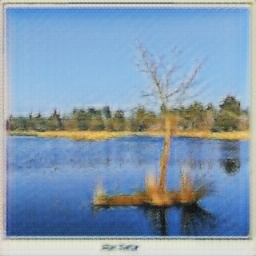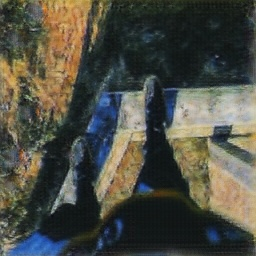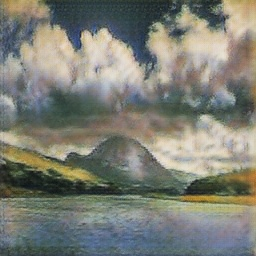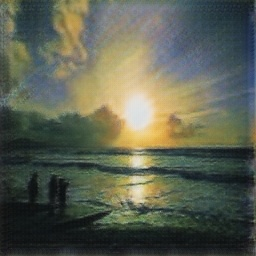

## Conclusion (15 pts)

We developed a deep learning model that performs style transfer using Generative Adversarial Networks (GANs).
During training, we encountered several challenges inherent to GANs, such as unstable loss convergence and mode collapse, which we were able to observe empirically.
Although the generated images were not flawless, they successfully captured the atmosphere and stylistic characteristics reminiscent of Monet’s paintings.

### Disclosure
AI-assisted code completion was used in non-essential parts of the notebook.